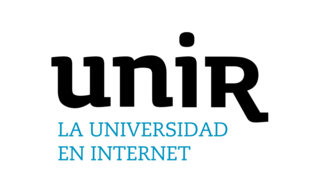

_M√°ster Universitario en Inteligencia Artificial_

_Trabajo Fin de M√°ster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificaci√≥n autom√°tica de estrellas variables con modelos Transformer aplicados a series temporales



In [2]:
# Install missing packages
%pip install torch lightkurve
%pip install -q pyarrow

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10.0/10.0 MB 13.9 MB/s eta 0:00:00 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11.1/11.1 MB 34.0 MB/s eta 0:00:00 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.0/2.0 MB 114.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 738.7/738.7 kB 58.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

In [3]:
import torch, lightkurve as lk

print("Torch:", torch.__version__)
print("Lightkurve:", lk.__version__)

Torch: 2.2.2
Lightkurve: 2.5.0


| Fuente       | Misi√≥n | Etiquetado | Tipo         | M√©todo de acceso                   |
| ------------ | ------ | ---------- | ------------ | ---------------------------------- |
| Kepler EB    | Kepler | S√≠         | Binaries     | NASA Exoplanet Archive / Villanova |
| K2VARCAT     | K2     | S√≠         | Multiclase   | MAST HLSP                          |
| TESS-SVC     | TESS   | Semi       | Variabilidad | MAST HLSP                          |
| TESS-EB      | TESS   | S√≠         | EB continuas | MAST HLSP                          |
| VSX (AAVSO)  | Todos  | S√≠         | Multiclase   | AAVSO + MAST                       |
| Gaia DR3 Var | Todos  | S√≠         | Multiclase   | ESA Gaia Archive                   |

Dise√±o del esquema del dataset. Vamos a unificar las curvas descargadas en un dataset estructurado tipo CSV/Parquet con este esquema m√≠nimo:

| id\_mision | id\_objeto | mision | clase\_variable | fecha\_inicio | fecha\_fin | tiempo | magnitud | error | origen\_etiqueta |
| ---------- | ---------- | ------ | --------------- | ------------- | ---------- | ------ | -------- | ----- | ---------------- |

Estrategia de implementaci√≥n t√©cnica
Podemos hacerlo en varias etapas:

- Script 1: descarga de curvas etiquetadas de Kepler EB y TESS-EB (usando ID + clase desde CSV original)
- Script 2: procesamiento de K2VARCAT (CSV disponible con clase + ID)
- Script 3: combinaci√≥n cruzada entre TIC (TESS Input Catalog) y VSX (requiere posiciones celestes + nombre)
- Script 4: cruce de Gaia DR3 variables con coordenadas de Kepler/K2/TESS
- Script 5: exportaci√≥n consolidada en formato CSV/Parquet final con clases normalizadas

### üì• Script 1: descarga y consolidaci√≥n de curvas de Kepler y TESS de la clase EB (entorno local o SageMaker)
Esta secci√≥n permite ejecutar el script 1, ya sea con el cat√°logo completo (en SageMaker) o con una muestra reducida (en local), y verificar el resultado consolidado.


In [ ]:
import warnings
import os, sys, platform
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librer√≠as externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("üîá Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Lanzando el script de ejemplo directamente
# !python src/script_2_k2varcat_multiclase.py.py

# Asegurarse de que el directorio 'src' est√© en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.fase1.script_1_kepler_tess_eb import main as run_script_1

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

existing = len(glob.glob("/home/ec2-user/backup/data/raw/kepler/*.csv")) + len(glob.glob("/home/ec2-user/backup/data/raw/tess/*.csv"))
print(f"üóÉÔ∏è Curvas ya existentes en disco: {existing}", flush=True)

# Ejecutar con la opci√≥n adecuada
if is_sagemaker:
    print("üîÅ Ejecutando en SageMaker ‚Üí cat√°logo completo")
    # Solo Kepler, solo pendientes
    run_script_1(mission="Kepler", only_pending=True)
    # Ambos, solo pendientes
    #run_script_1(mission="ALL", only_pending=True)
else:
    print("üíª Ejecutando en entorno local ‚Üí cat√°logo de prueba")
    run_script_1(use_sample=True)

üîá Warnings silenciados: UserWarning, FutureWarning
üìÅ Usando RAW_DIR: /home/ec2-user/backup/data/raw


[05/16/25 11:50:07] INFO     Found credentials from IAM Role:                                   ]8;id=329048;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=354539;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
üóÉÔ∏è Curvas ya existentes en disco: 7707
üîÅ Ejecutando en SageMaker ‚Üí cat√°logo completo
[‚¨á] Descargando cat√°logos completos de Kepler y TESS...
[‚¨á] Descargando cat√°logo Kepler EB...
[üìÇ] Cargando cat√°logo Kepler EB desde copia local...
[‚¨á] Descargando cat√°logo TESS EB...
[‚¨á] Generando CSV de entrada para descarga de curvas...
üìù CSV generado con 0 estrellas ‚Üí data/lists/eb_ids.csv
[‚¨á] Descargando curvas de luz...

üöÄ Procesando misi√≥n: Kepler (only_pending=True)
üìù CSV generado con 0 estrellas ‚Üí data/lists/eb_ids_kepler_pendientes.csv
[‚¨á] Descargando 0 curvas en paralelo con 8 hilos...


üöÄ Descargando curvas: 0it [00:00, ?it/s]


	üì¶ 0 objetos procesados hasta ahora...
[‚úì] Descarga finalizada: 0 objetos procesados.
[‚≠¢] Leyendo y fusionando curvas descargadas...


[üìÅ] Usando 37 lotes ya existentes en /home/ec2-user/temp_batches
[‚è≥] Uniendo todos los lotes en /home/ec2-user/backup/processed/dataset_eb_kepler.parquet...


üìö Uniendo lotes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 37/37 [01:46<00:00,  2.88s/it]


[‚úÖ] Dataset parquet construido ‚Üí /home/ec2-user/backup/processed/dataset_eb_kepler.parquet
üßπ Carpeta temporal eliminada: /home/ec2-user/temp_batches
[‚≠¢] Fusionando metadatos (etiquetas)...
[‚è±] Tiempo total: 108.39 segundos


In [ ]:
from src.utils.cleanup_raw import cleanup_raw_data

# Limpiar los datos de prueba
#cleanup_raw_data('/home/ec2-user/backup/data/raw', confirm=True)

##### üì• Comprobaci√≥n de los fichero de curvas Kepler y TESS (EB) mergeado y consolidado

##### ‚ö†Ô∏è Comprobaci√≥n de la columna "clase_variable"

In [ ]:
import pyarrow.parquet as pq
from pathlib import Path

for name in ["kepler", "tess"]:
    path = Path(f"data/processed/dataset_eb_{name}_labeled.parquet")
    if not path.exists():
        print(f"‚ùå Archivo no encontrado: {path}")
        continue

    try:
        parquet_file = pq.ParquetFile(path)
        schema = parquet_file.schema_arrow
        columns = schema.names

        print(f"\nüì¶ {name.upper()} contiene {len(columns)} columnas:")
        print(columns)

        if "clase_variable" in columns:
            print(f"‚úÖ 'clase_variable' est√° presente en {name.upper()}")
        else:
            print(f"‚ö†Ô∏è  'clase_variable' NO est√° presente en {name.upper()}")
    except Exception as e:
        print(f"‚ùå Error leyendo {path}: {e}")



üì¶ KEPLER contiene 31 columnas:
['tiempo', 'magnitud', 'error', 'quality', 'timecorr', 'centroid_col', 'centroid_row', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']
‚úÖ 'clase_variable' est√° presente en KEPLER

üì¶ TESS contiene 30 columnas:
['tiempo', 'magnitud', 'error', 'timecorr', 'cadenceno', 'centroid_col', 'centroid_row', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']
‚úÖ 'clase_variable' 

### ‚úÖ FIX de la columna "clase_variable"

In [ ]:
from pathlib import Path
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

def reparar_parquet_streaming(parquet_path: Path, output_path: Path, clase_default: str = "EB"):
    dataset = ds.dataset(parquet_path, format="parquet")

    # Preparamos el escritor con el esquema extendido
    sample_batch = next(dataset.to_batches(batch_size=100))
    schema_original = sample_batch.schema
    schema_nueva = schema_original.append(pa.field("clase_variable", pa.string()))

    writer = pq.ParquetWriter(output_path, schema=schema_nueva, compression="snappy")

    print(f"[üîß] Reparando parquet: {parquet_path.name}")
    fragmentos = dataset.to_batches(batch_size=50000)

    for batch in tqdm(fragmentos, desc="üõ†Ô∏è Reparando por lotes"):
        n = batch.num_rows
        columna_clase = pa.array([clase_default] * n, type=pa.string())
        batch_corregido = batch.append_column("clase_variable", columna_clase)
        writer.write_table(pa.Table.from_batches([batch_corregido], schema=schema_nueva))

    writer.close()
    print(f"[‚úÖ] Reparaci√≥n completada ‚Üí {output_path}")

# Ejemplo de uso:
reparar_parquet_streaming(Path("data/processed/dataset_eb_tess.parquet"),
                          Path("data/processed/dataset_eb_tess_labeled.parquet"))

[üîß] Reparando parquet: dataset_eb_tess.parquet


üõ†Ô∏è Reparando por lotes: 2426it [10:19,  3.91it/s]


[‚úÖ] Reparaci√≥n completada ‚Üí data\processed\dataset_eb_tess_labeled.parquet


### üì• Script 2: descarga y consolidaci√≥n de curvas de K2 (multiclase) (entorno local o SageMaker)
Esta secci√≥n permite ejecutar el script 2, ya sea con el cat√°logo completo (en SageMaker) o con una muestra reducida (en local), y verificar el resultado consolidado.

| Posici√≥n | Nombre          | Descripci√≥n                                                                   |
| -------- | --------------- | ----------------------------------------------------------------------------- |
| 0        | `EPIC_ID`       | Identificador del cat√°logo EPIC                                               |
| 1        | `K2_TYPE`       | Tipo de curva: EB, AP, QP, P                                                  |
| 2        | `RANGE_PCT`     | Rango de la curva de luz (en %)                                               |
| 3        | `PERIOD_DAYS`   | Periodo estimado (d√≠as). 0 para sistemas aperi√≥dicos                          |
| 4        | `AMPLITUDE_PCT` | Amplitud (en %), interpretada seg√∫n el tipo                                   |
| 5        | `PROPOSAL_INFO` | Texto libre con n√∫mero de propuesta y/o tipo de variable                      |
| 6        | `AMP_ERR1`      | Sin descripci√≥n clara ‚Äî puede ser un valor derivado t√©cnico (puede ignorarse) |
| 7        | `AMP_ERR2`      | √çdem                                                                          |


Aunque search_lightcurve() encuentra resultados, estos est√°n en un formato no compatible con las versiones actuales de Lightkurve (que est√° dise√±ado para los productos SPOC y algunos QLP).
En resumen:
Los datos de K2VARCAT en MAST existen.
Pero no se pueden abrir ni procesar directamente con Lightkurve, ni con .download() ni con .download_all().

- Usar EPIC_ID + clase del CSV de K2VARCAT.
- Buscar curvas reales usando author="EVEREST" (s√≠ compatibles con Lightkurve).
- Descargar y procesar curvas para esos objetos.
- Guardar todo en formato .parquet con esquema est√°ndar.

In [ ]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librer√≠as externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("üîá Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Lanzando el script de ejemplo directamente
# !python src/script_2_k2varcat_multiclase.py.py

# Asegurarse de que el directorio 'src' est√© en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.fase1.script_2_k2varcat_everest import main as run_script_2

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("üîÅ Ejecutando en SageMaker ‚Üí cat√°logo completo")
    run_script_2(limit=None, workers=10)
else:
    print("üíª Ejecutando en entorno local ‚Üí cat√°logo de prueba")
    run_script_2(limit=None, workers=8)


üîá Warnings silenciados: UserWarning, FutureWarning
üíª Ejecutando en entorno local ‚Üí cat√°logo de prueba
‚úÖ Cat√°logo ya descargado: data/raw/k2varcat_official.csv


üì¶ Procesando curvas EVEREST: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8395/8395 [43:51<00:00,  3.19it/s]  


Resumen de estado: {'‚ùå': 3478, 'üü°': 3024, '‚úÖ': 1893}
‚úÖ Dataset final guardado en: data/processed/dataset_k2varcat.parquet


#### Borrado cach√© Lightcurve

In [4]:
import shutil
import os

# Ruta por defecto en sistemas Windows / Unix
cache_dir = os.path.expanduser("~/.lightkurve/cache")

# Intentar vaciar con m√©todo oficial de Lightkurve (si existe)
try:
    from lightkurve import clear_download_cache
    print("üßπ Limpiando cach√© con Lightkurve...")
    clear_download_cache()
except ImportError:
    print("‚ö†Ô∏è clear_download_cache no est√° disponible en esta versi√≥n de Lightkurve. Se eliminar√° manualmente.")

# Borrar carpeta cache si todav√≠a quedan ficheros residuales
if os.path.exists(cache_dir):
    try:
        shutil.rmtree(cache_dir)
        print(f"‚úÖ Cach√© eliminada: {cache_dir}")
    except Exception as e:
        print(f"‚ö†Ô∏è No se pudo eliminar completamente la carpeta: {e}")
else:
    print("‚ÑπÔ∏è No se encontr√≥ la carpeta de cach√©")

# Confirmaci√≥n de espacio liberado (solo si quieres usarlo)
import psutil
total, used, free = shutil.disk_usage(".")
print(f"üíæ Espacio libre actual: {free // (1024 ** 3)} GB")


‚ö†Ô∏è clear_download_cache no est√° disponible en esta versi√≥n de Lightkurve. Se eliminar√° manualmente.
‚úÖ Cach√© eliminada: C:\Users\hav3f/.lightkurve/cache
üíæ Espacio libre actual: 96 GB


In [ ]:
import shutil

chunks_dir = "data/processed/k2varcat_chunks"
shutil.rmtree(chunks_dir)
print(f"‚úÖ Directorio eliminado: {chunks_dir}")


### üì• Script 3: descarga y consolidaci√≥n de curvas de K2 (multiclase) (entorno local o SageMaker)

#### üéØ Objetivo:

Cruzar objetos del cat√°logo TIC (TESS Input Catalog) con el cat√°logo **VSX (AAVSO Variable Star Index)** para:

-   Obtener variables etiquetadas con clases del VSX.
    
-   Localizar sus posiciones celestes (RA, DEC).
    
-   Buscar sus curvas reales mediante ID TIC o coordenadas.
    
#### ‚úÖ Fuentes necesarias:

**TIC**

ID TIC, RA/DEC, magnitudes, TESS target info

MAST via Vizier o CDS

**VSX**

Nombre variable, RA/DEC, tipo variable (EA, DSCT, RRab, etc.)

tic_dec00_00N__02_00N.csv.gz - 4.51GB

tic_dec02_00N__04_00N.csv.gz - 4.77GB

tic_dec02_00S__00_00N.csv.gz - 5.04GB

tic_dec04_00N__06_00N.csv.gz - 4.57GB

tic_dec04_00S__02_00S.csv.gz - 4.40GB

tic_dec06_00N__08_00N.csv.gz - 4.65GB

tic_dec06_00S__04_00S.csv.gz - 5.01GB

tic_dec08_00N__10_00N.csv.gz - 4.87GB

tic_dec08_00S__06_00S.csv.gz - 5.51GB

tic_dec10_00N__12_00N.csv.gz - 5.09GB

tic_dec10_00S__08_00S.csv.gz - 5.40GB

tic_dec12_00N__14_00N.csv.gz - 5.03GB

tic_dec12_00S__10_00S.csv.gz - 5.40GB

tic_dec14_00N__16_00N.csv.gz - 4.94GB

tic_dec14_00S__12_00S.csv.gz - 5.90GB

tic_dec16_00N__18_00N.csv.gz - 4.76GB

tic_dec16_00S__14_00S.csv.gz - 6.93GB

tic_dec18_00N__20_00N.csv.gz - 4.77GB

tic_dec18_00S__16_00S.csv.gz - 7.79GB

tic_dec20_00S__18_00S.csv.gz - 7.99GB

**TOTAL: 107 GB**

In [ ]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librer√≠as externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("üîá Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Lanzando el script de ejemplo directamente
# !python src/script_2_k2varcat_multiclase.py.py

# Asegurarse de que el directorio 'src' est√© en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.fase1.script_3_vsx_tic_match import main as run_script_3

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("üîÅ Ejecutando en SageMaker ‚Üí cat√°logo completo")
    run_script_3(limit=None, radio_arcsec=3.0, limit_bins=5)
else:
    print("üíª Ejecutando en entorno local ‚Üí cat√°logo completo")
    run_script_3(limit=5000, radio_arcsec=3.0, limit_bins=30, max_download_workers=4)


üîá Warnings silenciados: UserWarning, FutureWarning
üíª Ejecutando en entorno local ‚Üí cat√°logo completo
üìâ Cat√°logo VSX reducido a franja DEC -20 ‚Üí 20 (3900 objetos)
üéØ Limitando a 30 regiones DEC (bins √∫nicos)
üì¶ Archivos DEC necesarios: ['tic_dec00_00N__02_00N.csv.gz', 'tic_dec02_00N__04_00N.csv.gz', 'tic_dec02_00S__00_00N.csv.gz', 'tic_dec04_00N__06_00N.csv.gz', 'tic_dec04_00S__02_00S.csv.gz', 'tic_dec06_00N__08_00N.csv.gz', 'tic_dec06_00S__04_00S.csv.gz', 'tic_dec08_00N__10_00N.csv.gz', 'tic_dec08_00S__06_00S.csv.gz', 'tic_dec10_00N__12_00N.csv.gz', 'tic_dec10_00S__08_00S.csv.gz', 'tic_dec12_00N__14_00N.csv.gz', 'tic_dec12_00S__10_00S.csv.gz', 'tic_dec14_00N__16_00N.csv.gz', 'tic_dec14_00S__12_00S.csv.gz', 'tic_dec16_00N__18_00N.csv.gz', 'tic_dec16_00S__14_00S.csv.gz', 'tic_dec18_00N__20_00N.csv.gz', 'tic_dec18_00S__16_00S.csv.gz', 'tic_dec20_00S__18_00S.csv.gz']
üü° Ya existe: tic_dec00_00N__02_00N.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec02_00S__0

‚¨áÔ∏è Descargando TIC: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:00<00:00, 661.85it/s]

üü° Ya existe: tic_dec10_00N__12_00N.csv.gz. No se vuelve a descargar.üü° Ya existe: tic_dec08_00S__06_00S.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec12_00N__14_00N.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec10_00S__08_00S.csv.gz. No se vuelve a descargar.

üü° Ya existe: tic_dec12_00S__10_00S.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec14_00S__12_00S.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec14_00N__16_00N.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec16_00S__14_00S.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec16_00N__18_00N.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec18_00N__20_00N.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec18_00S__16_00S.csv.gz. No se vuelve a descargar.
üü° Ya existe: tic_dec20_00S__18_00S.csv.gz. No se vuelve a descargar.


üìÇ Procesando en chunks tic_dec06_00N__08_00N.csv.gz...
‚è±Ô∏è Chunks procesados en 389.62 s
üìÇ Procesando en chunks tic_dec02_00N__04_00N.csv.gz...
‚è±Ô∏è Chunks procesados en 422.36 s
üìÇ Procesando en chunks tic_dec08_00N__10_00N.csv.gz...
‚è±Ô∏è Chunks procesados en 407.71 s
üìÇ Procesando en chunks tic_dec02_00S__00_00N.csv.gz...
‚è±Ô∏è Chunks procesados en 348.85 s
üìÇ Procesando en chunks tic_dec04_00S__02_00S.csv.gz...
‚è±Ô∏è Chunks procesados en 304.94 s
üìÇ Procesando en chunks tic_dec00_00N__02_00N.csv.gz...
‚è±Ô∏è Chunks procesados en 284.42 s
üìÇ Procesando en chunks tic_dec06_00S__04_00S.csv.gz...
‚è±Ô∏è Chunks procesados en 306.23 s
üìÇ Procesando en chunks tic_dec04_00N__06_00N.csv.gz...
‚è±Ô∏è Chunks procesados en 266.55 s
üìÇ Procesando en chunks tic_dec08_00S__06_00S.csv.gz...
‚è±Ô∏è Chunks procesados en 336.47 s
üìÇ Procesando en chunks tic_dec12_00N__14_00N.csv.gz...
‚è±Ô∏è Chunks procesados en 274.89 s
üìÇ Procesando en chunks tic_dec10_00S__08_00S.cs

üßÆ Procesando por lotes: 1it [00:00, 55.55it/s]


‚úÖ Resumen exportado a: data/processed/summary\dataset_vsx_tic_labeled_summary.csv


PermissionError: [WinError 5] Acceso denegado: 'data\\processed\\temp_vsx_tic'

### ‚ÑπÔ∏è Verificaci√≥n de estructura y metada

In [2]:
import pyarrow.dataset as ds
from collections import Counter
from tqdm import tqdm
import json
import csv
from datetime import datetime
import os

def inspect_and_export_summary(parquet_path, output_format="json"):
    print(f"\nüìÅ Inspeccionando: {parquet_path}")
    dataset = ds.dataset(parquet_path, format="parquet")
    schema = dataset.schema

    summary = {
        "file": parquet_path,
        "columns": {field.name: str(field.type) for field in schema},
        "class_distribution": {},
        "total_rows": 0,
        "total_objects": 0,
        "timestamp": datetime.now().isoformat()
    }

    class_counter = Counter()
    objetos = set()

    for batch in tqdm(dataset.to_batches(columns=["clase_variable", "id_objeto"]), desc="üßÆ Procesando por lotes"):
        summary["total_rows"] += batch.num_rows
        if "clase_variable" in batch.schema.names:
            clases = batch.column("clase_variable").to_pylist()
            class_counter.update(clases)
        if "id_objeto" in batch.schema.names:
            objetos.update(batch.column("id_objeto").to_pylist())

    summary["class_distribution"] = dict(class_counter)
    summary["total_objects"] = len(objetos)

    # Salida
    output_dir = "data/processed/summary"
    os.makedirs(output_dir, exist_ok=True)
    basename = os.path.splitext(os.path.basename(parquet_path))[0]
    output_path = os.path.join(output_dir, f"{basename}_summary.{output_format}")

    if output_format == "json":
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)
    elif output_format == "csv":
        with open(output_path, "w", newline='', encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Clase", "Recuento"])
            for clase, count in class_counter.items():
                writer.writerow([clase, count])
        # A√±adir resumen general en info.txt
        with open(output_path.replace(".csv", "_info.txt"), "w", encoding="utf-8") as f:
            f.write(f"Fichero: {summary['file']}\n")
            f.write(f"Filas totales: {summary['total_rows']}\n")
            f.write(f"Curvas √∫nicas (id_objeto): {summary['total_objects']}\n")
            f.write(f"Columnas: {list(summary['columns'].keys())}\n")
            f.write(f"Fecha: {summary['timestamp']}\n")
    else:
        raise ValueError("‚ùå Formato no soportado. Usa 'json' o 'csv'.")

    print(f"‚úÖ Resumen exportado a: {output_path}")

# üîß Uso de ejemplo
#inspect_and_export_summary("data/processed/dataset_eb_kepler_labeled.parquet", output_format="csv")
#inspect_and_export_summary("data/processed/dataset_eb_tess_labeled.parquet", output_format="csv")
# Inspeccionar el parquet de K2
#inspect_and_export_summary("data/processed/dataset_k2varcat_labeled.parquet", output_format="csv")
# Inspeccionar el parquet de VSX-TIC-TESS
inspect_and_export_summary("data/processed/dataset_vsx_tess_labeled.parquet", output_format="csv")



üìÅ Inspeccionando: data/processed/dataset_vsx_tess_labeled.parquet


üßÆ Procesando por lotes: 314it [03:04,  1.70it/s]

‚úÖ Resumen exportado a: data/processed/summary\dataset_vsx_tess_labeled_summary.csv


üìä ¬øQu√© indica el recuento?
No representa el n√∫mero de estrellas, sino la suma de todas las observaciones individuales que componen las curvas.

#### **Kepler**

| M√©trica                          | Valor         |
| -------------------------------- | ------------- |
| üî¢ Filas totales (observaciones) | 71,735,011    |
| üåü Curvas √∫nicas (`id_objeto`)   | 2762         |
| üß¨ Clases presentes              | EB |

71,7 millones de puntos de luz (observaciones) etiquetados como "EB" (eclipsing binary), pertenecientes a 2762 curvas de luz.

#### **TESS**

| M√©trica                          | Valor         |
| -------------------------------- | ------------- |
| üî¢ Filas totales (observaciones) | 120,747,997    |
| üåü Curvas √∫nicas (`id_objeto`)   | 4142         |
| üß¨ Clases presentes              | EB |
 
120,7 millones de observaciones etiquetadas como "EB", pertenecientes a 4142 curvas de luz.

#### **K2**

| M√©trica                          | Valor         |
| -------------------------------- | ------------- |
| üî¢ Filas totales (observaciones) | 17,895,159    |
| üåü Curvas √∫nicas (`id_objeto`)   | 4917         |
| üß¨ Clases presentes              | AP, QP, P, EB |

17,8 millones de observaciones etiquetadas multiclase, pertenecientes a 4917 curvas de luz.

Distribuci√≥n de clases: 

| Clase | Observaciones |
| ----- | ------------- |
| AP    | 9,884,704     |
| QP    | 7,344,096     |
| P     | 433,803       |
| EB    | 232,556       |

NOTA: la clase `EB`, que no estaba en el subconjunto reducido pero s√≠ aparece en el total, lo cual valida que el cat√°logo completo contiene ejemplos de todas las clases previstas.

#### **VSX <> TIC**


-   **Total de coincidencias**: 3989
-   **Objetos √∫nicos**: 3879 ‚Üí solo hay unos pocos objetos duplicados (esperable si hay m√∫ltiples matches por posici√≥n con el mismo `id_objeto` VSX)
-   **Columnas correctas**: identificadores, posici√≥n cruzada, tipo de variable y fuente.

üìä Distribuci√≥n de clases

-   El sistema ha capturado una gran variedad de clases reales como:  
    -   `ROT`, `RRAB`, `DSCT`, `RS`, `EA`, `EW`, `EB`, `GDOR`, `ACV`, etc.
-   Hay algunas clases **ambiguas o sin limpiar**, como:
    -   Compuestos (`DSCT|GDOR|SXPHE`, `ESD|EC`)
    -   Vac√≠os: `''` ‚Üí 16 filas
    -   Etiquetas complejas (m√°s de 3 clases unidas por `|`)

üîÅ Esto es habitual en VSX, y podr√°s **normalizar esas clases** para agrupar mejor.

‚úÖ `dataset_vsx_tic_labeled.parquet` es un **cat√°logo cruzado** que contiene:

* Estrellas variables identificadas en VSX
* Posiciones (RA/DEC) y tipos de variabilidad (`clase_variable`)
* Su correspondiente `tic_id` en el cat√°logo TIC

üö´ Pero **no contiene curvas de luz**, a diferencia de tus datasets previos de Kepler, K2 y TESS.

üß≠ Por tanto, los **pasos siguientes correctos** son:

#### ‚úÖ 1. Limpieza y consolidaci√≥n de clases (`clase_variable`)

* VSX usa nomenclaturas complejas: combinaciones (`DSCT|GDOR|SXPHE`), ambig√ºedades (`VAR`, `MISC`) y valores vac√≠os.
* Necesitas definir una taxonom√≠a unificada (por ejemplo, agrupar todos los `RR*` en `RR Lyrae`, o filtrar `UNKNOWN`).
* Resultado: una columna `clase_variable_normalizada` √∫til para clasificaci√≥n supervisada.

üëâ Esto se puede hacer ya sobre el `.parquet` actual sin descargar nada m√°s.

#### ‚úÖ 2. Usar `tic_id` para descargar curvas reales de TESS

* Usas `Lightkurve` o MAST para buscar y descargar curvas de luz (`PDCSAP_FLUX`) por `tic_id`.
* Construyes un nuevo `.parquet` que **s√≠ contendr√° curvas reales** (tiempo, magnitud, error...).
* Este ser√° tu dataset VSX-TESS etiquetado real.

üëâ Esto ser√° el que puedes fusionar con Kepler, K2 y TESS ya procesados. **...Eso es lo que hemos hecho (ver celda abajo con llamada a `script_3a_clean_vsx_classes`) y tenemos**: 

##### üìå `dataset_vsx_tess_labeled.parquet`

#### **VSX <> TIC** => TESS

| M√©trica                          | Valor         |
| -------------------------------- | ------------- |
| üî¢ Filas totales (observaciones) | 41,1 millones    |
| üåü Curvas √∫nicas (`id_objeto`)   | 1594         |
| üß¨ Clases presentes              | m√∫ltiples |
| üü¢ Columnas              | tiempo, magnitud, error, clase_variable, etc. |


üìä Distribuci√≥n de clases
‚úÖ Cosas correctas:
- Las clases originales del cat√°logo VSX han sido conservadas.
- Muchas de ellas fueron etiquetadas por patrones m√∫ltiples (DSCT|GDOR|SXPHE, EC|ESD, etc.).
- Existen clases ya normalizadas como ROT, EA, RS, EB, RRAB‚Ä¶
- La clase vac√≠a , se ha detectado como tal y separada (468006 filas): podemos limpiar eso despu√©s si hace falta.





In [ ]:
from src.fase1.script_3a_clean_vsx_classes import main as run_normalization
run_normalization()

üì• Leyendo: data/processed/dataset_vsx_tic_labeled.parquet
üîß Normalizando clases...
üîé Clases √∫nicas encontradas: 33
üíæ Guardando dataset limpio en: data/processed/dataset_vsx_tic_labeled_clean.parquet
üìä Exportando resumen de clases...
‚úÖ Proceso completado


In [ ]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librer√≠as externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("üîá Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Asegurarse de que el directorio 'src' est√© en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.fase1.script_3b_download_tess_curves_from_vsx import main as run_vsx_tess_download

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("üîÅ Ejecutando en SageMaker ‚Üí cat√°logo completo")
    run_vsx_tess_download(limit=None, workers=4)
else:
    print("üíª Ejecutando en entorno local ‚Üí cat√°logo completo")
    run_vsx_tess_download(limit=None, workers=8)


üîá Warnings silenciados: UserWarning, FutureWarning
üíª Ejecutando en entorno local ‚Üí cat√°logo completo
üì• Cargando dataset: data/processed/dataset_vsx_tic_labeled.parquet


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3987/3987 [12:00:11<00:00, 10.84s/it]  


‚úÖ Guardados 41143597 registros en parquet temporales.
üì¶ Unificando resultados...
‚úÖ Dataset final guardado en: data/processed/dataset_vsx_tess_labeled.parquet (41143597 filas)

üìÅ Inspeccionando: data/processed/dataset_vsx_tess_labeled.parquet


NameError: name 'ds' is not defined

In [ ]:
# NORMALIZACION DE CLASES EN EL FICHERO FINAL DE ESTE SCRIPT

from src.fase1.script_3c_clean_vsx_tess_classes import limpiar_dataset, inspect_and_export_summary

path = limpiar_dataset()
inspect_and_export_summary(path, output_format="csv")


üì• Le√≠das 41143597 filas desde data/processed/dataset_vsx_tess_labeled.parquet
‚úÖ Guardado dataset limpio en: data/processed/dataset_vsx_tess_labeled_clean.parquet

üìÅ Inspeccionando: data/processed/dataset_vsx_tess_labeled_clean.parquet


üßÆ Procesando por lotes: 314it [03:52,  1.35it/s]

‚úÖ Resumen exportado a: data/processed/summary\dataset_vsx_tess_labeled_clean_summary.csv


| Clase        | Recuento        |
| ------------ | --------------- |
| Rotational   | 26.2 millones ‚úÖ |
| Eclipsing    | 3.1 millones ‚úÖ  |
| Delta\_Scuti | 2.9 millones ‚úÖ  |
| RS\_CVn      | 1.7 millones ‚úÖ  |
| RR\_Lyrae    | 427 mil ‚úÖ       |
| Cataclysmic  | 535 mil ‚úÖ       |
| White\_Dwarf | 219 mil ‚úÖ       |
| Irregular    | 3.6 millones ‚úÖ  |
| BY\_Dra      | 277 mil ‚úÖ       |
| Beta\_Cep    | 181 mil ‚úÖ       |
| YSO          | 138 mil ‚úÖ       |
| RARE         | 1.17 millones ‚úÖ |
| UNKNOWN      | 468 mil ‚ö†Ô∏è      |


#### ‚úÖ 3. Script 4: cruce con Gaia DR3

Este paso (cruce por coordenadas) tendr√° m√°s sentido cuando tengas todo lo anterior consolidado.



In [ ]:
%run src/inspect_parquets_for_gaia.py


üîç Analizando datasets para cruce con Gaia DR3:

üìÅ dataset_eb_kepler_labeled.parquet
üîë Columnas detectadas: ['tiempo', 'magnitud', 'error', 'quality', 'timecorr', 'centroid_col', 'centroid_row', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']

‚ö†Ô∏è Coordenadas insuficientes para cruce con Gaia
       tiempo  magnitud     error  quality  timecorr  centroid_col
0  131.512362  1.065252  0.000161        0  0.001369     860.09303
1  131.532797  0.974507  0.000158        0  0.001369     860.09343

------------------------------------------------------------

üìÅ dataset_eb_tess_labeled.parquet
üîë Columnas detectadas: ['tiempo', 'magnitud', 'error', 'timecorr', 'cadenceno', 'centr

In [ ]:
%run src/fase1/script_3c_merge_coordinates_into_clean_vsx.py

üìÇ Cargando dataset limpio: dataset_vsx_tic_labeled_clean.parquet
üìÇ Cargando dataset original: dataset_vsx_tic_labeled.parquet
üßæ Columnas del original: ['id_objeto', 'nombre_vsx', 'clase_variable', 'ra', 'dec', 'tic_id', 'tic_ra', 'tic_dec', 'origen_etiqueta']
üßπ Eliminando columnas conflictivas del limpio: ['ra', 'dec', 'tic_ra', 'tic_dec']
üß≠ Usando coordenadas: tic_ra ‚Üí ra, tic_dec ‚Üí dec
‚úÖ Columnas finales en df_merged: ['id_objeto', 'nombre_vsx', 'clase_variable', 'tic_id', 'origen_etiqueta', 'clase_variable_normalizada', 'ra', 'dec']
‚ö†Ô∏è Filas sin coordenadas tras merge: 0
‚úÖ Guardado con coordenadas: data\processed\dataset_vsx_tic_labeled_clean_with_coords.parquet (3989 filas)


In [ ]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librer√≠as externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("üîá Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Asegurarse de que el directorio 'src' est√© en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.fase1.script_4_gaia_dr3_vsx_tic_crossmatch import main as run_gaiadr3

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("üîÅ Ejecutando en SageMaker ‚Üí cat√°logo completo")
    run_gaiadr3(limit=None, workers=4)
else:
    print("üíª Ejecutando en entorno local ‚Üí catalogo completo")
    run_gaiadr3(limit=None, workers=8)


üîá Warnings silenciados: UserWarning, FutureWarning
üíª Ejecutando en entorno local ‚Üí catalogo completo
üìÑ Cargando: dataset_vsx_tic_labeled_clean_fixed.parquet
üìä Total inicial: 3989
üìä Tras normalizar id_objeto: 3989
üìä Tras filtrar coordenadas v√°lidas: 3989
üìä Final tras drop_duplicates: 3987
üì¶ Dataset listo: 3987 objetos √∫nicos con coordenadas
üì¶ Dataset listo: 3987 objetos √∫nicos con coordenadas
üìä Procesando dataset completo con 3987 objetos


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3987/3987 [06:44<00:00,  9.85it/s]  


‚úÖ Guardado en data\processed\dataset_gaia_dr3_vsx_tic_labeled.parquet (3987 filas)

üìÅ Inspeccionando: data\processed\dataset_gaia_dr3_vsx_tic_labeled.parquet


üßÆ Procesando por lotes: 1it [00:00, 55.27it/s]

‚úÖ Resumen exportado a: data\processed\summary\dataset_gaia_dr3_vsx_tic_labeled_summary.csv


#### ‚úÖ **NORMALIZACION DE LOS ID OBJETO EN LOS DISTINTOS DATASETS**

**Objetivo**

Corregir los valores de la columna id_objeto en estos ficheros:

- dataset_eb_kepler_labeled.parquet
- dataset_eb_tess_labeled.parquet
- dataset_k2varcat_labeled.parquet
- dataset_vsx_tess_labeled.parquet

Para que cumplan esta regla:

| Misi√≥n       | Formato correcto `id_objeto` |
| ------------ | ---------------------------- |
| Kepler       | `KIC_<id>`                   |
| K2 (EVEREST) | `EPIC_<id>`                  |
| TESS         | `TIC_<id>`                   |
| VSX-TESS     | `TIC_<id>`                   |


Y eliminar sufijos .0, espacios o s√≠mbolos indeseados.



In [ ]:
%run src/fase1/script_5a_normalize_ids.py --mision kepler



üîß Procesando KEPLER ‚Üí dataset_eb_kepler_labeled.parquet
üìù Procesando batch #1...
‚úÖ Primera tanda procesada. Esquema: ['tiempo', 'magnitud', 'error', 'quality', 'timecorr', 'centroid_col', 'centroid_row', 'cadenceno', 'sap_flux', 'sap_flux_err', 'sap_bkg', 'sap_bkg_err', 'pdcsap_flux', 'pdcsap_flux_err', 'sap_quality', 'psf_centr1', 'psf_centr1_err', 'psf_centr2', 'psf_centr2_err', 'mom_centr1', 'mom_centr1_err', 'mom_centr2', 'mom_centr2_err', 'pos_corr1', 'pos_corr2', 'id_objeto', 'id_mision', 'mision', 'fecha_inicio', 'fecha_fin', 'clase_variable']
‚úÖ Batch #1 escrito: 50000 filas
üìù Procesando batch #2...
‚úÖ Batch #2 escrito: 50000 filas
üìù Procesando batch #3...
‚úÖ Batch #3 escrito: 50000 filas
üìù Procesando batch #4...
‚úÖ Batch #4 escrito: 50000 filas
üìù Procesando batch #5...
‚úÖ Batch #5 escrito: 50000 filas
üìù Procesando batch #6...
‚úÖ Batch #6 escrito: 50000 filas
üìù Procesando batch #7...
‚úÖ Batch #7 escrito: 50000 filas
üìù Procesando batch #8..

In [ ]:
%run src/fase1/script_5a_normalize_ids.py --mision tess


üîß Procesando TESS ‚Üí dataset_eb_tess_labeled.parquet
üìù Procesando batch #1...
‚úÖ Batch #1 guardado en dataset_eb_tess_labeled_batch_0000.parquet (50000 filas)
üìù Procesando batch #2...
‚úÖ Batch #2 guardado en dataset_eb_tess_labeled_batch_0001.parquet (50000 filas)
üìù Procesando batch #3...
‚úÖ Batch #3 guardado en dataset_eb_tess_labeled_batch_0002.parquet (50000 filas)
üìù Procesando batch #4...
‚úÖ Batch #4 guardado en dataset_eb_tess_labeled_batch_0003.parquet (50000 filas)
üìù Procesando batch #5...
‚úÖ Batch #5 guardado en dataset_eb_tess_labeled_batch_0004.parquet (50000 filas)
üìù Procesando batch #6...
‚úÖ Batch #6 guardado en dataset_eb_tess_labeled_batch_0005.parquet (50000 filas)
üìù Procesando batch #7...
‚úÖ Batch #7 guardado en dataset_eb_tess_labeled_batch_0006.parquet (50000 filas)
üìù Procesando batch #8...
‚úÖ Batch #8 guardado en dataset_eb_tess_labeled_batch_0007.parquet (50000 filas)
üìù Procesando batch #9...
‚úÖ Batch #9 guardado en dataset_e

In [1]:
from pyarrow import dataset as ds
import pyarrow.parquet as pq
import pyarrow as pa
from pathlib import Path

# Configuraci√≥n
stem = "dataset_eb_tess_labeled_batch"
temp_dir = Path("data/processed/normalized_temp")
output_path = Path("data/processed/dataset_eb_tess_labeled_fixed.parquet")
batch_files = sorted(temp_dir.glob(f"{stem}_*.parquet"))

print(f"üîó Unificando {len(batch_files)} batches por streaming...")

# Crear dataset de entrada
dataset = ds.dataset(batch_files, format="parquet")

# Inicializar escritor
writer = None
for i, batch in enumerate(dataset.to_batches()):
    table = pa.Table.from_batches([batch])
    if writer is None:
        writer = pq.ParquetWriter(output_path, table.schema)
    writer.write_table(table)
    if (i + 1) % 100 == 0:
        print(f"‚úÖ {i+1} batches escritos...")

# Cerrar
if writer:
    writer.close()
    print(f"‚úÖ Escritura completada: {output_path}")



üîó Unificando 2426 batches por streaming...
‚úÖ 100 batches escritos...
‚úÖ 200 batches escritos...
‚úÖ 300 batches escritos...
‚úÖ 400 batches escritos...
‚úÖ 500 batches escritos...
‚úÖ 600 batches escritos...
‚úÖ 700 batches escritos...
‚úÖ 800 batches escritos...
‚úÖ 900 batches escritos...
‚úÖ 1000 batches escritos...
‚úÖ 1100 batches escritos...
‚úÖ 1200 batches escritos...
‚úÖ 1300 batches escritos...
‚úÖ 1400 batches escritos...
‚úÖ 1500 batches escritos...
‚úÖ 1600 batches escritos...
‚úÖ 1700 batches escritos...
‚úÖ 1800 batches escritos...
‚úÖ 1900 batches escritos...
‚úÖ 2000 batches escritos...
‚úÖ 2100 batches escritos...
‚úÖ 2200 batches escritos...
‚úÖ 2300 batches escritos...
‚úÖ 2400 batches escritos...
‚úÖ Escritura completada: data\processed\dataset_eb_tess_labeled_fixed.parquet


In [ ]:
%run src/fase1/script_5a_normalize_ids.py --mision k2

# Ejecutado en otro notebook

In [ ]:
%run src/fase1/script_5a_normalize_ids.py --mision vsx_tess

# Ejecutado en otro notebook

#### ‚úÖ **Verificaci√≥n estructural completa de todos los .parquet**
Podemos hacer un informe resumen autom√°tico para cada uno de los datasets que tienes en data/processed/, con foco en:

Dataset	¬øid_objeto limpio?	¬øtic_id presente?	¬øra/dec presentes?	¬øclase_variable?	¬øclase_variable_normalizada?	N¬∫ de filas

Esto te dar√≠a un estado global del proyecto.

In [4]:
%pip install tabulate
%run src/utils/inspect_all_parquets.py


Note: you may need to restart the kernel to use updated packages.
üìä Inspecci√≥n de 5 datasets...

üìÇ Inspeccionando: dataset_eb_kepler_labeled_fixed.parquet
üìÇ Inspeccionando: dataset_eb_tess_labeled_fixed.parquet
üìÇ Inspeccionando: dataset_k2varcat_labeled_fixed.parquet
üìÇ Inspeccionando: dataset_vsx_tess_labeled_fixed.parquet
üìÇ Inspeccionando: dataset_gaia_dr3_vsx_tic_labeled.parquet

‚è±Ô∏è Tiempo total: 233.67 segundos

| dataset                                  |      rows | id_objeto_ok   | mision   | ra    | dec   | clase_variable   | clase_variable_normalizada   | origen_etiqueta   |
|:-----------------------------------------|----------:|:---------------|:---------|:------|:------|:-----------------|:-----------------------------|:------------------|
| dataset_eb_kepler_labeled_fixed.parquet  |  71735011 | True           | True     | False | False | True             | False                        | False             |
| dataset_eb_tess_labeled_fixed.parquet    | 

| dataset                                  |      rows | id_objeto_ok   | mision   | ra    | dec   | clase_variable   | clase_variable_normalizada   | origen_etiqueta   |
|:-----------------------------------------|----------:|:---------------|:---------|:------|:------|:-----------------|:-----------------------------|:------------------|
| dataset_eb_kepler_labeled_fixed.parquet  |  71735011 | True           | True     | False | False | True             | False                        | False             |
| dataset_eb_tess_labeled_fixed.parquet    | 120747997 | True           | True     | False | False | True             | False                        | False             |
| dataset_k2varcat_labeled_fixed.parquet   |  17895159 | True           | True     | False | False | True             | False                        | True              |
| dataset_vsx_tess_labeled_fixed.parquet   |  41143597 | True           | True     | False | False | True             | True                         | True              |
| dataset_gaia_dr3_vsx_tic_labeled.parquet |      3987 | True           | True     | False | False | True             | False                        | True              |

#### ‚úÖ Script 5. Fusionar todos los datasets

Una vez tengas:

| Dataset             | Contenido          | Etiquetas      |
| ------------------- | ------------------ | -------------- |
| Kepler              | Curvas reales      | `EB`           |
| K2VARCAT            | Curvas reales      | Multiclase     |
| TESS-EB             | Curvas reales      | `EB`           |
| VSX-TIC (TESS) | Curvas reales TESS | Multiclase VSX |
| Cruce Gaia DR3 | Curvas reales | Multiclase |

Podremos unificar todos en un solo `.parquet` final para modelado.

‚úÖ Pr√≥ximos pasos recomendados
Consolidar todos los datasets etiquetados en un √∫nico .parquet global:

- dataset_eb_kepler_labeled.parquet
- dataset_eb_tess_labeled.parquet
- dataset_k2varcat_labeled.parquet
- dataset_vsx_tess_labeled.parquet
- dataset_gaia_dr3_vsx_tic_labeled.parquet

Normalizar todos los id_objeto al mismo formato.

Preferiblemente: TIC_<id> cuando est√© disponible.

En Kepler/K2 puedes usar KIC_<id> y EPIC_<id> seg√∫n misi√≥n

Asignar columna mision y origen_etiqueta correctamente en cada dataset

Guardar todo como: all_missions_labeled.parquet

¬øQuieres que prepare ahora el script script_5_unify_all_missions.py que realice esa consolidaci√≥n autom√°tica con verificaci√≥n y exportaci√≥n final?

**Dudas antes de continuar con el script de unificacion**: 
1) No todos los dataset tienen la clase_variable_normalizada, quiza ser√≠a mejor normalizar primero, o incluir esa normalizacion en el script de unificacion. 
2) Al final no llegamos a hacer el cruce de Gaia DR3 con los parquet de las otras misiones porque no teniamos "ra" y "dec", ¬ønos podemos plantear completar ese paso o es mejor abandonar la idea y seguir con lo que tenemos? 
3) ¬øComo de complicado ser√≠a incorporar coordenadas al dataset? 
3) ¬øEstamos seguros de que en los ficheros consolidados tenemos todas las variables independientes necesarias para la clasificacion? Si despues de varios d√≠as descargando curvas de luz y generando ficheros consolidados, ahora resulta que nos faltan datos ser√≠a un contratiempo enorme para mis fechas de entrega. 

#### ‚úÖ 1) ¬øNormalizar `clase_variable` antes o dentro del script de unificaci√≥n?

**Recomendaci√≥n:** incluir la normalizaci√≥n **dentro** del script de unificaci√≥n.

**Ventajas:**

* Garantiza que todas las clases queden en un √∫nico campo `clase_variable_normalizada`
* Evita inconsistencias por tener algunos ficheros ya normalizados y otros no
* Permite adaptar un √∫nico diccionario de equivalencias (`EA` ‚Üí `Eclipsing Binary`, `RRAB` ‚Üí `RR Lyrae AB`, etc.)

‚ú≥Ô∏è **Soluci√≥n t√©cnica:** en el script de consolidaci√≥n, aplicar `map()` con un diccionario de clases est√°ndar a cada dataset.

#### ‚ö†Ô∏è 2) ¬øCompletar el cruce con Gaia DR3 para Kepler, K2 y TESS usando `ra`/`dec`?

Actualmente **no se ha hecho**, porque:

* Los ficheros de curvas no inclu√≠an coordenadas (`ra`, `dec`) desde el principio.
* El cruce con Gaia requiere coordenadas ICRS para hacer el `CIRCLE(...)` de b√∫squeda.

**Opciones ahora:**

| Opci√≥n                                                       | Viable | Comentario                                                    |
| ------------------------------------------------------------ | ------ | ------------------------------------------------------------- |
| Recuperar `ra/dec` desde KIC/EPIC/TIC v√≠a cat√°logos externos | ‚úÖ      | Se puede hacer con `astroquery` usando `KIC`, `EPIC`, o `TIC` |
| Intentar cruce con Gaia para objetos que ya tienen TIC ID    | ‚úÖ      | VSX-TESS y Gaia-VSX ya tienen TIC, podemos complementarlos    |
| Abandonar ese cruce y usar solo lo ya procesado              | ‚úÖ      | Ser√≠a m√°s r√°pido y permite enfocarte en el modelo             |

‚ú≥Ô∏è **Mi consejo: avanza con lo que tienes consolidado** (es suficiente para entrenar y justificar el modelo). Si sobra tiempo, el cruce Gaia puede a√±adirse como mejora posterior.

#### ‚ùì 3) ¬øEs complicado incorporar `ra`/`dec` ahora?

No, **pero depende del origen** de los objetos:

* **Kepler**: puedes recuperar coordenadas con `astroquery.mast` + `KIC_ID`
* **K2**: igual, usando `EPIC_ID`
* **TESS**: puedes usar `astroquery.mast.Catalogs.query_object("TIC <id>", catalog="TIC")`
* **VSX-Gaia**: ya vienen de Gaia DR3, as√≠ que puedes completar desde `source_id`

‚ú≥Ô∏è ¬øMerece la pena hacerlo ahora? **Solo si necesitas coordenadas como feature de entrada o para el cruce con otros cat√°logos**.

#### ‚úÖ 4) ¬øTenemos todas las variables necesarias para entrenar?

S√≠, **si el objetivo es entrenar el modelo con curvas de luz + clase**, y no con metadatos adicionales.

Tus datasets contienen:

* `tiempo`, `magnitud`, `error` ‚Üí necesarios para construir secuencias temporales
* `id_objeto`, `mision`, `clase_variable` ‚Üí para agrupar, etiquetar y evaluar
* (algunos tienen `clase_variable_normalizada`, que podemos consolidar)

‚úîÔ∏è Eso es suficiente para generar los ejemplos tokenizados y alimentar un Transformer (como ATAT o AstroConformer).

#### üß† Conclusi√≥n operativa

| Paso | Acci√≥n recomendada                                                               |
| ---- | -------------------------------------------------------------------------------- |
| 1    | Generar script de unificaci√≥n con normalizaci√≥n integrada                        |
| 2    | Dejar el cruce Gaia como mejora opcional post-entrenamiento                      |
| 3    | No invertir tiempo en a√±adir coordenadas a todos los objetos ahora               |
| 4    | Confirmar que el pipeline de clasificaci√≥n puede iniciarse con lo ya consolidado |


=> Preparamos el `script_6_unify_all_missions.py` incluyendo:

* la normalizaci√≥n de clases
* validaci√≥n de columnas m√≠nimas
* exportaci√≥n como `all_missions_labeled.parquet`


In [1]:
%run src/script_6_unify_all_missions.py


üîé Detectando tipos reales por columna...
üß© Inferiendo tipos compatibles por columna
‚úÖ Esquema global construido con 112 columnas

üìÇ Procesando: dataset_eb_kepler_labeled_fixed.parquet
üìÇ Procesando: dataset_eb_tess_labeled_fixed.parquet
üìÇ Procesando: dataset_k2varcat_labeled_fixed.parquet
üìÇ Procesando: dataset_vsx_tess_labeled_fixed.parquet


C:\Users\hav3f\OneDrive - UNIR\MASTER UNIR - INTELIGENCIA ARTIFICIAL\ASIGNATURAS\CUATRIMESTRE 2\TRABAJO FIN DE MASTER\IMPLEMENTACION\src\script_6_unify_all_missions.py:113: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_batch[col] = None
C:\Users\hav3f\OneDrive - UNIR\MASTER UNIR - INTELIGENCIA ARTIFICIAL\ASIGNATURAS\CUATRIMESTRE 2\TRABAJO FIN DE MASTER\IMPLEMENTACION\src\script_6_unify_all_missions.py:113: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_batch[col] = None
C:\Users\hav3f\OneDrive - UNIR\MASTER UNIR - INTELIGEN

üìÇ Procesando: dataset_gaia_dr3_vsx_tic_labeled.parquet
‚ö†Ô∏è dataset_gaia_dr3_vsx_tic_labeled.parquet no contiene columnas requeridas: ['tiempo', 'magnitud']. Se omitir√°.
‚úÖ Dataset final guardado como: data\processed\all_missions_labeled.parquet
üìÑ Resumen de clases exportado: processed\summary\clase_variable_normalizada_summary.csv


üéâ El resultado confirma que:

#### ‚úÖ El proceso de consolidaci√≥n ha sido un √©xito

* **`all_missions_labeled.parquet`** se ha generado correctamente
* Se ha consolidado el esquema completo con **112 columnas**
* Se ha aplicado la normalizaci√≥n de clases de forma coherente
* El fichero de resumen `clase_variable_normalizada_summary.csv` ha sido exportado correctamente

#### ‚ö†Ô∏è Sobre el mensaje:

```
‚ö†Ô∏è dataset_gaia_dr3_vsx_tic_labeled.parquet no contiene columnas requeridas: ['tiempo', 'magnitud']. Se omitir√°.
```
Significa que el fichero:

```
dataset_gaia_dr3_vsx_tic_labeled.parquet
```
**fue excluido de la consolidaci√≥n final**, porque no contiene las columnas m√≠nimas necesarias para modelos basados en curvas de luz:

* `tiempo`
* `magnitud`

¬øEs correcto que se excluya? **S√≠**, por dos razones:

1. Este dataset contiene **estad√≠sticas agregadas** de Gaia DR3 (`mean_mag`, `std_dev_mag`, etc.), pero **no curvas de luz crudas** (`tiempo`, `magnitud`, `error`...).
2. Por tanto, **no puede ser usado como entrada directa para tu modelo Transformer**, que requiere series temporales completas.

Opcionalmente, podr√≠amos:

* Usarlo como fuente de *features agregadas* (por ejemplo, concatenadas con embeddings de curvas reales)
* Reutilizarlo para un enfoque alternativo basado en clasificaci√≥n est√°tica
* O bien, **dejarlo como paso de exploraci√≥n cient√≠fica descartado** en la versi√≥n final

#### ‚úÖ Conclusi√≥n

* La omisi√≥n es **correcta y deseable**
* El dataset Gaia DR3 etiquetado **no se incorpora a `all_missions_labeled.parquet`**
* La consolidaci√≥n final incluye **solo curvas reales con `tiempo` y `magnitud`**


#### üìä Resumen de clases final:

| Clase                | Recuento    |
| -------------------- | ----------- |
| Eclipsing Binary     | 194,215,921 |
| Rotational           | 28,300,949  |
| Other                | 22,272,945  |
| Delta Scuti          | 2,794,650   |
| Irregular            | 1,731,817   |
| Variable             | 981,653     |
| White Dwarf          | 508,231     |
| RR Lyrae             | 362,043     |
| Cataclysmic          | 215,248     |
| Young Stellar Object | 138,307     |

Esto da una visi√≥n clara del balance de clases antes de tokenizar o entrenar.

#### ‚úÖ ¬øSiguiente paso?

Preparar un `script_7_validate_final_dataset.py` para verificar:

* Esquema final (`columns`, `dtypes`)
* Valores nulos por campo
* Recuento por misi√≥n (`mision`)
* Recuento por dataset fuente (`source_dataset`)
* Balance de clases (`clase_variable_normalizada`)?

O pasar directamente al preprocesado para el modelo Transformer.


#### ‚úÖ Script de validaci√≥n final del dataset `script_7_validate_final_dataset.py`:

* Carga el `.parquet` final usando PyArrow en modo eficiente.
* Muestra esquema y ejemplo de datos.
* Calcular nulos, clases, misiones y datasets por lotes.
* Presenta distribuci√≥n por:
  * `clase_variable_normalizada`
  * `mision`
  * `source_dataset` (si existe)
  * Incluye gr√°ficos de barras para:
    - clase_variable_normalizada
    - mision
    - source_dataset (si existe)

Note: you may need to restart the kernel to use updated packages.
üìÇ Validando: all_missions_labeled.parquet

üß© Esquema detectado:
- tiempo: double
- magnitud: double
- error: double
- quality: double
- timecorr: double
- centroid_col: double
- centroid_row: double
- cadenceno: double
- sap_flux: double
- sap_flux_err: double
- sap_bkg: double
- sap_bkg_err: double
- pdcsap_flux: double
- pdcsap_flux_err: double
- sap_quality: double
- psf_centr1: double
- psf_centr1_err: double
- psf_centr2: double
- psf_centr2_err: double
- mom_centr1: double
- mom_centr1_err: double
- mom_centr2: double
- mom_centr2_err: double
- pos_corr1: double
- pos_corr2: double
- id_objeto: string
- id_mision: string
- mision: string
- fecha_inicio: double
- fecha_fin: double
- clase_variable: string
- clase_variable_normalizada: string
- source_dataset: string
- flux: double
- flux_err: double
- fcor: double
- cbv01: double
- cbv02: double
- cbv03: double
- cbv04: double
- cbv05: double
- cbv06: double
-

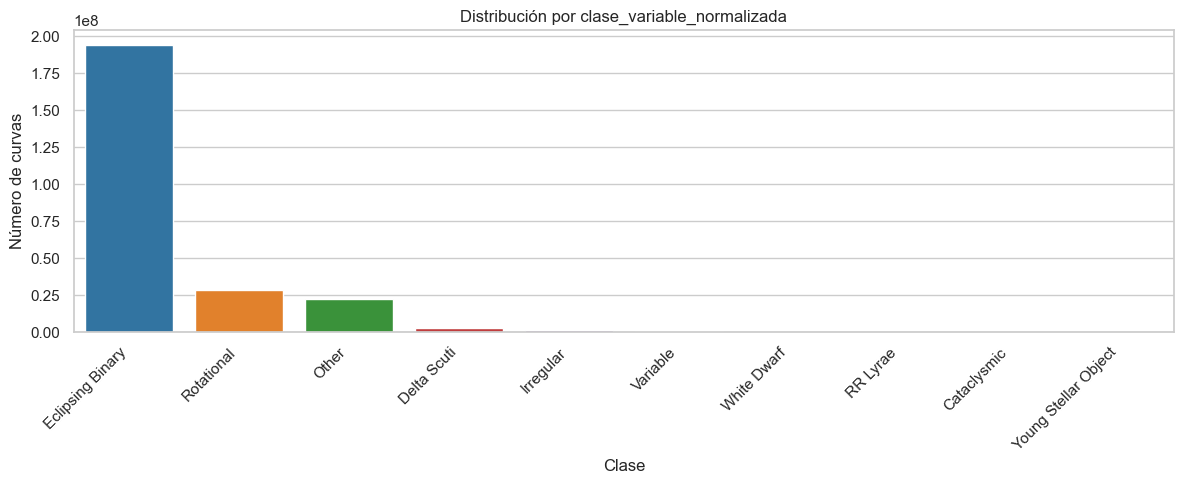


üõ∞Ô∏è Recuento por mision:
Tess      120747997
Kepler     71735011
TESS       41143597
K2         17895159


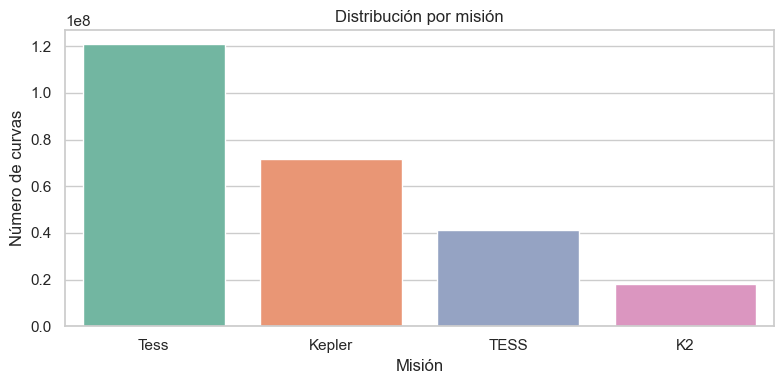


üìÅ Recuento por dataset fuente:
dataset_eb_tess_labeled_fixed.parquet      120747997
dataset_eb_kepler_labeled_fixed.parquet     71735011
dataset_vsx_tess_labeled_fixed.parquet      41143597
dataset_k2varcat_labeled_fixed.parquet      17895159


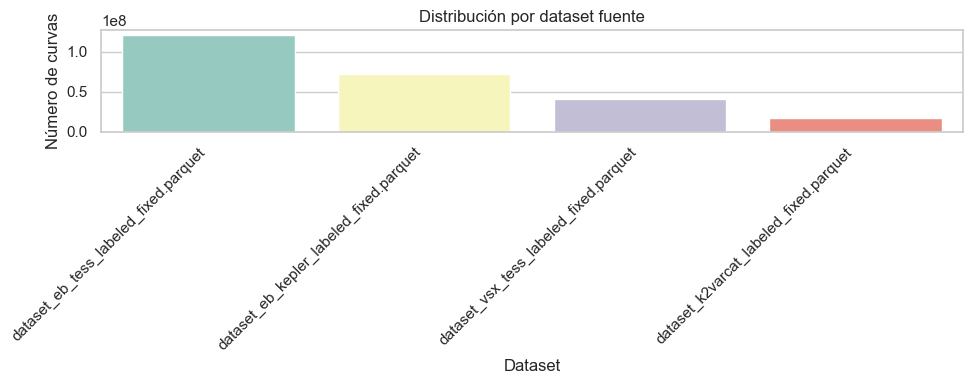

In [1]:
%pip install seaborn
%run src/script_7_validate_final_dataset.py


üîç Todo apunta a que la consolidaci√≥n y validaci√≥n han sido un √©xito:

#### ‚úÖ Validaci√≥n completada correctamente

* **251 millones de curvas de luz** consolidadas.
* **112 columnas unificadas**.
* Distribuci√≥n clara por clase, misi√≥n y dataset fuente.
* `id_objeto`, `tiempo`, `magnitud`, `mision`, `clase_variable_normalizada` ‚Üí **sin nulos**.
* `clase_variable` tiene \~468K nulos (esperado: son los casos etiquetados como `"UNKNOWN"` o `Other`).

#### üìä Distribuciones visuales

Los tres gr√°ficos reflejan:

1. **Desbalance evidente** de clases (habr√° que tratarlo en el modelo).
2. **Duplicidad aparente** en la columna `mision` (`Tess` vs `TESS`). 
3. Dataset `vsx_tess` y `k2varcat` aportan proporciones menores, pero valiosas.

Punto 2 se podr√≠a unificar antes de entrenar:

```python
df["mision"] = df["mision"].str.upper()
```

In [2]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np

dataset = ds.dataset("data/processed/all_missions_labeled.parquet", format="parquet")
scanner = dataset.scanner(columns=["id_objeto", "magnitud", "clase_variable_normalizada"])

curves_by_class = {}
invalid_counts = {}

for batch in scanner.to_batches():
    df = batch.to_pandas()
    for id_obj, group in df.groupby("id_objeto"):
        magnitudes = group["magnitud"].to_numpy()
        label = group["clase_variable_normalizada"].iloc[0]

        if label not in curves_by_class:
            curves_by_class[label] = 0
            invalid_counts[label] = 0

        if np.all(np.isnan(magnitudes)) or np.std(magnitudes) == 0:
            invalid_counts[label] += 1
            continue

        curves_by_class[label] += 1

curves_by_class = pd.Series(curves_by_class).sort_values(ascending=False)
invalid_counts = pd.Series(invalid_counts).sort_values(ascending=False)

print("‚úÖ Curvas v√°lidas por clase:")
print(curves_by_class)

print("\n‚ùå Curvas inv√°lidas por clase:")
print(invalid_counts)


c:\Users\hav3f\anaconda3\envs\astro_transformer\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\hav3f\anaconda3\envs\astro_transformer\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\hav3f\anaconda3\envs\astro_transformer\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\hav3f\anaconda3\envs\astro_transformer\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\hav3f\anaconda3\envs\astro_transformer\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: invalid value encountered in reduce
 

‚úÖ Curvas v√°lidas por clase:
Eclipsing Binary        19621
Other                    5142
Rotational               1390
Delta Scuti               121
Irregular                  61
Variable                   55
RR Lyrae                   23
Young Stellar Object       11
White Dwarf                 8
Cataclysmic                 5
dtype: int64

‚ùå Curvas inv√°lidas por clase:
Eclipsing Binary        0
Other                   0
Rotational              0
Irregular               0
Delta Scuti             0
Young Stellar Object    0
Variable                0
RR Lyrae                0
Cataclysmic             0
White Dwarf             0
dtype: int64


In [3]:
import pyarrow.dataset as ds

dataset = ds.dataset("data/processed/all_missions_labeled.parquet", format="parquet")
scanner = dataset.scanner(columns=["id_objeto"])
ids = set()
for batch in scanner.to_batches():
    df = batch.to_pandas()
    ids.update(df["id_objeto"].unique())

print(f"üßÆ Total de objetos √∫nicos en el .parquet: {len(ids):,}")


üßÆ Total de objetos √∫nicos en el .parquet: 13,415


‚úÖ Plan de acci√≥n recomendado:

üì¶ Buscar y procesar m√°s curvas de clases minoritarias
Revisamos fuentes que ya exploramos parcialmente, pero de las cuales a√∫n podemos extraer m√°s datos:

`dataset_gaia_dr3_vsx_tic_labeled.parquet`
‚Üí Tiene muchas etiquetas y clases minoritarias bien representadas, pero no curvas. Sin embargo, puede usarse para encontrar m√°s TIC IDs con clases relevantes, y luego intentar descargar curvas desde MAST (TESS).

`dataset_vsx_tic_labeled_clean.parquet`
‚Üí Ya est√° limpio y etiquetado, con muchos tic_id no descargados a√∫n. Se podr√≠a lanzar una nueva ronda de descarga desde TESS centrada solo en clases minoritarias.

`dataset_vsx_tess_labeled_clean.parquet`
‚Üí Ya contiene curvas, pero probablemente filtraste muchas clases. Opci√≥n: volver a inspeccionar este dataset y extrae solo las clases con pocos ejemplos para reforzar el conjunto.

Cat√°logos como ASAS-SN o ZTF
‚Üí Si da tiempo, puedes considerar integraciones r√°pidas desde esos cat√°logos, que est√°n bien etiquetados y contienen millones de curvas.

**Opptamos por la primera opci√≥n**: para ello necesitamos que en el cat√°logo GAIA DR3 tengamos coordenadas y as√≠ podamos descargar tambien esas curvas.

‚úÖ 1. **Antes solo inclu√≠amos curvas que ya ten√≠amos descargadas por misi√≥n (Kepler, K2, TESS)**

Lo que ten√≠amos en los `.parquet_fixed` eran datasets generados a partir de:

* Misiones espec√≠ficas con cat√°logos acotados (`K2VARCAT`, `VSX` con TESS, etc.).
* Solo los objetos para los que *ya se hab√≠a descargado la curva de luz y estaba disponible*.
* **No se prioriz√≥ la representatividad de clases.**

‚úÖ 2. Ahora estamos buscando expresamente **objetos de clases minoritarias con coordenadas confiables** y descargando curvas a demanda. Con el nuevo enfoque:

* **Ampliamos la diversidad de clases minoritarias** de forma expl√≠cita.
* El cruce con Gaia DR3 + VSX + TIC **nos da acceso a objetos que antes no hab√≠amos incluido** porque no estaban en los conjuntos principales, o no se hab√≠an descargado sus curvas.
* Solo mantenemos objetos con `ra`, `dec` y `tic_id`, y luego descargamos **por coordenadas si es necesario**, lo que **aumenta las posibilidades de encontrar curvas √∫tiles**.

‚úÖ 3. **Estamos limpiando, normalizando y controlando duplicados**

* Solo se incorporan objetos nuevos, √∫nicos (`drop_duplicates("id_objeto")`).
* Se descartan curvas inv√°lidas, cortas o con `NaN`.
* Las clases se normalizan para integrarse con el resto del dataset.

¬øAyudar√° eso al entrenamiento? A la hora de entrenar con el dataset "reforzado": 

* **Decidimos qu√© clases reforzar** si aplicamos `max_per_class`, `min_curves`, etc.
* **Se a√±ade la clase normalizada** y no una etiqueta dispersa.
* **Las curvas descargadas est√°n filtradas y limpias**.
* Al final tenemos un dataset unificado m√°s balanceado, m√°s representativo y m√°s coherente.

üö´ ¬øPodr√≠a pasar que al final tengamos pocos objetos √∫tiles nuevos? => S√≠, pero ahora **hemos maximizado las posibilidades**:

* Si no se encuentra m√°s, es porque **literalmente no hay m√°s curvas p√∫blicas disponibles con esas etiquetas y calidad m√≠nima.**

In [3]:
from pathlib import Path
import sys
import pandas as pd

GAIA_FILE = Path("data/processed/dataset_gaia_dr3_vsx_tic_labeled.parquet")
COORDS_FILE = Path("data/processed/dataset_vsx_tic_labeled_clean_fixed.parquet")
OUTPUT_FILE = Path("data/processed/dataset_gaia_dr3_vsx_tic_labeled_with_coords.parquet")

df_vsx = pd.read_parquet(COORDS_FILE, engine="pyarrow")
df_gaia = pd.read_parquet(GAIA_FILE, engine="pyarrow")

print("üîπ Columnas en VSX limpio (coordenadas):")
print(df_vsx.columns.tolist())
print("\nüîπ Columnas en GAIA DR3 (antes):")
print(df_gaia.columns.tolist())

# Asegurarse de que el directorio 'src' est√© en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.fase1.script_3d_merge_gaia_with_coords import main as merge_gaia_with_coords

merge_gaia_with_coords()

df_gaia2 = pd.read_parquet("data/processed/dataset_gaia_dr3_vsx_tic_labeled_with_coords.parquet", engine="pyarrow")
print("\nüîπ Columnas en GAIA DR3 (despues):")
print(df_gaia2.columns.tolist())


üîπ Columnas en VSX limpio (coordenadas):
['id_objeto', 'nombre_vsx', 'clase_variable', 'tic_id', 'origen_etiqueta', 'clase_variable_normalizada', 'ra', 'dec']

üîπ Columnas en GAIA DR3 (antes):
['solution_id', 'source_id', 'num_selected_g_fov', 'mean_obs_time_g_fov', 'time_duration_g_fov', 'min_mag_g_fov', 'max_mag_g_fov', 'mean_mag_g_fov', 'median_mag_g_fov', 'range_mag_g_fov', 'trimmed_range_mag_g_fov', 'std_dev_mag_g_fov', 'skewness_mag_g_fov', 'kurtosis_mag_g_fov', 'mad_mag_g_fov', 'abbe_mag_g_fov', 'iqr_mag_g_fov', 'stetson_mag_g_fov', 'std_dev_over_rms_err_mag_g_fov', 'outlier_median_g_fov', 'num_selected_bp', 'mean_obs_time_bp', 'time_duration_bp', 'min_mag_bp', 'max_mag_bp', 'mean_mag_bp', 'median_mag_bp', 'range_mag_bp', 'trimmed_range_mag_bp', 'std_dev_mag_bp', 'skewness_mag_bp', 'kurtosis_mag_bp', 'mad_mag_bp', 'abbe_mag_bp', 'iqr_mag_bp', 'stetson_mag_bp', 'std_dev_over_rms_err_mag_bp', 'outlier_median_bp', 'num_selected_rp', 'mean_obs_time_rp', 'time_duration_rp', 'min_

**Normalizacion de clases**:

In [ ]:
from src.fase1.script_3a_clean_vsx_classes import main as run_normalization
run_normalization()

üì• Leyendo: data/processed/dataset_gaia_dr3_vsx_tic_labeled_with_coords.parquet
üîß Normalizando clases...
üîé Clases √∫nicas encontradas: 33
üíæ Guardando dataset limpio en: data/processed/dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean.parquet
üìä Exportando resumen de clases...
‚úÖ Proceso completado


In [1]:
import warnings
import os, sys
import glob
from astropy.units import UnitsWarning
from pathlib import Path

# Ignorar warnings comunes de librer√≠as externas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UnitsWarning)
print("üîá Warnings silenciados: UserWarning, FutureWarning")
# Desactivar Rich para evitar problemas de compatibilidad
os.environ["RICH_NO_RICH"] = "1"

# Asegurarse de que el directorio 'src' est√© en el path de Python
src_path = Path("src").resolve()
if src_path not in sys.path:
    sys.path.append(str(src_path))
from src.fase1.script_3e_complement_gaia_curves import main as complement_gaia_curves

# Detectar entorno local/AWS y ejecutar el script
try:
    import sagemaker
    is_sagemaker = True
except ImportError:
    is_sagemaker = False

if is_sagemaker:
    print("üîÅ Ejecutando en SageMaker ‚Üí cat√°logo completo")
    complement_gaia_curves(limit=None, workers=8)
else:
    print("üíª Ejecutando en entorno local ‚Üí cat√°logo completo")
    complement_gaia_curves(limit=None, workers=10)

üîá Warnings silenciados: UserWarning, FutureWarning
üíª Ejecutando en entorno local ‚Üí cat√°logo completo
üì• Cargando dataset: data\processed\dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean.parquet
üöÄ Iniciando procesamiento paralelo con Pool...


  0%|          | 1/3987 [00:40<44:58:33, 40.62s/it]

‚ùå 1: TIC 611089486 ‚Üí Sin resultados (None)
‚ùå 2: TIC 611117919 ‚Üí Sin resultados (None)
‚úÖ 3: TIC 401396570 ‚Üí 19478 puntos


  0%|          | 4/3987 [00:43<8:22:44,  7.57s/it] 

‚úÖ 4: TIC 408508257 ‚Üí 17186 puntos


  0%|          | 5/3987 [00:48<7:39:08,  6.92s/it]

‚ùå 5: TIC 520936760 ‚Üí Sin resultados (None)


  0%|          | 6/3987 [00:50<5:41:59,  5.15s/it]

‚ùå 6: TIC 611096930 ‚Üí Sin resultados (None)


  0%|          | 7/3987 [00:50<4:02:33,  3.66s/it]

‚ùå 7: TIC 293282381 ‚Üí Sin resultados (None)
‚ùå 8: TIC 405272902 ‚Üí Sin resultados (None)
‚ùå 9: TIC 408503945 ‚Üí Sin resultados (None)


  0%|          | 10/3987 [00:51<1:51:42,  1.69s/it]

‚úÖ 10: TIC 408503779 ‚Üí 17258 puntos


  0%|          | 11/3987 [00:52<1:42:38,  1.55s/it]

‚ùå 11: TIC 408503665 ‚Üí Sin resultados (None)
‚ùå 12: TIC 611119043 ‚Üí Sin resultados (None)


  0%|          | 13/3987 [00:54<1:37:13,  1.47s/it]

‚ùå 13: TIC 408503811 ‚Üí Sin resultados (None)


  0%|          | 14/3987 [00:57<1:56:44,  1.76s/it]

‚ùå 14: TIC 408504000 ‚Üí Sin resultados (None)


  0%|          | 15/3987 [00:58<1:47:13,  1.62s/it]

‚úÖ 15: TIC 408503973 ‚Üí 24926 puntos


  0%|          | 16/3987 [00:59<1:29:01,  1.35s/it]

‚ùå 16: TIC 408503687 ‚Üí Sin resultados (None)


  0%|          | 17/3987 [01:01<1:36:33,  1.46s/it]

‚ùå 17: TIC 408504061 ‚Üí Sin resultados (None)
‚úÖ 18: TIC 257486498 ‚Üí 10671 puntos


  0%|          | 19/3987 [01:03<1:31:54,  1.39s/it]

‚ùå 19: TIC 418735190 ‚Üí Sin resultados (None)


  1%|          | 20/3987 [01:03<1:11:41,  1.08s/it]

‚ùå 20: TIC 418735320 ‚Üí Sin resultados (None)


  1%|          | 21/3987 [01:04<57:40,  1.15it/s]  

‚ùå 21: TIC 418735477 ‚Üí Sin resultados (None)


  1%|          | 22/3987 [01:05<1:05:03,  1.02it/s]

‚ùå 22: TIC 418735227 ‚Üí Sin resultados (None)


  1%|          | 23/3987 [01:06<1:07:42,  1.02s/it]

‚úÖ 23: TIC 418735269 ‚Üí 11102 puntos
‚úÖ 24: TIC 418735229 ‚Üí 11082 puntos


  1%|          | 25/3987 [01:08<59:29,  1.11it/s]  

‚ùå 25: TIC 418735181 ‚Üí Sin resultados (None)


  1%|          | 26/3987 [01:09<1:06:01,  1.00s/it]

‚úÖ 26: TIC 418735372 ‚Üí 11083 puntos


  1%|          | 27/3987 [01:10<58:45,  1.12it/s]  

‚ùå 27: TIC 405251216 ‚Üí Sin resultados (None)
‚úÖ 28: TIC 418735437 ‚Üí 22714 puntos


  1%|          | 29/3987 [01:13<1:26:13,  1.31s/it]

‚úÖ 29: TIC 405251443 ‚Üí 13895 puntos


  1%|          | 30/3987 [01:14<1:25:40,  1.30s/it]

‚úÖ 30: TIC 405251352 ‚Üí 16136 puntos


  1%|          | 31/3987 [01:15<1:19:03,  1.20s/it]

‚úÖ 31: TIC 405251490 ‚Üí 13956 puntos


  1%|          | 32/3987 [01:16<1:08:45,  1.04s/it]

‚ùå 32: TIC 405251232 ‚Üí Sin resultados (None)


  1%|          | 33/3987 [01:18<1:27:14,  1.32s/it]

‚ùå 33: TIC 408505989 ‚Üí Sin resultados (None)


  1%|          | 34/3987 [01:18<1:09:29,  1.05s/it]

‚ùå 34: TIC 408505996 ‚Üí Sin resultados (None)


  1%|          | 35/3987 [01:19<57:24,  1.15it/s]  

‚ùå 35: TIC 408506012 ‚Üí Sin resultados (None)


  1%|          | 36/3987 [01:19<49:21,  1.33it/s]

‚úÖ 36: TIC 403021914 ‚Üí 24958 puntos


  1%|          | 37/3987 [01:22<1:23:54,  1.27s/it]

‚úÖ 37: TIC 403021880 ‚Üí 13881 puntos


  1%|          | 38/3987 [01:23<1:19:08,  1.20s/it]

‚ùå 38: TIC 403021712 ‚Üí Sin resultados (None)


  1%|          | 39/3987 [01:24<1:28:49,  1.35s/it]

‚ùå 39: TIC 403021854 ‚Üí Sin resultados (None)


  1%|          | 40/3987 [01:25<1:12:07,  1.10s/it]

‚ùå 40: TIC 405251322 ‚Üí Sin resultados (None)
‚úÖ 41: TIC 403021917 ‚Üí 24926 puntos


  1%|          | 42/3987 [01:26<48:36,  1.35it/s]  

‚úÖ 42: TIC 405268184 ‚Üí 24934 puntos


  1%|          | 43/3987 [01:26<51:11,  1.28it/s]

‚úÖ 43: TIC 405268090 ‚Üí 11102 puntos


  1%|          | 44/3987 [01:30<1:40:42,  1.53s/it]

‚ùå 44: TIC 257503074 ‚Üí Sin resultados (None)


  1%|          | 45/3987 [01:33<2:16:35,  2.08s/it]

‚ùå 45: TIC 405268041 ‚Üí Sin resultados (None)


  1%|          | 46/3987 [01:34<1:45:22,  1.60s/it]

‚ùå 46: TIC 405268372 ‚Üí Sin resultados (None)


  1%|          | 47/3987 [01:34<1:19:46,  1.21s/it]

‚ùå 47: TIC 405270157 ‚Üí Sin resultados (None)


  1%|          | 49/3987 [01:35<53:11,  1.23it/s]  

‚ùå 48: TIC 405270068 ‚Üí Sin resultados (None)
‚ùå 49: TIC 405270398 ‚Üí Sin resultados (None)


  1%|‚ñè         | 50/3987 [01:35<48:07,  1.36it/s]

‚ùå 50: TIC 405270119 ‚Üí Sin resultados (None)


  1%|‚ñè         | 51/3987 [01:37<1:00:56,  1.08it/s]

‚ùå 51: TIC 405251305 ‚Üí Sin resultados (None)


  1%|‚ñè         | 52/3987 [01:39<1:27:48,  1.34s/it]

‚ùå 52: TIC 405270030 ‚Üí Sin resultados (None)


  1%|‚ñè         | 53/3987 [01:42<1:53:30,  1.73s/it]

‚úÖ 53: TIC 403021985 ‚Üí 11090 puntos
‚ùå 54: TIC 403021896 ‚Üí Sin resultados (None)


  1%|‚ñè         | 55/3987 [01:42<1:07:36,  1.03s/it]

‚úÖ 55: TIC 403021964 ‚Üí 24965 puntos


  1%|‚ñè         | 56/3987 [01:42<55:52,  1.17it/s]  

‚ùå 56: TIC 403021760 ‚Üí Sin resultados (None)


  1%|‚ñè         | 57/3987 [01:46<1:37:22,  1.49s/it]

‚ùå 57: TIC 405270049 ‚Üí Sin resultados (None)


  1%|‚ñè         | 59/3987 [01:47<1:08:45,  1.05s/it]

‚ùå 58: TIC 257523557 ‚Üí Sin resultados (None)
‚ùå 59: TIC 405272678 ‚Üí Sin resultados (None)


  2%|‚ñè         | 60/3987 [01:48<1:08:08,  1.04s/it]

‚ùå 60: TIC 405272631 ‚Üí Sin resultados (None)


  2%|‚ñè         | 61/3987 [01:49<58:14,  1.12it/s]  

‚ùå 61: TIC 611095808 ‚Üí Sin resultados (None)


  2%|‚ñè         | 62/3987 [01:51<1:18:51,  1.21s/it]

‚ùå 62: TIC 405272776 ‚Üí Sin resultados (None)


  2%|‚ñè         | 63/3987 [01:51<1:10:21,  1.08s/it]

‚ùå 63: TIC 405270576 ‚Üí Sin resultados (None)
‚úÖ 64: TIC 405270325 ‚Üí 22820 puntos


  2%|‚ñè         | 65/3987 [01:52<44:30,  1.47it/s]  

‚úÖ 65: TIC 405272867 ‚Üí 24969 puntos
‚úÖ 66: TIC 405272581 ‚Üí 30994 puntos


  2%|‚ñè         | 67/3987 [01:55<1:16:32,  1.17s/it]

‚ùå 67: TIC 405291701 ‚Üí Sin resultados (None)


  2%|‚ñè         | 68/3987 [01:58<1:42:54,  1.58s/it]

‚úÖ 68: TIC 405272638 ‚Üí 17179 puntos


  2%|‚ñè         | 69/3987 [01:58<1:24:44,  1.30s/it]

‚úÖ 69: TIC 405272865 ‚Üí 13935 puntos


  2%|‚ñè         | 70/3987 [02:00<1:19:55,  1.22s/it]

‚úÖ 70: TIC 405273011 ‚Üí 13957 puntos


  2%|‚ñè         | 71/3987 [02:00<58:31,  1.12it/s]  

‚ùå 71: TIC 405291688 ‚Üí Sin resultados (None)


  2%|‚ñè         | 72/3987 [02:00<49:03,  1.33it/s]

‚ùå 72: TIC 405291670 ‚Üí Sin resultados (None)
‚úÖ 73: TIC 405291817 ‚Üí 24864 puntos


  2%|‚ñè         | 74/3987 [02:02<50:37,  1.29it/s]

‚ùå 74: TIC 403022201 ‚Üí Sin resultados (None)
‚úÖ 75: TIC 405273043 ‚Üí 22721 puntos


  2%|‚ñè         | 76/3987 [02:04<1:09:26,  1.07s/it]

‚ùå 76: TIC 403022090 ‚Üí Sin resultados (None)


  2%|‚ñè         | 77/3987 [02:07<1:56:24,  1.79s/it]

‚ùå 77: TIC 403022162 ‚Üí Sin resultados (None)
‚úÖ 78: TIC 405291574 ‚Üí 31017 puntos


  2%|‚ñè         | 79/3987 [02:09<1:22:39,  1.27s/it]

‚ùå 79: TIC 403022289 ‚Üí Sin resultados (None)


  2%|‚ñè         | 80/3987 [02:09<1:04:43,  1.01it/s]

‚ùå 80: TIC 611094751 ‚Üí Sin resultados (None)


  2%|‚ñè         | 81/3987 [02:10<54:03,  1.20it/s]  

‚úÖ 81: TIC 403024257 ‚Üí 24924 puntos


  2%|‚ñè         | 82/3987 [02:10<42:50,  1.52it/s]

‚ùå 82: TIC 403024075 ‚Üí Sin resultados (None)


  2%|‚ñè         | 83/3987 [02:11<56:15,  1.16it/s]

‚ùå 83: TIC 403024215 ‚Üí Sin resultados (None)


  2%|‚ñè         | 84/3987 [02:12<47:30,  1.37it/s]

‚úÖ 84: TIC 403024239 ‚Üí 24867 puntos


  2%|‚ñè         | 85/3987 [02:14<1:24:56,  1.31s/it]

‚ùå 85: TIC 403024233 ‚Üí Sin resultados (None)


  2%|‚ñè         | 86/3987 [02:17<1:48:41,  1.67s/it]

‚úÖ 86: TIC 403024032 ‚Üí 30972 puntos


  2%|‚ñè         | 87/3987 [02:17<1:25:34,  1.32s/it]

‚ùå 87: TIC 403024619 ‚Üí Sin resultados (None)


  2%|‚ñè         | 88/3987 [02:19<1:27:48,  1.35s/it]

‚ùå 88: TIC 403024553 ‚Üí Sin resultados (None)
‚úÖ 89: TIC 405186394 ‚Üí 30914 puntos


  2%|‚ñè         | 90/3987 [02:20<59:24,  1.09it/s]  

‚ùå 90: TIC 403024346 ‚Üí Sin resultados (None)


  2%|‚ñè         | 91/3987 [02:21<1:02:19,  1.04it/s]

‚ùå 91: TIC 418756096 ‚Üí Sin resultados (None)
‚úÖ 92: TIC 418756021 ‚Üí 130174 puntos


  2%|‚ñè         | 93/3987 [02:22<53:03,  1.22it/s]  

‚ùå 93: TIC 405187715 ‚Üí Sin resultados (None)


  2%|‚ñè         | 94/3987 [02:23<54:41,  1.19it/s]

‚ùå 94: TIC 611097538 ‚Üí Sin resultados (None)


  2%|‚ñè         | 95/3987 [02:25<1:23:39,  1.29s/it]

‚úÖ 95: TIC 403024093 ‚Üí 31007 puntos


  2%|‚ñè         | 96/3987 [02:26<1:03:37,  1.02it/s]

‚ùå 96: TIC 403023990 ‚Üí Sin resultados (None)
‚úÖ 97: TIC 405187645 ‚Üí 22233 puntos


  2%|‚ñè         | 98/3987 [02:27<49:24,  1.31it/s]  

‚úÖ 98: TIC 405187699 ‚Üí 22252 puntos


  2%|‚ñè         | 99/3987 [02:30<1:43:33,  1.60s/it]

‚úÖ 99: TIC 418756065 ‚Üí 26014 puntos


  3%|‚ñé         | 100/3987 [02:31<1:28:13,  1.36s/it]

‚ùå 100: TIC 418756058 ‚Üí Sin resultados (None)
‚úÖ 101: TIC 405187450 ‚Üí 17253 puntos


  3%|‚ñé         | 102/3987 [02:34<1:44:14,  1.61s/it]

‚úÖ 102: TIC 405187705 ‚Üí 17238 puntos


  3%|‚ñé         | 103/3987 [02:35<1:31:27,  1.41s/it]

‚úÖ 103: TIC 405187419 ‚Üí 26218 puntos


  3%|‚ñé         | 104/3987 [02:35<1:06:42,  1.03s/it]

‚ùå 104: TIC 405293567 ‚Üí Sin resultados (None)


  3%|‚ñé         | 105/3987 [02:37<1:12:12,  1.12s/it]

‚ùå 105: TIC 405187572 ‚Üí Sin resultados (None)


  3%|‚ñé         | 106/3987 [02:38<1:23:12,  1.29s/it]

‚ùå 106: TIC 405293620 ‚Üí Sin resultados (None)


  3%|‚ñé         | 107/3987 [02:41<1:50:25,  1.71s/it]

‚ùå 107: TIC 405293728 ‚Üí Sin resultados (None)


  3%|‚ñé         | 108/3987 [02:42<1:32:29,  1.43s/it]

‚ùå 108: TIC 405303737 ‚Üí Sin resultados (None)


  3%|‚ñé         | 109/3987 [02:43<1:22:28,  1.28s/it]

‚úÖ 109: TIC 611096808 ‚Üí 17279 puntos
‚ùå 110: TIC 405304055 ‚Üí Sin resultados (None)


  3%|‚ñé         | 111/3987 [02:43<48:40,  1.33it/s]  

‚ùå 111: TIC 405303778 ‚Üí Sin resultados (None)


  3%|‚ñé         | 112/3987 [02:46<1:18:41,  1.22s/it]

‚ùå 112: TIC 405303921 ‚Üí Sin resultados (None)


  3%|‚ñé         | 113/3987 [02:47<1:17:44,  1.20s/it]

‚ùå 113: TIC 405304060 ‚Üí Sin resultados (None)


  3%|‚ñé         | 114/3987 [02:47<1:00:36,  1.06it/s]

‚ùå 114: TIC 405304054 ‚Üí Sin resultados (None)


  3%|‚ñé         | 115/3987 [02:48<52:01,  1.24it/s]  

‚ùå 115: TIC 418756172 ‚Üí Sin resultados (None)


  3%|‚ñé         | 116/3987 [02:51<1:46:37,  1.65s/it]

‚úÖ 116: TIC 397586672 ‚Üí 17290 puntos


  3%|‚ñé         | 117/3987 [02:53<1:51:39,  1.73s/it]

‚ùå 117: TIC 397586593 ‚Üí Sin resultados (None)
‚ùå 118: TIC 397586728 ‚Üí Sin resultados (None)


  3%|‚ñé         | 119/3987 [02:56<1:43:48,  1.61s/it]

‚ùå 119: TIC 272125616 ‚Üí Sin resultados (None)


  3%|‚ñé         | 120/3987 [02:57<1:37:58,  1.52s/it]

‚úÖ 120: TIC 405304972 ‚Üí 30846 puntos


  3%|‚ñé         | 121/3987 [02:58<1:16:10,  1.18s/it]

‚úÖ 121: TIC 397586787 ‚Üí 17228 puntos
‚ùå 122: TIC 405333300 ‚Üí Sin resultados (None)
‚ùå 123: TIC 405305260 ‚Üí Sin resultados (None)
‚úÖ 124: TIC 405333432 ‚Üí 24870 puntos


  3%|‚ñé         | 124/3987 [03:00<1:05:23,  1.02s/it]

‚ùå 125: TIC 611147061 ‚Üí Sin resultados (None)


  3%|‚ñé         | 126/3987 [03:01<55:01,  1.17it/s]  

‚ùå 126: TIC 403026404 ‚Üí Sin resultados (None)
‚ùå 127: TIC 403026131 ‚Üí Sin resultados (None)


  3%|‚ñé         | 128/3987 [03:02<48:05,  1.34it/s]

‚ùå 128: TIC 403026413 ‚Üí Sin resultados (None)


  3%|‚ñé         | 129/3987 [03:04<53:42,  1.20it/s]

‚úÖ 129: TIC 403026267 ‚Üí 24870 puntos
‚úÖ 130: TIC 408506195 ‚Üí 22250 puntos


  3%|‚ñé         | 131/3987 [03:08<1:27:27,  1.36s/it]

‚úÖ 131: TIC 408506320 ‚Üí 31018 puntos


  3%|‚ñé         | 132/3987 [03:08<1:12:28,  1.13s/it]

‚úÖ 132: TIC 408506090 ‚Üí 26228 puntos
‚ùå 133: TIC 408506137 ‚Üí Sin resultados (None)


  3%|‚ñé         | 134/3987 [03:09<51:12,  1.25it/s]  

‚ùå 134: TIC 405188151 ‚Üí Sin resultados (None)
‚úÖ 135: TIC 405187986 ‚Üí 17251 puntos


  3%|‚ñé         | 136/3987 [03:10<46:01,  1.39it/s]

‚úÖ 136: TIC 405187959 ‚Üí 17216 puntos


  3%|‚ñé         | 137/3987 [03:12<1:14:12,  1.16s/it]

‚ùå 137: TIC 408508046 ‚Üí Sin resultados (None)
‚úÖ 138: TIC 405187909 ‚Üí 31050 puntos


  3%|‚ñé         | 139/3987 [03:15<1:12:47,  1.14s/it]

‚úÖ 139: TIC 405187846 ‚Üí 22257 puntos


  4%|‚ñé         | 140/3987 [03:17<1:25:26,  1.33s/it]

‚ùå 140: TIC 408508033 ‚Üí Sin resultados (None)
‚úÖ 141: TIC 408507897 ‚Üí 37136 puntos


  4%|‚ñé         | 142/3987 [03:19<1:23:00,  1.30s/it]

‚ùå 142: TIC 408507940 ‚Üí Sin resultados (None)


  4%|‚ñé         | 143/3987 [03:20<1:07:51,  1.06s/it]

‚ùå 143: TIC 408507909 ‚Üí Sin resultados (None)


  4%|‚ñé         | 144/3987 [03:20<54:43,  1.17it/s]  

‚ùå 144: TIC 405189825 ‚Üí Sin resultados (None)


  4%|‚ñé         | 145/3987 [03:21<55:08,  1.16it/s]

‚ùå 145: TIC 405189886 ‚Üí Sin resultados (None)


  4%|‚ñé         | 146/3987 [03:22<54:39,  1.17it/s]

‚ùå 146: TIC 405190310 ‚Üí Sin resultados (None)


  4%|‚ñé         | 147/3987 [03:23<1:00:48,  1.05it/s]

‚ùå 147: TIC 405190364 ‚Üí Sin resultados (None)


  4%|‚ñé         | 148/3987 [03:28<2:16:28,  2.13s/it]

‚úÖ 148: TIC 405190368 ‚Üí 17207 puntos


  4%|‚ñé         | 149/3987 [03:28<1:39:46,  1.56s/it]

‚úÖ 149: TIC 405190394 ‚Üí 17258 puntos
‚ùå 150: TIC 405190215 ‚Üí Sin resultados (None)
‚úÖ 151: TIC 405190447 ‚Üí 30820 puntos


  4%|‚ñç         | 151/3987 [03:29<59:34,  1.07it/s]  

‚úÖ 152: TIC 418754064 ‚Üí 17220 puntos


  4%|‚ñç         | 153/3987 [03:30<55:55,  1.14it/s]

‚ùå 153: TIC 418754208 ‚Üí Sin resultados (None)


  4%|‚ñç         | 154/3987 [03:32<1:08:20,  1.07s/it]

‚ùå 154: TIC 418754100 ‚Üí Sin resultados (None)


  4%|‚ñç         | 155/3987 [03:33<1:09:37,  1.09s/it]

‚úÖ 155: TIC 418754099 ‚Üí 17316 puntos


  4%|‚ñç         | 156/3987 [03:34<1:05:17,  1.02s/it]

‚ùå 156: TIC 418753938 ‚Üí Sin resultados (None)


  4%|‚ñç         | 157/3987 [03:34<54:55,  1.16it/s]  

‚ùå 157: TIC 293282391 ‚Üí Sin resultados (None)


  4%|‚ñç         | 158/3987 [03:35<1:01:41,  1.03it/s]

‚úÖ 158: TIC 293285072 ‚Üí 17262 puntos


  4%|‚ñç         | 159/3987 [03:37<1:18:52,  1.24s/it]

‚úÖ 159: TIC 293285080 ‚Üí 17292 puntos


  4%|‚ñç         | 160/3987 [03:41<2:15:30,  2.12s/it]

‚ùå 160: TIC 405251538 ‚Üí Sin resultados (None)


  4%|‚ñç         | 161/3987 [03:42<1:49:27,  1.72s/it]

‚ùå 161: TIC 293285063 ‚Üí Sin resultados (None)


  4%|‚ñç         | 162/3987 [03:43<1:25:27,  1.34s/it]

‚ùå 162: TIC 293285069 ‚Üí Sin resultados (None)


  4%|‚ñç         | 163/3987 [03:43<1:12:46,  1.14s/it]

‚ùå 163: TIC 408505937 ‚Üí Sin resultados (None)
‚ùå 164: TIC 408505859 ‚Üí Sin resultados (None)


  4%|‚ñç         | 165/3987 [03:44<43:38,  1.46it/s]  

‚ùå 165: TIC 408505961 ‚Üí Sin resultados (None)


  4%|‚ñç         | 166/3987 [03:44<36:50,  1.73it/s]

‚ùå 166: TIC 405267700 ‚Üí Sin resultados (None)


  4%|‚ñç         | 167/3987 [03:44<37:20,  1.71it/s]

‚ùå 167: TIC 405267759 ‚Üí Sin resultados (None)


  4%|‚ñç         | 168/3987 [03:47<1:13:28,  1.15s/it]

‚ùå 168: TIC 405267598 ‚Üí Sin resultados (None)


  4%|‚ñç         | 169/3987 [03:48<1:11:52,  1.13s/it]

‚úÖ 169: TIC 405267685 ‚Üí 13953 puntos


  4%|‚ñç         | 170/3987 [03:50<1:17:32,  1.22s/it]

‚úÖ 170: TIC 405267706 ‚Üí 24870 puntos


  4%|‚ñç         | 171/3987 [03:54<2:13:19,  2.10s/it]

‚ùå 171: TIC 405270811 ‚Üí Sin resultados (None)


  4%|‚ñç         | 172/3987 [03:55<1:46:43,  1.68s/it]

‚ùå 172: TIC 405270595 ‚Üí Sin resultados (None)


  4%|‚ñç         | 173/3987 [03:55<1:26:32,  1.36s/it]

‚úÖ 173: TIC 405270553 ‚Üí 24870 puntos


  4%|‚ñç         | 174/3987 [03:56<1:17:44,  1.22s/it]

‚ùå 174: TIC 405270736 ‚Üí Sin resultados (None)


  4%|‚ñç         | 175/3987 [03:59<1:53:56,  1.79s/it]

‚úÖ 175: TIC 405270831 ‚Üí 22222 puntos


  4%|‚ñç         | 176/3987 [04:00<1:35:48,  1.51s/it]

‚úÖ 176: TIC 403022261 ‚Üí 24905 puntos


  4%|‚ñç         | 177/3987 [04:01<1:18:20,  1.23s/it]

‚úÖ 177: TIC 405186503 ‚Üí 17186 puntos


  4%|‚ñç         | 179/3987 [04:03<1:04:53,  1.02s/it]

‚ùå 178: TIC 405186527 ‚Üí Sin resultados (None)
‚ùå 179: TIC 405186660 ‚Üí Sin resultados (None)


  5%|‚ñç         | 180/3987 [04:04<1:04:54,  1.02s/it]

‚úÖ 180: TIC 405186543 ‚Üí 26226 puntos


  5%|‚ñç         | 181/3987 [04:07<1:42:49,  1.62s/it]

‚ùå 181: TIC 405186549 ‚Üí Sin resultados (None)


  5%|‚ñç         | 182/3987 [04:08<1:30:19,  1.42s/it]

‚ùå 182: TIC 405186666 ‚Üí Sin resultados (None)


  5%|‚ñç         | 183/3987 [04:08<1:17:39,  1.22s/it]

‚ùå 183: TIC 405186541 ‚Üí Sin resultados (None)


  5%|‚ñç         | 185/3987 [04:11<1:08:22,  1.08s/it]

‚ùå 184: TIC 405293540 ‚Üí Sin resultados (None)
‚ùå 185: TIC 405303949 ‚Üí Sin resultados (None)


  5%|‚ñç         | 186/3987 [04:13<1:32:46,  1.46s/it]

‚ùå 186: TIC 405303836 ‚Üí Sin resultados (None)


  5%|‚ñç         | 187/3987 [04:14<1:16:14,  1.20s/it]

‚ùå 187: TIC 405303979 ‚Üí Sin resultados (None)


  5%|‚ñç         | 188/3987 [04:16<1:38:30,  1.56s/it]

‚úÖ 188: TIC 405303987 ‚Üí 30938 puntos


  5%|‚ñç         | 189/3987 [04:16<1:18:30,  1.24s/it]

‚ùå 189: TIC 418756397 ‚Üí Sin resultados (None)


  5%|‚ñç         | 190/3987 [04:17<1:08:50,  1.09s/it]

‚úÖ 190: TIC 418756182 ‚Üí 30961 puntos


  5%|‚ñç         | 191/3987 [04:17<54:45,  1.16it/s]  

‚úÖ 191: TIC 401421618 ‚Üí 30912 puntos


  5%|‚ñç         | 192/3987 [04:18<43:17,  1.46it/s]

‚ùå 192: TIC 401421892 ‚Üí Sin resultados (None)


  5%|‚ñç         | 193/3987 [04:18<36:37,  1.73it/s]

‚ùå 193: TIC 401421639 ‚Üí Sin resultados (None)


  5%|‚ñç         | 194/3987 [04:23<1:51:13,  1.76s/it]

‚ùå 194: TIC 401421868 ‚Üí Sin resultados (None)
‚úÖ 195: TIC 405333468 ‚Üí 19451 puntos


  5%|‚ñç         | 196/3987 [04:23<1:02:14,  1.02it/s]

‚ùå 196: TIC 405333560 ‚Üí Sin resultados (None)


  5%|‚ñç         | 198/3987 [04:25<56:25,  1.12it/s]  

‚ùå 197: TIC 405333555 ‚Üí Sin resultados (None)
‚ùå 198: TIC 403026346 ‚Üí Sin resultados (None)


  5%|‚ñç         | 199/3987 [04:26<1:01:05,  1.03it/s]

‚úÖ 199: TIC 403026300 ‚Üí 17297 puntos


  5%|‚ñå         | 200/3987 [04:28<1:12:39,  1.15s/it]

‚ùå 200: TIC 403026298 ‚Üí Sin resultados (None)


  5%|‚ñå         | 201/3987 [04:29<1:09:23,  1.10s/it]

‚úÖ 201: TIC 405187905 ‚Üí 17347 puntos


  5%|‚ñå         | 202/3987 [04:31<1:26:49,  1.38s/it]

‚ùå 202: TIC 405188065 ‚Üí Sin resultados (None)


  5%|‚ñå         | 203/3987 [04:32<1:31:37,  1.45s/it]

‚úÖ 203: TIC 405209847 ‚Üí 30764 puntos
‚úÖ 204: TIC 405210034 ‚Üí 30804 puntos


  5%|‚ñå         | 205/3987 [04:34<1:06:29,  1.05s/it]

‚ùå 205: TIC 405210062 ‚Üí Sin resultados (None)


  5%|‚ñå         | 206/3987 [04:34<56:35,  1.11it/s]  

‚ùå 206: TIC 405209757 ‚Üí Sin resultados (None)


  5%|‚ñå         | 207/3987 [04:35<48:41,  1.29it/s]

‚úÖ 207: TIC 405209794 ‚Üí 17184 puntos


  5%|‚ñå         | 208/3987 [04:35<38:07,  1.65it/s]

‚úÖ 208: TIC 405210101 ‚Üí 17184 puntos


  5%|‚ñå         | 209/3987 [04:37<1:03:49,  1.01s/it]

‚ùå 209: TIC 405209703 ‚Üí Sin resultados (None)
‚úÖ 210: TIC 418754109 ‚Üí 24836 puntos


  5%|‚ñå         | 211/3987 [04:39<1:17:15,  1.23s/it]

‚úÖ 211: TIC 418753975 ‚Üí 17248 puntos


  5%|‚ñå         | 212/3987 [04:41<1:22:27,  1.31s/it]

‚ùå 212: TIC 418754198 ‚Üí Sin resultados (None)


  5%|‚ñå         | 213/3987 [04:42<1:12:05,  1.15s/it]

‚ùå 213: TIC 405210144 ‚Üí Sin resultados (None)


  5%|‚ñå         | 214/3987 [04:44<1:26:11,  1.37s/it]

‚úÖ 214: TIC 418754226 ‚Üí 17315 puntos


  5%|‚ñå         | 215/3987 [04:44<1:04:36,  1.03s/it]

‚ùå 215: TIC 405210302 ‚Üí Sin resultados (None)


  5%|‚ñå         | 216/3987 [04:45<1:06:52,  1.06s/it]

‚ùå 216: TIC 405210449 ‚Üí Sin resultados (None)


  5%|‚ñå         | 217/3987 [04:46<1:13:10,  1.16s/it]

‚ùå 217: TIC 405210193 ‚Üí Sin resultados (None)


  5%|‚ñå         | 218/3987 [04:47<1:01:27,  1.02it/s]

‚ùå 218: TIC 405212552 ‚Üí Sin resultados (None)


  5%|‚ñå         | 219/3987 [04:48<1:10:06,  1.12s/it]

‚ùå 219: TIC 405293560 ‚Üí Sin resultados (None)
‚úÖ 220: TIC 405210192 ‚Üí 274830 puntos


  6%|‚ñå         | 221/3987 [04:50<1:00:39,  1.03it/s]

‚úÖ 221: TIC 405188030 ‚Üí 17268 puntos
‚ùå 222: TIC 418753672 ‚Üí Sin resultados (None)


  6%|‚ñå         | 223/3987 [04:51<38:12,  1.64it/s]  

‚ùå 223: TIC 405210348 ‚Üí Sin resultados (None)


  6%|‚ñå         | 224/3987 [04:53<1:03:15,  1.01s/it]

‚ùå 224: TIC 405212419 ‚Üí Sin resultados (None)


  6%|‚ñå         | 225/3987 [04:55<1:18:08,  1.25s/it]

‚úÖ 225: TIC 405212371 ‚Üí 17265 puntos


  6%|‚ñå         | 226/3987 [04:56<1:22:11,  1.31s/it]

‚ùå 226: TIC 405212511 ‚Üí Sin resultados (None)


  6%|‚ñå         | 227/3987 [04:57<1:14:28,  1.19s/it]

‚úÖ 227: TIC 405213011 ‚Üí 19430 puntos


  6%|‚ñå         | 229/3987 [05:00<1:16:08,  1.22s/it]

‚ùå 228: TIC 405213014 ‚Üí Sin resultados (None)
‚ùå 229: TIC 405212567 ‚Üí Sin resultados (None)


  6%|‚ñå         | 230/3987 [05:01<1:09:21,  1.11s/it]

‚ùå 230: TIC 405212739 ‚Üí Sin resultados (None)


  6%|‚ñå         | 231/3987 [05:02<1:09:50,  1.12s/it]

‚ùå 231: TIC 405213117 ‚Üí Sin resultados (None)
‚ùå 232: TIC 405212840 ‚Üí Sin resultados (None)


  6%|‚ñå         | 233/3987 [05:03<52:34,  1.19it/s]  

‚úÖ 233: TIC 405212787 ‚Üí 30872 puntos
‚ùå 234: TIC 405213004 ‚Üí Sin resultados (None)


  6%|‚ñå         | 235/3987 [05:03<37:02,  1.69it/s]

‚ùå 235: TIC 397589459 ‚Üí Sin resultados (None)


  6%|‚ñå         | 236/3987 [05:04<40:15,  1.55it/s]

‚úÖ 236: TIC 397589275 ‚Üí 17207 puntos


  6%|‚ñå         | 237/3987 [05:10<1:50:43,  1.77s/it]

‚úÖ 237: TIC 397589301 ‚Üí 37313 puntos


  6%|‚ñå         | 238/3987 [05:11<1:45:16,  1.68s/it]

‚ùå 238: TIC 397589613 ‚Üí Sin resultados (None)


  6%|‚ñå         | 239/3987 [05:12<1:25:42,  1.37s/it]

‚ùå 239: TIC 397589495 ‚Üí Sin resultados (None)
‚ùå 240: TIC 403026610 ‚Üí Sin resultados (None)


  6%|‚ñå         | 241/3987 [05:12<57:41,  1.08it/s]  

‚ùå 241: TIC 403026595 ‚Üí Sin resultados (None)
‚úÖ 242: TIC 293306547 ‚Üí 30921 puntos


  6%|‚ñå         | 243/3987 [05:13<41:38,  1.50it/s]

‚ùå 243: TIC 403026704 ‚Üí Sin resultados (None)


  6%|‚ñå         | 244/3987 [05:14<54:04,  1.15it/s]

‚úÖ 244: TIC 408508409 ‚Üí 17203 puntos


  6%|‚ñå         | 245/3987 [05:15<44:16,  1.41it/s]

‚ùå 245: TIC 401422076 ‚Üí Sin resultados (None)


  6%|‚ñå         | 246/3987 [05:17<1:19:28,  1.27s/it]

‚úÖ 246: TIC 408508326 ‚Üí 30890 puntos


  6%|‚ñå         | 247/3987 [05:19<1:20:51,  1.30s/it]

‚úÖ 247: TIC 403026449 ‚Üí 30836 puntos


  6%|‚ñå         | 248/3987 [05:22<1:58:05,  1.90s/it]

‚úÖ 248: TIC 408508438 ‚Üí 30825 puntos


  6%|‚ñå         | 249/3987 [05:22<1:25:48,  1.38s/it]

‚ùå 249: TIC 408508543 ‚Üí Sin resultados (None)


  6%|‚ñã         | 250/3987 [05:23<1:22:52,  1.33s/it]

‚ùå 250: TIC 401422292 ‚Üí Sin resultados (None)


  6%|‚ñã         | 251/3987 [05:24<1:02:48,  1.01s/it]

‚ùå 251: TIC 401422165 ‚Üí Sin resultados (None)
‚úÖ 252: TIC 401422037 ‚Üí 113857 puntos


  6%|‚ñã         | 252/3987 [05:25<1:04:01,  1.03s/it]

‚ùå 253: TIC 401422293 ‚Üí Sin resultados (None)


  6%|‚ñã         | 254/3987 [05:26<47:23,  1.31it/s]  

‚ùå 254: TIC 611064060 ‚Üí Sin resultados (None)


  6%|‚ñã         | 255/3987 [05:27<59:13,  1.05it/s]

‚ùå 255: TIC 10002366150 ‚Üí Sin resultados (None)


  6%|‚ñã         | 256/3987 [05:33<2:09:30,  2.08s/it]

‚ùå 256: TIC 610876952 ‚Üí Sin resultados (None)


  6%|‚ñã         | 257/3987 [05:34<1:53:41,  1.83s/it]

‚ùå 257: TIC 611066599 ‚Üí Sin resultados (None)
‚úÖ 258: TIC 610876587 ‚Üí 24642 puntos


  6%|‚ñã         | 259/3987 [05:34<1:08:25,  1.10s/it]

‚ùå 259: TIC 611063939 ‚Üí Sin resultados (None)


  7%|‚ñã         | 260/3987 [05:36<1:19:31,  1.28s/it]

‚úÖ 260: TIC 611073070 ‚Üí 25693 puntos
‚ùå 261: TIC 611062377 ‚Üí Sin resultados (None)


  7%|‚ñã         | 262/3987 [05:37<59:15,  1.05it/s]  

‚ùå 262: TIC 611062910 ‚Üí Sin resultados (None)


  7%|‚ñã         | 263/3987 [05:38<58:33,  1.06it/s]

‚úÖ 263: TIC 610878896 ‚Üí 11266 puntos


  7%|‚ñã         | 264/3987 [05:39<52:41,  1.18it/s]

‚úÖ 264: TIC 610863463 ‚Üí 24835 puntos


  7%|‚ñã         | 265/3987 [05:41<1:13:31,  1.19s/it]

‚úÖ 265: TIC 293220241 ‚Üí 24890 puntos


  7%|‚ñã         | 266/3987 [05:41<1:04:00,  1.03s/it]

‚úÖ 266: TIC 293221023 ‚Üí 13994 puntos


  7%|‚ñã         | 267/3987 [05:43<1:22:32,  1.33s/it]

‚úÖ 267: TIC 293223152 ‚Üí 24632 puntos


  7%|‚ñã         | 268/3987 [05:44<1:16:14,  1.23s/it]

‚ùå 268: TIC 257468057 ‚Üí Sin resultados (None)


  7%|‚ñã         | 269/3987 [05:45<1:10:46,  1.14s/it]

‚ùå 269: TIC 257468060 ‚Üí Sin resultados (None)
‚úÖ 270: TIC 257468075 ‚Üí 24642 puntos


  7%|‚ñã         | 271/3987 [05:48<1:11:59,  1.16s/it]

‚ùå 271: TIC 257468098 ‚Üí Sin resultados (None)


  7%|‚ñã         | 272/3987 [05:48<1:01:24,  1.01it/s]

‚ùå 272: TIC 257469106 ‚Üí Sin resultados (None)


  7%|‚ñã         | 273/3987 [05:50<1:11:17,  1.15s/it]

‚ùå 273: TIC 257469033 ‚Üí Sin resultados (None)


  7%|‚ñã         | 274/3987 [05:54<2:16:06,  2.20s/it]

‚ùå 274: TIC 257469373 ‚Üí Sin resultados (None)


  7%|‚ñã         | 275/3987 [05:55<1:49:28,  1.77s/it]

‚ùå 275: TIC 257469111 ‚Üí Sin resultados (None)
‚úÖ 276: TIC 257486967 ‚Üí 24638 puntos


  7%|‚ñã         | 276/3987 [05:56<1:35:09,  1.54s/it]

‚ùå 277: TIC 257502388 ‚Üí Sin resultados (None)


  7%|‚ñã         | 278/3987 [05:57<1:07:04,  1.09s/it]

‚ùå 278: TIC 257502381 ‚Üí Sin resultados (None)


  7%|‚ñã         | 279/3987 [05:58<1:00:18,  1.02it/s]

‚úÖ 279: TIC 257502547 ‚Üí 13954 puntos


  7%|‚ñã         | 280/3987 [05:59<1:05:17,  1.06s/it]

‚ùå 280: TIC 257502461 ‚Üí Sin resultados (None)


  7%|‚ñã         | 281/3987 [06:04<2:00:36,  1.95s/it]

‚ùå 281: TIC 257502545 ‚Üí Sin resultados (None)


  7%|‚ñã         | 282/3987 [06:05<1:43:59,  1.68s/it]

‚ùå 282: TIC 257502283 ‚Üí Sin resultados (None)


  7%|‚ñã         | 283/3987 [06:06<1:45:31,  1.71s/it]

‚ùå 283: TIC 257502577 ‚Üí Sin resultados (None)


  7%|‚ñã         | 284/3987 [06:08<1:49:20,  1.77s/it]

‚ùå 284: TIC 257503791 ‚Üí Sin resultados (None)


  7%|‚ñã         | 285/3987 [06:09<1:32:04,  1.49s/it]

‚ùå 285: TIC 257503858 ‚Üí Sin resultados (None)


  7%|‚ñã         | 286/3987 [06:10<1:13:50,  1.20s/it]

‚ùå 286: TIC 257503718 ‚Üí Sin resultados (None)


  7%|‚ñã         | 288/3987 [06:10<45:05,  1.37it/s]  

‚ùå 287: TIC 257503885 ‚Üí Sin resultados (None)
‚úÖ 288: TIC 257503882 ‚Üí 10713 puntos


  7%|‚ñã         | 289/3987 [06:12<1:04:22,  1.04s/it]

‚ùå 289: TIC 257503642 ‚Üí Sin resultados (None)


  7%|‚ñã         | 290/3987 [06:13<1:09:11,  1.12s/it]

‚úÖ 290: TIC 293264369 ‚Üí 24806 puntos


  7%|‚ñã         | 291/3987 [06:14<55:29,  1.11it/s]  

‚ùå 291: TIC 611066248 ‚Üí Sin resultados (None)


  7%|‚ñã         | 292/3987 [06:15<1:08:00,  1.10s/it]

‚úÖ 292: TIC 293265849 ‚Üí 11073 puntos


  7%|‚ñã         | 293/3987 [06:17<1:22:32,  1.34s/it]

‚úÖ 293: TIC 293265874 ‚Üí 16163 puntos
‚úÖ 294: TIC 293265915 ‚Üí 24790 puntos


  7%|‚ñã         | 295/3987 [06:18<1:03:01,  1.02s/it]

‚úÖ 295: TIC 293265664 ‚Üí 24838 puntos
‚ùå 296: TIC 293265757 ‚Üí Sin resultados (None)
‚úÖ 297: TIC 293266021 ‚Üí 24823 puntos


  7%|‚ñã         | 298/3987 [06:21<1:02:34,  1.02s/it]

‚úÖ 298: TIC 293221017 ‚Üí 25693 puntos


  7%|‚ñã         | 299/3987 [06:24<1:29:39,  1.46s/it]

‚ùå 299: TIC 257469232 ‚Üí Sin resultados (None)


  8%|‚ñä         | 300/3987 [06:25<1:30:19,  1.47s/it]

‚ùå 300: TIC 257469114 ‚Üí Sin resultados (None)


  8%|‚ñä         | 301/3987 [06:26<1:21:24,  1.33s/it]

‚ùå 301: TIC 427317404 ‚Üí Sin resultados (None)


  8%|‚ñä         | 302/3987 [06:27<1:13:50,  1.20s/it]

‚ùå 302: TIC 257503722 ‚Üí Sin resultados (None)


  8%|‚ñä         | 303/3987 [06:28<1:07:38,  1.10s/it]

‚ùå 303: TIC 257469354 ‚Üí Sin resultados (None)


  8%|‚ñä         | 304/3987 [06:29<1:01:30,  1.00s/it]

‚úÖ 304: TIC 611073200 ‚Üí 13958 puntos


  8%|‚ñä         | 305/3987 [06:34<2:23:15,  2.33s/it]

‚úÖ 305: TIC 427317538 ‚Üí 13941 puntos


  8%|‚ñä         | 306/3987 [06:34<1:44:05,  1.70s/it]

‚úÖ 306: TIC 427327775 ‚Üí 24890 puntos
‚ùå 307: TIC 427327917 ‚Üí Sin resultados (None)


  8%|‚ñä         | 309/3987 [06:37<1:12:52,  1.19s/it]

‚ùå 308: TIC 427328141 ‚Üí Sin resultados (None)
‚ùå 309: TIC 427328043 ‚Üí Sin resultados (None)


  8%|‚ñä         | 310/3987 [06:38<1:01:57,  1.01s/it]

‚ùå 310: TIC 427328105 ‚Üí Sin resultados (None)


  8%|‚ñä         | 311/3987 [06:38<54:09,  1.13it/s]  

‚ùå 311: TIC 427328117 ‚Üí Sin resultados (None)


  8%|‚ñä         | 312/3987 [06:39<44:11,  1.39it/s]

‚ùå 312: TIC 427328079 ‚Üí Sin resultados (None)
‚ùå 313: TIC 611072712 ‚Üí Sin resultados (None)


  8%|‚ñä         | 314/3987 [06:39<35:45,  1.71it/s]

‚ùå 314: TIC 427329114 ‚Üí Sin resultados (None)


  8%|‚ñä         | 315/3987 [06:41<49:20,  1.24it/s]

‚úÖ 315: TIC 427330423 ‚Üí 25440 puntos


  8%|‚ñä         | 316/3987 [06:42<49:12,  1.24it/s]

‚úÖ 316: TIC 427330757 ‚Üí 10713 puntos


  8%|‚ñä         | 317/3987 [06:44<1:13:02,  1.19s/it]

‚úÖ 317: TIC 468869077 ‚Üí 22838 puntos


  8%|‚ñä         | 318/3987 [06:45<1:09:37,  1.14s/it]

‚ùå 318: TIC 468868919 ‚Üí Sin resultados (None)


  8%|‚ñä         | 319/3987 [06:47<1:21:20,  1.33s/it]

‚úÖ 319: TIC 427330607 ‚Üí 24807 puntos


  8%|‚ñä         | 320/3987 [06:48<1:23:04,  1.36s/it]

‚ùå 320: TIC 468869031 ‚Üí Sin resultados (None)


  8%|‚ñä         | 321/3987 [06:49<1:18:40,  1.29s/it]

‚ùå 321: TIC 58719730 ‚Üí Sin resultados (None)
‚úÖ 322: TIC 468868917 ‚Üí 14362 puntos


  8%|‚ñä         | 323/3987 [06:52<1:24:32,  1.38s/it]

‚úÖ 323: TIC 58719968 ‚Üí 14365 puntos


  8%|‚ñä         | 324/3987 [06:54<1:25:35,  1.40s/it]

‚ùå 324: TIC 58719708 ‚Üí Sin resultados (None)


  8%|‚ñä         | 325/3987 [06:55<1:18:04,  1.28s/it]

‚úÖ 325: TIC 611073709 ‚Üí 27837 puntos
‚ùå 326: TIC 58719735 ‚Üí Sin resultados (None)


  8%|‚ñä         | 327/3987 [06:56<1:02:10,  1.02s/it]

‚ùå 327: TIC 58719679 ‚Üí Sin resultados (None)


  8%|‚ñä         | 328/3987 [06:57<53:51,  1.13it/s]  

‚ùå 328: TIC 58719633 ‚Üí Sin resultados (None)


  8%|‚ñä         | 329/3987 [07:02<2:11:42,  2.16s/it]

‚ùå 329: TIC 38380582 ‚Üí Sin resultados (None)


  8%|‚ñä         | 330/3987 [07:03<1:42:19,  1.68s/it]

‚ùå 330: TIC 38380824 ‚Üí Sin resultados (None)


  8%|‚ñä         | 331/3987 [07:03<1:22:35,  1.36s/it]

‚úÖ 331: TIC 38380888 ‚Üí 30687 puntos


  8%|‚ñä         | 332/3987 [07:03<1:02:22,  1.02s/it]

‚ùå 332: TIC 38380695 ‚Üí Sin resultados (None)


  8%|‚ñä         | 333/3987 [07:04<48:54,  1.25it/s]  

‚ùå 333: TIC 38380670 ‚Üí Sin resultados (None)


  8%|‚ñä         | 334/3987 [07:05<53:55,  1.13it/s]

‚ùå 334: TIC 38380573 ‚Üí Sin resultados (None)


  8%|‚ñä         | 335/3987 [07:05<43:26,  1.40it/s]

‚ùå 335: TIC 38380574 ‚Üí Sin resultados (None)


  8%|‚ñä         | 336/3987 [07:07<1:04:11,  1.06s/it]

‚úÖ 336: TIC 611072029 ‚Üí 17356 puntos
‚úÖ 337: TIC 293283214 ‚Üí 13897 puntos


  8%|‚ñä         | 338/3987 [07:10<1:18:37,  1.29s/it]

‚ùå 338: TIC 293284368 ‚Üí Sin resultados (None)


  9%|‚ñä         | 339/3987 [07:11<1:06:20,  1.09s/it]

‚úÖ 339: TIC 293284314 ‚Üí 19273 puntos


  9%|‚ñä         | 340/3987 [07:12<1:15:49,  1.25s/it]

‚ùå 340: TIC 293284261 ‚Üí Sin resultados (None)


  9%|‚ñä         | 341/3987 [07:14<1:30:13,  1.48s/it]

‚ùå 341: TIC 293284375 ‚Üí Sin resultados (None)
‚úÖ 342: TIC 427330733 ‚Üí 16050 puntos


  9%|‚ñä         | 343/3987 [07:16<1:07:10,  1.11s/it]

‚ùå 343: TIC 38380780 ‚Üí Sin resultados (None)


  9%|‚ñä         | 344/3987 [07:18<1:19:29,  1.31s/it]

‚ùå 344: TIC 38380910 ‚Üí Sin resultados (None)
‚ùå 345: TIC 293284102 ‚Üí Sin resultados (None)


  9%|‚ñä         | 347/3987 [07:18<39:46,  1.53it/s]  

‚ùå 346: TIC 611075019 ‚Üí Sin resultados (None)
‚ùå 347: TIC 293304540 ‚Üí Sin resultados (None)


  9%|‚ñä         | 348/3987 [07:21<1:13:46,  1.22s/it]

‚úÖ 348: TIC 293284404 ‚Üí 30812 puntos


  9%|‚ñâ         | 349/3987 [07:21<57:23,  1.06it/s]  

‚ùå 349: TIC 293284433 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 350/3987 [07:27<2:17:59,  2.28s/it]

‚ùå 350: TIC 38380737 ‚Üí Sin resultados (None)
‚ùå 351: TIC 293267079 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 352/3987 [07:28<1:20:18,  1.33s/it]

‚úÖ 352: TIC 293343636 ‚Üí 24692 puntos
‚ùå 353: TIC 293343681 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 354/3987 [07:29<54:13,  1.12it/s]  

‚ùå 354: TIC 611066601 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 355/3987 [07:30<59:46,  1.01it/s]

‚ùå 355: TIC 293343458 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 356/3987 [07:30<52:08,  1.16it/s]

‚ùå 356: TIC 257487206 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 357/3987 [07:32<1:12:30,  1.20s/it]

‚úÖ 357: TIC 257487023 ‚Üí 24638 puntos


  9%|‚ñâ         | 358/3987 [07:34<1:20:34,  1.33s/it]

‚úÖ 358: TIC 257487135 ‚Üí 13930 puntos


  9%|‚ñâ         | 359/3987 [07:35<1:06:09,  1.09s/it]

‚úÖ 359: TIC 257487266 ‚Üí 13761 puntos


  9%|‚ñâ         | 360/3987 [07:36<1:17:43,  1.29s/it]

‚úÖ 360: TIC 257486921 ‚Üí 24611 puntos


  9%|‚ñâ         | 361/3987 [07:38<1:17:05,  1.28s/it]

‚ùå 361: TIC 257488372 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 362/3987 [07:38<1:06:11,  1.10s/it]

‚ùå 362: TIC 257488257 ‚Üí Sin resultados (None)
‚úÖ 363: TIC 257487139 ‚Üí 24612 puntos


  9%|‚ñâ         | 364/3987 [07:40<1:04:23,  1.07s/it]

‚úÖ 364: TIC 257488227 ‚Üí 24669 puntos


  9%|‚ñâ         | 365/3987 [07:43<1:36:33,  1.60s/it]

‚ùå 365: TIC 257488243 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 366/3987 [07:44<1:20:08,  1.33s/it]

‚ùå 366: TIC 257501418 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 367/3987 [07:45<1:10:30,  1.17s/it]

‚ùå 367: TIC 257501353 ‚Üí Sin resultados (None)
‚úÖ 368: TIC 257501511 ‚Üí 24591 puntos


  9%|‚ñâ         | 369/3987 [07:46<48:24,  1.25it/s]  

‚ùå 369: TIC 257501421 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 370/3987 [07:46<48:30,  1.24it/s]

‚ùå 370: TIC 257501472 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 371/3987 [07:47<46:33,  1.29it/s]

‚úÖ 371: TIC 257501450 ‚Üí 24671 puntos


  9%|‚ñâ         | 372/3987 [07:52<1:57:35,  1.95s/it]

‚úÖ 372: TIC 257522827 ‚Üí 22855 puntos


  9%|‚ñâ         | 373/3987 [07:52<1:25:10,  1.41s/it]

‚ùå 373: TIC 257524168 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 374/3987 [07:52<1:07:53,  1.13s/it]

‚úÖ 374: TIC 257524228 ‚Üí 10715 puntos


  9%|‚ñâ         | 375/3987 [07:53<1:01:28,  1.02s/it]

‚úÖ 375: TIC 257525386 ‚Üí 14600 puntos


  9%|‚ñâ         | 376/3987 [07:54<52:54,  1.14it/s]  

‚ùå 376: TIC 257525185 ‚Üí Sin resultados (None)


  9%|‚ñâ         | 377/3987 [07:54<48:11,  1.25it/s]

‚úÖ 377: TIC 257525479 ‚Üí 10711 puntos


  9%|‚ñâ         | 378/3987 [07:55<53:04,  1.13it/s]

‚ùå 378: TIC 257525259 ‚Üí Sin resultados (None)
‚úÖ 379: TIC 429032475 ‚Üí 14590 puntos


 10%|‚ñâ         | 380/3987 [07:56<43:35,  1.38it/s]

‚úÖ 380: TIC 429032809 ‚Üí 13882 puntos


 10%|‚ñâ         | 381/3987 [07:58<59:00,  1.02it/s]

‚ùå 381: TIC 429032614 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 382/3987 [07:59<56:08,  1.07it/s]

‚ùå 382: TIC 429032634 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 383/3987 [08:05<2:24:43,  2.41s/it]

‚ùå 383: TIC 257557605 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 384/3987 [08:06<2:05:15,  2.09s/it]

‚ùå 384: TIC 429032740 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 386/3987 [08:07<1:08:37,  1.14s/it]

‚ùå 385: TIC 257557810 ‚Üí Sin resultados (None)
‚ùå 386: TIC 293223037 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 387/3987 [08:10<1:48:16,  1.80s/it]

‚ùå 387: TIC 257524247 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 388/3987 [08:11<1:35:31,  1.59s/it]

‚ùå 388: TIC 257501352 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 389/3987 [08:12<1:17:43,  1.30s/it]

‚ùå 389: TIC 293256475 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 390/3987 [08:12<1:06:19,  1.11s/it]

‚úÖ 390: TIC 293257907 ‚Üí 24835 puntos


 10%|‚ñâ         | 391/3987 [08:13<52:03,  1.15it/s]  

‚ùå 391: TIC 293257809 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 392/3987 [08:13<41:28,  1.44it/s]

‚ùå 392: TIC 293257926 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 393/3987 [08:14<47:13,  1.27it/s]

‚úÖ 393: TIC 427317214 ‚Üí 14618 puntos


 10%|‚ñâ         | 394/3987 [08:14<37:22,  1.60it/s]

‚ùå 394: TIC 427317239 ‚Üí Sin resultados (None)


 10%|‚ñâ         | 395/3987 [08:15<34:38,  1.73it/s]

‚úÖ 395: TIC 293257849 ‚Üí 11071 puntos


 10%|‚ñâ         | 396/3987 [08:16<44:44,  1.34it/s]

‚ùå 396: TIC 427329157 ‚Üí Sin resultados (None)
‚úÖ 397: TIC 427329233 ‚Üí 14579 puntos


 10%|‚ñâ         | 398/3987 [08:21<1:53:48,  1.90s/it]

‚ùå 398: TIC 427329212 ‚Üí Sin resultados (None)


 10%|‚ñà         | 399/3987 [08:22<1:27:43,  1.47s/it]

‚ùå 399: TIC 427330722 ‚Üí Sin resultados (None)


 10%|‚ñà         | 400/3987 [08:22<1:12:25,  1.21s/it]

‚ùå 400: TIC 257524006 ‚Üí Sin resultados (None)
‚úÖ 401: TIC 427330506 ‚Üí 13970 puntos


 10%|‚ñà         | 402/3987 [08:23<48:34,  1.23it/s]  

‚úÖ 402: TIC 293256535 ‚Üí 13868 puntos


 10%|‚ñà         | 403/3987 [08:23<35:58,  1.66it/s]

‚ùå 403: TIC 257525117 ‚Üí Sin resultados (None)


 10%|‚ñà         | 404/3987 [08:24<31:47,  1.88it/s]

‚úÖ 404: TIC 427330679 ‚Üí 24848 puntos


 10%|‚ñà         | 405/3987 [08:26<1:00:08,  1.01s/it]

‚úÖ 405: TIC 293256679 ‚Üí 14360 puntos


 10%|‚ñà         | 406/3987 [08:28<1:16:55,  1.29s/it]

‚ùå 406: TIC 293220709 ‚Üí Sin resultados (None)


 10%|‚ñà         | 407/3987 [08:28<1:04:25,  1.08s/it]

‚ùå 407: TIC 427329391 ‚Üí Sin resultados (None)


 10%|‚ñà         | 408/3987 [08:29<1:04:44,  1.09s/it]

‚ùå 408: TIC 272125117 ‚Üí Sin resultados (None)


 10%|‚ñà         | 409/3987 [08:30<1:01:30,  1.03s/it]

‚úÖ 409: TIC 272125236 ‚Üí 13931 puntos


 10%|‚ñà         | 410/3987 [08:33<1:39:32,  1.67s/it]

‚ùå 410: TIC 272124931 ‚Üí Sin resultados (None)
‚ùå 411: TIC 272125189 ‚Üí Sin resultados (None)


 10%|‚ñà         | 412/3987 [08:35<1:13:52,  1.24s/it]

‚úÖ 412: TIC 272125265 ‚Üí 13805 puntos


 10%|‚ñà         | 413/3987 [08:36<1:09:20,  1.16s/it]

‚ùå 413: TIC 427330610 ‚Üí Sin resultados (None)


 10%|‚ñà         | 414/3987 [08:39<1:41:05,  1.70s/it]

‚ùå 414: TIC 272124966 ‚Üí Sin resultados (None)


 10%|‚ñà         | 415/3987 [08:42<2:01:09,  2.04s/it]

‚ùå 415: TIC 58719706 ‚Üí Sin resultados (None)


 10%|‚ñà         | 416/3987 [08:44<2:07:19,  2.14s/it]

‚ùå 416: TIC 272125044 ‚Üí Sin resultados (None)


 10%|‚ñà         | 417/3987 [08:45<1:38:55,  1.66s/it]

‚úÖ 417: TIC 58719718 ‚Üí 19555 puntos


 10%|‚ñà         | 418/3987 [08:45<1:17:16,  1.30s/it]

‚ùå 418: TIC 58720931 ‚Üí Sin resultados (None)


 11%|‚ñà         | 419/3987 [08:47<1:29:05,  1.50s/it]

‚ùå 419: TIC 58720905 ‚Üí Sin resultados (None)
‚úÖ 420: TIC 58721003 ‚Üí 10694 puntos


 11%|‚ñà         | 421/3987 [08:51<1:34:51,  1.60s/it]

‚ùå 421: TIC 58721030 ‚Üí Sin resultados (None)


 11%|‚ñà         | 422/3987 [08:51<1:15:16,  1.27s/it]

‚ùå 422: TIC 610877272 ‚Üí Sin resultados (None)


 11%|‚ñà         | 423/3987 [08:52<1:01:19,  1.03s/it]

‚ùå 423: TIC 58732984 ‚Üí Sin resultados (None)


 11%|‚ñà         | 425/3987 [08:53<52:35,  1.13it/s]  

‚ùå 424: TIC 58732813 ‚Üí Sin resultados (None)
‚ùå 425: TIC 58732781 ‚Üí Sin resultados (None)


 11%|‚ñà         | 426/3987 [08:54<42:18,  1.40it/s]

‚úÖ 426: TIC 58732721 ‚Üí 17317 puntos


 11%|‚ñà         | 427/3987 [08:57<1:30:14,  1.52s/it]

‚úÖ 427: TIC 58733982 ‚Üí 30868 puntos
‚ùå 428: TIC 58733031 ‚Üí Sin resultados (None)


 11%|‚ñà         | 429/3987 [08:58<1:04:53,  1.09s/it]

‚úÖ 429: TIC 58733813 ‚Üí 14333 puntos


 11%|‚ñà         | 430/3987 [08:59<55:46,  1.06it/s]  

‚ùå 430: TIC 58732849 ‚Üí Sin resultados (None)


 11%|‚ñà         | 431/3987 [09:02<1:30:33,  1.53s/it]

‚ùå 431: TIC 58734082 ‚Üí Sin resultados (None)


 11%|‚ñà         | 432/3987 [09:06<2:16:25,  2.30s/it]

‚ùå 432: TIC 58733801 ‚Üí Sin resultados (None)
‚úÖ 433: TIC 58733805 ‚Üí 17354 puntos


 11%|‚ñà         | 434/3987 [09:09<1:44:31,  1.77s/it]

‚úÖ 434: TIC 58733905 ‚Üí 14329 puntos


 11%|‚ñà         | 435/3987 [09:09<1:25:03,  1.44s/it]

‚ùå 435: TIC 38384374 ‚Üí Sin resultados (None)


 11%|‚ñà         | 436/3987 [09:11<1:26:01,  1.45s/it]

‚ùå 436: TIC 58733778 ‚Üí Sin resultados (None)


 11%|‚ñà         | 437/3987 [09:13<1:46:04,  1.79s/it]

‚úÖ 437: TIC 58734096 ‚Üí 17329 puntos


 11%|‚ñà         | 438/3987 [09:14<1:35:49,  1.62s/it]

‚ùå 438: TIC 38384339 ‚Üí Sin resultados (None)


 11%|‚ñà         | 439/3987 [09:16<1:26:03,  1.46s/it]

‚úÖ 439: TIC 38384696 ‚Üí 30882 puntos
‚úÖ 440: TIC 38384338 ‚Üí 14333 puntos


 11%|‚ñà         | 441/3987 [09:19<1:36:00,  1.62s/it]

‚ùå 441: TIC 38384550 ‚Üí Sin resultados (None)


 11%|‚ñà         | 442/3987 [09:20<1:38:27,  1.67s/it]

‚úÖ 442: TIC 38384633 ‚Üí 10698 puntos


 11%|‚ñà         | 443/3987 [09:21<1:19:34,  1.35s/it]

‚úÖ 443: TIC 58734916 ‚Üí 14321 puntos


 11%|‚ñà         | 444/3987 [09:24<1:40:49,  1.71s/it]

‚úÖ 444: TIC 58735020 ‚Üí 17312 puntos
‚úÖ 445: TIC 38384406 ‚Üí 30838 puntos


 11%|‚ñà         | 446/3987 [09:24<58:30,  1.01it/s]  

‚úÖ 446: TIC 38384691 ‚Üí 16790 puntos
‚ùå 447: TIC 58735072 ‚Üí Sin resultados (None)


 11%|‚ñà         | 448/3987 [09:25<42:24,  1.39it/s]

‚úÖ 448: TIC 58734936 ‚Üí 22289 puntos


 11%|‚ñà‚ñè        | 449/3987 [09:26<50:57,  1.16it/s]

‚úÖ 449: TIC 58734974 ‚Üí 17326 puntos


 11%|‚ñà‚ñè        | 450/3987 [09:28<59:57,  1.02s/it]

‚ùå 450: TIC 38398096 ‚Üí Sin resultados (None)


 11%|‚ñà‚ñè        | 451/3987 [09:32<1:46:33,  1.81s/it]

‚ùå 451: TIC 38397843 ‚Üí Sin resultados (None)


 11%|‚ñà‚ñè        | 452/3987 [09:32<1:27:41,  1.49s/it]

‚ùå 452: TIC 38398182 ‚Üí Sin resultados (None)
‚úÖ 453: TIC 38397992 ‚Üí 19304 puntos


 11%|‚ñà‚ñè        | 454/3987 [09:34<1:06:24,  1.13s/it]

‚úÖ 454: TIC 58735233 ‚Üí 10987 puntos


 11%|‚ñà‚ñè        | 455/3987 [09:35<1:01:15,  1.04s/it]

‚ùå 455: TIC 427331891 ‚Üí Sin resultados (None)


 11%|‚ñà‚ñè        | 456/3987 [09:35<48:22,  1.22it/s]  

‚ùå 456: TIC 293267371 ‚Üí Sin resultados (None)


 11%|‚ñà‚ñè        | 457/3987 [09:37<1:00:31,  1.03s/it]

‚ùå 457: TIC 293266977 ‚Üí Sin resultados (None)


 11%|‚ñà‚ñè        | 458/3987 [09:40<1:39:43,  1.70s/it]

‚ùå 458: TIC 293283008 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 459/3987 [09:40<1:17:35,  1.32s/it]

‚ùå 459: TIC 293283062 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 460/3987 [09:41<1:03:30,  1.08s/it]

‚ùå 460: TIC 293304392 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 461/3987 [09:42<1:03:09,  1.07s/it]

‚ùå 461: TIC 293304674 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 462/3987 [09:43<56:59,  1.03it/s]  

‚ùå 462: TIC 293304341 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 463/3987 [09:46<1:46:08,  1.81s/it]

‚ùå 463: TIC 293304459 ‚Üí Sin resultados (None)
‚úÖ 464: TIC 293305789 ‚Üí 13912 puntos


 12%|‚ñà‚ñè        | 465/3987 [09:47<1:01:47,  1.05s/it]

‚úÖ 465: TIC 293304528 ‚Üí 17326 puntos


 12%|‚ñà‚ñè        | 466/3987 [09:50<1:39:23,  1.69s/it]

‚ùå 466: TIC 293305655 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 467/3987 [09:51<1:18:34,  1.34s/it]

‚úÖ 467: TIC 293305988 ‚Üí 30831 puntos


 12%|‚ñà‚ñè        | 468/3987 [09:51<1:06:28,  1.13s/it]

‚ùå 468: TIC 293305760 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 469/3987 [09:52<56:20,  1.04it/s]  

‚ùå 469: TIC 293305930 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 470/3987 [09:53<51:40,  1.13it/s]

‚ùå 470: TIC 293305987 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 471/3987 [09:54<57:50,  1.01it/s]

‚ùå 471: TIC 293306012 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 472/3987 [09:56<1:15:08,  1.28s/it]

‚ùå 472: TIC 293305910 ‚Üí Sin resultados (None)
‚úÖ 473: TIC 293343352 ‚Üí 30808 puntos


 12%|‚ñà‚ñè        | 473/3987 [09:57<1:09:37,  1.19s/it]

‚úÖ 474: TIC 293307170 ‚Üí 24870 puntos


 12%|‚ñà‚ñè        | 474/3987 [09:57<53:41,  1.09it/s]  

‚úÖ 475: TIC 293307199 ‚Üí 30695 puntos


 12%|‚ñà‚ñè        | 475/3987 [09:57<41:48,  1.40it/s]

‚ùå 476: TIC 293306043 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 477/3987 [09:58<29:31,  1.98it/s]

‚ùå 477: TIC 293307155 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 478/3987 [09:59<37:14,  1.57it/s]

‚úÖ 478: TIC 520936748 ‚Üí 17196 puntos


 12%|‚ñà‚ñè        | 479/3987 [10:03<1:23:52,  1.43s/it]

‚úÖ 479: TIC 293307254 ‚Üí 24744 puntos
‚úÖ 480: TIC 293343361 ‚Üí 25370 puntos


 12%|‚ñà‚ñè        | 480/3987 [10:03<1:10:42,  1.21s/it]

‚úÖ 481: TIC 418759631 ‚Üí 39457 puntos


 12%|‚ñà‚ñè        | 482/3987 [10:06<1:16:50,  1.32s/it]

‚ùå 482: TIC 403021524 ‚Üí Sin resultados (None)
‚úÖ 483: TIC 403021549 ‚Üí 64482 puntos


 12%|‚ñà‚ñè        | 484/3987 [10:10<1:34:16,  1.61s/it]

‚úÖ 484: TIC 403021478 ‚Üí 39434 puntos
‚úÖ 485: TIC 403021418 ‚Üí 61769 puntos


 12%|‚ñà‚ñè        | 486/3987 [10:11<54:40,  1.07it/s]  

‚ùå 486: TIC 403021363 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 487/3987 [10:12<58:47,  1.01s/it]

‚ùå 487: TIC 403021498 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 488/3987 [10:16<1:44:49,  1.80s/it]

‚úÖ 488: TIC 403021394 ‚Üí 31061 puntos


 12%|‚ñà‚ñè        | 489/3987 [10:16<1:16:52,  1.32s/it]

‚ùå 489: TIC 405268570 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 490/3987 [10:16<1:01:16,  1.05s/it]

‚ùå 490: TIC 405268419 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 491/3987 [10:17<53:51,  1.08it/s]  

‚ùå 491: TIC 405269892 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 492/3987 [10:17<48:20,  1.21it/s]

‚úÖ 492: TIC 405269887 ‚Üí 32548 puntos


 12%|‚ñà‚ñè        | 493/3987 [10:19<1:00:32,  1.04s/it]

‚ùå 493: TIC 405269914 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 494/3987 [10:21<1:23:12,  1.43s/it]

‚ùå 494: TIC 405271240 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 495/3987 [10:22<1:10:37,  1.21s/it]

‚úÖ 495: TIC 405271164 ‚Üí 17276 puntos


 12%|‚ñà‚ñè        | 496/3987 [10:24<1:22:01,  1.41s/it]

‚úÖ 496: TIC 405271174 ‚Üí 41595 puntos


 12%|‚ñà‚ñè        | 497/3987 [10:25<1:08:48,  1.18s/it]

‚ùå 497: TIC 405272411 ‚Üí Sin resultados (None)


 12%|‚ñà‚ñè        | 498/3987 [10:26<1:06:18,  1.14s/it]

‚ùå 498: TIC 405271145 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 499/3987 [10:26<58:27,  1.01s/it]  

‚ùå 499: TIC 405272522 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 500/3987 [10:30<1:45:46,  1.82s/it]

‚ùå 500: TIC 405291997 ‚Üí Sin resultados (None)
‚úÖ 501: TIC 405291880 ‚Üí 31048 puntos


 13%|‚ñà‚ñé        | 502/3987 [10:33<1:46:37,  1.84s/it]

‚ùå 502: TIC 403023905 ‚Üí Sin resultados (None)
‚úÖ 503: TIC 611102020 ‚Üí 27811 puntos


 13%|‚ñà‚ñé        | 504/3987 [10:36<1:29:26,  1.54s/it]

‚ùå 504: TIC 403024887 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 505/3987 [10:36<1:12:58,  1.26s/it]

‚ùå 505: TIC 403024916 ‚Üí Sin resultados (None)
‚úÖ 506: TIC 403024905 ‚Üí 41524 puntos


 13%|‚ñà‚ñé        | 507/3987 [10:37<45:31,  1.27it/s]  

‚ùå 507: TIC 405186015 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 508/3987 [10:37<37:55,  1.53it/s]

‚ùå 508: TIC 405186042 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 509/3987 [10:40<1:11:27,  1.23s/it]

‚ùå 509: TIC 418755679 ‚Üí Sin resultados (None)
‚úÖ 510: TIC 418755728 ‚Üí 30945 puntos


 13%|‚ñà‚ñé        | 510/3987 [10:41<1:04:59,  1.12s/it]

‚úÖ 511: TIC 418755645 ‚Üí 27710 puntos


 13%|‚ñà‚ñé        | 511/3987 [10:42<57:02,  1.02it/s]  

‚úÖ 512: TIC 418753322 ‚Üí 31038 puntos


 13%|‚ñà‚ñé        | 513/3987 [10:46<1:30:59,  1.57s/it]

‚úÖ 513: TIC 418753191 ‚Üí 24867 puntos


 13%|‚ñà‚ñé        | 514/3987 [10:52<2:46:43,  2.88s/it]

‚ùå 514: TIC 418753387 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 515/3987 [10:53<2:14:26,  2.32s/it]

‚ùå 515: TIC 418753321 ‚Üí Sin resultados (None)
‚ùå 516: TIC 418753385 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 517/3987 [10:53<1:16:39,  1.33s/it]

‚ùå 517: TIC 405304157 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 518/3987 [10:55<1:25:38,  1.48s/it]

‚ùå 518: TIC 405304417 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 519/3987 [10:57<1:29:22,  1.55s/it]

‚ùå 519: TIC 293344659 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 520/3987 [11:00<1:47:46,  1.87s/it]

‚ùå 520: TIC 403021403 ‚Üí Sin resultados (None)
‚úÖ 521: TIC 405305290 ‚Üí 22227 puntos


 13%|‚ñà‚ñé        | 522/3987 [11:06<2:26:56,  2.54s/it]

‚ùå 522: TIC 405305422 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 523/3987 [11:07<2:10:48,  2.27s/it]

‚ùå 523: TIC 405305415 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 524/3987 [11:08<1:46:14,  1.84s/it]

‚úÖ 524: TIC 405332937 ‚Üí 31014 puntos


 13%|‚ñà‚ñé        | 525/3987 [11:09<1:23:41,  1.45s/it]

‚ùå 525: TIC 405333057 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 527/3987 [11:10<1:00:31,  1.05s/it]

‚ùå 526: TIC 611150980 ‚Üí Sin resultados (None)
‚ùå 527: TIC 405270025 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 528/3987 [11:15<2:12:05,  2.29s/it]

‚úÖ 528: TIC 611158428 ‚Üí 30404 puntos
‚ùå 529: TIC 405305301 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 530/3987 [11:16<1:19:39,  1.38s/it]

‚ùå 530: TIC 403025804 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 531/3987 [11:19<1:43:32,  1.80s/it]

‚ùå 531: TIC 611158717 ‚Üí Sin resultados (None)
‚úÖ 532: TIC 397586276 ‚Üí 31002 puntos


 13%|‚ñà‚ñé        | 532/3987 [11:22<1:52:33,  1.95s/it]

‚úÖ 533: TIC 405304392 ‚Üí 31062 puntos


 13%|‚ñà‚ñé        | 533/3987 [11:22<1:32:10,  1.60s/it]

‚úÖ 534: TIC 405304477 ‚Üí 31027 puntos


 13%|‚ñà‚ñé        | 534/3987 [11:25<1:58:39,  2.06s/it]

‚úÖ 535: TIC 403025990 ‚Üí 31067 puntos


 13%|‚ñà‚ñé        | 536/3987 [11:29<1:56:54,  2.03s/it]

‚ùå 536: TIC 403025979 ‚Üí Sin resultados (None)


 13%|‚ñà‚ñé        | 537/3987 [11:33<2:30:56,  2.62s/it]

‚úÖ 537: TIC 408507849 ‚Üí 17195 puntos


 13%|‚ñà‚ñé        | 538/3987 [11:34<2:02:52,  2.14s/it]

‚ùå 538: TIC 403026117 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 539/3987 [11:34<1:31:22,  1.59s/it]

‚ùå 539: TIC 611155440 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 540/3987 [11:35<1:20:27,  1.40s/it]

‚ùå 540: TIC 611153026 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 541/3987 [11:37<1:20:55,  1.41s/it]

‚ùå 541: TIC 405189358 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 542/3987 [11:37<1:07:46,  1.18s/it]

‚ùå 542: TIC 405209243 ‚Üí Sin resultados (None)
‚úÖ 543: TIC 418754566 ‚Üí 17224 puntos


 14%|‚ñà‚ñé        | 544/3987 [11:40<1:22:49,  1.44s/it]

‚ùå 544: TIC 408504219 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 545/3987 [11:45<2:12:13,  2.30s/it]

‚ùå 545: TIC 611155828 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 546/3987 [11:45<1:40:54,  1.76s/it]

‚ùå 546: TIC 418754301 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 547/3987 [11:49<2:15:08,  2.36s/it]

‚ùå 547: TIC 408504316 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñé        | 548/3987 [11:50<2:01:29,  2.12s/it]

‚ùå 548: TIC 408504333 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 549/3987 [11:51<1:34:46,  1.65s/it]

‚ùå 549: TIC 408504152 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 550/3987 [11:52<1:21:47,  1.43s/it]

‚úÖ 550: TIC 408504180 ‚Üí 56371 puntos


 14%|‚ñà‚ñç        | 551/3987 [11:53<1:22:16,  1.44s/it]

‚ùå 551: TIC 408504439 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 552/3987 [11:54<1:12:37,  1.27s/it]

‚ùå 552: TIC 418735642 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 553/3987 [11:56<1:27:51,  1.54s/it]

‚ùå 553: TIC 408504138 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 554/3987 [11:57<1:10:17,  1.23s/it]

‚ùå 554: TIC 418735844 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 555/3987 [11:57<57:49,  1.01s/it]  

‚úÖ 555: TIC 418735902 ‚Üí 11060 puntos


 14%|‚ñà‚ñç        | 556/3987 [11:59<1:04:00,  1.12s/it]

‚úÖ 556: TIC 418735872 ‚Üí 39369 puntos


 14%|‚ñà‚ñç        | 557/3987 [12:04<2:13:56,  2.34s/it]

‚ùå 557: TIC 418735623 ‚Üí Sin resultados (None)
‚úÖ 558: TIC 418735690 ‚Üí 36133 puntos


 14%|‚ñà‚ñç        | 559/3987 [12:06<1:41:24,  1.78s/it]

‚ùå 559: TIC 405266294 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 560/3987 [12:09<1:55:15,  2.02s/it]

‚ùå 560: TIC 405266100 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 561/3987 [12:10<1:41:21,  1.78s/it]

‚ùå 561: TIC 408505292 ‚Üí Sin resultados (None)
‚ùå 562: TIC 405266051 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 563/3987 [12:11<1:01:58,  1.09s/it]

‚úÖ 563: TIC 405266161 ‚Üí 24722 puntos


 14%|‚ñà‚ñç        | 564/3987 [12:11<57:31,  1.01s/it]  

‚ùå 564: TIC 408505504 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 565/3987 [12:13<1:08:26,  1.20s/it]

‚ùå 565: TIC 408505366 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 566/3987 [12:13<56:26,  1.01it/s]  

‚ùå 566: TIC 408505493 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 567/3987 [12:14<52:35,  1.08it/s]

‚úÖ 567: TIC 611102755 ‚Üí 39374 puntos


 14%|‚ñà‚ñç        | 568/3987 [12:17<1:20:23,  1.41s/it]

‚ùå 568: TIC 405267267 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 570/3987 [12:19<1:09:32,  1.22s/it]

‚ùå 569: TIC 405267168 ‚Üí Sin resultados (None)
‚ùå 570: TIC 418735894 ‚Üí Sin resultados (None)
‚úÖ 571: TIC 418735862 ‚Üí 39549 puntos


 14%|‚ñà‚ñç        | 572/3987 [12:21<1:00:08,  1.06s/it]

‚úÖ 572: TIC 405266202 ‚Üí 11102 puntos
‚ùå 573: TIC 405267392 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 574/3987 [12:22<40:25,  1.41it/s]  

‚ùå 574: TIC 405267322 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 575/3987 [12:23<47:18,  1.20it/s]

‚úÖ 575: TIC 405268555 ‚Üí 39437 puntos


 14%|‚ñà‚ñç        | 576/3987 [12:24<57:58,  1.02s/it]

‚ùå 576: TIC 405267536 ‚Üí Sin resultados (None)


 14%|‚ñà‚ñç        | 577/3987 [12:25<59:14,  1.04s/it]

‚ùå 577: TIC 405269827 ‚Üí Sin resultados (None)
‚úÖ 578: TIC 405269650 ‚Üí 30934 puntos


 15%|‚ñà‚ñç        | 579/3987 [12:28<1:08:48,  1.21s/it]

‚úÖ 579: TIC 405268522 ‚Üí 41459 puntos


 15%|‚ñà‚ñç        | 580/3987 [12:29<1:02:56,  1.11s/it]

‚ùå 580: TIC 405268431 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñç        | 581/3987 [12:30<54:39,  1.04it/s]  

‚ùå 581: TIC 405268474 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñç        | 582/3987 [12:31<56:21,  1.01it/s]

‚úÖ 582: TIC 405270889 ‚Üí 56793 puntos


 15%|‚ñà‚ñç        | 583/3987 [12:32<59:53,  1.06s/it]

‚úÖ 583: TIC 405269690 ‚Üí 39095 puntos


 15%|‚ñà‚ñç        | 584/3987 [12:32<48:17,  1.17it/s]

‚ùå 584: TIC 405269811 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñç        | 585/3987 [12:33<42:21,  1.34it/s]

‚úÖ 585: TIC 405271013 ‚Üí 35356 puntos


 15%|‚ñà‚ñç        | 586/3987 [12:35<1:07:30,  1.19s/it]

‚úÖ 586: TIC 405272172 ‚Üí 30383 puntos


 15%|‚ñà‚ñç        | 587/3987 [12:37<1:19:22,  1.40s/it]

‚úÖ 587: TIC 405272243 ‚Üí 27676 puntos


 15%|‚ñà‚ñç        | 588/3987 [12:40<1:46:10,  1.87s/it]

‚úÖ 588: TIC 405272284 ‚Üí 22226 puntos


 15%|‚ñà‚ñç        | 589/3987 [12:41<1:26:42,  1.53s/it]

‚ùå 589: TIC 405271091 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñç        | 590/3987 [12:41<1:05:28,  1.16s/it]

‚ùå 590: TIC 405272254 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñç        | 591/3987 [12:42<55:40,  1.02it/s]  

‚ùå 591: TIC 405272315 ‚Üí Sin resultados (None)
‚ùå 592: TIC 405292131 ‚Üí Sin resultados (None)
‚úÖ 593: TIC 405292209 ‚Üí 27621 puntos


 15%|‚ñà‚ñç        | 594/3987 [12:46<1:09:24,  1.23s/it]

‚ùå 594: TIC 403022447 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñç        | 595/3987 [12:47<1:05:17,  1.15s/it]

‚úÖ 595: TIC 403022418 ‚Üí 29845 puntos


 15%|‚ñà‚ñç        | 596/3987 [12:48<1:07:54,  1.20s/it]

‚úÖ 596: TIC 403022665 ‚Üí 31028 puntos
‚ùå 597: TIC 403022527 ‚Üí Sin resultados (None)
‚úÖ 598: TIC 403022406 ‚Üí 31099 puntos


 15%|‚ñà‚ñç        | 598/3987 [12:51<1:16:47,  1.36s/it]

‚ùå 599: TIC 405187404 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 600/3987 [12:52<53:29,  1.06it/s]  

‚ùå 600: TIC 418753260 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 601/3987 [12:52<45:41,  1.24it/s]

‚ùå 601: TIC 405187138 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 602/3987 [12:54<52:44,  1.07it/s]

‚úÖ 602: TIC 405187295 ‚Üí 32699 puntos


 15%|‚ñà‚ñå        | 603/3987 [12:57<1:33:18,  1.65s/it]

‚ùå 603: TIC 405187118 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 604/3987 [13:02<2:09:16,  2.29s/it]

‚úÖ 604: TIC 405293444 ‚Üí 31062 puntos


 15%|‚ñà‚ñå        | 605/3987 [13:02<1:39:56,  1.77s/it]

‚ùå 605: TIC 405293280 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 606/3987 [13:03<1:27:54,  1.56s/it]

‚ùå 606: TIC 405293322 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 607/3987 [13:04<1:13:30,  1.30s/it]

‚ùå 607: TIC 405293257 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 608/3987 [13:09<2:13:42,  2.37s/it]

‚úÖ 608: TIC 405304314 ‚Üí 41509 puntos


 15%|‚ñà‚ñå        | 609/3987 [13:10<2:00:14,  2.14s/it]

‚ùå 609: TIC 418759747 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 610/3987 [13:11<1:31:36,  1.63s/it]

‚ùå 610: TIC 418759801 ‚Üí Sin resultados (None)


 15%|‚ñà‚ñå        | 611/3987 [13:12<1:31:23,  1.62s/it]

‚úÖ 611: TIC 405272335 ‚Üí 17229 puntos


 15%|‚ñà‚ñå        | 612/3987 [13:14<1:27:44,  1.56s/it]

‚úÖ 612: TIC 403022681 ‚Üí 17150 puntos


 15%|‚ñà‚ñå        | 613/3987 [13:15<1:28:42,  1.58s/it]

‚úÖ 613: TIC 405187396 ‚Üí 31043 puntos


 15%|‚ñà‚ñå        | 614/3987 [13:20<2:15:57,  2.42s/it]

‚ùå 614: TIC 418759736 ‚Üí Sin resultados (None)
‚úÖ 615: TIC 418759684 ‚Üí 36499 puntos


 15%|‚ñà‚ñå        | 617/3987 [13:22<1:07:41,  1.21s/it]

‚ùå 616: TIC 405187198 ‚Üí Sin resultados (None)
‚ùå 617: TIC 405293463 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 618/3987 [13:23<1:09:56,  1.25s/it]

‚ùå 618: TIC 418759782 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 619/3987 [13:24<1:10:31,  1.26s/it]

‚ùå 619: TIC 418759679 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 620/3987 [13:25<58:01,  1.03s/it]  

‚ùå 620: TIC 401398194 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 621/3987 [13:26<53:26,  1.05it/s]

‚úÖ 621: TIC 401398294 ‚Üí 31054 puntos


 16%|‚ñà‚ñå        | 622/3987 [13:27<54:19,  1.03it/s]

‚ùå 622: TIC 401421362 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 623/3987 [13:30<1:28:07,  1.57s/it]

‚ùå 623: TIC 401398253 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 624/3987 [13:31<1:16:52,  1.37s/it]

‚úÖ 624: TIC 397586547 ‚Üí 30945 puntos


 16%|‚ñà‚ñå        | 625/3987 [13:32<1:17:52,  1.39s/it]

‚ùå 625: TIC 397586468 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 626/3987 [13:33<1:09:27,  1.24s/it]

‚úÖ 626: TIC 397586436 ‚Üí 31007 puntos


 16%|‚ñà‚ñå        | 627/3987 [13:35<1:20:11,  1.43s/it]

‚úÖ 627: TIC 397586548 ‚Üí 17220 puntos
‚ùå 628: TIC 418759814 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 629/3987 [13:37<1:04:38,  1.16s/it]

‚ùå 629: TIC 401398326 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 631/3987 [13:40<1:09:40,  1.25s/it]

‚ùå 630: TIC 397586411 ‚Üí Sin resultados (None)
‚ùå 631: TIC 397586402 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 632/3987 [13:41<1:16:45,  1.37s/it]

‚úÖ 632: TIC 397586454 ‚Üí 24870 puntos


 16%|‚ñà‚ñå        | 633/3987 [13:42<57:09,  1.02s/it]  

‚úÖ 633: TIC 611147937 ‚Üí 17208 puntos


 16%|‚ñà‚ñå        | 634/3987 [13:42<48:36,  1.15it/s]

‚ùå 634: TIC 405333246 ‚Üí Sin resultados (None)
‚úÖ 635: TIC 405333196 ‚Üí 24830 puntos


 16%|‚ñà‚ñå        | 635/3987 [13:44<1:00:01,  1.07s/it]

‚ùå 636: TIC 405333131 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 637/3987 [13:44<37:18,  1.50it/s]  

‚ùå 637: TIC 405332912 ‚Üí Sin resultados (None)
‚úÖ 638: TIC 405188231 ‚Üí 32605 puntos


 16%|‚ñà‚ñå        | 639/3987 [13:49<1:12:51,  1.31s/it]

‚ùå 639: TIC 403026002 ‚Üí Sin resultados (None)
‚úÖ 640: TIC 405188338 ‚Üí 39551 puntos


 16%|‚ñà‚ñå        | 640/3987 [13:49<1:05:51,  1.18s/it]

‚ùå 641: TIC 405188333 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 642/3987 [13:50<49:00,  1.14it/s]  

‚ùå 642: TIC 405188194 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 643/3987 [13:51<43:25,  1.28it/s]

‚úÖ 643: TIC 408507680 ‚Üí 17133 puntos


 16%|‚ñà‚ñå        | 644/3987 [13:53<56:05,  1.01s/it]

‚ùå 644: TIC 405188413 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 645/3987 [13:54<1:04:43,  1.16s/it]

‚ùå 645: TIC 397586448 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 646/3987 [13:56<1:18:24,  1.41s/it]

‚ùå 646: TIC 405189650 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñå        | 647/3987 [13:58<1:24:05,  1.51s/it]

‚úÖ 647: TIC 408507498 ‚Üí 17203 puntos


 16%|‚ñà‚ñã        | 648/3987 [14:01<1:47:24,  1.93s/it]

‚úÖ 648: TIC 405190745 ‚Üí 22189 puntos


 16%|‚ñà‚ñã        | 649/3987 [14:02<1:35:11,  1.71s/it]

‚ùå 649: TIC 405189668 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñã        | 650/3987 [14:03<1:20:50,  1.45s/it]

‚ùå 650: TIC 405190888 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñã        | 651/3987 [14:03<1:04:02,  1.15s/it]

‚ùå 651: TIC 405209583 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñã        | 652/3987 [14:08<2:05:12,  2.25s/it]

‚úÖ 652: TIC 405209428 ‚Üí 31042 puntos


 16%|‚ñà‚ñã        | 653/3987 [14:11<2:05:17,  2.25s/it]

‚ùå 653: TIC 405209410 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñã        | 654/3987 [14:11<1:38:05,  1.77s/it]

‚ùå 654: TIC 405210916 ‚Üí Sin resultados (None)


 16%|‚ñà‚ñã        | 655/3987 [14:12<1:16:26,  1.38s/it]

‚úÖ 655: TIC 418754333 ‚Üí 24827 puntos


 16%|‚ñà‚ñã        | 656/3987 [14:14<1:31:35,  1.65s/it]

‚úÖ 656: TIC 405210731 ‚Üí 30960 puntos


 16%|‚ñà‚ñã        | 657/3987 [14:16<1:34:51,  1.71s/it]

‚ùå 657: TIC 405210908 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 658/3987 [14:17<1:27:19,  1.57s/it]

‚úÖ 658: TIC 405211964 ‚Üí 31055 puntos


 17%|‚ñà‚ñã        | 659/3987 [14:18<1:09:53,  1.26s/it]

‚ùå 659: TIC 405212168 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 660/3987 [14:18<53:55,  1.03it/s]  

‚ùå 660: TIC 405211930 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 661/3987 [14:19<1:04:43,  1.17s/it]

‚ùå 661: TIC 405211855 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 662/3987 [14:21<1:13:20,  1.32s/it]

‚úÖ 662: TIC 405212059 ‚Üí 17224 puntos


 17%|‚ñà‚ñã        | 663/3987 [14:25<1:50:27,  1.99s/it]

‚ùå 663: TIC 405211789 ‚Üí Sin resultados (None)
‚ùå 664: TIC 405211928 ‚Üí Sin resultados (None)
‚úÖ 665: TIC 408507840 ‚Üí 30991 puntos


 17%|‚ñà‚ñã        | 666/3987 [14:30<1:44:02,  1.88s/it]

‚úÖ 666: TIC 408507582 ‚Üí 22175 puntos


 17%|‚ñà‚ñã        | 667/3987 [14:30<1:18:57,  1.43s/it]

‚ùå 667: TIC 405189522 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 668/3987 [14:31<1:14:20,  1.34s/it]

‚ùå 668: TIC 405189722 ‚Üí Sin resultados (None)
‚úÖ 669: TIC 397589881 ‚Üí 30914 puntos


 17%|‚ñà‚ñã        | 670/3987 [14:34<1:19:37,  1.44s/it]

‚úÖ 670: TIC 403027066 ‚Üí 24751 puntos


 17%|‚ñà‚ñã        | 671/3987 [14:36<1:36:25,  1.74s/it]

‚ùå 671: TIC 397589910 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 672/3987 [14:37<1:19:53,  1.45s/it]

‚úÖ 672: TIC 403027109 ‚Üí 17251 puntos
‚úÖ 673: TIC 408508683 ‚Üí 22220 puntos


 17%|‚ñà‚ñã        | 674/3987 [14:39<1:04:11,  1.16s/it]

‚úÖ 674: TIC 405212162 ‚Üí 31035 puntos


 17%|‚ñà‚ñã        | 675/3987 [14:41<1:17:26,  1.40s/it]

‚ùå 675: TIC 408508607 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 676/3987 [14:41<1:01:44,  1.12s/it]

‚úÖ 676: TIC 397589938 ‚Üí 3261 puntos


 17%|‚ñà‚ñã        | 677/3987 [14:43<1:14:35,  1.35s/it]

‚ùå 677: TIC 405213146 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 679/3987 [14:45<58:29,  1.06s/it]  

‚ùå 678: TIC 405213329 ‚Üí Sin resultados (None)
‚ùå 679: TIC 397589987 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 681/3987 [14:50<1:31:53,  1.67s/it]

‚ùå 680: TIC 401422617 ‚Üí Sin resultados (None)
‚ùå 681: TIC 401422763 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 682/3987 [14:53<1:51:02,  2.02s/it]

‚úÖ 682: TIC 610560146 ‚Üí 10591 puntos


 17%|‚ñà‚ñã        | 683/3987 [14:54<1:26:35,  1.57s/it]

‚ùå 683: TIC 610557944 ‚Üí Sin resultados (None)
‚úÖ 684: TIC 610818361 ‚Üí 10591 puntos


 17%|‚ñà‚ñã        | 685/3987 [14:57<1:16:10,  1.38s/it]

‚ùå 685: TIC 610847852 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 686/3987 [14:58<1:18:28,  1.43s/it]

‚ùå 686: TIC 300930357 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 687/3987 [14:59<1:02:28,  1.14s/it]

‚ùå 687: TIC 610847829 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 688/3987 [14:59<51:23,  1.07it/s]  

‚ùå 688: TIC 301054054 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 689/3987 [15:00<43:54,  1.25it/s]

‚ùå 689: TIC 301054026 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 690/3987 [15:05<1:57:13,  2.13s/it]

‚ùå 690: TIC 610560129 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 691/3987 [15:08<2:08:15,  2.33s/it]

‚ùå 691: TIC 610854944 ‚Üí Sin resultados (None)
‚úÖ 692: TIC 300906985 ‚Üí 24747 puntos


 17%|‚ñà‚ñã        | 693/3987 [15:11<1:57:49,  2.15s/it]

‚úÖ 693: TIC 610822161 ‚Üí 24709 puntos


 17%|‚ñà‚ñã        | 694/3987 [15:12<1:34:02,  1.71s/it]

‚úÖ 694: TIC 300907372 ‚Üí 24713 puntos


 17%|‚ñà‚ñã        | 695/3987 [15:13<1:27:15,  1.59s/it]

‚ùå 695: TIC 300906958 ‚Üí Sin resultados (None)


 17%|‚ñà‚ñã        | 696/3987 [15:14<1:12:13,  1.32s/it]

‚úÖ 696: TIC 300932167 ‚Üí 13921 puntos


 17%|‚ñà‚ñã        | 697/3987 [15:16<1:16:00,  1.39s/it]

‚ùå 697: TIC 138662887 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 698/3987 [15:16<1:03:38,  1.16s/it]

‚ùå 698: TIC 138663025 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 699/3987 [15:19<1:31:25,  1.67s/it]

‚ùå 699: TIC 138667031 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 700/3987 [15:21<1:35:58,  1.75s/it]

‚ùå 700: TIC 138666837 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 701/3987 [15:23<1:41:05,  1.85s/it]

‚úÖ 701: TIC 138666806 ‚Üí 3248 puntos


 18%|‚ñà‚ñä        | 702/3987 [15:24<1:21:29,  1.49s/it]

‚úÖ 702: TIC 138668739 ‚Üí 24728 puntos


 18%|‚ñà‚ñä        | 703/3987 [15:24<1:05:48,  1.20s/it]

‚úÖ 703: TIC 138668684 ‚Üí 13907 puntos
‚úÖ 704: TIC 138684245 ‚Üí 11336 puntos


 18%|‚ñà‚ñä        | 705/3987 [15:26<56:44,  1.04s/it]  

‚ùå 705: TIC 138684243 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 706/3987 [15:27<46:03,  1.19it/s]

‚úÖ 706: TIC 138668693 ‚Üí 13230 puntos
‚ùå 707: TIC 138668729 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 708/3987 [15:29<49:42,  1.10it/s]

‚úÖ 708: TIC 138668663 ‚Üí 11330 puntos


 18%|‚ñà‚ñä        | 709/3987 [15:30<50:03,  1.09it/s]

‚úÖ 709: TIC 287149654 ‚Üí 24633 puntos


 18%|‚ñà‚ñä        | 710/3987 [15:31<52:11,  1.05it/s]

‚ùå 710: TIC 287153352 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 711/3987 [15:38<2:20:21,  2.57s/it]

‚úÖ 711: TIC 287149625 ‚Üí 24712 puntos


 18%|‚ñà‚ñä        | 712/3987 [15:38<1:48:56,  2.00s/it]

‚úÖ 712: TIC 300886883 ‚Üí 3248 puntos


 18%|‚ñà‚ñä        | 713/3987 [15:39<1:24:43,  1.55s/it]

‚ùå 713: TIC 300888740 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 714/3987 [15:41<1:36:04,  1.76s/it]

‚ùå 714: TIC 138666907 ‚Üí Sin resultados (None)
‚úÖ 715: TIC 138666864 ‚Üí 5543 puntos


 18%|‚ñà‚ñä        | 716/3987 [15:46<2:01:53,  2.24s/it]

‚ùå 716: TIC 138668725 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 717/3987 [15:48<2:03:33,  2.27s/it]

‚ùå 717: TIC 138666883 ‚Üí Sin resultados (None)
‚ùå 718: TIC 300888816 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 719/3987 [15:50<1:26:58,  1.60s/it]

‚ùå 719: TIC 138684391 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 720/3987 [15:52<1:28:11,  1.62s/it]

‚ùå 720: TIC 138684366 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 721/3987 [15:57<2:15:33,  2.49s/it]

‚úÖ 721: TIC 138684343 ‚Üí 3214 puntos


 18%|‚ñà‚ñä        | 722/3987 [15:57<1:46:44,  1.96s/it]

‚ùå 722: TIC 300888595 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 723/3987 [15:58<1:24:36,  1.56s/it]

‚ùå 723: TIC 300888786 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 724/3987 [15:58<1:07:08,  1.23s/it]

‚ùå 724: TIC 300888533 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 725/3987 [16:00<1:23:27,  1.54s/it]

‚úÖ 725: TIC 300888931 ‚Üí 11329 puntos


 18%|‚ñà‚ñä        | 726/3987 [16:02<1:23:02,  1.53s/it]

‚úÖ 726: TIC 300889093 ‚Üí 24593 puntos


 18%|‚ñà‚ñä        | 727/3987 [16:03<1:13:34,  1.35s/it]

‚ùå 727: TIC 300889097 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 728/3987 [16:03<1:02:18,  1.15s/it]

‚ùå 728: TIC 300932031 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 729/3987 [16:06<1:20:59,  1.49s/it]

‚ùå 729: TIC 300906753 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 730/3987 [16:06<1:06:20,  1.22s/it]

‚úÖ 730: TIC 300932140 ‚Üí 24684 puntos


 18%|‚ñà‚ñä        | 731/3987 [16:08<1:09:03,  1.27s/it]

‚ùå 731: TIC 300932043 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 732/3987 [16:09<1:07:37,  1.25s/it]

‚úÖ 732: TIC 300940865 ‚Üí 13905 puntos


 18%|‚ñà‚ñä        | 733/3987 [16:10<1:01:41,  1.14s/it]

‚ùå 733: TIC 300940852 ‚Üí Sin resultados (None)


 18%|‚ñà‚ñä        | 734/3987 [16:11<1:02:53,  1.16s/it]

‚úÖ 734: TIC 300941021 ‚Üí 10786 puntos


 18%|‚ñà‚ñä        | 735/3987 [16:14<1:40:51,  1.86s/it]

‚úÖ 735: TIC 300941012 ‚Üí 24730 puntos


 18%|‚ñà‚ñä        | 736/3987 [16:16<1:33:15,  1.72s/it]

‚úÖ 736: TIC 300942634 ‚Üí 13963 puntos


 18%|‚ñà‚ñä        | 737/3987 [16:17<1:22:11,  1.52s/it]

‚úÖ 737: TIC 300942626 ‚Üí 13958 puntos
‚úÖ 738: TIC 300942621 ‚Üí 24656 puntos


 19%|‚ñà‚ñä        | 739/3987 [16:19<1:05:04,  1.20s/it]

‚úÖ 739: TIC 300943109 ‚Üí 16118 puntos


 19%|‚ñà‚ñä        | 740/3987 [16:20<1:06:35,  1.23s/it]

‚úÖ 740: TIC 300966029 ‚Üí 24709 puntos


 19%|‚ñà‚ñä        | 741/3987 [16:23<1:37:14,  1.80s/it]

‚úÖ 741: TIC 300966214 ‚Üí 13874 puntos


 19%|‚ñà‚ñä        | 742/3987 [16:26<1:55:40,  2.14s/it]

‚úÖ 742: TIC 300966088 ‚Üí 24746 puntos


 19%|‚ñà‚ñä        | 743/3987 [16:29<2:01:25,  2.25s/it]

‚ùå 743: TIC 300966439 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñä        | 744/3987 [16:29<1:29:19,  1.65s/it]

‚ùå 744: TIC 610847312 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñä        | 746/3987 [16:32<1:23:40,  1.55s/it]

‚ùå 745: TIC 300966632 ‚Üí Sin resultados (None)
‚ùå 746: TIC 300974279 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñä        | 747/3987 [16:34<1:30:10,  1.67s/it]

‚úÖ 747: TIC 300974152 ‚Üí 5512 puntos


 19%|‚ñà‚ñâ        | 748/3987 [16:35<1:16:43,  1.42s/it]

‚ùå 748: TIC 300888846 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 749/3987 [16:37<1:24:32,  1.57s/it]

‚ùå 749: TIC 300940958 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 750/3987 [16:38<1:19:16,  1.47s/it]

‚úÖ 750: TIC 300940990 ‚Üí 5542 puntos


 19%|‚ñà‚ñâ        | 751/3987 [16:41<1:39:49,  1.85s/it]

‚úÖ 751: TIC 300888651 ‚Üí 13726 puntos


 19%|‚ñà‚ñâ        | 752/3987 [16:42<1:27:57,  1.63s/it]

‚ùå 752: TIC 300888811 ‚Üí Sin resultados (None)
‚úÖ 753: TIC 300966281 ‚Üí 110871 puntos


 19%|‚ñà‚ñâ        | 754/3987 [16:44<59:48,  1.11s/it]  

‚úÖ 754: TIC 300974510 ‚Üí 24691 puntos
‚ùå 755: TIC 300974568 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 756/3987 [16:45<44:10,  1.22it/s]

‚ùå 756: TIC 301014606 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 757/3987 [16:46<47:35,  1.13it/s]

‚ùå 757: TIC 301014841 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 758/3987 [16:47<1:00:00,  1.12s/it]

‚ùå 758: TIC 610855057 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 759/3987 [16:51<1:37:58,  1.82s/it]

‚ùå 759: TIC 301015260 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 760/3987 [16:55<2:02:32,  2.28s/it]

‚úÖ 760: TIC 300974225 ‚Üí 10561 puntos


 19%|‚ñà‚ñâ        | 761/3987 [16:56<1:55:30,  2.15s/it]

‚ùå 761: TIC 610846430 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 762/3987 [16:57<1:39:05,  1.84s/it]

‚ùå 762: TIC 301016953 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 763/3987 [16:59<1:26:51,  1.62s/it]

‚úÖ 763: TIC 301015292 ‚Üí 11323 puntos


 19%|‚ñà‚ñâ        | 764/3987 [16:59<1:04:59,  1.21s/it]

‚úÖ 764: TIC 301017356 ‚Üí 22667 puntos


 19%|‚ñà‚ñâ        | 765/3987 [17:00<1:06:58,  1.25s/it]

‚úÖ 765: TIC 301017336 ‚Üí 19386 puntos
‚ùå 766: TIC 301017385 ‚Üí Sin resultados (None)
‚ùå 767: TIC 301017503 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 768/3987 [17:02<51:58,  1.03it/s]  

‚úÖ 768: TIC 301034501 ‚Üí 22620 puntos


 19%|‚ñà‚ñâ        | 769/3987 [17:03<45:04,  1.19it/s]

‚ùå 769: TIC 301034421 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 770/3987 [17:06<1:17:04,  1.44s/it]

‚ùå 770: TIC 301035041 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 771/3987 [17:08<1:27:24,  1.63s/it]

‚úÖ 771: TIC 301034960 ‚Üí 24647 puntos


 19%|‚ñà‚ñâ        | 772/3987 [17:10<1:32:34,  1.73s/it]

‚ùå 772: TIC 301053603 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 773/3987 [17:16<2:26:58,  2.74s/it]

‚ùå 773: TIC 301053728 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 774/3987 [17:17<1:59:41,  2.24s/it]

‚ùå 774: TIC 301053983 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 775/3987 [17:18<1:43:35,  1.94s/it]

‚ùå 775: TIC 301054008 ‚Üí Sin resultados (None)
‚ùå 776: TIC 301053923 ‚Üí Sin resultados (None)


 19%|‚ñà‚ñâ        | 777/3987 [17:20<1:22:48,  1.55s/it]

‚ùå 777: TIC 138689968 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 778/3987 [17:21<1:10:39,  1.32s/it]

‚ùå 778: TIC 138684543 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 779/3987 [17:22<1:05:15,  1.22s/it]

‚ùå 779: TIC 138690466 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 780/3987 [17:23<1:05:17,  1.22s/it]

‚ùå 780: TIC 136818534 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 781/3987 [17:23<55:46,  1.04s/it]  

‚úÖ 781: TIC 38314053 ‚Üí 24571 puntos


 20%|‚ñà‚ñâ        | 782/3987 [17:25<1:10:55,  1.33s/it]

‚ùå 782: TIC 136818699 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 783/3987 [17:31<2:07:53,  2.40s/it]

‚ùå 783: TIC 38314030 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 784/3987 [17:32<1:49:59,  2.06s/it]

‚úÖ 784: TIC 38313862 ‚Üí 24651 puntos
‚úÖ 785: TIC 244137169 ‚Üí 24737 puntos


 20%|‚ñà‚ñâ        | 786/3987 [17:35<1:44:46,  1.96s/it]

‚ùå 786: TIC 38313723 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 787/3987 [17:37<1:37:28,  1.83s/it]

‚ùå 787: TIC 244137767 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 788/3987 [17:37<1:17:41,  1.46s/it]

‚ùå 788: TIC 244137883 ‚Üí Sin resultados (None)
‚ùå 789: TIC 244137514 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 790/3987 [17:38<54:11,  1.02s/it]  

‚ùå 790: TIC 244137549 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 791/3987 [17:39<57:51,  1.09s/it]

‚ùå 791: TIC 244137748 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 792/3987 [17:42<1:12:17,  1.36s/it]

‚úÖ 792: TIC 244159745 ‚Üí 13935 puntos


 20%|‚ñà‚ñâ        | 793/3987 [17:42<1:03:02,  1.18s/it]

‚ùå 793: TIC 244159810 ‚Üí Sin resultados (None)
‚úÖ 794: TIC 610560630 ‚Üí 25897 puntos


 20%|‚ñà‚ñâ        | 795/3987 [17:47<1:37:50,  1.84s/it]

‚úÖ 795: TIC 138663136 ‚Üí 13944 puntos
‚ùå 796: TIC 138662893 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñâ        | 797/3987 [17:49<1:19:28,  1.49s/it]

‚ùå 797: TIC 300888473 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 798/3987 [17:50<1:11:19,  1.34s/it]

‚úÖ 798: TIC 300929942 ‚Üí 24663 puntos


 20%|‚ñà‚ñà        | 799/3987 [17:52<1:22:21,  1.55s/it]

‚ùå 799: TIC 300929649 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 800/3987 [17:54<1:30:34,  1.71s/it]

‚úÖ 800: TIC 300929973 ‚Üí 13930 puntos


 20%|‚ñà‚ñà        | 801/3987 [17:54<1:12:27,  1.36s/it]

‚ùå 801: TIC 300929914 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 802/3987 [17:57<1:24:48,  1.60s/it]

‚ùå 802: TIC 300929809 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 805/3987 [18:01<1:08:52,  1.30s/it]

‚ùå 803: TIC 300929981 ‚Üí Sin resultados (None)
‚ùå 804: TIC 300929960 ‚Üí Sin resultados (None)
‚ùå 805: TIC 300930387 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 806/3987 [18:02<1:03:04,  1.19s/it]

‚ùå 806: TIC 300930045 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 807/3987 [18:03<58:28,  1.10s/it]  

‚úÖ 807: TIC 300930277 ‚Üí 27810 puntos


 20%|‚ñà‚ñà        | 808/3987 [18:06<1:27:03,  1.64s/it]

‚úÖ 808: TIC 300930131 ‚Üí 15947 puntos


 20%|‚ñà‚ñà        | 809/3987 [18:06<1:05:37,  1.24s/it]

‚úÖ 809: TIC 138690240 ‚Üí 13763 puntos


 20%|‚ñà‚ñà        | 810/3987 [18:07<1:01:42,  1.17s/it]

‚úÖ 810: TIC 244137308 ‚Üí 11347 puntos


 20%|‚ñà‚ñà        | 811/3987 [18:09<1:20:19,  1.52s/it]

‚ùå 811: TIC 244137348 ‚Üí Sin resultados (None)
‚ùå 812: TIC 244137739 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 813/3987 [18:12<1:22:35,  1.56s/it]

‚ùå 813: TIC 244159980 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 814/3987 [18:14<1:22:05,  1.55s/it]

‚ùå 814: TIC 244137753 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 815/3987 [18:18<1:49:56,  2.08s/it]

‚ùå 815: TIC 300930089 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 816/3987 [18:20<1:50:29,  2.09s/it]

‚ùå 816: TIC 300930375 ‚Üí Sin resultados (None)


 20%|‚ñà‚ñà        | 817/3987 [18:22<1:55:32,  2.19s/it]

‚ùå 817: TIC 429033239 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 818/3987 [18:22<1:27:48,  1.66s/it]

‚ùå 818: TIC 300931906 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 819/3987 [18:23<1:12:34,  1.37s/it]

‚ùå 819: TIC 300942989 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 820/3987 [18:24<1:00:19,  1.14s/it]

‚ùå 820: TIC 300930126 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 821/3987 [18:24<54:43,  1.04s/it]  

‚úÖ 821: TIC 300942804 ‚Üí 22585 puntos


 21%|‚ñà‚ñà        | 823/3987 [18:25<32:52,  1.60it/s]

‚ùå 822: TIC 300929901 ‚Üí Sin resultados (None)
‚ùå 823: TIC 300966727 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 824/3987 [18:25<26:28,  1.99it/s]

‚ùå 824: TIC 300965920 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 825/3987 [18:26<38:37,  1.36it/s]

‚ùå 825: TIC 300974502 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 826/3987 [18:28<55:09,  1.05s/it]

‚ùå 826: TIC 136798440 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 827/3987 [18:30<1:06:00,  1.25s/it]

‚úÖ 827: TIC 136798374 ‚Üí 13742 puntos


 21%|‚ñà‚ñà        | 828/3987 [18:32<1:18:31,  1.49s/it]

‚úÖ 828: TIC 136818776 ‚Üí 24747 puntos


 21%|‚ñà‚ñà        | 829/3987 [18:32<1:03:07,  1.20s/it]

‚úÖ 829: TIC 38272730 ‚Üí 13945 puntos


 21%|‚ñà‚ñà        | 830/3987 [18:35<1:23:46,  1.59s/it]

‚úÖ 830: TIC 38272501 ‚Üí 11305 puntos


 21%|‚ñà‚ñà        | 831/3987 [18:36<1:09:33,  1.32s/it]

‚ùå 831: TIC 38272619 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 832/3987 [18:37<1:04:48,  1.23s/it]

‚úÖ 832: TIC 244135049 ‚Üí 13747 puntos


 21%|‚ñà‚ñà        | 833/3987 [18:37<57:33,  1.09s/it]  

‚ùå 833: TIC 610546628 ‚Üí Sin resultados (None)
‚ùå 834: TIC 610816314 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 835/3987 [18:38<38:14,  1.37it/s]

‚úÖ 835: TIC 300973780 ‚Üí 22640 puntos


 21%|‚ñà‚ñà        | 836/3987 [18:40<56:49,  1.08s/it]

‚ùå 836: TIC 610558590 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 837/3987 [18:42<1:01:05,  1.16s/it]

‚ùå 837: TIC 610556844 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 838/3987 [18:44<1:23:11,  1.59s/it]

‚úÖ 838: TIC 300942735 ‚Üí 10507 puntos


 21%|‚ñà‚ñà        | 839/3987 [18:46<1:21:33,  1.55s/it]

‚ùå 839: TIC 300943055 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 840/3987 [18:46<1:07:52,  1.29s/it]

‚ùå 840: TIC 300943415 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 841/3987 [18:47<1:01:51,  1.18s/it]

‚úÖ 841: TIC 610553627 ‚Üí 13848 puntos
‚úÖ 842: TIC 301034608 ‚Üí 10504 puntos


 21%|‚ñà‚ñà        | 843/3987 [18:48<35:12,  1.49it/s]  

‚úÖ 843: TIC 301053804 ‚Üí 10543 puntos


 21%|‚ñà‚ñà        | 844/3987 [18:49<39:05,  1.34it/s]

‚ùå 844: TIC 610816645 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 845/3987 [18:51<1:02:05,  1.19s/it]

‚úÖ 845: TIC 38376216 ‚Üí 13890 puntos


 21%|‚ñà‚ñà        | 846/3987 [18:51<47:05,  1.11it/s]  

‚ùå 846: TIC 300908235 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà        | 847/3987 [18:54<1:12:37,  1.39s/it]

‚úÖ 847: TIC 38376130 ‚Üí 24779 puntos


 21%|‚ñà‚ñà‚ñè       | 848/3987 [18:54<56:13,  1.07s/it]  

‚úÖ 848: TIC 300908222 ‚Üí 25897 puntos


 21%|‚ñà‚ñà‚ñè       | 849/3987 [18:55<51:36,  1.01it/s]

‚úÖ 849: TIC 300908339 ‚Üí 13881 puntos


 21%|‚ñà‚ñà‚ñè       | 850/3987 [18:55<39:39,  1.32it/s]

‚ùå 850: TIC 300906308 ‚Üí Sin resultados (None)


 21%|‚ñà‚ñà‚ñè       | 851/3987 [18:58<1:18:08,  1.50s/it]

‚ùå 851: TIC 300905734 ‚Üí Sin resultados (None)
‚úÖ 852: TIC 138667112 ‚Üí 24722 puntos


 21%|‚ñà‚ñà‚ñè       | 852/3987 [19:00<1:22:34,  1.58s/it]

‚ùå 853: TIC 287153443 ‚Üí Sin resultados (None)
‚úÖ 854: TIC 287153598 ‚Üí 24743 puntos


 21%|‚ñà‚ñà‚ñè       | 855/3987 [19:01<43:20,  1.20it/s]  

‚úÖ 855: TIC 287153570 ‚Üí 24715 puntos


 21%|‚ñà‚ñà‚ñè       | 856/3987 [19:02<44:19,  1.18it/s]

‚úÖ 856: TIC 300908211 ‚Üí 24721 puntos


 21%|‚ñà‚ñà‚ñè       | 857/3987 [19:02<35:01,  1.49it/s]

‚ùå 857: TIC 300930451 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 858/3987 [19:03<37:55,  1.38it/s]

‚ùå 858: TIC 300930536 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 859/3987 [19:04<48:26,  1.08it/s]

‚úÖ 859: TIC 300931714 ‚Üí 25897 puntos


 22%|‚ñà‚ñà‚ñè       | 860/3987 [19:07<1:18:50,  1.51s/it]

‚ùå 860: TIC 300931792 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 861/3987 [19:09<1:14:34,  1.43s/it]

‚ùå 861: TIC 300931636 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 862/3987 [19:09<1:05:13,  1.25s/it]

‚úÖ 862: TIC 300931617 ‚Üí 13890 puntos


 22%|‚ñà‚ñà‚ñè       | 863/3987 [19:11<1:12:28,  1.39s/it]

‚ùå 863: TIC 300931726 ‚Üí Sin resultados (None)
‚ùå 864: TIC 38313680 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 865/3987 [19:12<46:51,  1.11it/s]  

‚úÖ 865: TIC 300967113 ‚Üí 24742 puntos


 22%|‚ñà‚ñà‚ñè       | 866/3987 [19:12<38:35,  1.35it/s]

‚úÖ 866: TIC 300966856 ‚Üí 15939 puntos


 22%|‚ñà‚ñà‚ñè       | 867/3987 [19:13<37:29,  1.39it/s]

‚ùå 867: TIC 300973963 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 868/3987 [19:15<54:01,  1.04s/it]

‚ùå 868: TIC 300975065 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 869/3987 [19:19<1:42:38,  1.98s/it]

‚ùå 869: TIC 38376112 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 870/3987 [19:19<1:21:12,  1.56s/it]

‚úÖ 870: TIC 300905738 ‚Üí 24691 puntos


 22%|‚ñà‚ñà‚ñè       | 871/3987 [19:20<1:10:05,  1.35s/it]

‚ùå 871: TIC 287153670 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 872/3987 [19:21<54:01,  1.04s/it]  

‚ùå 872: TIC 300967024 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 873/3987 [19:21<51:23,  1.01it/s]

‚ùå 873: TIC 38376316 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 874/3987 [19:23<1:03:48,  1.23s/it]

‚úÖ 874: TIC 287153688 ‚Üí 14630 puntos
‚ùå 875: TIC 300975053 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 876/3987 [19:24<48:57,  1.06it/s]  

‚ùå 876: TIC 38376257 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 877/3987 [19:25<41:44,  1.24it/s]

‚ùå 877: TIC 300974958 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 878/3987 [19:27<53:22,  1.03s/it]

‚úÖ 878: TIC 300974968 ‚Üí 24704 puntos
‚ùå 879: TIC 301035157 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 880/3987 [19:29<1:03:24,  1.22s/it]

‚ùå 880: TIC 138690755 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 881/3987 [19:31<1:10:52,  1.37s/it]

‚úÖ 881: TIC 301034129 ‚Üí 24915 puntos


 22%|‚ñà‚ñà‚ñè       | 882/3987 [19:32<57:43,  1.12s/it]  

‚ùå 882: TIC 138690638 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 883/3987 [19:33<59:42,  1.15s/it]

‚ùå 883: TIC 516176573 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 884/3987 [19:34<51:10,  1.01it/s]

‚úÖ 884: TIC 301035097 ‚Üí 14789 puntos


 22%|‚ñà‚ñà‚ñè       | 885/3987 [19:35<1:04:37,  1.25s/it]

‚ùå 885: TIC 138690660 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 886/3987 [19:37<1:12:22,  1.40s/it]

‚ùå 886: TIC 138690862 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 887/3987 [19:38<59:56,  1.16s/it]  

‚ùå 887: TIC 244135765 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 888/3987 [19:39<58:18,  1.13s/it]

‚ùå 888: TIC 610553543 ‚Üí Sin resultados (None)
‚úÖ 889: TIC 138662725 ‚Üí 24689 puntos


 22%|‚ñà‚ñà‚ñè       | 890/3987 [19:39<35:51,  1.44it/s]

‚ùå 890: TIC 244136854 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 891/3987 [19:42<1:06:32,  1.29s/it]

‚úÖ 891: TIC 138691646 ‚Üí 13848 puntos


 22%|‚ñà‚ñà‚ñè       | 892/3987 [19:43<1:03:28,  1.23s/it]

‚ùå 892: TIC 138662839 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 893/3987 [19:44<52:40,  1.02s/it]  

‚úÖ 893: TIC 138662648 ‚Üí 13885 puntos
‚ùå 894: TIC 138662647 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 895/3987 [19:45<47:25,  1.09it/s]

‚ùå 895: TIC 138662789 ‚Üí Sin resultados (None)


 22%|‚ñà‚ñà‚ñè       | 896/3987 [19:47<54:55,  1.07s/it]

‚úÖ 896: TIC 138662860 ‚Üí 24713 puntos


 23%|‚ñà‚ñà‚ñé       | 898/3987 [19:47<36:10,  1.42it/s]

‚ùå 897: TIC 138662652 ‚Üí Sin resultados (None)
‚ùå 898: TIC 138667087 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 899/3987 [19:48<34:43,  1.48it/s]

‚úÖ 899: TIC 138667448 ‚Üí 11473 puntos


 23%|‚ñà‚ñà‚ñé       | 900/3987 [19:50<54:19,  1.06s/it]

‚ùå 900: TIC 138667123 ‚Üí Sin resultados (None)
‚úÖ 901: TIC 138667432 ‚Üí 24703 puntos


 23%|‚ñà‚ñà‚ñé       | 902/3987 [19:55<1:41:06,  1.97s/it]

‚ùå 902: TIC 610553058 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 903/3987 [19:56<1:24:45,  1.65s/it]

‚úÖ 903: TIC 610552967 ‚Üí 24756 puntos


 23%|‚ñà‚ñà‚ñé       | 904/3987 [19:57<1:21:34,  1.59s/it]

‚ùå 904: TIC 138668510 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 905/3987 [19:58<1:04:14,  1.25s/it]

‚ùå 905: TIC 300887138 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 907/3987 [19:58<37:27,  1.37it/s]  

‚ùå 906: TIC 300887203 ‚Üí Sin resultados (None)
‚úÖ 907: TIC 300887317 ‚Üí 24731 puntos


 23%|‚ñà‚ñà‚ñé       | 908/3987 [20:02<1:18:10,  1.52s/it]

‚ùå 908: TIC 300887167 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 909/3987 [20:02<59:17,  1.16s/it]  

‚ùå 909: TIC 300887237 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 910/3987 [20:05<1:32:19,  1.80s/it]

‚úÖ 910: TIC 300887059 ‚Üí 24661 puntos


 23%|‚ñà‚ñà‚ñé       | 911/3987 [20:06<1:20:05,  1.56s/it]

‚ùå 911: TIC 300888194 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 912/3987 [20:07<1:13:55,  1.44s/it]

‚ùå 912: TIC 300887009 ‚Üí Sin resultados (None)
‚ùå 913: TIC 610552763 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 914/3987 [20:08<51:11,  1.00it/s]  

‚ùå 914: TIC 610556290 ‚Üí Sin resultados (None)
‚úÖ 915: TIC 300888462 ‚Üí 24727 puntos


 23%|‚ñà‚ñà‚ñé       | 916/3987 [20:09<36:31,  1.40it/s]

‚ùå 916: TIC 300888193 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 917/3987 [20:12<1:02:47,  1.23s/it]

‚úÖ 917: TIC 300889346 ‚Üí 13921 puntos
‚ùå 918: TIC 300889389 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 919/3987 [20:12<41:04,  1.24it/s]  

‚ùå 919: TIC 300889354 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 920/3987 [20:13<40:07,  1.27it/s]

‚úÖ 920: TIC 138667313 ‚Üí 22391 puntos


 23%|‚ñà‚ñà‚ñé       | 921/3987 [20:15<1:00:57,  1.19s/it]

‚ùå 921: TIC 287153694 ‚Üí Sin resultados (None)
‚úÖ 922: TIC 138662704 ‚Üí 24715 puntos


 23%|‚ñà‚ñà‚ñé       | 923/3987 [20:21<1:46:31,  2.09s/it]

‚ùå 923: TIC 300888260 ‚Üí Sin resultados (None)
‚ùå 924: TIC 300887270 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 925/3987 [20:23<1:16:33,  1.50s/it]

‚ùå 925: TIC 300888418 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 926/3987 [20:25<1:25:03,  1.67s/it]

‚ùå 926: TIC 300907996 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 927/3987 [20:25<1:11:20,  1.40s/it]

‚ùå 927: TIC 300904124 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 928/3987 [20:26<1:02:36,  1.23s/it]

‚ùå 928: TIC 610551947 ‚Üí Sin resultados (None)
‚ùå 929: TIC 300929577 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 930/3987 [20:27<46:58,  1.08it/s]  

‚ùå 930: TIC 300908456 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 932/3987 [20:30<52:00,  1.02s/it]  

‚ùå 931: TIC 610552049 ‚Üí Sin resultados (None)
‚ùå 932: TIC 610552057 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 933/3987 [20:30<43:39,  1.17it/s]

‚ùå 933: TIC 300930562 ‚Üí Sin resultados (None)


 23%|‚ñà‚ñà‚ñé       | 934/3987 [20:32<1:01:37,  1.21s/it]

‚ùå 934: TIC 300941248 ‚Üí Sin resultados (None)
‚úÖ 935: TIC 610546037 ‚Üí 24670 puntos


 23%|‚ñà‚ñà‚ñé       | 936/3987 [20:33<36:16,  1.40it/s]  

‚úÖ 936: TIC 300941329 ‚Üí 11352 puntos


 24%|‚ñà‚ñà‚ñé       | 937/3987 [20:33<34:18,  1.48it/s]

‚ùå 937: TIC 300942593 ‚Üí Sin resultados (None)
‚úÖ 938: TIC 300942521 ‚Üí 13941 puntos


 24%|‚ñà‚ñà‚ñé       | 939/3987 [20:37<1:09:12,  1.36s/it]

‚ùå 939: TIC 300929303 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñé       | 940/3987 [20:37<54:27,  1.07s/it]  

‚úÖ 940: TIC 300942211 ‚Üí 16206 puntos


 24%|‚ñà‚ñà‚ñé       | 941/3987 [20:39<56:52,  1.12s/it]

‚ùå 941: TIC 300942391 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñé       | 942/3987 [20:39<47:26,  1.07it/s]

‚úÖ 942: TIC 300942258 ‚Üí 25897 puntos


 24%|‚ñà‚ñà‚ñé       | 943/3987 [20:41<57:32,  1.13s/it]

‚ùå 943: TIC 300942493 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñé       | 944/3987 [20:41<45:55,  1.10it/s]

‚ùå 944: TIC 300942213 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñé       | 945/3987 [20:44<1:12:58,  1.44s/it]

‚úÖ 945: TIC 300964517 ‚Üí 16213 puntos


 24%|‚ñà‚ñà‚ñé       | 946/3987 [20:45<1:11:18,  1.41s/it]

‚ùå 946: TIC 300964622 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 947/3987 [20:47<1:13:10,  1.44s/it]

‚úÖ 947: TIC 300964523 ‚Üí 24728 puntos


 24%|‚ñà‚ñà‚ñç       | 948/3987 [20:47<55:36,  1.10s/it]  

‚ùå 948: TIC 300965812 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 949/3987 [20:49<1:11:09,  1.41s/it]

‚ùå 949: TIC 300965771 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 950/3987 [20:50<1:11:01,  1.40s/it]

‚ùå 950: TIC 300965690 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 951/3987 [20:51<57:28,  1.14s/it]  

‚ùå 951: TIC 300967091 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 952/3987 [20:52<54:05,  1.07s/it]

‚ùå 952: TIC 300966872 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 953/3987 [20:52<42:09,  1.20it/s]

‚ùå 953: TIC 300965615 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 954/3987 [20:52<33:20,  1.52it/s]

‚ùå 954: TIC 300967125 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 955/3987 [20:54<46:49,  1.08it/s]

‚ùå 955: TIC 610550371 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 956/3987 [20:56<1:05:16,  1.29s/it]

‚ùå 956: TIC 610550370 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 957/3987 [20:57<59:31,  1.18s/it]  

‚úÖ 957: TIC 300976245 ‚Üí 16163 puntos


 24%|‚ñà‚ñà‚ñç       | 958/3987 [20:58<54:02,  1.07s/it]

‚úÖ 958: TIC 300976413 ‚Üí 24759 puntos


 24%|‚ñà‚ñà‚ñç       | 959/3987 [20:59<49:32,  1.02it/s]

‚ùå 959: TIC 300976288 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 960/3987 [21:03<1:41:45,  2.02s/it]

‚ùå 960: TIC 301015596 ‚Üí Sin resultados (None)
‚úÖ 961: TIC 301015726 ‚Üí 24765 puntos


 24%|‚ñà‚ñà‚ñç       | 962/3987 [21:04<1:00:18,  1.20s/it]

‚ùå 962: TIC 301015612 ‚Üí Sin resultados (None)
‚ùå 963: TIC 301015420 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 964/3987 [21:05<46:53,  1.07it/s]  

‚úÖ 964: TIC 301016747 ‚Üí 22464 puntos


 24%|‚ñà‚ñà‚ñç       | 965/3987 [21:07<1:00:57,  1.21s/it]

‚úÖ 965: TIC 301016697 ‚Üí 24772 puntos


 24%|‚ñà‚ñà‚ñç       | 966/3987 [21:07<46:57,  1.07it/s]  

‚ùå 966: TIC 301033124 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 967/3987 [21:09<54:14,  1.08s/it]

‚úÖ 967: TIC 301033058 ‚Üí 24742 puntos


 24%|‚ñà‚ñà‚ñç       | 968/3987 [21:09<48:12,  1.04it/s]

‚úÖ 968: TIC 301032992 ‚Üí 13746 puntos


 24%|‚ñà‚ñà‚ñç       | 969/3987 [21:11<57:27,  1.14s/it]

‚úÖ 969: TIC 301032884 ‚Üí 13907 puntos


 24%|‚ñà‚ñà‚ñç       | 970/3987 [21:12<57:42,  1.15s/it]

‚ùå 970: TIC 301032810 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 971/3987 [21:13<47:11,  1.06it/s]

‚ùå 971: TIC 301034054 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 972/3987 [21:13<38:39,  1.30it/s]

‚úÖ 972: TIC 301033941 ‚Üí 25897 puntos


 24%|‚ñà‚ñà‚ñç       | 973/3987 [21:16<1:14:42,  1.49s/it]

‚ùå 973: TIC 301034201 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 974/3987 [21:17<1:03:03,  1.26s/it]

‚úÖ 974: TIC 301035333 ‚Üí 24693 puntos


 24%|‚ñà‚ñà‚ñç       | 975/3987 [21:19<1:10:01,  1.40s/it]

‚ùå 975: TIC 301035317 ‚Üí Sin resultados (None)


 24%|‚ñà‚ñà‚ñç       | 976/3987 [21:20<1:06:06,  1.32s/it]

‚ùå 976: TIC 301053397 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 977/3987 [21:20<56:24,  1.12s/it]  

‚úÖ 977: TIC 301035285 ‚Üí 24962 puntos


 25%|‚ñà‚ñà‚ñç       | 978/3987 [21:21<44:43,  1.12it/s]

‚úÖ 978: TIC 301054637 ‚Üí 22448 puntos


 25%|‚ñà‚ñà‚ñç       | 979/3987 [21:22<46:26,  1.08it/s]

‚ùå 979: TIC 301054561 ‚Üí Sin resultados (None)
‚ùå 980: TIC 301054654 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 981/3987 [21:23<37:35,  1.33it/s]

‚úÖ 981: TIC 301054630 ‚Üí 24975 puntos
‚ùå 982: TIC 138684911 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 983/3987 [21:27<1:02:43,  1.25s/it]

‚ùå 983: TIC 138684957 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 984/3987 [21:28<59:24,  1.19s/it]  

‚ùå 984: TIC 138685111 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 985/3987 [21:28<49:31,  1.01it/s]

‚úÖ 985: TIC 300965578 ‚Üí 14789 puntos
‚ùå 986: TIC 610549524 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 987/3987 [21:30<46:11,  1.08it/s]

‚úÖ 987: TIC 610548723 ‚Üí 14536 puntos


 25%|‚ñà‚ñà‚ñç       | 988/3987 [21:31<53:19,  1.07s/it]

‚úÖ 988: TIC 138686021 ‚Üí 19329 puntos


 25%|‚ñà‚ñà‚ñç       | 989/3987 [21:32<46:41,  1.07it/s]

‚úÖ 989: TIC 138685909 ‚Üí 19296 puntos
‚ùå 990: TIC 136798127 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 991/3987 [21:33<40:32,  1.23it/s]

‚ùå 991: TIC 136798219 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 992/3987 [21:34<36:05,  1.38it/s]

‚úÖ 992: TIC 610547411 ‚Üí 10559 puntos


 25%|‚ñà‚ñà‚ñç       | 993/3987 [21:38<1:17:53,  1.56s/it]

‚úÖ 993: TIC 136798079 ‚Üí 24683 puntos


 25%|‚ñà‚ñà‚ñç       | 994/3987 [21:40<1:21:51,  1.64s/it]

‚ùå 994: TIC 136798262 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñç       | 996/3987 [21:41<59:31,  1.19s/it]  

‚ùå 995: TIC 301054636 ‚Üí Sin resultados (None)
‚ùå 996: TIC 136819126 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 997/3987 [21:42<46:21,  1.07it/s]

‚úÖ 997: TIC 301053323 ‚Üí 10606 puntos
‚ùå 998: TIC 136819088 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 999/3987 [21:42<28:31,  1.75it/s]

‚úÖ 999: TIC 136818995 ‚Üí 24975 puntos


 25%|‚ñà‚ñà‚ñå       | 1000/3987 [21:43<31:19,  1.59it/s]

‚ùå 1000: TIC 38272867 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1001/3987 [21:43<26:56,  1.85it/s]

‚ùå 1001: TIC 136819150 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1002/3987 [21:44<32:14,  1.54it/s]

‚úÖ 1002: TIC 38313380 ‚Üí 10987 puntos
‚ùå 1003: TIC 38272994 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1004/3987 [21:49<1:11:14,  1.43s/it]

‚ùå 1004: TIC 38272813 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1005/3987 [21:50<1:11:50,  1.45s/it]

‚ùå 1005: TIC 610540998 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1006/3987 [21:52<1:18:56,  1.59s/it]

‚ùå 1006: TIC 244134769 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1007/3987 [21:53<1:12:59,  1.47s/it]

‚ùå 1007: TIC 244134746 ‚Üí Sin resultados (None)
‚úÖ 1008: TIC 244134503 ‚Üí 10685 puntos


 25%|‚ñà‚ñà‚ñå       | 1009/3987 [21:54<44:31,  1.11it/s]  

‚ùå 1009: TIC 244135761 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1010/3987 [21:56<1:02:54,  1.27s/it]

‚úÖ 1010: TIC 244135766 ‚Üí 10987 puntos


 25%|‚ñà‚ñà‚ñå       | 1011/3987 [21:57<53:50,  1.09s/it]  

‚ùå 1011: TIC 244136698 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1012/3987 [21:58<53:17,  1.07s/it]

‚ùå 1012: TIC 38273064 ‚Üí Sin resultados (None)


 25%|‚ñà‚ñà‚ñå       | 1013/3987 [22:00<1:01:38,  1.24s/it]

‚ùå 1013: TIC 244134773 ‚Üí Sin resultados (None)
‚úÖ 1014: TIC 244137956 ‚Üí 10641 puntos


 25%|‚ñà‚ñà‚ñå       | 1014/3987 [22:02<1:13:38,  1.49s/it]

‚ùå 1015: TIC 244159396 ‚Üí Sin resultados (None)
‚úÖ 1016: TIC 244159519 ‚Üí 19455 puntos


 25%|‚ñà‚ñà‚ñå       | 1016/3987 [22:03<55:13,  1.12s/it]  

‚úÖ 1017: TIC 244136085 ‚Üí 24685 puntos


 26%|‚ñà‚ñà‚ñå       | 1017/3987 [22:04<54:09,  1.09s/it]

‚úÖ 1018: TIC 244159349 ‚Üí 24844 puntos


 26%|‚ñà‚ñà‚ñå       | 1018/3987 [22:05<49:17,  1.00it/s]

‚úÖ 1019: TIC 610857321 ‚Üí 13907 puntos


 26%|‚ñà‚ñà‚ñå       | 1019/3987 [22:08<1:22:29,  1.67s/it]

‚úÖ 1020: TIC 611059516 ‚Üí 19005 puntos


 26%|‚ñà‚ñà‚ñå       | 1021/3987 [22:11<1:18:13,  1.58s/it]

‚ùå 1021: TIC 293219456 ‚Üí Sin resultados (None)
‚ùå 1022: TIC 293224176 ‚Üí Sin resultados (None)
‚úÖ 1023: TIC 244137471 ‚Üí 17303 puntos


 26%|‚ñà‚ñà‚ñå       | 1024/3987 [22:13<44:20,  1.11it/s]  

‚ùå 1024: TIC 257502100 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1025/3987 [22:13<43:22,  1.14it/s]

‚ùå 1025: TIC 244138166 ‚Üí Sin resultados (None)
‚ùå 1026: TIC 257468884 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1027/3987 [22:18<1:20:17,  1.63s/it]

‚úÖ 1027: TIC 257468810 ‚Üí 24595 puntos
‚úÖ 1028: TIC 257468900 ‚Üí 19093 puntos


 26%|‚ñà‚ñà‚ñå       | 1029/3987 [22:19<53:59,  1.10s/it]  

‚úÖ 1029: TIC 257487460 ‚Üí 24708 puntos


 26%|‚ñà‚ñà‚ñå       | 1030/3987 [22:19<42:53,  1.15it/s]

‚ùå 1030: TIC 257487337 ‚Üí Sin resultados (None)
‚úÖ 1031: TIC 257487913 ‚Üí 14133 puntos


 26%|‚ñà‚ñà‚ñå       | 1033/3987 [22:25<1:19:03,  1.61s/it]

‚ùå 1032: TIC 257487744 ‚Üí Sin resultados (None)
‚úÖ 1033: TIC 257487824 ‚Üí 13721 puntos


 26%|‚ñà‚ñà‚ñå       | 1034/3987 [22:26<1:06:39,  1.35s/it]

‚ùå 1034: TIC 257502073 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1035/3987 [22:26<54:39,  1.11s/it]  

‚ùå 1035: TIC 611058827 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1036/3987 [22:27<51:02,  1.04s/it]

‚ùå 1036: TIC 257502227 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1037/3987 [22:28<45:33,  1.08it/s]

‚ùå 1037: TIC 257502088 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1038/3987 [22:33<1:43:41,  2.11s/it]

‚ùå 1038: TIC 257502090 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1040/3987 [22:34<1:04:03,  1.30s/it]

‚ùå 1039: TIC 610853162 ‚Üí Sin resultados (None)
‚ùå 1040: TIC 257468702 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1041/3987 [22:35<51:41,  1.05s/it]  

‚ùå 1041: TIC 38381322 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1042/3987 [22:37<1:10:09,  1.43s/it]

‚úÖ 1042: TIC 257468370 ‚Üí 24591 puntos


 26%|‚ñà‚ñà‚ñå       | 1043/3987 [22:38<1:03:41,  1.30s/it]

‚úÖ 1043: TIC 257502186 ‚Üí 13921 puntos


 26%|‚ñà‚ñà‚ñå       | 1044/3987 [22:39<57:21,  1.17s/it]  

‚ùå 1044: TIC 257504295 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñå       | 1045/3987 [22:41<1:18:54,  1.61s/it]

‚úÖ 1045: TIC 611060870 ‚Üí 13942 puntos
‚ùå 1046: TIC 257468673 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñã       | 1047/3987 [22:42<48:39,  1.01it/s]  

‚úÖ 1047: TIC 257502177 ‚Üí 24581 puntos


 26%|‚ñà‚ñà‚ñã       | 1048/3987 [22:43<48:28,  1.01it/s]

‚úÖ 1048: TIC 257503930 ‚Üí 13663 puntos


 26%|‚ñà‚ñà‚ñã       | 1049/3987 [22:46<1:19:39,  1.63s/it]

‚ùå 1049: TIC 257503969 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñã       | 1050/3987 [22:47<1:05:04,  1.33s/it]

‚ùå 1050: TIC 611059494 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñã       | 1051/3987 [22:48<59:36,  1.22s/it]  

‚ùå 1051: TIC 257522371 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñã       | 1052/3987 [22:49<52:32,  1.07s/it]

‚ùå 1052: TIC 257522433 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñã       | 1053/3987 [22:51<1:16:29,  1.56s/it]

‚úÖ 1053: TIC 257522462 ‚Üí 24629 puntos


 26%|‚ñà‚ñà‚ñã       | 1054/3987 [22:52<1:00:33,  1.24s/it]

‚ùå 1054: TIC 257522532 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñã       | 1055/3987 [22:52<49:54,  1.02s/it]  

‚ùå 1055: TIC 257522651 ‚Üí Sin resultados (None)


 26%|‚ñà‚ñà‚ñã       | 1056/3987 [22:56<1:32:05,  1.89s/it]

‚ùå 1056: TIC 257522401 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1057/3987 [22:57<1:21:22,  1.67s/it]

‚úÖ 1057: TIC 611062204 ‚Üí 14561 puntos
‚úÖ 1058: TIC 611061547 ‚Üí 22383 puntos


 27%|‚ñà‚ñà‚ñã       | 1058/3987 [22:57<59:22,  1.22s/it]  

‚ùå 1059: TIC 610857617 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1060/3987 [23:01<1:12:46,  1.49s/it]

‚ùå 1060: TIC 429033097 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1061/3987 [23:03<1:15:23,  1.55s/it]

‚ùå 1061: TIC 429032835 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1062/3987 [23:04<1:14:48,  1.53s/it]

‚ùå 1062: TIC 611061354 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1063/3987 [23:05<1:01:00,  1.25s/it]

‚úÖ 1063: TIC 610858368 ‚Üí 13978 puntos


 27%|‚ñà‚ñà‚ñã       | 1064/3987 [23:06<1:05:37,  1.35s/it]

‚úÖ 1064: TIC 610857805 ‚Üí 24526 puntos


 27%|‚ñà‚ñà‚ñã       | 1065/3987 [23:07<54:45,  1.12s/it]  

‚ùå 1065: TIC 611061634 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1067/3987 [23:08<38:12,  1.27it/s]

‚ùå 1066: TIC 293266262 ‚Üí Sin resultados (None)
‚úÖ 1067: TIC 293258701 ‚Üí 14507 puntos


 27%|‚ñà‚ñà‚ñã       | 1068/3987 [23:08<32:27,  1.50it/s]

‚ùå 1068: TIC 293266343 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1069/3987 [23:11<1:05:32,  1.35s/it]

‚ùå 1069: TIC 293266159 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1070/3987 [23:13<1:14:46,  1.54s/it]

‚ùå 1070: TIC 293266315 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1071/3987 [23:14<1:02:08,  1.28s/it]

‚úÖ 1071: TIC 610861143 ‚Üí 19409 puntos


 27%|‚ñà‚ñà‚ñã       | 1072/3987 [23:14<49:01,  1.01s/it]  

‚ùå 1072: TIC 610855988 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1073/3987 [23:15<40:20,  1.20it/s]

‚úÖ 1073: TIC 293266215 ‚Üí 14416 puntos
‚úÖ 1074: TIC 427317694 ‚Üí 14413 puntos


 27%|‚ñà‚ñà‚ñã       | 1075/3987 [23:18<55:09,  1.14s/it]

‚ùå 1075: TIC 427317685 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1076/3987 [23:18<47:01,  1.03it/s]

‚ùå 1076: TIC 427327447 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1077/3987 [23:23<1:48:36,  2.24s/it]

‚ùå 1077: TIC 427327650 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1078/3987 [23:24<1:23:04,  1.71s/it]

‚ùå 1078: TIC 427327671 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1079/3987 [23:26<1:22:10,  1.70s/it]

‚ùå 1079: TIC 427327505 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1080/3987 [23:26<1:01:37,  1.27s/it]

‚ùå 1080: TIC 427329557 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1081/3987 [23:28<1:11:01,  1.47s/it]

‚úÖ 1081: TIC 427330313 ‚Üí 19347 puntos


 27%|‚ñà‚ñà‚ñã       | 1082/3987 [23:28<51:25,  1.06s/it]  

‚ùå 1082: TIC 427330074 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1083/3987 [23:29<56:46,  1.17s/it]

‚ùå 1083: TIC 427330292 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1084/3987 [23:31<1:01:43,  1.28s/it]

‚ùå 1084: TIC 610859765 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1085/3987 [23:36<2:00:29,  2.49s/it]

‚ùå 1085: TIC 427330338 ‚Üí Sin resultados (None)
‚úÖ 1086: TIC 468868725 ‚Üí 24847 puntos


 27%|‚ñà‚ñà‚ñã       | 1087/3987 [23:37<1:10:43,  1.46s/it]

‚ùå 1087: TIC 301034682 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1088/3987 [23:37<55:13,  1.14s/it]  

‚ùå 1088: TIC 610862876 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1089/3987 [23:45<2:23:33,  2.97s/it]

‚ùå 1089: TIC 58714202 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1090/3987 [23:45<1:43:51,  2.15s/it]

‚ùå 1090: TIC 58714212 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1091/3987 [23:45<1:16:21,  1.58s/it]

‚ùå 1091: TIC 38381294 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1092/3987 [23:49<1:46:41,  2.21s/it]

‚úÖ 1092: TIC 38381235 ‚Üí 24721 puntos


 27%|‚ñà‚ñà‚ñã       | 1093/3987 [23:49<1:20:05,  1.66s/it]

‚ùå 1093: TIC 610860626 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1094/3987 [23:51<1:23:36,  1.73s/it]

‚úÖ 1094: TIC 38380986 ‚Üí 24700 puntos
‚ùå 1095: TIC 38384232 ‚Üí Sin resultados (None)


 27%|‚ñà‚ñà‚ñã       | 1096/3987 [23:53<1:09:51,  1.45s/it]

‚ùå 1096: TIC 38384269 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1097/3987 [23:55<1:14:24,  1.54s/it]

‚ùå 1097: TIC 610859787 ‚Üí Sin resultados (None)
‚ùå 1098: TIC 38381152 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1099/3987 [23:56<51:15,  1.06s/it]  

‚ùå 1099: TIC 427317868 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1100/3987 [23:57<51:25,  1.07s/it]

‚ùå 1100: TIC 468868790 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1101/3987 [23:57<42:16,  1.14it/s]

‚ùå 1101: TIC 58734700 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1102/3987 [23:59<54:18,  1.13s/it]

‚ùå 1102: TIC 38384122 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1103/3987 [24:03<1:22:52,  1.72s/it]

‚ùå 1103: TIC 58734890 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1104/3987 [24:03<1:07:14,  1.40s/it]

‚ùå 1104: TIC 58734752 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1105/3987 [24:05<1:07:52,  1.41s/it]

‚ùå 1105: TIC 58734713 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1106/3987 [24:05<57:28,  1.20s/it]  

‚úÖ 1106: TIC 38397816 ‚Üí 13957 puntos
‚ùå 1107: TIC 58734827 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1108/3987 [24:08<56:23,  1.18s/it]

‚ùå 1108: TIC 58734774 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1109/3987 [24:08<51:22,  1.07s/it]

‚ùå 1109: TIC 610860405 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1110/3987 [24:09<52:29,  1.09s/it]

‚úÖ 1110: TIC 38397663 ‚Üí 5438 puntos


 28%|‚ñà‚ñà‚ñä       | 1111/3987 [24:12<1:13:01,  1.52s/it]

‚ùå 1111: TIC 427332269 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1112/3987 [24:13<1:00:37,  1.27s/it]

‚úÖ 1112: TIC 610853189 ‚Üí 30809 puntos
‚úÖ 1113: TIC 427332143 ‚Üí 24606 puntos


 28%|‚ñà‚ñà‚ñä       | 1114/3987 [24:13<33:46,  1.42it/s]  

‚ùå 1114: TIC 293266904 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1115/3987 [24:14<34:34,  1.38it/s]

‚ùå 1115: TIC 293266953 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1116/3987 [24:16<57:37,  1.20s/it]

‚ùå 1116: TIC 293266605 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1117/3987 [24:21<1:45:33,  2.21s/it]

‚ùå 1117: TIC 293266877 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1118/3987 [24:21<1:24:24,  1.77s/it]

‚ùå 1118: TIC 293266964 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1119/3987 [24:23<1:26:40,  1.81s/it]

‚úÖ 1119: TIC 293283394 ‚Üí 17258 puntos


 28%|‚ñà‚ñà‚ñä       | 1120/3987 [24:24<1:10:39,  1.48s/it]

‚ùå 1120: TIC 293283418 ‚Üí Sin resultados (None)
‚úÖ 1121: TIC 293284065 ‚Üí 275271 puntos


 28%|‚ñà‚ñà‚ñä       | 1122/3987 [24:25<45:08,  1.06it/s]  

‚úÖ 1122: TIC 293283821 ‚Üí 24809 puntos
‚ùå 1123: TIC 293283789 ‚Üí Sin resultados (None)
‚ùå 1124: TIC 610866945 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1125/3987 [24:26<25:02,  1.91it/s]

‚úÖ 1125: TIC 610874210 ‚Üí 10987 puntos
‚ùå 1126: TIC 293342831 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1127/3987 [24:27<27:17,  1.75it/s]

‚ùå 1127: TIC 610852842 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1128/3987 [24:32<1:07:36,  1.42s/it]

‚úÖ 1128: TIC 293342468 ‚Üí 11584 puntos


 28%|‚ñà‚ñà‚ñä       | 1129/3987 [24:34<1:12:19,  1.52s/it]

‚ùå 1129: TIC 293343099 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1130/3987 [24:35<1:10:26,  1.48s/it]

‚ùå 1130: TIC 293343229 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1131/3987 [24:36<1:02:54,  1.32s/it]

‚úÖ 1131: TIC 427332121 ‚Üí 17251 puntos
‚ùå 1132: TIC 427332229 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1133/3987 [24:36<38:57,  1.22it/s]  

‚ùå 1133: TIC 293266849 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1134/3987 [24:37<43:28,  1.09it/s]

‚úÖ 1134: TIC 244160043 ‚Üí 6651 puntos


 28%|‚ñà‚ñà‚ñä       | 1135/3987 [24:38<37:47,  1.26it/s]

‚ùå 1135: TIC 422843144 ‚Üí Sin resultados (None)


 28%|‚ñà‚ñà‚ñä       | 1136/3987 [24:41<1:05:40,  1.38s/it]

‚úÖ 1136: TIC 293343210 ‚Üí 25668 puntos
‚úÖ 1137: TIC 257487425 ‚Üí 13812 puntos


 29%|‚ñà‚ñà‚ñä       | 1138/3987 [24:42<54:29,  1.15s/it]  

‚ùå 1138: TIC 257487456 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñä       | 1139/3987 [24:43<50:47,  1.07s/it]

‚ùå 1139: TIC 138666669 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñä       | 1140/3987 [24:48<1:43:38,  2.18s/it]

‚ùå 1140: TIC 257487665 ‚Üí Sin resultados (None)
‚ùå 1141: TIC 257487599 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñä       | 1142/3987 [24:49<1:01:14,  1.29s/it]

‚ùå 1142: TIC 257488036 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñä       | 1143/3987 [24:49<52:28,  1.11s/it]  

‚úÖ 1143: TIC 257501697 ‚Üí 14135 puntos


 29%|‚ñà‚ñà‚ñä       | 1144/3987 [24:49<41:25,  1.14it/s]

‚ùå 1144: TIC 257501649 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñä       | 1145/3987 [24:51<50:46,  1.07s/it]

‚ùå 1145: TIC 293283277 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñä       | 1146/3987 [24:52<46:34,  1.02it/s]

‚úÖ 1146: TIC 257501961 ‚Üí 14133 puntos


 29%|‚ñà‚ñà‚ñâ       | 1147/3987 [24:56<1:29:29,  1.89s/it]

‚úÖ 1147: TIC 257501976 ‚Üí 16408 puntos


 29%|‚ñà‚ñà‚ñâ       | 1148/3987 [24:56<1:06:27,  1.40s/it]

‚ùå 1148: TIC 611059475 ‚Üí Sin resultados (None)
‚ùå 1149: TIC 257524590 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1150/3987 [24:57<41:21,  1.14it/s]  

‚ùå 1150: TIC 257524678 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1151/3987 [24:59<55:01,  1.16s/it]

‚úÖ 1151: TIC 257524527 ‚Üí 16041 puntos


 29%|‚ñà‚ñà‚ñâ       | 1152/3987 [24:59<47:55,  1.01s/it]

‚ùå 1152: TIC 257524364 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1153/3987 [25:00<47:50,  1.01s/it]

‚úÖ 1153: TIC 257524496 ‚Üí 18991 puntos


 29%|‚ñà‚ñà‚ñâ       | 1154/3987 [25:04<1:20:33,  1.71s/it]

‚úÖ 1154: TIC 257524427 ‚Üí 11589 puntos
‚ùå 1155: TIC 293283437 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1156/3987 [25:06<1:09:51,  1.48s/it]

‚ùå 1156: TIC 293283867 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1157/3987 [25:07<57:43,  1.22s/it]  

‚úÖ 1157: TIC 293283406 ‚Üí 13674 puntos


 29%|‚ñà‚ñà‚ñâ       | 1158/3987 [25:09<1:12:37,  1.54s/it]

‚ùå 1158: TIC 293343056 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1159/3987 [25:10<1:03:31,  1.35s/it]

‚úÖ 1159: TIC 257524739 ‚Üí 14135 puntos


 29%|‚ñà‚ñà‚ñâ       | 1160/3987 [25:12<1:18:41,  1.67s/it]

‚ùå 1160: TIC 257524779 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1161/3987 [25:14<1:22:14,  1.75s/it]

‚úÖ 1161: TIC 429033041 ‚Üí 13850 puntos


 29%|‚ñà‚ñà‚ñâ       | 1163/3987 [25:15<46:31,  1.01it/s]  

‚ùå 1162: TIC 257524898 ‚Üí Sin resultados (None)
‚ùå 1163: TIC 257558230 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1164/3987 [25:17<59:32,  1.27s/it]

‚úÖ 1164: TIC 257558080 ‚Üí 24529 puntos


 29%|‚ñà‚ñà‚ñâ       | 1165/3987 [25:18<56:35,  1.20s/it]

‚ùå 1165: TIC 293256384 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1166/3987 [25:20<1:04:15,  1.37s/it]

‚úÖ 1166: TIC 293258379 ‚Üí 19426 puntos


 29%|‚ñà‚ñà‚ñâ       | 1167/3987 [25:21<59:56,  1.28s/it]  

‚ùå 1167: TIC 257501911 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1168/3987 [25:21<47:48,  1.02s/it]

‚ùå 1168: TIC 257501663 ‚Üí Sin resultados (None)
‚úÖ 1169: TIC 257501538 ‚Üí 19562 puntos


 29%|‚ñà‚ñà‚ñâ       | 1170/3987 [25:27<1:24:23,  1.80s/it]

‚ùå 1170: TIC 293258218 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1171/3987 [25:27<1:05:49,  1.40s/it]

‚ùå 1171: TIC 293258348 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1172/3987 [25:28<58:45,  1.25s/it]  

‚úÖ 1172: TIC 293258580 ‚Üí 24767 puntos


 29%|‚ñà‚ñà‚ñâ       | 1173/3987 [25:30<1:04:15,  1.37s/it]

‚ùå 1173: TIC 293258561 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1174/3987 [25:32<1:21:00,  1.73s/it]

‚ùå 1174: TIC 427329626 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1175/3987 [25:34<1:27:25,  1.87s/it]

‚ùå 1175: TIC 427329937 ‚Üí Sin resultados (None)


 29%|‚ñà‚ñà‚ñâ       | 1176/3987 [25:35<1:11:44,  1.53s/it]

‚úÖ 1176: TIC 427330204 ‚Üí 10987 puntos


 30%|‚ñà‚ñà‚ñâ       | 1177/3987 [25:38<1:28:26,  1.89s/it]

‚ùå 1177: TIC 427330201 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1178/3987 [25:39<1:18:10,  1.67s/it]

‚ùå 1178: TIC 272124792 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1179/3987 [25:40<1:11:31,  1.53s/it]

‚ùå 1179: TIC 272124830 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1180/3987 [25:41<1:04:20,  1.38s/it]

‚ùå 1180: TIC 58721209 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1181/3987 [25:44<1:29:26,  1.91s/it]

‚ùå 1181: TIC 272124594 ‚Üí Sin resultados (None)
‚ùå 1182: TIC 58733091 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1183/3987 [25:45<54:05,  1.16s/it]  

‚ùå 1183: TIC 58733519 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1184/3987 [25:46<50:19,  1.08s/it]

‚ùå 1184: TIC 58733645 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1185/3987 [25:47<44:33,  1.05it/s]

‚ùå 1185: TIC 427332100 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1186/3987 [25:48<43:16,  1.08it/s]

‚ùå 1186: TIC 293304763 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1187/3987 [25:48<40:22,  1.16it/s]

‚úÖ 1187: TIC 293304834 ‚Üí 17247 puntos


 30%|‚ñà‚ñà‚ñâ       | 1188/3987 [25:51<1:08:44,  1.47s/it]

‚úÖ 1188: TIC 293304726 ‚Üí 11555 puntos


 30%|‚ñà‚ñà‚ñâ       | 1189/3987 [25:52<1:05:09,  1.40s/it]

‚úÖ 1189: TIC 300930031 ‚Üí 11556 puntos


 30%|‚ñà‚ñà‚ñâ       | 1190/3987 [25:53<52:27,  1.13s/it]  

‚ùå 1190: TIC 293305421 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1191/3987 [25:53<41:50,  1.11it/s]

‚ùå 1191: TIC 293305238 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1192/3987 [25:54<39:49,  1.17it/s]

‚ùå 1192: TIC 293305256 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1193/3987 [25:55<40:22,  1.15it/s]

‚úÖ 1193: TIC 293342677 ‚Üí 14609 puntos


 30%|‚ñà‚ñà‚ñâ       | 1194/3987 [25:58<1:12:36,  1.56s/it]

‚úÖ 1194: TIC 293342494 ‚Üí 13978 puntos


 30%|‚ñà‚ñà‚ñâ       | 1195/3987 [25:58<56:03,  1.20s/it]  

‚ùå 1195: TIC 293342861 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñâ       | 1196/3987 [25:59<42:26,  1.10it/s]

‚ùå 1196: TIC 293342809 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1197/3987 [26:00<50:24,  1.08s/it]

‚ùå 1197: TIC 293256065 ‚Üí Sin resultados (None)
‚úÖ 1198: TIC 293224432 ‚Üí 22205 puntos


 30%|‚ñà‚ñà‚ñà       | 1199/3987 [26:01<40:59,  1.13it/s]

‚úÖ 1199: TIC 293256342 ‚Üí 11542 puntos


 30%|‚ñà‚ñà‚ñà       | 1200/3987 [26:03<52:52,  1.14s/it]

‚úÖ 1200: TIC 293342917 ‚Üí 5526 puntos


 30%|‚ñà‚ñà‚ñà       | 1201/3987 [26:03<40:33,  1.14it/s]

‚ùå 1201: TIC 293342954 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1202/3987 [26:04<38:46,  1.20it/s]

‚úÖ 1202: TIC 293343195 ‚Üí 14424 puntos


 30%|‚ñà‚ñà‚ñà       | 1203/3987 [26:05<37:28,  1.24it/s]

‚ùå 1203: TIC 293343201 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1204/3987 [26:08<1:04:19,  1.39s/it]

‚úÖ 1204: TIC 610530409 ‚Üí 798 puntos


 30%|‚ñà‚ñà‚ñà       | 1205/3987 [26:08<52:43,  1.14s/it]  

‚ùå 1205: TIC 610543140 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1206/3987 [26:11<1:11:57,  1.55s/it]

‚ùå 1206: TIC 610543354 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1207/3987 [26:11<58:52,  1.27s/it]  

‚ùå 1207: TIC 10000582201 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1208/3987 [26:14<1:16:47,  1.66s/it]

‚úÖ 1208: TIC 610541951 ‚Üí 24735 puntos


 30%|‚ñà‚ñà‚ñà       | 1209/3987 [26:16<1:19:47,  1.72s/it]

‚úÖ 1209: TIC 610544012 ‚Üí 24770 puntos


 30%|‚ñà‚ñà‚ñà       | 1210/3987 [26:16<1:00:09,  1.30s/it]

‚ùå 1210: TIC 610541299 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1211/3987 [26:17<59:41,  1.29s/it]  

‚ùå 1211: TIC 610543221 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1212/3987 [26:19<1:07:29,  1.46s/it]

‚úÖ 1212: TIC 38375873 ‚Üí 11456 puntos


 30%|‚ñà‚ñà‚ñà       | 1213/3987 [26:19<50:03,  1.08s/it]  

‚ùå 1213: TIC 293258304 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1214/3987 [26:22<1:03:32,  1.37s/it]

‚ùå 1214: TIC 427332165 ‚Üí Sin resultados (None)
‚ùå 1215: TIC 58733452 ‚Üí Sin resultados (None)


 30%|‚ñà‚ñà‚ñà       | 1216/3987 [26:22<39:37,  1.17it/s]  

‚ùå 1216: TIC 300905297 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1217/3987 [26:23<45:14,  1.02it/s]

‚ùå 1217: TIC 300905222 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1218/3987 [26:24<42:42,  1.08it/s]

‚ùå 1218: TIC 300905083 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1219/3987 [26:26<48:18,  1.05s/it]

‚ùå 1219: TIC 300908786 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1220/3987 [26:28<1:05:18,  1.42s/it]

‚úÖ 1220: TIC 300908887 ‚Üí 17251 puntos
‚ùå 1221: TIC 300909220 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1222/3987 [26:31<1:04:45,  1.41s/it]

‚úÖ 1222: TIC 300909264 ‚Üí 13890 puntos


 31%|‚ñà‚ñà‚ñà       | 1223/3987 [26:32<59:00,  1.28s/it]  

‚úÖ 1223: TIC 293305535 ‚Üí 25897 puntos


 31%|‚ñà‚ñà‚ñà       | 1224/3987 [26:32<47:47,  1.04s/it]

‚ùå 1224: TIC 300909577 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1225/3987 [26:32<39:31,  1.16it/s]

‚ùå 1225: TIC 300909342 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1226/3987 [26:33<37:14,  1.24it/s]

‚úÖ 1226: TIC 300909539 ‚Üí 24745 puntos


 31%|‚ñà‚ñà‚ñà       | 1227/3987 [26:33<29:35,  1.55it/s]

‚úÖ 1227: TIC 300909091 ‚Üí 24728 puntos


 31%|‚ñà‚ñà‚ñà       | 1228/3987 [26:33<25:22,  1.81it/s]

‚úÖ 1228: TIC 300904376 ‚Üí 14424 puntos


 31%|‚ñà‚ñà‚ñà       | 1229/3987 [26:35<32:01,  1.43it/s]

‚ùå 1229: TIC 287154009 ‚Üí Sin resultados (None)
‚ùå 1230: TIC 176282656 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1231/3987 [26:39<1:07:09,  1.46s/it]

‚ùå 1231: TIC 300931135 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1232/3987 [26:40<54:13,  1.18s/it]  

‚ùå 1232: TIC 300931103 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1233/3987 [26:40<50:26,  1.10s/it]

‚úÖ 1233: TIC 300965358 ‚Üí 24742 puntos


 31%|‚ñà‚ñà‚ñà       | 1234/3987 [26:41<44:09,  1.04it/s]

‚ùå 1234: TIC 300904325 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1235/3987 [26:43<57:29,  1.25s/it]

‚ùå 1235: TIC 300904755 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1236/3987 [26:46<1:23:53,  1.83s/it]

‚ùå 1236: TIC 300965340 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1237/3987 [26:47<1:10:53,  1.55s/it]

‚ùå 1237: TIC 138662298 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1238/3987 [26:48<1:00:48,  1.33s/it]

‚úÖ 1238: TIC 138662399 ‚Üí 16137 puntos
‚ùå 1239: TIC 138667731 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1240/3987 [26:49<47:58,  1.05s/it]  

‚ùå 1240: TIC 138667480 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1241/3987 [26:50<39:44,  1.15it/s]

‚ùå 1241: TIC 138667506 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1242/3987 [26:51<39:41,  1.15it/s]

‚ùå 1242: TIC 138667494 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà       | 1243/3987 [26:52<45:02,  1.02it/s]

‚úÖ 1243: TIC 610530781 ‚Üí 24753 puntos


 31%|‚ñà‚ñà‚ñà       | 1244/3987 [26:52<37:23,  1.22it/s]

‚ùå 1244: TIC 610530351 ‚Üí Sin resultados (None)
‚úÖ 1245: TIC 138667861 ‚Üí 24753 puntos


 31%|‚ñà‚ñà‚ñà‚ñè      | 1246/3987 [26:55<57:18,  1.25s/it]

‚ùå 1246: TIC 138668108 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà‚ñè      | 1247/3987 [26:59<1:34:13,  2.06s/it]

‚úÖ 1247: TIC 287154001 ‚Üí 24784 puntos


 31%|‚ñà‚ñà‚ñà‚ñè      | 1248/3987 [27:01<1:25:41,  1.88s/it]

‚úÖ 1248: TIC 138667913 ‚Üí 24748 puntos


 31%|‚ñà‚ñà‚ñà‚ñè      | 1249/3987 [27:01<1:08:28,  1.50s/it]

‚ùå 1249: TIC 287153813 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà‚ñè      | 1250/3987 [27:02<52:02,  1.14s/it]  

‚ùå 1250: TIC 300887690 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà‚ñè      | 1251/3987 [27:03<50:19,  1.10s/it]

‚ùå 1251: TIC 300887485 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà‚ñè      | 1252/3987 [27:03<43:14,  1.05it/s]

‚úÖ 1252: TIC 300887467 ‚Üí 13942 puntos


 31%|‚ñà‚ñà‚ñà‚ñè      | 1253/3987 [27:05<48:05,  1.06s/it]

‚ùå 1253: TIC 176257010 ‚Üí Sin resultados (None)


 31%|‚ñà‚ñà‚ñà‚ñè      | 1255/3987 [27:06<33:37,  1.35it/s]

‚ùå 1254: TIC 300887959 ‚Üí Sin resultados (None)
‚ùå 1255: TIC 610543796 ‚Üí Sin resultados (None)
‚ùå 1256: TIC 300887851 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1257/3987 [27:07<30:20,  1.50it/s]

‚úÖ 1257: TIC 300888033 ‚Üí 24750 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1258/3987 [27:11<1:13:32,  1.62s/it]

‚ùå 1258: TIC 300887883 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1259/3987 [27:14<1:22:38,  1.82s/it]

‚úÖ 1259: TIC 300887848 ‚Üí 13939 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1260/3987 [27:14<1:10:01,  1.54s/it]

‚úÖ 1260: TIC 300887884 ‚Üí 11373 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1261/3987 [27:16<1:15:30,  1.66s/it]

‚úÖ 1261: TIC 300904388 ‚Üí 24711 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1262/3987 [27:17<1:00:41,  1.34s/it]

‚ùå 1262: TIC 300904411 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1263/3987 [27:17<51:09,  1.13s/it]  

‚ùå 1263: TIC 300905152 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1264/3987 [27:18<49:08,  1.08s/it]

‚úÖ 1264: TIC 300908678 ‚Üí 24764 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1265/3987 [27:19<37:35,  1.21it/s]

‚ùå 1265: TIC 610543599 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1266/3987 [27:19<36:57,  1.23it/s]

‚ùå 1266: TIC 300908635 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1267/3987 [27:20<31:30,  1.44it/s]

‚ùå 1267: TIC 300908899 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1268/3987 [27:20<27:07,  1.67it/s]

‚ùå 1268: TIC 300908746 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1269/3987 [27:26<1:31:00,  2.01s/it]

‚ùå 1269: TIC 300909448 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1270/3987 [27:26<1:14:47,  1.65s/it]

‚ùå 1270: TIC 300930881 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1271/3987 [27:27<1:05:51,  1.45s/it]

‚ùå 1271: TIC 300931300 ‚Üí Sin resultados (None)
‚ùå 1272: TIC 300931293 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1273/3987 [27:30<1:08:09,  1.51s/it]

‚ùå 1273: TIC 300908981 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1274/3987 [27:31<54:31,  1.21s/it]  

‚ùå 1274: TIC 300931299 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1275/3987 [27:31<44:53,  1.01it/s]

‚úÖ 1275: TIC 300941598 ‚Üí 24735 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1276/3987 [27:33<57:22,  1.27s/it]

‚úÖ 1276: TIC 610544951 ‚Üí 13925 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1277/3987 [27:34<54:46,  1.21s/it]

‚ùå 1277: TIC 300941667 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1278/3987 [27:36<56:40,  1.26s/it]

‚úÖ 1278: TIC 300941780 ‚Üí 11376 puntos
‚ùå 1279: TIC 300942043 ‚Üí Sin resultados (None)
‚ùå 1280: TIC 300941975 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1281/3987 [27:37<33:06,  1.36it/s]

‚úÖ 1281: TIC 300942008 ‚Üí 24784 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1282/3987 [27:37<34:49,  1.29it/s]

‚ùå 1282: TIC 300942163 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1283/3987 [27:38<31:00,  1.45it/s]

‚úÖ 1283: TIC 300964793 ‚Üí 31286 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1284/3987 [27:38<28:56,  1.56it/s]

‚úÖ 1284: TIC 300941813 ‚Üí 11473 puntos
‚ùå 1285: TIC 138667902 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1286/3987 [27:41<45:51,  1.02s/it]

‚ùå 1286: TIC 300887612 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1287/3987 [27:42<44:01,  1.02it/s]

‚úÖ 1287: TIC 300887463 ‚Üí 24783 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1288/3987 [27:44<48:59,  1.09s/it]

‚úÖ 1288: TIC 300964992 ‚Üí 24753 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1289/3987 [27:46<1:01:51,  1.38s/it]

‚úÖ 1289: TIC 300964865 ‚Üí 24770 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1290/3987 [27:48<1:08:56,  1.53s/it]

‚úÖ 1290: TIC 300909402 ‚Üí 31273 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1291/3987 [27:48<53:02,  1.18s/it]  

‚úÖ 1291: TIC 300904407 ‚Üí 24761 puntos


 32%|‚ñà‚ñà‚ñà‚ñè      | 1292/3987 [27:48<41:35,  1.08it/s]

‚ùå 1292: TIC 300964878 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1293/3987 [27:50<51:22,  1.14s/it]

‚ùå 1293: TIC 300965115 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1294/3987 [27:50<40:51,  1.10it/s]

‚ùå 1294: TIC 300965174 ‚Üí Sin resultados (None)


 32%|‚ñà‚ñà‚ñà‚ñè      | 1295/3987 [27:54<1:10:13,  1.57s/it]

‚ùå 1295: TIC 300965009 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1296/3987 [27:55<1:08:32,  1.53s/it]

‚ùå 1296: TIC 300965400 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1297/3987 [27:57<1:19:13,  1.77s/it]

‚ùå 1297: TIC 300967517 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1298/3987 [27:58<1:00:33,  1.35s/it]

‚ùå 1298: TIC 300973568 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1299/3987 [27:58<45:16,  1.01s/it]  

‚ùå 1299: TIC 300967417 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1300/3987 [27:58<37:03,  1.21it/s]

‚ùå 1300: TIC 300973552 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1301/3987 [28:00<48:48,  1.09s/it]

‚úÖ 1301: TIC 37652569 ‚Üí 22506 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1302/3987 [28:03<1:10:22,  1.57s/it]

‚úÖ 1302: TIC 300975506 ‚Üí 29979 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1303/3987 [28:05<1:18:31,  1.76s/it]

‚úÖ 1303: TIC 300975611 ‚Üí 31294 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1304/3987 [28:05<1:02:11,  1.39s/it]

‚ùå 1304: TIC 300965326 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1305/3987 [28:08<1:20:40,  1.80s/it]

‚ùå 1305: TIC 300975441 ‚Üí Sin resultados (None)
‚ùå 1306: TIC 300967393 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1307/3987 [28:09<49:32,  1.11s/it]  

‚ùå 1307: TIC 300965082 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1309/3987 [28:10<37:14,  1.20it/s]

‚ùå 1308: TIC 300967165 ‚Üí Sin resultados (None)
‚ùå 1309: TIC 300975418 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1310/3987 [28:13<1:01:19,  1.37s/it]

‚ùå 1310: TIC 300975356 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1311/3987 [28:14<1:02:14,  1.40s/it]

‚ùå 1311: TIC 610542228 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1312/3987 [28:16<1:12:26,  1.62s/it]

‚ùå 1312: TIC 300976036 ‚Üí Sin resultados (None)
‚úÖ 1313: TIC 300976017 ‚Üí 1875 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1314/3987 [28:17<47:47,  1.07s/it]  

‚ùå 1314: TIC 300975633 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1315/3987 [28:18<40:33,  1.10it/s]

‚úÖ 1315: TIC 300975883 ‚Üí 24742 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1316/3987 [28:18<31:16,  1.42it/s]

‚ùå 1316: TIC 301015952 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1317/3987 [28:19<33:46,  1.32it/s]

‚úÖ 1317: TIC 301015899 ‚Üí 24744 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1318/3987 [28:20<33:23,  1.33it/s]

‚ùå 1318: TIC 301016123 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1319/3987 [28:20<28:53,  1.54it/s]

‚úÖ 1319: TIC 301015782 ‚Üí 25897 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1320/3987 [28:25<1:26:39,  1.95s/it]

‚úÖ 1320: TIC 301015942 ‚Üí 31253 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1321/3987 [28:27<1:23:36,  1.88s/it]

‚ùå 1321: TIC 301016071 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1322/3987 [28:27<1:03:21,  1.43s/it]

‚úÖ 1322: TIC 301016341 ‚Üí 24715 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1323/3987 [28:27<46:54,  1.06s/it]  

‚ùå 1323: TIC 301015919 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1324/3987 [28:28<43:29,  1.02it/s]

‚ùå 1324: TIC 301015900 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1325/3987 [28:29<37:38,  1.18it/s]

‚úÖ 1325: TIC 301016248 ‚Üí 24748 puntos
‚ùå 1326: TIC 301015960 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1327/3987 [28:30<28:39,  1.55it/s]

‚ùå 1327: TIC 301016485 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1328/3987 [28:31<38:21,  1.16it/s]

‚úÖ 1328: TIC 301016203 ‚Üí 24681 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1329/3987 [28:32<35:36,  1.24it/s]

‚úÖ 1329: TIC 301033446 ‚Üí 1875 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1330/3987 [28:36<1:12:28,  1.64s/it]

‚úÖ 1330: TIC 301016403 ‚Üí 1875 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1331/3987 [28:37<1:03:41,  1.44s/it]

‚úÖ 1331: TIC 37665095 ‚Üí 24653 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1332/3987 [28:37<48:12,  1.09s/it]  

‚ùå 1332: TIC 301033286 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1333/3987 [28:38<46:54,  1.06s/it]

‚úÖ 1333: TIC 301033482 ‚Üí 16199 puntos


 33%|‚ñà‚ñà‚ñà‚ñé      | 1334/3987 [28:39<42:33,  1.04it/s]

‚ùå 1334: TIC 301033674 ‚Üí Sin resultados (None)


 33%|‚ñà‚ñà‚ñà‚ñé      | 1335/3987 [28:40<49:56,  1.13s/it]

‚úÖ 1335: TIC 301033556 ‚Üí 31297 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1336/3987 [28:42<55:15,  1.25s/it]

‚úÖ 1336: TIC 301033715 ‚Üí 24724 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1337/3987 [28:42<47:49,  1.08s/it]

‚úÖ 1337: TIC 301052856 ‚Üí 1875 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1338/3987 [28:44<50:28,  1.14s/it]

‚úÖ 1338: TIC 301052845 ‚Üí 19658 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1339/3987 [28:44<43:41,  1.01it/s]

‚úÖ 1339: TIC 301033846 ‚Üí 11121 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1340/3987 [28:45<38:03,  1.16it/s]

‚úÖ 1340: TIC 301055057 ‚Üí 24703 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1341/3987 [28:45<29:08,  1.51it/s]

‚úÖ 1341: TIC 138685185 ‚Üí 1541 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1342/3987 [28:45<24:44,  1.78it/s]

‚ùå 1342: TIC 138685341 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñé      | 1343/3987 [28:47<43:19,  1.02it/s]

‚ùå 1343: TIC 301052979 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñé      | 1344/3987 [28:48<42:03,  1.05it/s]

‚úÖ 1344: TIC 610538633 ‚Üí 3322 puntos


 34%|‚ñà‚ñà‚ñà‚ñé      | 1345/3987 [28:50<56:49,  1.29s/it]

‚ùå 1345: TIC 138685484 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1346/3987 [28:51<48:01,  1.09s/it]

‚ùå 1346: TIC 138685655 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1347/3987 [28:53<58:44,  1.34s/it]

‚ùå 1347: TIC 138685733 ‚Üí Sin resultados (None)
‚úÖ 1348: TIC 138691318 ‚Üí 19647 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1349/3987 [28:55<1:04:26,  1.47s/it]

‚ùå 1349: TIC 138690929 ‚Üí Sin resultados (None)
‚úÖ 1350: TIC 138685809 ‚Üí 31122 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1350/3987 [28:56<55:33,  1.26s/it]  

‚ùå 1351: TIC 408012925 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1352/3987 [28:58<50:40,  1.15s/it]

‚ùå 1352: TIC 136819424 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1353/3987 [28:59<48:12,  1.10s/it]

‚úÖ 1353: TIC 136819333 ‚Üí 28434 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1354/3987 [29:02<1:04:18,  1.47s/it]

‚ùå 1354: TIC 136819312 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1355/3987 [29:04<1:10:21,  1.60s/it]

‚úÖ 1355: TIC 136819381 ‚Üí 22667 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1356/3987 [29:04<55:28,  1.27s/it]  

‚ùå 1356: TIC 38312905 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1357/3987 [29:05<46:04,  1.05s/it]

‚úÖ 1357: TIC 38313021 ‚Üí 798 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1358/3987 [29:06<45:07,  1.03s/it]

‚ùå 1358: TIC 610537103 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1359/3987 [29:08<57:39,  1.32s/it]

‚úÖ 1359: TIC 38313178 ‚Üí 28515 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1360/3987 [29:08<44:03,  1.01s/it]

‚ùå 1360: TIC 244134202 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1361/3987 [29:09<40:34,  1.08it/s]

‚úÖ 1361: TIC 244134457 ‚Üí 19450 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1362/3987 [29:10<42:34,  1.03it/s]

‚úÖ 1362: TIC 244136215 ‚Üí 34906 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1363/3987 [29:12<1:05:43,  1.50s/it]

‚ùå 1363: TIC 244136095 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1364/3987 [29:13<58:09,  1.33s/it]  

‚úÖ 1364: TIC 37746646 ‚Üí 31487 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1365/3987 [29:15<1:05:39,  1.50s/it]

‚úÖ 1365: TIC 244136477 ‚Üí 19416 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1366/3987 [29:15<48:22,  1.11s/it]  

‚ùå 1366: TIC 610537886 ‚Üí Sin resultados (None)
‚úÖ 1367: TIC 244136644 ‚Üí 4399 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1368/3987 [29:17<43:17,  1.01it/s]

‚ùå 1368: TIC 610540123 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1369/3987 [29:20<1:13:31,  1.69s/it]

‚úÖ 1369: TIC 244138333 ‚Üí 13766 puntos
‚ùå 1370: TIC 244138249 ‚Üí Sin resultados (None)


 34%|‚ñà‚ñà‚ñà‚ñç      | 1371/3987 [29:21<41:43,  1.04it/s]  

‚ùå 1371: TIC 37748723 ‚Üí Sin resultados (None)
‚úÖ 1372: TIC 244159279 ‚Üí 1875 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1373/3987 [29:21<29:04,  1.50it/s]

‚úÖ 1373: TIC 244138738 ‚Üí 20433 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1374/3987 [29:23<37:18,  1.17it/s]

‚úÖ 1374: TIC 244159280 ‚Üí 15934 puntos


 34%|‚ñà‚ñà‚ñà‚ñç      | 1375/3987 [29:25<1:01:00,  1.40s/it]

‚úÖ 1375: TIC 300908645 ‚Üí 31502 puntos
‚úÖ 1376: TIC 610540729 ‚Üí 1875 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1377/3987 [29:27<49:56,  1.15s/it]  

‚úÖ 1377: TIC 293264757 ‚Üí 798 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1378/3987 [29:27<38:30,  1.13it/s]

‚úÖ 1378: TIC 136819432 ‚Üí 3279 puntos
‚ùå 1379: TIC 300909495 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñç      | 1380/3987 [29:29<35:21,  1.23it/s]

‚úÖ 1380: TIC 244136580 ‚Üí 1875 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1381/3987 [29:30<42:03,  1.03it/s]

‚ùå 1381: TIC 244136465 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñç      | 1382/3987 [29:31<42:49,  1.01it/s]

‚úÖ 1382: TIC 244136595 ‚Üí 798 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1383/3987 [29:32<46:48,  1.08s/it]

‚úÖ 1383: TIC 244138653 ‚Üí 11095 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1384/3987 [29:33<43:36,  1.01s/it]

‚úÖ 1384: TIC 244138377 ‚Üí 4399 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1385/3987 [29:33<33:26,  1.30it/s]

‚ùå 1385: TIC 611089412 ‚Üí Sin resultados (None)
‚úÖ 1386: TIC 58720077 ‚Üí 11102 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1387/3987 [29:37<57:22,  1.32s/it]

‚úÖ 1387: TIC 58720439 ‚Üí 17254 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1388/3987 [29:39<1:16:24,  1.76s/it]

‚ùå 1388: TIC 611082463 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñç      | 1389/3987 [29:41<1:15:38,  1.75s/it]

‚ùå 1389: TIC 611074862 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñç      | 1390/3987 [29:42<58:31,  1.35s/it]  

‚ùå 1390: TIC 293221417 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñç      | 1391/3987 [29:43<1:01:21,  1.42s/it]

‚ùå 1391: TIC 293221159 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñç      | 1392/3987 [29:44<55:10,  1.28s/it]  

‚ùå 1392: TIC 293222820 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñç      | 1393/3987 [29:45<53:12,  1.23s/it]

‚úÖ 1393: TIC 293222652 ‚Üí 17352 puntos


 35%|‚ñà‚ñà‚ñà‚ñç      | 1394/3987 [29:47<56:42,  1.31s/it]

‚ùå 1394: TIC 293222753 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1396/3987 [29:48<37:11,  1.16it/s]

‚ùå 1395: TIC 293282064 ‚Üí Sin resultados (None)
‚ùå 1396: TIC 293222577 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1397/3987 [29:49<39:42,  1.09it/s]

‚úÖ 1397: TIC 257486842 ‚Üí 13975 puntos


 35%|‚ñà‚ñà‚ñà‚ñå      | 1398/3987 [29:50<39:14,  1.10it/s]

‚ùå 1398: TIC 257503355 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1399/3987 [29:51<38:25,  1.12it/s]

‚úÖ 1399: TIC 611085064 ‚Üí 25906 puntos


 35%|‚ñà‚ñà‚ñà‚ñå      | 1400/3987 [29:52<43:52,  1.02s/it]

‚ùå 1400: TIC 427328199 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1401/3987 [29:54<57:38,  1.34s/it]

‚úÖ 1401: TIC 293282639 ‚Üí 30847 puntos


 35%|‚ñà‚ñà‚ñà‚ñå      | 1402/3987 [29:55<57:21,  1.33s/it]

‚úÖ 1402: TIC 293282759 ‚Üí 30842 puntos


 35%|‚ñà‚ñà‚ñà‚ñå      | 1403/3987 [29:57<1:02:56,  1.46s/it]

‚ùå 1403: TIC 293282537 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1404/3987 [29:59<1:11:14,  1.66s/it]

‚ùå 1404: TIC 257467680 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1405/3987 [30:00<58:25,  1.36s/it]  

‚ùå 1405: TIC 257467811 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1406/3987 [30:01<53:50,  1.25s/it]

‚ùå 1406: TIC 257467837 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1407/3987 [30:01<40:52,  1.05it/s]

‚ùå 1407: TIC 257467689 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1408/3987 [30:04<1:11:13,  1.66s/it]

‚úÖ 1408: TIC 257467910 ‚Üí 25078 puntos


 35%|‚ñà‚ñà‚ñà‚ñå      | 1409/3987 [30:04<51:13,  1.19s/it]  

‚ùå 1409: TIC 257467955 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1410/3987 [30:05<39:21,  1.09it/s]

‚ùå 1410: TIC 257467951 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1411/3987 [30:06<45:00,  1.05s/it]

‚ùå 1411: TIC 257486234 ‚Üí Sin resultados (None)
‚úÖ 1412: TIC 257486239 ‚Üí 30814 puntos


 35%|‚ñà‚ñà‚ñà‚ñå      | 1413/3987 [30:07<31:40,  1.35it/s]

‚úÖ 1413: TIC 257469418 ‚Üí 24870 puntos


 35%|‚ñà‚ñà‚ñà‚ñå      | 1414/3987 [30:07<27:55,  1.54it/s]

‚ùå 1414: TIC 611083527 ‚Üí Sin resultados (None)


 35%|‚ñà‚ñà‚ñà‚ñå      | 1415/3987 [30:11<1:02:05,  1.45s/it]

‚úÖ 1415: TIC 293282222 ‚Üí 49646 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1416/3987 [30:12<1:06:11,  1.54s/it]

‚úÖ 1416: TIC 611077406 ‚Üí 10690 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1417/3987 [30:14<1:11:25,  1.67s/it]

‚úÖ 1417: TIC 611087699 ‚Üí 13898 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1418/3987 [30:15<57:31,  1.34s/it]  

‚ùå 1418: TIC 293282583 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1419/3987 [30:15<45:47,  1.07s/it]

‚úÖ 1419: TIC 257467674 ‚Üí 14578 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1420/3987 [30:17<47:44,  1.12s/it]

‚úÖ 1420: TIC 257469551 ‚Üí 14625 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1421/3987 [30:17<38:41,  1.11it/s]

‚ùå 1421: TIC 257486297 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1422/3987 [30:17<31:44,  1.35it/s]

‚úÖ 1422: TIC 257469522 ‚Üí 13932 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1423/3987 [30:18<30:13,  1.41it/s]

‚ùå 1423: TIC 257486306 ‚Üí Sin resultados (None)
‚ùå 1424: TIC 257469493 ‚Üí Sin resultados (None)
‚úÖ 1425: TIC 257469442 ‚Üí 102123 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1425/3987 [30:21<45:37,  1.07s/it]

‚ùå 1426: TIC 257486579 ‚Üí Sin resultados (None)
‚ùå 1427: TIC 257486638 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1428/3987 [30:24<40:48,  1.05it/s]

‚ùå 1428: TIC 257486802 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1429/3987 [30:26<53:52,  1.26s/it]

‚úÖ 1429: TIC 257486714 ‚Üí 22703 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1430/3987 [30:28<58:36,  1.38s/it]

‚ùå 1430: TIC 257486762 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1431/3987 [30:28<49:36,  1.16s/it]

‚ùå 1431: TIC 257486786 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1432/3987 [30:29<44:36,  1.05s/it]

‚ùå 1432: TIC 257488562 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1434/3987 [30:32<49:26,  1.16s/it]  

‚ùå 1433: TIC 257488673 ‚Üí Sin resultados (None)
‚ùå 1434: TIC 257488841 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1435/3987 [30:34<52:20,  1.23s/it]

‚ùå 1435: TIC 257488788 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1436/3987 [30:34<41:49,  1.02it/s]

‚ùå 1436: TIC 408506055 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1437/3987 [30:36<49:58,  1.18s/it]

‚úÖ 1437: TIC 257488692 ‚Üí 10697 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1438/3987 [30:36<43:18,  1.02s/it]

‚ùå 1438: TIC 257489214 ‚Üí Sin resultados (None)
‚úÖ 1439: TIC 257488997 ‚Üí 104738 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1441/3987 [30:38<30:44,  1.38it/s]

‚ùå 1440: TIC 257489107 ‚Üí Sin resultados (None)
‚ùå 1441: TIC 257489115 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1442/3987 [30:41<49:03,  1.16s/it]

‚ùå 1442: TIC 257488953 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñå      | 1443/3987 [30:41<45:17,  1.07s/it]

‚úÖ 1443: TIC 257489177 ‚Üí 10695 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1444/3987 [30:44<1:00:34,  1.43s/it]

‚úÖ 1444: TIC 257489025 ‚Üí 10698 puntos


 36%|‚ñà‚ñà‚ñà‚ñå      | 1445/3987 [30:45<52:14,  1.23s/it]  

‚úÖ 1445: TIC 257467793 ‚Üí 10694 puntos


 36%|‚ñà‚ñà‚ñà‚ñã      | 1446/3987 [30:46<1:00:57,  1.44s/it]

‚ùå 1446: TIC 257469552 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñã      | 1447/3987 [30:47<55:21,  1.31s/it]  

‚úÖ 1447: TIC 257489079 ‚Üí 16144 puntos


 36%|‚ñà‚ñà‚ñà‚ñã      | 1448/3987 [30:49<56:27,  1.33s/it]

‚ùå 1448: TIC 257489168 ‚Üí Sin resultados (None)
‚úÖ 1449: TIC 257489217 ‚Üí 10711 puntos


 36%|‚ñà‚ñà‚ñà‚ñã      | 1450/3987 [30:50<37:49,  1.12it/s]

‚ùå 1450: TIC 257488943 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñã      | 1451/3987 [30:51<40:00,  1.06it/s]

‚ùå 1451: TIC 403022021 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñã      | 1452/3987 [30:52<42:54,  1.02s/it]

‚ùå 1452: TIC 257502861 ‚Üí Sin resultados (None)


 36%|‚ñà‚ñà‚ñà‚ñã      | 1453/3987 [30:53<48:56,  1.16s/it]

‚úÖ 1453: TIC 257502987 ‚Üí 14664 puntos


 36%|‚ñà‚ñà‚ñà‚ñã      | 1454/3987 [30:54<42:58,  1.02s/it]

‚úÖ 1454: TIC 257503055 ‚Üí 10697 puntos
‚úÖ 1455: TIC 257502902 ‚Üí 19457 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1456/3987 [30:54<24:07,  1.75it/s]

‚ùå 1456: TIC 257502864 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1457/3987 [30:56<33:49,  1.25it/s]

‚úÖ 1457: TIC 257503290 ‚Üí 14581 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1458/3987 [30:58<52:18,  1.24s/it]

‚úÖ 1458: TIC 257489212 ‚Üí 10706 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1459/3987 [30:59<42:44,  1.01s/it]

‚ùå 1459: TIC 257488762 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1460/3987 [30:59<36:30,  1.15it/s]

‚úÖ 1460: TIC 257486622 ‚Üí 22721 puntos
‚ùå 1461: TIC 257489247 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1462/3987 [31:02<51:51,  1.23s/it]

‚úÖ 1462: TIC 403022015 ‚Üí 19479 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1463/3987 [31:03<47:50,  1.14s/it]

‚ùå 1463: TIC 257489124 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1464/3987 [31:05<54:24,  1.29s/it]

‚úÖ 1464: TIC 257503293 ‚Üí 24906 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1465/3987 [31:06<50:57,  1.21s/it]

‚ùå 1465: TIC 257503407 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1466/3987 [31:08<56:09,  1.34s/it]

‚ùå 1466: TIC 257503493 ‚Üí Sin resultados (None)
‚úÖ 1467: TIC 257503023 ‚Üí 13957 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1468/3987 [31:11<1:04:55,  1.55s/it]

‚ùå 1468: TIC 257523294 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1469/3987 [31:12<1:03:05,  1.50s/it]

‚ùå 1469: TIC 257523211 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1470/3987 [31:13<55:06,  1.31s/it]  

‚úÖ 1470: TIC 257523450 ‚Üí 10697 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1471/3987 [31:14<46:38,  1.11s/it]

‚úÖ 1471: TIC 257523266 ‚Üí 13964 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1472/3987 [31:15<46:20,  1.11s/it]

‚úÖ 1472: TIC 611085697 ‚Üí 24896 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1473/3987 [31:15<42:39,  1.02s/it]

‚úÖ 1473: TIC 611081183 ‚Üí 14600 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1474/3987 [31:16<32:33,  1.29it/s]

‚ùå 1474: TIC 257523710 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1475/3987 [31:17<34:26,  1.22it/s]

‚úÖ 1475: TIC 257523802 ‚Üí 14599 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1476/3987 [31:17<34:25,  1.22it/s]

‚ùå 1476: TIC 257523817 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1477/3987 [31:18<35:35,  1.18it/s]

‚úÖ 1477: TIC 257523676 ‚Üí 13926 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1478/3987 [31:19<27:31,  1.52it/s]

‚ùå 1478: TIC 257556980 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1479/3987 [31:19<23:44,  1.76it/s]

‚ùå 1479: TIC 257523609 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1480/3987 [31:20<36:01,  1.16it/s]

‚úÖ 1480: TIC 257556934 ‚Üí 13902 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1481/3987 [31:24<1:05:00,  1.56s/it]

‚ùå 1481: TIC 257503361 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1482/3987 [31:25<56:22,  1.35s/it]  

‚ùå 1482: TIC 257503331 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1483/3987 [31:27<1:04:48,  1.55s/it]

‚úÖ 1483: TIC 257503286 ‚Üí 13930 puntos
‚ùå 1484: TIC 257557009 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1485/3987 [31:29<1:01:47,  1.48s/it]

‚úÖ 1485: TIC 257556879 ‚Üí 13948 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1486/3987 [31:30<54:26,  1.31s/it]  

‚úÖ 1486: TIC 257523403 ‚Üí 24911 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1487/3987 [31:31<52:19,  1.26s/it]

‚ùå 1487: TIC 257557008 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1488/3987 [31:32<51:31,  1.24s/it]

‚ùå 1488: TIC 257556950 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1489/3987 [31:33<44:48,  1.08s/it]

‚ùå 1489: TIC 429032285 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1490/3987 [31:34<43:28,  1.04s/it]

‚ùå 1490: TIC 429032056 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1491/3987 [31:36<58:46,  1.41s/it]

‚úÖ 1491: TIC 429032224 ‚Üí 13936 puntos


 37%|‚ñà‚ñà‚ñà‚ñã      | 1493/3987 [31:39<51:11,  1.23s/it]  

‚ùå 1492: TIC 429032395 ‚Üí Sin resultados (None)
‚ùå 1493: TIC 429032235 ‚Üí Sin resultados (None)


 37%|‚ñà‚ñà‚ñà‚ñã      | 1494/3987 [31:40<48:54,  1.18s/it]

‚úÖ 1494: TIC 429032186 ‚Üí 11086 puntos
‚ùå 1495: TIC 611081704 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1496/3987 [31:40<28:50,  1.44it/s]

‚ùå 1496: TIC 257557363 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1497/3987 [31:43<51:41,  1.25s/it]

‚úÖ 1497: TIC 257557502 ‚Üí 11102 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1499/3987 [31:44<31:49,  1.30it/s]

‚ùå 1498: TIC 257557349 ‚Üí Sin resultados (None)
‚úÖ 1499: TIC 293222435 ‚Üí 13954 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1500/3987 [31:44<31:29,  1.32it/s]

‚ùå 1500: TIC 403022028 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1501/3987 [31:45<36:19,  1.14it/s]

‚ùå 1501: TIC 293222387 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1502/3987 [31:49<1:12:20,  1.75s/it]

‚ùå 1502: TIC 257556825 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1503/3987 [31:50<1:00:37,  1.46s/it]

‚ùå 1503: TIC 293256959 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1504/3987 [31:52<1:09:22,  1.68s/it]

‚úÖ 1504: TIC 293256914 ‚Üí 22806 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1505/3987 [31:55<1:23:28,  2.02s/it]

‚ùå 1505: TIC 293222242 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1506/3987 [31:56<1:09:01,  1.67s/it]

‚úÖ 1506: TIC 257557418 ‚Üí 17207 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1507/3987 [31:56<52:14,  1.26s/it]  

‚ùå 1507: TIC 293222191 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1508/3987 [31:57<39:24,  1.05it/s]

‚ùå 1508: TIC 293257274 ‚Üí Sin resultados (None)
‚ùå 1509: TIC 293256953 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1510/3987 [31:57<23:57,  1.72it/s]

‚ùå 1510: TIC 293257148 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1511/3987 [31:58<25:57,  1.59it/s]

‚ùå 1511: TIC 293256931 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1512/3987 [31:58<22:53,  1.80it/s]

‚ùå 1512: TIC 293256930 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1513/3987 [31:59<23:12,  1.78it/s]

‚úÖ 1513: TIC 405186723 ‚Üí 22839 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1514/3987 [32:01<42:01,  1.02s/it]

‚ùå 1514: TIC 293257639 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1515/3987 [32:03<52:15,  1.27s/it]

‚úÖ 1515: TIC 293257221 ‚Üí 78833 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1516/3987 [32:06<1:12:16,  1.76s/it]

‚ùå 1516: TIC 293257408 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1517/3987 [32:06<54:29,  1.32s/it]  

‚ùå 1517: TIC 293257377 ‚Üí Sin resultados (None)
‚úÖ 1518: TIC 293257733 ‚Üí 24865 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1519/3987 [32:06<30:48,  1.33it/s]

‚úÖ 1519: TIC 418753901 ‚Üí 13917 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1520/3987 [32:07<37:07,  1.11it/s]

‚úÖ 1520: TIC 293265051 ‚Üí 11102 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1521/3987 [32:08<28:49,  1.43it/s]

‚ùå 1521: TIC 293264823 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1522/3987 [32:11<57:09,  1.39s/it]

‚ùå 1522: TIC 293265306 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1523/3987 [32:11<46:55,  1.14s/it]

‚úÖ 1523: TIC 293265536 ‚Üí 17310 puntos
‚ùå 1524: TIC 293264786 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1525/3987 [32:13<46:06,  1.12s/it]

‚ùå 1525: TIC 293265356 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1526/3987 [32:14<40:17,  1.02it/s]

‚ùå 1526: TIC 293265620 ‚Üí Sin resultados (None)
‚úÖ 1527: TIC 293265563 ‚Üí 13933 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1528/3987 [32:14<25:27,  1.61it/s]

‚úÖ 1528: TIC 293265336 ‚Üí 30846 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1529/3987 [32:16<35:34,  1.15it/s]

‚úÖ 1529: TIC 293265296 ‚Üí 13971 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1530/3987 [32:19<58:37,  1.43s/it]

‚úÖ 1530: TIC 427316996 ‚Üí 13982 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1531/3987 [32:20<51:41,  1.26s/it]

‚úÖ 1531: TIC 427316838 ‚Üí 30850 puntos


 38%|‚ñà‚ñà‚ñà‚ñä      | 1532/3987 [32:23<1:15:06,  1.84s/it]

‚ùå 1532: TIC 427317126 ‚Üí Sin resultados (None)


 38%|‚ñà‚ñà‚ñà‚ñä      | 1533/3987 [32:25<1:22:08,  2.01s/it]

‚úÖ 1533: TIC 427316946 ‚Üí 30858 puntos
‚ùå 1534: TIC 427316945 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñä      | 1535/3987 [32:26<52:18,  1.28s/it]  

‚úÖ 1535: TIC 427317088 ‚Üí 20051 puntos


 39%|‚ñà‚ñà‚ñà‚ñä      | 1536/3987 [32:27<43:57,  1.08s/it]

‚ùå 1536: TIC 427328435 ‚Üí Sin resultados (None)
‚úÖ 1537: TIC 427328211 ‚Üí 24791 puntos


 39%|‚ñà‚ñà‚ñà‚ñä      | 1538/3987 [32:27<28:19,  1.44it/s]

‚ùå 1538: TIC 427328348 ‚Üí Sin resultados (None)
‚ùå 1539: TIC 427329024 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñä      | 1540/3987 [32:28<19:48,  2.06it/s]

‚ùå 1540: TIC 427330790 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñä      | 1541/3987 [32:29<29:36,  1.38it/s]

‚ùå 1541: TIC 427328968 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñä      | 1542/3987 [32:33<1:01:26,  1.51s/it]

‚úÖ 1542: TIC 427328721 ‚Üí 30897 puntos


 39%|‚ñà‚ñà‚ñà‚ñä      | 1543/3987 [32:34<57:38,  1.41s/it]  

‚úÖ 1543: TIC 427328352 ‚Üí 25995 puntos


 39%|‚ñà‚ñà‚ñà‚ñä      | 1544/3987 [32:35<48:29,  1.19s/it]

‚ùå 1544: TIC 427330825 ‚Üí Sin resultados (None)
‚úÖ 1545: TIC 427331036 ‚Üí 30861 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1546/3987 [32:36<38:51,  1.05it/s]

‚úÖ 1546: TIC 427330909 ‚Üí 24870 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1547/3987 [32:37<44:20,  1.09s/it]

‚ùå 1547: TIC 468869482 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1548/3987 [32:39<51:15,  1.26s/it]

‚úÖ 1548: TIC 468869266 ‚Üí 30874 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1549/3987 [32:41<1:01:01,  1.50s/it]

‚ùå 1549: TIC 468869362 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1550/3987 [32:42<58:49,  1.45s/it]  

‚ùå 1550: TIC 468869368 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1551/3987 [32:44<55:27,  1.37s/it]

‚úÖ 1551: TIC 468869401 ‚Üí 30854 puntos
‚úÖ 1552: TIC 272125479 ‚Üí 30906 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1553/3987 [32:45<42:40,  1.05s/it]

‚úÖ 1553: TIC 272125500 ‚Üí 17263 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1554/3987 [32:45<31:32,  1.29it/s]

‚ùå 1554: TIC 272125330 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1555/3987 [32:45<26:16,  1.54it/s]

‚úÖ 1555: TIC 272125515 ‚Üí 17288 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1556/3987 [32:47<38:55,  1.04it/s]

‚ùå 1556: TIC 272125328 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1557/3987 [32:49<55:17,  1.37s/it]

‚ùå 1557: TIC 272125565 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1558/3987 [32:50<45:59,  1.14s/it]

‚úÖ 1558: TIC 272125566 ‚Üí 24870 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1559/3987 [32:50<34:13,  1.18it/s]

‚ùå 1559: TIC 272125571 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1560/3987 [32:55<1:19:20,  1.96s/it]

‚ùå 1560: TIC 58720024 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1561/3987 [32:57<1:25:23,  2.11s/it]

‚úÖ 1561: TIC 58720250 ‚Üí 24870 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1562/3987 [32:57<1:01:47,  1.53s/it]

‚ùå 1562: TIC 272125345 ‚Üí Sin resultados (None)
‚úÖ 1563: TIC 58720286 ‚Üí 22292 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1564/3987 [32:59<53:44,  1.33s/it]  

‚ùå 1564: TIC 58720120 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1565/3987 [33:01<54:03,  1.34s/it]

‚úÖ 1565: TIC 58720605 ‚Üí 24870 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1566/3987 [33:03<1:02:59,  1.56s/it]

‚ùå 1566: TIC 58720654 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1567/3987 [33:03<51:35,  1.28s/it]  

‚úÖ 1567: TIC 58720387 ‚Üí 17352 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1568/3987 [33:06<1:05:00,  1.61s/it]

‚ùå 1568: TIC 58720646 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1569/3987 [33:08<1:12:37,  1.80s/it]

‚úÖ 1569: TIC 58720468 ‚Üí 30899 puntos


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1570/3987 [33:11<1:25:17,  2.12s/it]

‚ùå 1570: TIC 58720680 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1571/3987 [33:13<1:28:37,  2.20s/it]

‚ùå 1571: TIC 58720651 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1572/3987 [33:14<1:11:28,  1.78s/it]

‚ùå 1572: TIC 58720383 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1573/3987 [33:15<1:05:51,  1.64s/it]

‚ùå 1573: TIC 38380389 ‚Üí Sin resultados (None)


 39%|‚ñà‚ñà‚ñà‚ñâ      | 1574/3987 [33:16<54:02,  1.34s/it]  

‚ùå 1574: TIC 38380349 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1575/3987 [33:17<47:53,  1.19s/it]

‚ùå 1575: TIC 38380274 ‚Üí Sin resultados (None)
‚úÖ 1576: TIC 38380446 ‚Üí 17318 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1577/3987 [33:19<40:04,  1.00it/s]

‚úÖ 1577: TIC 38380500 ‚Üí 24870 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1578/3987 [33:20<45:05,  1.12s/it]

‚úÖ 1578: TIC 38380239 ‚Üí 30861 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1579/3987 [33:21<37:32,  1.07it/s]

‚úÖ 1579: TIC 58732360 ‚Üí 19522 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1580/3987 [33:22<42:17,  1.05s/it]

‚ùå 1580: TIC 611078816 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1582/3987 [33:25<41:57,  1.05s/it]

‚ùå 1581: TIC 58732341 ‚Üí Sin resultados (None)
‚úÖ 1582: TIC 58732355 ‚Üí 17282 puntos
‚úÖ 1583: TIC 58732454 ‚Üí 24870 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1584/3987 [33:30<1:24:29,  2.11s/it]

‚ùå 1584: TIC 58734405 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1585/3987 [33:33<1:29:36,  2.24s/it]

‚ùå 1585: TIC 58734315 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1587/3987 [33:34<52:22,  1.31s/it]  

‚ùå 1586: TIC 58734165 ‚Üí Sin resultados (None)
‚úÖ 1587: TIC 38384804 ‚Üí 17302 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1588/3987 [33:37<1:18:37,  1.97s/it]

‚úÖ 1588: TIC 58720231 ‚Üí 17303 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1589/3987 [33:38<1:06:45,  1.67s/it]

‚úÖ 1589: TIC 427317112 ‚Üí 17325 puntos
‚ùå 1590: TIC 58732571 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1591/3987 [33:39<43:12,  1.08s/it]  

‚úÖ 1591: TIC 38380229 ‚Üí 17263 puntos


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1592/3987 [33:40<43:58,  1.10s/it]

‚ùå 1592: TIC 611086085 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1593/3987 [33:41<37:03,  1.08it/s]

‚ùå 1593: TIC 58720405 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñâ      | 1594/3987 [33:43<49:44,  1.25s/it]

‚úÖ 1594: TIC 58732620 ‚Üí 26168 puntos


 40%|‚ñà‚ñà‚ñà‚ñà      | 1595/3987 [33:44<48:02,  1.21s/it]

‚ùå 1595: TIC 38384974 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1596/3987 [33:45<46:17,  1.16s/it]

‚ùå 1596: TIC 38384827 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1597/3987 [33:47<56:47,  1.43s/it]

‚ùå 1597: TIC 38385015 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1598/3987 [33:48<47:10,  1.18s/it]

‚úÖ 1598: TIC 427331622 ‚Üí 30850 puntos


 40%|‚ñà‚ñà‚ñà‚ñà      | 1599/3987 [33:48<35:16,  1.13it/s]

‚ùå 1599: TIC 427331611 ‚Üí Sin resultados (None)
‚úÖ 1600: TIC 38398213 ‚Üí 30808 puntos


 40%|‚ñà‚ñà‚ñà‚ñà      | 1601/3987 [33:50<40:19,  1.01s/it]

‚ùå 1601: TIC 427331376 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1602/3987 [33:51<41:29,  1.04s/it]

‚ùå 1602: TIC 427331561 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1603/3987 [33:53<48:42,  1.23s/it]

‚ùå 1603: TIC 293282122 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1604/3987 [33:54<45:19,  1.14s/it]

‚úÖ 1604: TIC 293282362 ‚Üí 30833 puntos


 40%|‚ñà‚ñà‚ñà‚ñà      | 1605/3987 [33:56<55:29,  1.40s/it]

‚ùå 1605: TIC 293282123 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1606/3987 [33:57<50:45,  1.28s/it]

‚ùå 1606: TIC 293282095 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1607/3987 [33:58<49:19,  1.24s/it]

‚ùå 1607: TIC 293282178 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1608/3987 [33:58<42:20,  1.07s/it]

‚ùå 1608: TIC 611080136 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1609/3987 [34:00<49:51,  1.26s/it]

‚ùå 1609: TIC 293282716 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1610/3987 [34:01<50:24,  1.27s/it]

‚úÖ 1610: TIC 293282653 ‚Üí 30829 puntos
‚ùå 1611: TIC 293282535 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1612/3987 [34:02<36:41,  1.08it/s]

‚ùå 1612: TIC 293284832 ‚Üí Sin resultados (None)


 40%|‚ñà‚ñà‚ñà‚ñà      | 1613/3987 [34:06<58:11,  1.47s/it]

‚úÖ 1613: TIC 293284884 ‚Üí 17340 puntos


 40%|‚ñà‚ñà‚ñà‚ñà      | 1614/3987 [34:08<1:03:08,  1.60s/it]

‚ùå 1614: TIC 293284857 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1617/3987 [34:08<28:51,  1.37it/s]  

‚ùå 1615: TIC 293285117 ‚Üí Sin resultados (None)
‚ùå 1616: TIC 293285163 ‚Üí Sin resultados (None)
‚úÖ 1617: TIC 293304236 ‚Üí 30806 puntos
‚ùå 1618: TIC 293304225 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1619/3987 [34:09<27:06,  1.46it/s]

‚ùå 1619: TIC 293304099 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1620/3987 [34:11<38:14,  1.03it/s]

‚ùå 1620: TIC 293306129 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1621/3987 [34:13<44:00,  1.12s/it]

‚úÖ 1621: TIC 293306476 ‚Üí 17322 puntos


 41%|‚ñà‚ñà‚ñà‚ñà      | 1622/3987 [34:14<47:13,  1.20s/it]

‚úÖ 1622: TIC 293306530 ‚Üí 17299 puntos


 41%|‚ñà‚ñà‚ñà‚ñà      | 1623/3987 [34:16<53:35,  1.36s/it]

‚ùå 1623: TIC 293306089 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1624/3987 [34:18<59:54,  1.52s/it]

‚úÖ 1624: TIC 293306346 ‚Üí 30857 puntos


 41%|‚ñà‚ñà‚ñà‚ñà      | 1625/3987 [34:19<56:09,  1.43s/it]

‚ùå 1625: TIC 293306373 ‚Üí Sin resultados (None)
‚úÖ 1626: TIC 293306500 ‚Üí 22239 puntos


 41%|‚ñà‚ñà‚ñà‚ñà      | 1627/3987 [34:20<42:07,  1.07s/it]

‚ùå 1627: TIC 293306130 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1628/3987 [34:23<56:14,  1.43s/it]

‚ùå 1628: TIC 293306171 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1629/3987 [34:25<1:00:22,  1.54s/it]

‚ùå 1629: TIC 293306601 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1631/3987 [34:25<36:06,  1.09it/s]  

‚ùå 1630: TIC 293306915 ‚Üí Sin resultados (None)
‚ùå 1631: TIC 293306854 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1632/3987 [34:27<48:29,  1.24s/it]

‚ùå 1632: TIC 293306584 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1633/3987 [34:29<51:12,  1.31s/it]

‚úÖ 1633: TIC 58735585 ‚Üí 30830 puntos
‚úÖ 1634: TIC 58735570 ‚Üí 24808 puntos


 41%|‚ñà‚ñà‚ñà‚ñà      | 1635/3987 [34:31<44:43,  1.14s/it]

‚ùå 1635: TIC 38398319 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1636/3987 [34:33<56:00,  1.43s/it]

‚úÖ 1636: TIC 427331261 ‚Üí 30850 puntos


 41%|‚ñà‚ñà‚ñà‚ñà      | 1637/3987 [34:34<57:57,  1.48s/it]

‚ùå 1637: TIC 293267427 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1638/3987 [34:35<49:13,  1.26s/it]

‚ùå 1638: TIC 293306987 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1639/3987 [34:36<48:36,  1.24s/it]

‚ùå 1639: TIC 293306695 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1640/3987 [34:37<38:52,  1.01it/s]

‚ùå 1640: TIC 293306943 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1641/3987 [34:37<32:34,  1.20it/s]

‚ùå 1641: TIC 293282601 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1642/3987 [34:37<25:23,  1.54it/s]

‚ùå 1642: TIC 293306688 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1643/3987 [34:39<33:48,  1.16it/s]

‚ùå 1643: TIC 293306742 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà      | 1644/3987 [34:40<41:52,  1.07s/it]

‚úÖ 1644: TIC 293306761 ‚Üí 30825 puntos


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1645/3987 [34:41<35:34,  1.10it/s]

‚ùå 1645: TIC 403026444 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1646/3987 [34:42<37:45,  1.03it/s]

‚úÖ 1646: TIC 293344079 ‚Üí 17302 puntos


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1648/3987 [34:46<49:16,  1.26s/it]  

‚ùå 1647: TIC 293343980 ‚Üí Sin resultados (None)
‚ùå 1648: TIC 293257120 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1649/3987 [34:47<44:23,  1.14s/it]

‚úÖ 1649: TIC 293344200 ‚Üí 17333 puntos
‚ùå 1650: TIC 293256965 ‚Üí Sin resultados (None)


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1652/3987 [34:49<32:57,  1.18it/s]

‚ùå 1651: TIC 293257220 ‚Üí Sin resultados (None)
‚úÖ 1652: TIC 429032361 ‚Üí 17191 puntos


 41%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1653/3987 [34:49<25:26,  1.53it/s]

‚úÖ 1653: TIC 38384958 ‚Üí 798 puntos
‚ùå 1654: TIC 293343946 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1655/3987 [34:54<58:31,  1.51s/it]

‚úÖ 1655: TIC 10000268438 ‚Üí 798 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1656/3987 [34:55<51:42,  1.33s/it]

‚úÖ 1656: TIC 38398206 ‚Üí 38875 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1657/3987 [34:56<51:37,  1.33s/it]

‚ùå 1657: TIC 610512018 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1658/3987 [34:57<50:38,  1.30s/it]

‚úÖ 1658: TIC 610531701 ‚Üí 31192 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1659/3987 [34:59<52:19,  1.35s/it]

‚ùå 1659: TIC 610512376 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1660/3987 [35:02<1:13:53,  1.91s/it]

‚ùå 1660: TIC 176218626 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1661/3987 [35:03<1:01:52,  1.60s/it]

‚úÖ 1661: TIC 176280065 ‚Üí 31229 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1662/3987 [35:03<45:49,  1.18s/it]  

‚ùå 1662: TIC 176280109 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1663/3987 [35:03<35:51,  1.08it/s]

‚ùå 1663: TIC 176279922 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1664/3987 [35:05<37:50,  1.02it/s]

‚ùå 1664: TIC 176280224 ‚Üí Sin resultados (None)
‚úÖ 1665: TIC 176280177 ‚Üí 31121 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1666/3987 [35:05<25:47,  1.50it/s]

‚ùå 1666: TIC 176280603 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1667/3987 [35:06<27:22,  1.41it/s]

‚ùå 1667: TIC 176280090 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1668/3987 [35:08<40:10,  1.04s/it]

‚ùå 1668: TIC 176280736 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1669/3987 [35:08<34:46,  1.11it/s]

‚úÖ 1669: TIC 176280710 ‚Üí 13983 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1670/3987 [35:10<47:52,  1.24s/it]

‚ùå 1670: TIC 176280632 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1671/3987 [35:12<54:01,  1.40s/it]

‚ùå 1671: TIC 176280740 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1672/3987 [35:16<1:22:59,  2.15s/it]

‚ùå 1672: TIC 176287554 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1673/3987 [35:17<1:03:30,  1.65s/it]

‚ùå 1673: TIC 176280720 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1674/3987 [35:18<1:05:50,  1.71s/it]

‚ùå 1674: TIC 176287417 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1675/3987 [35:20<1:02:39,  1.63s/it]

‚ùå 1675: TIC 37746778 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1677/3987 [35:21<37:03,  1.04it/s]  

‚ùå 1676: TIC 176287724 ‚Üí Sin resultados (None)
‚úÖ 1677: TIC 37662989 ‚Üí 1875 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1678/3987 [35:22<37:37,  1.02it/s]

‚ùå 1678: TIC 176218900 ‚Üí Sin resultados (None)
‚ùå 1679: TIC 610528796 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1680/3987 [35:23<31:20,  1.23it/s]

‚ùå 1680: TIC 176219322 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1681/3987 [35:24<37:29,  1.03it/s]

‚úÖ 1681: TIC 176219284 ‚Üí 17318 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1682/3987 [35:25<33:32,  1.15it/s]

‚ùå 1682: TIC 176219129 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1683/3987 [35:26<36:21,  1.06it/s]

‚úÖ 1683: TIC 176219390 ‚Üí 25897 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1684/3987 [35:27<33:48,  1.14it/s]

‚úÖ 1684: TIC 176221033 ‚Üí 17392 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1685/3987 [35:29<44:56,  1.17s/it]

‚úÖ 1685: TIC 176221038 ‚Üí 31196 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1686/3987 [35:32<1:08:04,  1.77s/it]

‚úÖ 1686: TIC 176221210 ‚Üí 20624 puntos
‚úÖ 1687: TIC 176221061 ‚Üí 17434 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1688/3987 [35:32<36:51,  1.04it/s]  

‚úÖ 1688: TIC 610523146 ‚Üí 31170 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1689/3987 [35:34<46:57,  1.23s/it]

‚ùå 1689: TIC 176254949 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1690/3987 [35:35<41:14,  1.08s/it]

‚ùå 1690: TIC 176254948 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1691/3987 [35:35<32:45,  1.17it/s]

‚ùå 1691: TIC 610523173 ‚Üí Sin resultados (None)


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1692/3987 [35:39<1:08:08,  1.78s/it]

‚úÖ 1692: TIC 176221385 ‚Üí 24813 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1693/3987 [35:41<1:10:31,  1.84s/it]

‚úÖ 1693: TIC 176255053 ‚Üí 24733 puntos


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1694/3987 [35:42<57:43,  1.51s/it]  

‚ùå 1694: TIC 176221421 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1695/3987 [35:43<53:16,  1.39s/it]

‚ùå 1695: TIC 176256626 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1696/3987 [35:44<44:12,  1.16s/it]

‚ùå 1696: TIC 610526046 ‚Üí Sin resultados (None)
‚úÖ 1697: TIC 176282534 ‚Üí 11430 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1698/3987 [35:45<35:19,  1.08it/s]

‚úÖ 1698: TIC 176282537 ‚Üí 31187 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1699/3987 [35:46<37:48,  1.01it/s]

‚ùå 1699: TIC 176282581 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1700/3987 [35:49<56:56,  1.49s/it]

‚úÖ 1700: TIC 176282284 ‚Üí 24798 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1702/3987 [35:49<30:42,  1.24it/s]

‚ùå 1701: TIC 176282500 ‚Üí Sin resultados (None)
‚ùå 1702: TIC 176282415 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1703/3987 [35:51<39:54,  1.05s/it]

‚ùå 1703: TIC 176282478 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1704/3987 [35:53<57:30,  1.51s/it]

‚ùå 1704: TIC 176282854 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1705/3987 [35:55<1:00:11,  1.58s/it]

‚ùå 1705: TIC 176284795 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1706/3987 [35:56<49:30,  1.30s/it]  

‚úÖ 1706: TIC 176282921 ‚Üí 31234 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1707/3987 [35:56<43:37,  1.15s/it]

‚ùå 1707: TIC 176284903 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1708/3987 [35:57<42:47,  1.13s/it]

‚úÖ 1708: TIC 176284805 ‚Üí 40704 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1709/3987 [35:58<32:36,  1.16it/s]

‚ùå 1709: TIC 176282706 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1710/3987 [35:58<27:28,  1.38it/s]

‚ùå 1710: TIC 176284653 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1711/3987 [35:59<30:34,  1.24it/s]

‚ùå 1711: TIC 176284807 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1712/3987 [36:00<30:49,  1.23it/s]

‚úÖ 1712: TIC 176285260 ‚Üí 24806 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1713/3987 [36:02<47:04,  1.24s/it]

‚úÖ 1713: TIC 176285000 ‚Üí 24749 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1714/3987 [36:05<1:06:03,  1.74s/it]

‚ùå 1714: TIC 176285185 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1715/3987 [36:06<52:27,  1.39s/it]  

‚ùå 1715: TIC 176285120 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1716/3987 [36:07<48:33,  1.28s/it]

‚ùå 1716: TIC 176285333 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1717/3987 [36:08<51:15,  1.35s/it]

‚ùå 1717: TIC 176285238 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1718/3987 [36:09<44:46,  1.18s/it]

‚ùå 1718: TIC 176287194 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1719/3987 [36:11<54:35,  1.44s/it]

‚úÖ 1719: TIC 610528271 ‚Üí 17434 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1720/3987 [36:12<45:16,  1.20s/it]

‚úÖ 1720: TIC 176287114 ‚Üí 16203 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1721/3987 [36:12<36:33,  1.03it/s]

‚úÖ 1721: TIC 176287199 ‚Üí 13900 puntos
‚ùå 1722: TIC 176287072 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1724/3987 [36:13<21:47,  1.73it/s]

‚ùå 1723: TIC 176287642 ‚Üí Sin resultados (None)
‚ùå 1724: TIC 176287710 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1726/3987 [36:14<18:46,  2.01it/s]

‚ùå 1725: TIC 176287222 ‚Üí Sin resultados (None)
‚úÖ 1726: TIC 176287498 ‚Üí 24795 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1727/3987 [36:17<41:38,  1.11s/it]

‚úÖ 1727: TIC 176298260 ‚Üí 24773 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1728/3987 [36:18<45:35,  1.21s/it]

‚úÖ 1728: TIC 176298234 ‚Üí 13937 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1729/3987 [36:19<41:38,  1.11s/it]

‚úÖ 1729: TIC 610527502 ‚Üí 13925 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1730/3987 [36:20<43:51,  1.17s/it]

‚úÖ 1730: TIC 176298097 ‚Üí 31296 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1731/3987 [36:22<49:56,  1.33s/it]

‚úÖ 1731: TIC 176298334 ‚Üí 3322 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1732/3987 [36:26<1:20:24,  2.14s/it]

‚ùå 1732: TIC 176298122 ‚Üí Sin resultados (None)


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1733/3987 [36:28<1:19:52,  2.13s/it]

‚úÖ 1733: TIC 37652421 ‚Üí 5688 puntos


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1734/3987 [36:29<1:01:05,  1.63s/it]

‚úÖ 1734: TIC 37652477 ‚Üí 31272 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1735/3987 [36:29<44:49,  1.19s/it]  

‚ùå 1735: TIC 176298489 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1736/3987 [36:29<37:34,  1.00s/it]

‚ùå 1736: TIC 37652506 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1737/3987 [36:31<45:14,  1.21s/it]

‚úÖ 1737: TIC 37652597 ‚Üí 11322 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1738/3987 [36:33<53:29,  1.43s/it]

‚úÖ 1738: TIC 37652784 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1739/3987 [36:34<47:43,  1.27s/it]

‚úÖ 1739: TIC 610524567 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1741/3987 [36:34<27:22,  1.37it/s]

‚ùå 1740: TIC 37652820 ‚Üí Sin resultados (None)
‚úÖ 1741: TIC 37662831 ‚Üí 798 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1742/3987 [36:36<34:17,  1.09it/s]

‚ùå 1742: TIC 37652870 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1743/3987 [36:39<58:58,  1.58s/it]

‚úÖ 1743: TIC 37663385 ‚Üí 19664 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 1744/3987 [36:41<1:00:51,  1.63s/it]

‚úÖ 1744: TIC 37663100 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1745/3987 [36:41<51:48,  1.39s/it]  

‚úÖ 1745: TIC 37663359 ‚Üí 24207 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1746/3987 [36:42<38:57,  1.04s/it]

‚ùå 1746: TIC 37663245 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1747/3987 [36:43<48:35,  1.30s/it]

‚úÖ 1747: TIC 37665017 ‚Üí 19687 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1748/3987 [36:44<43:12,  1.16s/it]

‚úÖ 1748: TIC 37665077 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1749/3987 [36:48<1:10:18,  1.88s/it]

‚úÖ 1749: TIC 37664890 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1750/3987 [36:48<52:37,  1.41s/it]  

‚ùå 1750: TIC 37664990 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1751/3987 [36:50<59:42,  1.60s/it]

‚ùå 1751: TIC 37665019 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1752/3987 [36:51<51:37,  1.39s/it]

‚úÖ 1752: TIC 37664904 ‚Üí 1875 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1753/3987 [36:52<40:27,  1.09s/it]

‚úÖ 1753: TIC 37694402 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1754/3987 [36:53<43:21,  1.17s/it]

‚úÖ 1754: TIC 37664887 ‚Üí 798 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1755/3987 [36:53<36:31,  1.02it/s]

‚úÖ 1755: TIC 37665147 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1756/3987 [36:54<32:55,  1.13it/s]

‚úÖ 1756: TIC 37694382 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1757/3987 [36:55<33:59,  1.09it/s]

‚úÖ 1757: TIC 37694254 ‚Üí 11211 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1758/3987 [36:56<31:22,  1.18it/s]

‚úÖ 1758: TIC 37694322 ‚Üí 5690 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1759/3987 [37:00<1:08:45,  1.85s/it]

‚úÖ 1759: TIC 37665135 ‚Üí 31284 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1760/3987 [37:03<1:18:52,  2.13s/it]

‚úÖ 1760: TIC 37695979 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1761/3987 [37:04<1:05:11,  1.76s/it]

‚úÖ 1761: TIC 37695887 ‚Üí 25537 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1762/3987 [37:04<52:10,  1.41s/it]  

‚ùå 1762: TIC 610501899 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1763/3987 [37:04<39:19,  1.06s/it]

‚ùå 1763: TIC 37664962 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1764/3987 [37:06<45:34,  1.23s/it]

‚úÖ 1764: TIC 37695899 ‚Üí 34520 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1765/3987 [37:08<51:35,  1.39s/it]

‚úÖ 1765: TIC 37694310 ‚Üí 1875 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1766/3987 [37:10<55:19,  1.49s/it]

‚úÖ 1766: TIC 37695971 ‚Üí 17109 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1767/3987 [37:11<57:57,  1.57s/it]

‚úÖ 1767: TIC 37696265 ‚Üí 1875 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1768/3987 [37:12<43:54,  1.19s/it]

‚úÖ 1768: TIC 37696331 ‚Üí 4399 puntos
‚úÖ 1769: TIC 610514676 ‚Üí 15638 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1770/3987 [37:14<51:34,  1.40s/it]

‚úÖ 1770: TIC 398667560 ‚Üí 18307 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1771/3987 [37:15<41:46,  1.13s/it]

‚úÖ 1771: TIC 398667389 ‚Üí 19670 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1772/3987 [37:15<35:00,  1.05it/s]

‚úÖ 1772: TIC 398667971 ‚Üí 4399 puntos


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1773/3987 [37:17<39:50,  1.08s/it]

‚ùå 1773: TIC 398667862 ‚Üí Sin resultados (None)


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1774/3987 [37:18<40:18,  1.09s/it]

‚úÖ 1774: TIC 398667906 ‚Üí 1875 puntos
‚úÖ 1775: TIC 408002866 ‚Üí 31295 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1776/3987 [37:19<26:47,  1.38it/s]

‚úÖ 1776: TIC 408002725 ‚Üí 1875 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1777/3987 [37:19<21:39,  1.70it/s]

‚úÖ 1777: TIC 398667941 ‚Üí 1875 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1778/3987 [37:19<21:42,  1.70it/s]

‚úÖ 1778: TIC 408005099 ‚Üí 4399 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1779/3987 [37:23<52:45,  1.43s/it]

‚úÖ 1779: TIC 408005341 ‚Üí 28177 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1780/3987 [37:23<40:47,  1.11s/it]

‚úÖ 1780: TIC 408005098 ‚Üí 17087 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1781/3987 [37:24<33:28,  1.10it/s]

‚úÖ 1781: TIC 408005193 ‚Üí 31228 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1782/3987 [37:26<49:57,  1.36s/it]

‚úÖ 1782: TIC 408012826 ‚Üí 31157 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1783/3987 [37:27<45:41,  1.24s/it]

‚úÖ 1783: TIC 408012786 ‚Üí 4399 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1784/3987 [37:28<42:49,  1.17s/it]

‚úÖ 1784: TIC 408012692 ‚Üí 15327 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1785/3987 [37:28<33:54,  1.08it/s]

‚ùå 1785: TIC 408012514 ‚Üí Sin resultados (None)
‚úÖ 1786: TIC 408013364 ‚Üí 31197 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1787/3987 [37:29<19:57,  1.84it/s]

‚úÖ 1787: TIC 408013351 ‚Üí 15327 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1788/3987 [37:31<43:26,  1.19s/it]

‚úÖ 1788: TIC 408012947 ‚Üí 18282 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1789/3987 [37:34<56:42,  1.55s/it]

‚ùå 1789: TIC 610532561 ‚Üí Sin resultados (None)


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1790/3987 [37:34<43:55,  1.20s/it]

‚úÖ 1790: TIC 408015159 ‚Üí 31130 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1791/3987 [37:36<52:20,  1.43s/it]

‚úÖ 1791: TIC 37717074 ‚Üí 11153 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1792/3987 [37:39<1:05:17,  1.78s/it]

‚úÖ 1792: TIC 37716868 ‚Üí 1875 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1793/3987 [37:39<48:49,  1.34s/it]  

‚úÖ 1793: TIC 37717237 ‚Üí 26821 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 1794/3987 [37:40<43:21,  1.19s/it]

‚úÖ 1794: TIC 37717335 ‚Üí 1875 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1795/3987 [37:40<32:23,  1.13it/s]

‚úÖ 1795: TIC 37744300 ‚Üí 24214 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1796/3987 [37:41<35:24,  1.03it/s]

‚úÖ 1796: TIC 37744727 ‚Üí 38875 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1797/3987 [37:42<36:49,  1.01s/it]

‚úÖ 1797: TIC 37744534 ‚Üí 4399 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1798/3987 [37:45<52:31,  1.44s/it]

‚úÖ 1798: TIC 610512756 ‚Üí 22708 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1799/3987 [37:46<46:48,  1.28s/it]

‚ùå 1799: TIC 37744737 ‚Üí Sin resultados (None)


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1800/3987 [37:47<42:19,  1.16s/it]

‚úÖ 1800: TIC 610512568 ‚Üí 31186 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1801/3987 [37:48<47:42,  1.31s/it]

‚úÖ 1801: TIC 37746242 ‚Üí 4399 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1802/3987 [37:49<37:30,  1.03s/it]

‚ùå 1802: TIC 37746285 ‚Üí Sin resultados (None)
‚úÖ 1803: TIC 408012537 ‚Üí 31150 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1804/3987 [37:52<46:04,  1.27s/it]

‚úÖ 1804: TIC 408005250 ‚Üí 31199 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1805/3987 [37:53<47:38,  1.31s/it]

‚úÖ 1805: TIC 37744603 ‚Üí 31155 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1806/3987 [37:53<34:59,  1.04it/s]

‚úÖ 1806: TIC 408012870 ‚Üí 4399 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1807/3987 [37:54<36:01,  1.01it/s]

‚ùå 1807: TIC 37746299 ‚Üí Sin resultados (None)


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1808/3987 [37:56<45:46,  1.26s/it]

‚ùå 1808: TIC 610519341 ‚Üí Sin resultados (None)


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1809/3987 [37:59<1:01:51,  1.70s/it]

‚úÖ 1809: TIC 610513825 ‚Üí 19660 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1810/3987 [37:59<47:41,  1.31s/it]  

‚ùå 1810: TIC 610532519 ‚Üí Sin resultados (None)


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1811/3987 [38:02<57:19,  1.58s/it]

‚úÖ 1811: TIC 611204673 ‚Üí 11102 puntos


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1812/3987 [38:05<1:20:29,  2.22s/it]

‚úÖ 1812: TIC 611197405 ‚Üí 27661 puntos
‚ùå 1813: TIC 611204809 ‚Üí Sin resultados (None)
‚úÖ 1814: TIC 611214345 ‚Üí 15846 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1815/3987 [38:06<40:59,  1.13s/it]  

‚úÖ 1815: TIC 611204924 ‚Üí 31107 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1816/3987 [38:09<53:30,  1.48s/it]

‚úÖ 1816: TIC 611203459 ‚Üí 22011 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1817/3987 [38:11<1:04:49,  1.79s/it]

‚ùå 1817: TIC 611182630 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1818/3987 [38:12<55:49,  1.54s/it]  

‚ùå 1818: TIC 611187969 ‚Üí Sin resultados (None)
‚úÖ 1819: TIC 357331520 ‚Üí 38873 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1820/3987 [38:18<1:27:05,  2.41s/it]

‚úÖ 1820: TIC 456482672 ‚Üí 27753 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1821/3987 [38:19<1:13:49,  2.05s/it]

‚ùå 1821: TIC 611200103 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1822/3987 [38:21<1:08:23,  1.90s/it]

‚ùå 1822: TIC 456482940 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1823/3987 [38:21<52:34,  1.46s/it]  

‚úÖ 1823: TIC 405230494 ‚Üí 27661 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1824/3987 [38:22<41:28,  1.15s/it]

‚ùå 1824: TIC 405230652 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1825/3987 [38:22<32:20,  1.11it/s]

‚ùå 1825: TIC 405230245 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1826/3987 [38:22<29:11,  1.23it/s]

‚ùå 1826: TIC 611201157 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1827/3987 [38:24<38:42,  1.08s/it]

‚ùå 1827: TIC 405230516 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1828/3987 [38:25<32:07,  1.12it/s]

‚úÖ 1828: TIC 405230786 ‚Üí 13744 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1829/3987 [38:25<29:20,  1.23it/s]

‚ùå 1829: TIC 405230788 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1830/3987 [38:29<55:57,  1.56s/it]

‚úÖ 1830: TIC 405230883 ‚Üí 41614 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1831/3987 [38:29<46:15,  1.29s/it]

‚úÖ 1831: TIC 405231162 ‚Üí 41599 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1832/3987 [38:29<33:29,  1.07it/s]

‚ùå 1832: TIC 405247507 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1833/3987 [38:31<41:44,  1.16s/it]

‚ùå 1833: TIC 405247547 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1834/3987 [38:32<34:48,  1.03it/s]

‚úÖ 1834: TIC 405247295 ‚Üí 22002 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1835/3987 [38:33<42:08,  1.17s/it]

‚úÖ 1835: TIC 405247534 ‚Üí 21894 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1836/3987 [38:38<1:21:43,  2.28s/it]

‚ùå 1836: TIC 405247314 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1837/3987 [38:39<1:04:11,  1.79s/it]

‚úÖ 1837: TIC 395317690 ‚Üí 17017 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1838/3987 [38:39<47:24,  1.32s/it]  

‚ùå 1838: TIC 611199012 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1839/3987 [38:42<1:01:24,  1.72s/it]

‚ùå 1839: TIC 395320787 ‚Üí Sin resultados (None)
‚ùå 1840: TIC 395320916 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1841/3987 [38:46<1:05:41,  1.84s/it]

‚ùå 1841: TIC 395320803 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 1842/3987 [38:48<1:09:37,  1.95s/it]

‚ùå 1842: TIC 395320781 ‚Üí Sin resultados (None)
‚ùå 1843: TIC 395323267 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1844/3987 [38:49<52:45,  1.48s/it]  

‚ùå 1844: TIC 395322956 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1845/3987 [38:50<46:44,  1.31s/it]

‚ùå 1845: TIC 357368691 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1847/3987 [38:53<43:00,  1.21s/it]

‚ùå 1846: TIC 357369193 ‚Üí Sin resultados (None)
‚ùå 1847: TIC 395353955 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1848/3987 [38:55<54:34,  1.53s/it]

‚ùå 1848: TIC 395354032 ‚Üí Sin resultados (None)
‚ùå 1849: TIC 357392126 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1850/3987 [38:57<50:26,  1.42s/it]

‚úÖ 1850: TIC 357391874 ‚Üí 11557 puntos


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1851/3987 [38:58<43:54,  1.23s/it]

‚ùå 1851: TIC 357392614 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1852/3987 [38:59<34:51,  1.02it/s]

‚ùå 1852: TIC 357392545 ‚Üí Sin resultados (None)


 46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1853/3987 [39:01<46:45,  1.31s/it]

‚ùå 1853: TIC 357392624 ‚Üí Sin resultados (None)
‚ùå 1854: TIC 357394822 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1855/3987 [39:02<39:07,  1.10s/it]

‚úÖ 1855: TIC 357394958 ‚Üí 26139 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1856/3987 [39:03<37:01,  1.04s/it]

‚úÖ 1856: TIC 357409869 ‚Üí 24839 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1857/3987 [39:07<1:03:41,  1.79s/it]

‚ùå 1857: TIC 51939815 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1858/3987 [39:08<58:04,  1.64s/it]  

‚ùå 1858: TIC 51939853 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1859/3987 [39:11<1:10:49,  2.00s/it]

‚ùå 1859: TIC 51939926 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1860/3987 [39:12<55:40,  1.57s/it]  

‚úÖ 1860: TIC 357413000 ‚Üí 31085 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1861/3987 [39:15<1:11:14,  2.01s/it]

‚ùå 1861: TIC 51940294 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1862/3987 [39:16<1:04:50,  1.83s/it]

‚ùå 1862: TIC 51940156 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1863/3987 [39:18<1:01:23,  1.73s/it]

‚ùå 1863: TIC 51940383 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1864/3987 [39:19<58:13,  1.65s/it]  

‚ùå 1864: TIC 405247326 ‚Üí Sin resultados (None)
‚úÖ 1865: TIC 357392152 ‚Üí 17155 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1866/3987 [39:22<52:36,  1.49s/it]

‚úÖ 1866: TIC 456482785 ‚Üí 11102 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1867/3987 [39:22<40:51,  1.16s/it]

‚úÖ 1867: TIC 405230591 ‚Üí 17333 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1868/3987 [39:22<33:30,  1.05it/s]

‚úÖ 1868: TIC 357394800 ‚Üí 11561 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1869/3987 [39:27<1:07:24,  1.91s/it]

‚úÖ 1869: TIC 51939946 ‚Üí 22278 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1870/3987 [39:27<53:43,  1.52s/it]  

‚ùå 1870: TIC 357392534 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1871/3987 [39:29<59:35,  1.69s/it]

‚ùå 1871: TIC 51940428 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1872/3987 [39:35<1:47:07,  3.04s/it]

‚ùå 1872: TIC 51943036 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1873/3987 [39:36<1:17:38,  2.20s/it]

‚ùå 1873: TIC 51942785 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1874/3987 [39:38<1:14:25,  2.11s/it]

‚ùå 1874: TIC 51942891 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1875/3987 [39:38<58:01,  1.65s/it]  

‚úÖ 1875: TIC 51943407 ‚Üí 31123 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1876/3987 [39:41<1:08:23,  1.94s/it]

‚ùå 1876: TIC 51942990 ‚Üí Sin resultados (None)
‚ùå 1877: TIC 51943488 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1878/3987 [39:43<58:17,  1.66s/it]  

‚úÖ 1878: TIC 51943287 ‚Üí 31107 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1879/3987 [39:44<47:31,  1.35s/it]

‚ùå 1879: TIC 51943521 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1880/3987 [39:45<44:10,  1.26s/it]

‚ùå 1880: TIC 51988128 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1881/3987 [39:49<1:10:44,  2.02s/it]

‚úÖ 1881: TIC 51988634 ‚Üí 36838 puntos


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1882/3987 [39:51<1:09:01,  1.97s/it]

‚ùå 1882: TIC 51988695 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1883/3987 [39:58<1:58:25,  3.38s/it]

‚ùå 1883: TIC 51988615 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1884/3987 [39:59<1:39:09,  2.83s/it]

‚ùå 1884: TIC 51988444 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1886/3987 [40:04<1:25:18,  2.44s/it]

‚ùå 1885: TIC 611209026 ‚Üí Sin resultados (None)
‚ùå 1886: TIC 52005129 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1887/3987 [40:05<1:14:35,  2.13s/it]

‚ùå 1887: TIC 52004788 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1888/3987 [40:06<56:18,  1.61s/it]  

‚ùå 1888: TIC 52004748 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1889/3987 [40:07<48:25,  1.38s/it]

‚ùå 1889: TIC 52004831 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1890/3987 [40:09<54:56,  1.57s/it]

‚ùå 1890: TIC 52005010 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1891/3987 [40:09<45:36,  1.31s/it]

‚ùå 1891: TIC 52004804 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1892/3987 [40:10<35:17,  1.01s/it]

‚ùå 1892: TIC 52005360 ‚Üí Sin resultados (None)


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 1893/3987 [40:12<49:23,  1.42s/it]

‚úÖ 1893: TIC 52005399 ‚Üí 24823 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1894/3987 [40:13<47:47,  1.37s/it]

‚úÖ 1894: TIC 52005247 ‚Üí 31105 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1895/3987 [40:15<49:43,  1.43s/it]

‚úÖ 1895: TIC 52005222 ‚Üí 41808 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1896/3987 [40:15<38:07,  1.09s/it]

‚ùå 1896: TIC 52005532 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1897/3987 [40:17<46:24,  1.33s/it]

‚úÖ 1897: TIC 52020762 ‚Üí 72350 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1898/3987 [40:18<42:14,  1.21s/it]

‚úÖ 1898: TIC 52051822 ‚Üí 24817 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1899/3987 [40:24<1:27:38,  2.52s/it]

‚ùå 1899: TIC 52051945 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1900/3987 [40:24<1:07:19,  1.94s/it]

‚ùå 1900: TIC 611208731 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1901/3987 [40:28<1:23:58,  2.42s/it]

‚úÖ 1901: TIC 51942740 ‚Üí 58571 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1903/3987 [40:28<46:12,  1.33s/it]  

‚ùå 1902: TIC 52052328 ‚Üí Sin resultados (None)
‚ùå 1903: TIC 52052210 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1904/3987 [40:33<1:17:09,  2.22s/it]

‚úÖ 1904: TIC 52051949 ‚Üí 37028 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1905/3987 [40:34<1:07:22,  1.94s/it]

‚úÖ 1905: TIC 52054528 ‚Üí 38892 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1906/3987 [40:37<1:15:36,  2.18s/it]

‚úÖ 1906: TIC 303192885 ‚Üí 41047 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1907/3987 [40:39<1:13:20,  2.12s/it]

‚ùå 1907: TIC 611208656 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1908/3987 [40:40<1:02:25,  1.80s/it]

‚úÖ 1908: TIC 303193410 ‚Üí 52742 puntos
‚ùå 1909: TIC 303193481 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1910/3987 [40:42<50:33,  1.46s/it]  

‚ùå 1910: TIC 303193152 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1911/3987 [40:42<43:25,  1.26s/it]

‚ùå 1911: TIC 303193328 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1912/3987 [40:46<1:07:49,  1.96s/it]

‚úÖ 1912: TIC 303193251 ‚Üí 52632 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1913/3987 [40:48<1:04:08,  1.86s/it]

‚ùå 1913: TIC 303195442 ‚Üí Sin resultados (None)
‚úÖ 1914: TIC 456501790 ‚Üí 30975 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1915/3987 [40:50<48:54,  1.42s/it]  

‚ùå 1915: TIC 456501899 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1916/3987 [40:50<40:31,  1.17s/it]

‚ùå 1916: TIC 51987935 ‚Üí Sin resultados (None)
‚ùå 1917: TIC 51988160 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1918/3987 [40:54<50:42,  1.47s/it]

‚úÖ 1918: TIC 51988374 ‚Üí 17131 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1919/3987 [40:56<53:10,  1.54s/it]

‚úÖ 1919: TIC 456501976 ‚Üí 24870 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1920/3987 [40:57<49:23,  1.43s/it]

‚ùå 1920: TIC 456501677 ‚Üí Sin resultados (None)
‚úÖ 1921: TIC 51988313 ‚Üí 31081 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1922/3987 [41:00<55:27,  1.61s/it]

‚úÖ 1922: TIC 456483059 ‚Üí 30953 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1923/3987 [41:04<1:18:55,  2.29s/it]

‚úÖ 1923: TIC 52020535 ‚Üí 41428 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1924/3987 [41:04<1:01:22,  1.78s/it]

‚ùå 1924: TIC 611202022 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1925/3987 [41:06<57:27,  1.67s/it]  

‚ùå 1925: TIC 405230381 ‚Üí Sin resultados (None)
‚ùå 1926: TIC 52051923 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1926/3987 [41:06<42:29,  1.24s/it]

‚úÖ 1927: TIC 405230435 ‚Üí 47736 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1927/3987 [41:07<35:07,  1.02s/it]

‚ùå 1928: TIC 405231056 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1929/3987 [41:07<25:52,  1.33it/s]

‚úÖ 1929: TIC 427687863 ‚Üí 24870 puntos


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1930/3987 [41:08<24:09,  1.42it/s]

‚ùå 1930: TIC 395317740 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1931/3987 [41:10<37:29,  1.09s/it]

‚úÖ 1931: TIC 395317362 ‚Üí 21917 puntos
‚ùå 1932: TIC 395317855 ‚Üí Sin resultados (None)


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1933/3987 [41:11<30:44,  1.11it/s]

‚ùå 1933: TIC 395318073 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1934/3987 [41:13<32:16,  1.06it/s]

‚úÖ 1934: TIC 395317907 ‚Üí 27650 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1935/3987 [41:15<42:04,  1.23s/it]

‚úÖ 1935: TIC 456501592 ‚Üí 16945 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1936/3987 [41:15<33:43,  1.01it/s]

‚ùå 1936: TIC 395317909 ‚Üí Sin resultados (None)
‚úÖ 1937: TIC 395320456 ‚Üí 32775 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1938/3987 [41:16<30:41,  1.11it/s]

‚ùå 1938: TIC 395320444 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1939/3987 [41:18<40:02,  1.17s/it]

‚úÖ 1939: TIC 395320193 ‚Üí 13668 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1940/3987 [41:21<55:47,  1.64s/it]

‚úÖ 1940: TIC 395320295 ‚Üí 27610 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1941/3987 [41:22<46:42,  1.37s/it]

‚ùå 1941: TIC 395320412 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1942/3987 [41:27<1:20:26,  2.36s/it]

‚ùå 1942: TIC 395320083 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 1943/3987 [41:27<1:01:17,  1.80s/it]

‚úÖ 1943: TIC 395320648 ‚Üí 41465 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1944/3987 [41:28<49:18,  1.45s/it]  

‚ùå 1944: TIC 395320651 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1945/3987 [41:30<1:00:54,  1.79s/it]

‚ùå 1945: TIC 395320526 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1946/3987 [41:31<46:03,  1.35s/it]  

‚ùå 1946: TIC 456501901 ‚Üí Sin resultados (None)
‚úÖ 1947: TIC 456501638 ‚Üí 41650 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1947/3987 [41:31<35:01,  1.03s/it]

‚ùå 1948: TIC 357331202 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1949/3987 [41:31<21:51,  1.55it/s]

‚úÖ 1949: TIC 357331450 ‚Üí 22067 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1950/3987 [41:32<19:07,  1.78it/s]

‚ùå 1950: TIC 357350309 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1951/3987 [41:34<39:59,  1.18s/it]

‚úÖ 1951: TIC 357350372 ‚Üí 41582 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1952/3987 [41:37<55:53,  1.65s/it]

‚ùå 1952: TIC 357353004 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1953/3987 [41:39<54:52,  1.62s/it]

‚ùå 1953: TIC 357353115 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1954/3987 [41:43<1:16:49,  2.27s/it]

‚ùå 1954: TIC 357353369 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1955/3987 [41:44<1:10:58,  2.10s/it]

‚ùå 1955: TIC 357353784 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1956/3987 [41:45<57:17,  1.69s/it]  

‚úÖ 1956: TIC 357353721 ‚Üí 27828 puntos
‚ùå 1957: TIC 357353722 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1958/3987 [41:46<34:13,  1.01s/it]

‚úÖ 1958: TIC 357353609 ‚Üí 22058 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1959/3987 [41:46<27:07,  1.25it/s]

‚ùå 1959: TIC 357353445 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1960/3987 [41:48<36:15,  1.07s/it]

‚úÖ 1960: TIC 357368968 ‚Üí 41588 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1961/3987 [41:48<32:04,  1.05it/s]

‚úÖ 1961: TIC 357368987 ‚Üí 24844 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1962/3987 [41:49<26:35,  1.27it/s]

‚ùå 1962: TIC 357368891 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1963/3987 [41:52<55:49,  1.65s/it]

‚ùå 1963: TIC 357369525 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1964/3987 [41:53<46:58,  1.39s/it]

‚úÖ 1964: TIC 357369367 ‚Üí 16951 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1965/3987 [41:53<36:38,  1.09s/it]

‚úÖ 1965: TIC 357369372 ‚Üí 13563 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1966/3987 [41:55<41:43,  1.24s/it]

‚úÖ 1966: TIC 395317973 ‚Üí 16937 puntos
‚úÖ 1967: TIC 611195931 ‚Üí 41644 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1968/3987 [41:57<35:42,  1.06s/it]

‚úÖ 1968: TIC 357369397 ‚Üí 41644 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1969/3987 [41:58<30:16,  1.11it/s]

‚úÖ 1969: TIC 395354333 ‚Üí 11406 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1970/3987 [42:04<1:22:48,  2.46s/it]

‚ùå 1970: TIC 395317875 ‚Üí Sin resultados (None)
‚úÖ 1971: TIC 395320096 ‚Üí 39062 puntos


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1972/3987 [42:05<47:10,  1.40s/it]  

‚ùå 1972: TIC 395320624 ‚Üí Sin resultados (None)


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1973/3987 [42:06<46:40,  1.39s/it]

‚úÖ 1973: TIC 357353843 ‚Üí 41476 puntos
‚ùå 1974: TIC 395354294 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1975/3987 [42:07<33:47,  1.01s/it]

‚úÖ 1975: TIC 395353992 ‚Üí 22011 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1976/3987 [42:08<32:06,  1.04it/s]

‚ùå 1976: TIC 395353931 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1977/3987 [42:09<29:55,  1.12it/s]

‚ùå 1977: TIC 357410459 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1978/3987 [42:09<30:23,  1.10it/s]

‚úÖ 1978: TIC 395354320 ‚Üí 11484 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1979/3987 [42:11<34:47,  1.04s/it]

‚ùå 1979: TIC 395354373 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1980/3987 [42:12<36:57,  1.10s/it]

‚úÖ 1980: TIC 357410440 ‚Üí 31107 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1981/3987 [42:13<36:17,  1.09s/it]

‚ùå 1981: TIC 357410380 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1982/3987 [42:13<28:18,  1.18it/s]

‚ùå 1982: TIC 357410304 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1983/3987 [42:16<42:22,  1.27s/it]

‚ùå 1983: TIC 357412848 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1984/3987 [42:16<36:01,  1.08s/it]

‚ùå 1984: TIC 357410408 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1985/3987 [42:18<37:23,  1.12s/it]

‚ùå 1985: TIC 51942629 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1986/3987 [42:21<1:05:07,  1.95s/it]

‚úÖ 1986: TIC 52020437 ‚Üí 43906 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1987/3987 [42:25<1:16:41,  2.30s/it]

‚úÖ 1987: TIC 52020421 ‚Üí 41769 puntos
‚ùå 1988: TIC 52020519 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1989/3987 [42:25<43:54,  1.32s/it]  

‚ùå 1989: TIC 52020847 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1990/3987 [42:27<50:09,  1.51s/it]

‚úÖ 1990: TIC 52020718 ‚Üí 38760 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1991/3987 [42:29<52:16,  1.57s/it]

‚úÖ 1991: TIC 52020591 ‚Üí 41975 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1992/3987 [42:32<1:03:18,  1.90s/it]

‚ùå 1992: TIC 52020965 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 1993/3987 [42:32<53:10,  1.60s/it]  

‚ùå 1993: TIC 52021236 ‚Üí Sin resultados (None)
‚úÖ 1994: TIC 52021138 ‚Üí 41887 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1995/3987 [42:33<35:08,  1.06s/it]

‚úÖ 1995: TIC 610499721 ‚Üí 41952 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1996/3987 [42:34<29:21,  1.13it/s]

‚ùå 1996: TIC 52054908 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1998/3987 [42:35<23:30,  1.41it/s]

‚ùå 1997: TIC 52054693 ‚Üí Sin resultados (None)
‚úÖ 1998: TIC 610491524 ‚Üí 2952 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 1999/3987 [42:39<1:00:11,  1.82s/it]

‚úÖ 1999: TIC 610498470 ‚Üí 13983 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2000/3987 [42:43<1:17:06,  2.33s/it]

‚úÖ 2000: TIC 610497818 ‚Üí 17410 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2001/3987 [42:44<58:53,  1.78s/it]  

‚ùå 2001: TIC 9803320 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2002/3987 [42:44<47:11,  1.43s/it]

‚ùå 2002: TIC 508854467 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2003/3987 [42:45<41:41,  1.26s/it]

‚ùå 2003: TIC 176280757 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2004/3987 [42:46<35:56,  1.09s/it]

‚ùå 2004: TIC 176218559 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2005/3987 [42:46<29:14,  1.13it/s]

‚ùå 2005: TIC 176280897 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2006/3987 [42:47<31:53,  1.04it/s]

‚úÖ 2006: TIC 176283157 ‚Üí 17441 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2007/3987 [42:48<30:17,  1.09it/s]

‚ùå 2007: TIC 176283155 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2008/3987 [42:51<49:22,  1.50s/it]

‚ùå 2008: TIC 176283412 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2009/3987 [42:53<59:00,  1.79s/it]

‚úÖ 2009: TIC 176286941 ‚Üí 31038 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2010/3987 [42:54<49:37,  1.51s/it]

‚úÖ 2010: TIC 176286827 ‚Üí 17447 puntos


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2011/3987 [42:55<43:59,  1.34s/it]

‚ùå 2011: TIC 176286689 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2012/3987 [42:58<1:04:01,  1.94s/it]

‚ùå 2012: TIC 176286613 ‚Üí Sin resultados (None)


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2013/3987 [42:59<48:12,  1.47s/it]  

‚ùå 2013: TIC 176296593 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2014/3987 [42:59<36:07,  1.10s/it]

‚ùå 2014: TIC 176296697 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2016/3987 [43:00<26:14,  1.25it/s]

‚ùå 2015: TIC 176297727 ‚Üí Sin resultados (None)
‚ùå 2016: TIC 37662720 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2017/3987 [43:01<21:14,  1.55it/s]

‚ùå 2017: TIC 37653821 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2018/3987 [43:02<25:54,  1.27it/s]

‚ùå 2018: TIC 37662609 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2019/3987 [43:02<24:29,  1.34it/s]

‚ùå 2019: TIC 37662680 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2020/3987 [43:04<33:35,  1.02s/it]

‚ùå 2020: TIC 610493856 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2021/3987 [43:05<34:01,  1.04s/it]

‚úÖ 2021: TIC 37663444 ‚Üí 1875 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2022/3987 [43:05<26:21,  1.24it/s]

‚úÖ 2022: TIC 398667300 ‚Üí 1875 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2023/3987 [43:05<19:51,  1.65it/s]

‚ùå 2023: TIC 398667263 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2024/3987 [43:09<48:22,  1.48s/it]

‚úÖ 2024: TIC 398667088 ‚Üí 2952 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2025/3987 [43:11<57:50,  1.77s/it]

‚úÖ 2025: TIC 398667091 ‚Üí 3322 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2026/3987 [43:14<1:08:33,  2.10s/it]

‚ùå 2026: TIC 610488461 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2027/3987 [43:16<1:02:36,  1.92s/it]

‚ùå 2027: TIC 610523472 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2028/3987 [43:16<50:05,  1.53s/it]  

‚úÖ 2028: TIC 176296592 ‚Üí 30114 puntos
‚úÖ 2029: TIC 610500496 ‚Üí 31272 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2030/3987 [43:17<32:36,  1.00it/s]

‚ùå 2030: TIC 176284281 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2031/3987 [43:19<37:12,  1.14s/it]

‚úÖ 2031: TIC 508855131 ‚Üí 1875 puntos
‚ùå 2032: TIC 398668477 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2033/3987 [43:20<31:20,  1.04it/s]

‚úÖ 2033: TIC 37717873 ‚Üí 17441 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2035/3987 [43:23<31:36,  1.03it/s]

‚ùå 2034: TIC 398668251 ‚Üí Sin resultados (None)
‚úÖ 2035: TIC 408002933 ‚Üí 1875 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2036/3987 [43:23<28:27,  1.14it/s]

‚ùå 2036: TIC 37717797 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2037/3987 [43:24<24:43,  1.31it/s]

‚úÖ 2037: TIC 408003259 ‚Üí 11378 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2038/3987 [43:24<23:29,  1.38it/s]

‚ùå 2038: TIC 610497769 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2039/3987 [43:28<47:56,  1.48s/it]

‚úÖ 2039: TIC 37717827 ‚Üí 31255 puntos
‚úÖ 2040: TIC 398667137 ‚Üí 4399 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2041/3987 [43:32<1:04:57,  2.00s/it]

‚úÖ 2041: TIC 610488376 ‚Üí 11234 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2042/3987 [43:32<48:57,  1.51s/it]  

‚ùå 2042: TIC 37717846 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 2043/3987 [43:35<59:15,  1.83s/it]

‚úÖ 2043: TIC 37718624 ‚Üí 1875 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2044/3987 [43:35<46:14,  1.43s/it]

‚ùå 2044: TIC 37718593 ‚Üí Sin resultados (None)
‚úÖ 2045: TIC 37747256 ‚Üí 3322 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2046/3987 [43:39<54:27,  1.68s/it]

‚úÖ 2046: TIC 37718645 ‚Üí 31199 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2047/3987 [43:39<40:49,  1.26s/it]

‚úÖ 2047: TIC 37747074 ‚Üí 19689 puntos
‚úÖ 2048: TIC 37748076 ‚Üí 219145 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2049/3987 [43:44<1:02:09,  1.92s/it]

‚ùå 2049: TIC 176218437 ‚Üí Sin resultados (None)
‚úÖ 2050: TIC 176219500 ‚Üí 31253 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2051/3987 [43:44<37:24,  1.16s/it]  

‚úÖ 2051: TIC 176219453 ‚Üí 33056 puntos


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2052/3987 [43:45<28:01,  1.15it/s]

‚ùå 2052: TIC 176219653 ‚Üí Sin resultados (None)


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2053/3987 [43:49<1:05:02,  2.02s/it]

‚úÖ 2053: TIC 176219464 ‚Üí 31241 puntos
‚ùå 2054: TIC 176219774 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2055/3987 [43:50<41:45,  1.30s/it]  

‚úÖ 2055: TIC 176220787 ‚Üí 31237 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2056/3987 [43:51<39:35,  1.23s/it]

‚úÖ 2056: TIC 176220621 ‚Üí 23125 puntos
‚ùå 2057: TIC 176220892 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2058/3987 [43:52<30:25,  1.06it/s]

‚úÖ 2058: TIC 176220744 ‚Üí 26280 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2059/3987 [43:53<24:14,  1.33it/s]

‚ùå 2059: TIC 176220696 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2060/3987 [43:54<26:57,  1.19it/s]

‚úÖ 2060: TIC 176219679 ‚Üí 26256 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2061/3987 [43:55<36:28,  1.14s/it]

‚ùå 2061: TIC 176220781 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2062/3987 [43:57<39:30,  1.23s/it]

‚úÖ 2062: TIC 176220907 ‚Üí 26990 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2063/3987 [43:58<34:23,  1.07s/it]

‚ùå 2063: TIC 176255362 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2064/3987 [44:00<46:09,  1.44s/it]

‚úÖ 2064: TIC 176220584 ‚Üí 31253 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2065/3987 [44:02<54:20,  1.70s/it]

‚ùå 2065: TIC 176255195 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2066/3987 [44:04<50:01,  1.56s/it]

‚ùå 2066: TIC 176255291 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2067/3987 [44:08<1:18:18,  2.45s/it]

‚úÖ 2067: TIC 176255140 ‚Üí 17440 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2068/3987 [44:09<1:01:14,  1.91s/it]

‚úÖ 2068: TIC 176256370 ‚Üí 13977 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2069/3987 [44:13<1:23:43,  2.62s/it]

‚úÖ 2069: TIC 176256506 ‚Üí 13956 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2070/3987 [44:15<1:17:50,  2.44s/it]

‚ùå 2070: TIC 176256540 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2071/3987 [44:15<58:30,  1.83s/it]  

‚úÖ 2071: TIC 176256435 ‚Üí 26058 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2072/3987 [44:18<1:04:50,  2.03s/it]

‚ùå 2072: TIC 176257540 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2073/3987 [44:18<48:02,  1.51s/it]  

‚ùå 2073: TIC 610496640 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2074/3987 [44:20<51:28,  1.61s/it]

‚ùå 2074: TIC 176281918 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2075/3987 [44:21<41:46,  1.31s/it]

‚ùå 2075: TIC 176282214 ‚Üí Sin resultados (None)
‚ùå 2076: TIC 176282121 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2077/3987 [44:21<23:24,  1.36it/s]

‚ùå 2077: TIC 176282101 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2078/3987 [44:23<32:06,  1.01s/it]

‚ùå 2078: TIC 176282019 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2079/3987 [44:23<30:22,  1.05it/s]

‚ùå 2079: TIC 176283066 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2080/3987 [44:26<48:35,  1.53s/it]

‚úÖ 2080: TIC 176284415 ‚Üí 31266 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2081/3987 [44:27<40:50,  1.29s/it]

‚ùå 2081: TIC 176283220 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2082/3987 [44:29<45:21,  1.43s/it]

‚ùå 2082: TIC 176256381 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2083/3987 [44:30<41:17,  1.30s/it]

‚úÖ 2083: TIC 176256552 ‚Üí 13983 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2084/3987 [44:32<50:20,  1.59s/it]

‚úÖ 2084: TIC 176284413 ‚Üí 31116 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2085/3987 [44:34<49:35,  1.56s/it]

‚ùå 2085: TIC 176284329 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2086/3987 [44:35<45:16,  1.43s/it]

‚ùå 2086: TIC 176284208 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2087/3987 [44:37<56:18,  1.78s/it]

‚ùå 2087: TIC 176284392 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2088/3987 [44:38<42:56,  1.36s/it]

‚ùå 2088: TIC 176285457 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2089/3987 [44:39<38:14,  1.21s/it]

‚úÖ 2089: TIC 610496425 ‚Üí 26034 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2090/3987 [44:41<47:35,  1.51s/it]

‚ùå 2090: TIC 176285518 ‚Üí Sin resultados (None)
‚ùå 2091: TIC 176297860 ‚Üí Sin resultados (None)


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2092/3987 [44:42<33:46,  1.07s/it]

‚úÖ 2092: TIC 176297965 ‚Üí 31103 puntos


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2093/3987 [44:42<26:49,  1.18it/s]

‚ùå 2093: TIC 176297900 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2094/3987 [44:43<28:44,  1.10it/s]

‚ùå 2094: TIC 176284214 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2095/3987 [44:47<55:08,  1.75s/it]

‚úÖ 2095: TIC 176297828 ‚Üí 13951 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2096/3987 [44:49<56:53,  1.80s/it]

‚ùå 2096: TIC 176284577 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2097/3987 [44:50<48:41,  1.55s/it]

‚ùå 2097: TIC 610494328 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2098/3987 [44:50<37:17,  1.18s/it]

‚ùå 2098: TIC 176298778 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2099/3987 [44:52<46:34,  1.48s/it]

‚úÖ 2099: TIC 176298775 ‚Üí 24660 puntos
‚úÖ 2100: TIC 176298779 ‚Üí 17447 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2101/3987 [44:56<51:29,  1.64s/it]

‚ùå 2101: TIC 176298990 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2102/3987 [44:56<43:53,  1.40s/it]

‚ùå 2102: TIC 37651896 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2103/3987 [44:58<49:42,  1.58s/it]

‚ùå 2103: TIC 37652083 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2104/3987 [45:00<45:28,  1.45s/it]

‚ùå 2104: TIC 37652986 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2105/3987 [45:03<1:01:06,  1.95s/it]

‚úÖ 2105: TIC 37652951 ‚Üí 30996 puntos
‚ùå 2106: TIC 37662685 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2107/3987 [45:03<35:17,  1.13s/it]  

‚úÖ 2107: TIC 37662700 ‚Üí 26148 puntos
‚ùå 2108: TIC 37662606 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2109/3987 [45:04<28:20,  1.10it/s]

‚ùå 2109: TIC 37653093 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2110/3987 [45:05<30:43,  1.02it/s]

‚úÖ 2110: TIC 37663573 ‚Üí 24678 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2111/3987 [45:07<36:27,  1.17s/it]

‚ùå 2111: TIC 37663723 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2112/3987 [45:08<37:52,  1.21s/it]

‚ùå 2112: TIC 37664576 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2113/3987 [45:16<1:28:12,  2.82s/it]

‚ùå 2113: TIC 37664628 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2114/3987 [45:17<1:18:12,  2.51s/it]

‚ùå 2114: TIC 37664675 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2115/3987 [45:18<1:00:32,  1.94s/it]

‚úÖ 2115: TIC 37664593 ‚Üí 4399 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2117/3987 [45:19<36:43,  1.18s/it]  

‚ùå 2116: TIC 37664542 ‚Üí Sin resultados (None)
‚ùå 2117: TIC 37694569 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2118/3987 [45:21<47:54,  1.54s/it]

‚úÖ 2118: TIC 37694556 ‚Üí 24675 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2119/3987 [45:23<48:32,  1.56s/it]

‚úÖ 2119: TIC 37694717 ‚Üí 4399 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2120/3987 [45:26<59:23,  1.91s/it]

‚ùå 2120: TIC 37694489 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2121/3987 [45:27<51:08,  1.64s/it]

‚ùå 2121: TIC 37694645 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2122/3987 [45:27<41:07,  1.32s/it]

‚úÖ 2122: TIC 37695625 ‚Üí 1875 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2123/3987 [45:30<56:37,  1.82s/it]

‚úÖ 2123: TIC 610497410 ‚Üí 24686 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2124/3987 [45:32<55:45,  1.80s/it]

‚úÖ 2124: TIC 37695493 ‚Üí 3322 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2125/3987 [45:32<44:23,  1.43s/it]

‚úÖ 2125: TIC 37695489 ‚Üí 28696 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2126/3987 [45:33<33:12,  1.07s/it]

‚úÖ 2126: TIC 37695581 ‚Üí 19686 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2127/3987 [45:33<28:26,  1.09it/s]

‚ùå 2127: TIC 37696492 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2128/3987 [45:35<37:11,  1.20s/it]

‚ùå 2128: TIC 37696558 ‚Üí Sin resultados (None)


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2129/3987 [45:36<37:08,  1.20s/it]

‚úÖ 2129: TIC 398667072 ‚Üí 19670 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2130/3987 [45:37<29:45,  1.04it/s]

‚úÖ 2130: TIC 398667013 ‚Üí 4399 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2131/3987 [45:38<30:05,  1.03it/s]

‚úÖ 2131: TIC 398668249 ‚Üí 4399 puntos


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2132/3987 [45:40<44:34,  1.44s/it]

‚úÖ 2132: TIC 398668299 ‚Üí 3322 puntos
‚úÖ 2133: TIC 398668117 ‚Üí 1875 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2134/3987 [45:41<25:04,  1.23it/s]

‚ùå 2134: TIC 398668225 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2135/3987 [45:42<33:11,  1.08s/it]

‚úÖ 2135: TIC 398668161 ‚Üí 1875 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2136/3987 [45:44<37:07,  1.20s/it]

‚ùå 2136: TIC 398668337 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2137/3987 [45:44<30:23,  1.01it/s]

‚ùå 2137: TIC 408003269 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2138/3987 [45:45<24:26,  1.26it/s]

‚úÖ 2138: TIC 408003017 ‚Üí 798 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2139/3987 [45:45<19:37,  1.57it/s]

‚úÖ 2139: TIC 398668126 ‚Üí 22751 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2140/3987 [45:46<19:22,  1.59it/s]

‚ùå 2140: TIC 408002923 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2141/3987 [45:47<23:43,  1.30it/s]

‚úÖ 2141: TIC 408003286 ‚Üí 31267 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2142/3987 [45:49<41:10,  1.34s/it]

‚úÖ 2142: TIC 408003051 ‚Üí 4399 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 2143/3987 [45:50<32:49,  1.07s/it]

‚úÖ 2143: TIC 408004473 ‚Üí 4399 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2144/3987 [45:51<34:38,  1.13s/it]

‚úÖ 2144: TIC 408004159 ‚Üí 15688 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2145/3987 [45:52<34:43,  1.13s/it]

‚úÖ 2145: TIC 408004226 ‚Üí 4399 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2146/3987 [45:53<32:48,  1.07s/it]

‚úÖ 2146: TIC 408005504 ‚Üí 19684 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2147/3987 [45:54<31:43,  1.03s/it]

‚úÖ 2147: TIC 408004193 ‚Üí 1423 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2148/3987 [45:55<32:55,  1.07s/it]

‚úÖ 2148: TIC 408004149 ‚Üí 31188 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2149/3987 [45:56<31:58,  1.04s/it]

‚úÖ 2149: TIC 408005732 ‚Üí 4399 puntos
‚úÖ 2150: TIC 408005767 ‚Üí 1875 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2151/3987 [45:58<34:22,  1.12s/it]

‚úÖ 2151: TIC 408005720 ‚Üí 31198 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2152/3987 [45:59<27:11,  1.12it/s]

‚úÖ 2152: TIC 408005529 ‚Üí 4399 puntos
‚úÖ 2153: TIC 408005497 ‚Üí 1875 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2154/3987 [46:01<37:08,  1.22s/it]

‚úÖ 2154: TIC 408005679 ‚Üí 38875 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2155/3987 [46:02<32:56,  1.08s/it]

‚ùå 2155: TIC 408006640 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2156/3987 [46:03<30:49,  1.01s/it]

‚úÖ 2156: TIC 408012439 ‚Üí 5690 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2157/3987 [46:03<24:39,  1.24it/s]

‚úÖ 2157: TIC 610490622 ‚Üí 31208 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2158/3987 [46:06<44:41,  1.47s/it]

‚úÖ 2158: TIC 408013451 ‚Üí 17114 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2159/3987 [46:07<42:49,  1.41s/it]

‚úÖ 2159: TIC 408013393 ‚Üí 1875 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2160/3987 [46:09<41:29,  1.36s/it]

‚úÖ 2160: TIC 408013714 ‚Üí 31198 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2161/3987 [46:09<30:17,  1.00it/s]

‚ùå 2161: TIC 408013435 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2162/3987 [46:11<44:08,  1.45s/it]

‚ùå 2162: TIC 408006551 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2163/3987 [46:12<36:35,  1.20s/it]

‚úÖ 2163: TIC 408013666 ‚Üí 1875 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2165/3987 [46:12<21:24,  1.42it/s]

‚ùå 2164: TIC 408013395 ‚Üí Sin resultados (None)
‚ùå 2165: TIC 408013397 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2167/3987 [46:14<22:41,  1.34it/s]

‚ùå 2166: TIC 408014538 ‚Üí Sin resultados (None)
‚úÖ 2167: TIC 408013573 ‚Üí 4399 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2168/3987 [46:16<32:39,  1.08s/it]

‚ùå 2168: TIC 408014589 ‚Üí Sin resultados (None)


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2169/3987 [46:17<29:56,  1.01it/s]

‚úÖ 2169: TIC 408014793 ‚Üí 20496 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2170/3987 [46:22<1:02:29,  2.06s/it]

‚úÖ 2170: TIC 408014870 ‚Üí 5690 puntos


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2171/3987 [46:23<56:24,  1.86s/it]  

‚ùå 2171: TIC 408014750 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2174/3987 [46:24<27:22,  1.10it/s]

‚ùå 2172: TIC 408014851 ‚Üí Sin resultados (None)
‚ùå 2173: TIC 37718785 ‚Üí Sin resultados (None)
‚ùå 2174: TIC 37716482 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2175/3987 [46:24<22:27,  1.34it/s]

‚úÖ 2175: TIC 408014577 ‚Üí 1875 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2176/3987 [46:25<19:37,  1.54it/s]

‚úÖ 2176: TIC 37718854 ‚Üí 4399 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2177/3987 [46:30<55:31,  1.84s/it]

‚úÖ 2177: TIC 408014517 ‚Üí 38875 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2178/3987 [46:30<42:32,  1.41s/it]

‚úÖ 2178: TIC 37744983 ‚Üí 4399 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2179/3987 [46:30<33:27,  1.11s/it]

‚úÖ 2179: TIC 37746155 ‚Üí 31138 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2180/3987 [46:34<54:26,  1.81s/it]

‚úÖ 2180: TIC 37745907 ‚Üí 17851 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2181/3987 [46:35<44:29,  1.48s/it]

‚úÖ 2181: TIC 37749213 ‚Üí 29857 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2182/3987 [46:37<53:29,  1.78s/it]

‚ùå 2182: TIC 37749330 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2183/3987 [46:39<57:20,  1.91s/it]

‚úÖ 2183: TIC 611190294 ‚Üí 27647 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2185/3987 [46:41<36:25,  1.21s/it]

‚ùå 2184: TIC 611192042 ‚Üí Sin resultados (None)
‚ùå 2185: TIC 611194234 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2186/3987 [46:41<32:35,  1.09s/it]

‚úÖ 2186: TIC 403020955 ‚Üí 41580 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2187/3987 [46:42<26:04,  1.15it/s]

‚úÖ 2187: TIC 403023270 ‚Üí 41443 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2188/3987 [46:44<35:18,  1.18s/it]

‚úÖ 2188: TIC 403023260 ‚Üí 24795 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2189/3987 [46:44<31:24,  1.05s/it]

‚ùå 2189: TIC 405332295 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2190/3987 [46:48<57:09,  1.91s/it]

‚úÖ 2190: TIC 403023542 ‚Üí 19902 puntos
‚ùå 2191: TIC 405332604 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2192/3987 [46:49<36:01,  1.20s/it]

‚úÖ 2192: TIC 405332800 ‚Üí 30955 puntos
‚ùå 2193: TIC 405188838 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2194/3987 [46:49<22:33,  1.32it/s]

‚ùå 2194: TIC 405188660 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2195/3987 [46:52<36:30,  1.22s/it]

‚úÖ 2195: TIC 405188829 ‚Üí 31145 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2196/3987 [46:53<34:38,  1.16s/it]

‚úÖ 2196: TIC 405188846 ‚Üí 41458 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2197/3987 [46:53<28:03,  1.06it/s]

‚úÖ 2197: TIC 405188597 ‚Üí 17345 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2198/3987 [46:56<44:04,  1.48s/it]

‚úÖ 2198: TIC 405189016 ‚Üí 50705 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2199/3987 [46:59<52:00,  1.75s/it]

‚ùå 2199: TIC 408504506 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2200/3987 [47:01<57:14,  1.92s/it]

‚ùå 2200: TIC 408504621 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2201/3987 [47:02<46:51,  1.57s/it]

‚ùå 2201: TIC 408504648 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2202/3987 [47:03<44:19,  1.49s/it]

‚ùå 2202: TIC 408504771 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2203/3987 [47:06<52:13,  1.76s/it]

‚úÖ 2203: TIC 408504608 ‚Üí 64492 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2204/3987 [47:08<56:29,  1.90s/it]

‚úÖ 2204: TIC 408504786 ‚Üí 39607 puntos


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2205/3987 [47:10<59:51,  2.02s/it]

‚ùå 2205: TIC 408504777 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2206/3987 [47:10<45:38,  1.54s/it]

‚ùå 2206: TIC 408504573 ‚Üí Sin resultados (None)
‚ùå 2207: TIC 408504568 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2208/3987 [47:12<33:23,  1.13s/it]

‚ùå 2208: TIC 418752642 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2209/3987 [47:12<29:44,  1.00s/it]

‚úÖ 2209: TIC 408504756 ‚Üí 64571 puntos
‚ùå 2210: TIC 418752691 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2211/3987 [47:16<39:59,  1.35s/it]

‚ùå 2211: TIC 418752420 ‚Üí Sin resultados (None)


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2212/3987 [47:18<42:09,  1.43s/it]

‚ùå 2212: TIC 418752566 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2213/3987 [47:20<46:00,  1.56s/it]

‚úÖ 2213: TIC 418752381 ‚Üí 27622 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2214/3987 [47:21<45:36,  1.54s/it]

‚ùå 2214: TIC 418752721 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2215/3987 [47:22<36:50,  1.25s/it]

‚ùå 2215: TIC 418752717 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2216/3987 [47:23<34:55,  1.18s/it]

‚úÖ 2216: TIC 418752457 ‚Üí 41606 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2217/3987 [47:26<50:35,  1.71s/it]

‚ùå 2217: TIC 405266654 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2218/3987 [47:27<47:42,  1.62s/it]

‚ùå 2218: TIC 408505148 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2219/3987 [47:29<50:28,  1.71s/it]

‚úÖ 2219: TIC 405247604 ‚Üí 41464 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2220/3987 [47:32<1:04:33,  2.19s/it]

‚ùå 2220: TIC 408504911 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2221/3987 [47:34<57:57,  1.97s/it]  

‚ùå 2221: TIC 403021120 ‚Üí Sin resultados (None)
‚úÖ 2222: TIC 403021074 ‚Üí 27635 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2223/3987 [47:37<50:43,  1.73s/it]

‚ùå 2223: TIC 403021021 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2224/3987 [47:41<1:08:07,  2.32s/it]

‚ùå 2224: TIC 403021173 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2225/3987 [47:42<56:07,  1.91s/it]  

‚ùå 2225: TIC 405268910 ‚Üí Sin resultados (None)
‚ùå 2226: TIC 405268906 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2227/3987 [47:44<44:27,  1.52s/it]

‚ùå 2227: TIC 405268960 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2228/3987 [47:49<1:12:39,  2.48s/it]

‚ùå 2228: TIC 405269384 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2231/3987 [47:50<36:03,  1.23s/it]  

‚ùå 2229: TIC 405269402 ‚Üí Sin resultados (None)
‚ùå 2230: TIC 405269244 ‚Üí Sin resultados (None)
‚ùå 2231: TIC 405269204 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2232/3987 [47:52<37:08,  1.27s/it]

‚ùå 2232: TIC 611192146 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2233/3987 [47:52<31:39,  1.08s/it]

‚úÖ 2233: TIC 405269328 ‚Üí 24814 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2234/3987 [47:55<47:36,  1.63s/it]

‚úÖ 2234: TIC 405269469 ‚Üí 41418 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2235/3987 [47:56<39:23,  1.35s/it]

‚ùå 2235: TIC 611196726 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2236/3987 [47:59<56:21,  1.93s/it]

‚ùå 2236: TIC 405271505 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2237/3987 [48:01<55:43,  1.91s/it]

‚ùå 2237: TIC 611162221 ‚Üí Sin resultados (None)
‚ùå 2238: TIC 405292380 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2239/3987 [48:02<36:30,  1.25s/it]

‚ùå 2239: TIC 405292637 ‚Üí Sin resultados (None)
‚ùå 2240: TIC 403023073 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2241/3987 [48:04<31:21,  1.08s/it]

‚ùå 2241: TIC 405292491 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2242/3987 [48:06<38:07,  1.31s/it]

‚úÖ 2242: TIC 403023091 ‚Üí 27801 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2243/3987 [48:07<38:54,  1.34s/it]

‚úÖ 2243: TIC 403022999 ‚Üí 41628 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2244/3987 [48:08<36:28,  1.26s/it]

‚ùå 2244: TIC 403023108 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2245/3987 [48:11<48:01,  1.65s/it]

‚úÖ 2245: TIC 403023033 ‚Üí 27627 puntos


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2246/3987 [48:13<50:21,  1.74s/it]

‚ùå 2246: TIC 403022974 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2247/3987 [48:13<43:12,  1.49s/it]

‚ùå 2247: TIC 403023213 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2248/3987 [48:15<41:40,  1.44s/it]

‚ùå 2248: TIC 403022779 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2249/3987 [48:17<44:58,  1.55s/it]

‚ùå 2249: TIC 403023311 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2250/3987 [48:20<1:02:57,  2.17s/it]

‚ùå 2250: TIC 403023514 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2251/3987 [48:22<56:20,  1.95s/it]  

‚ùå 2251: TIC 403022810 ‚Üí Sin resultados (None)


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2252/3987 [48:24<55:41,  1.93s/it]

‚ùå 2252: TIC 403023303 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2254/3987 [48:24<33:13,  1.15s/it]

‚ùå 2253: TIC 403023220 ‚Üí Sin resultados (None)
‚ùå 2254: TIC 403023552 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2255/3987 [48:26<33:47,  1.17s/it]

‚ùå 2255: TIC 403023343 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2256/3987 [48:26<28:21,  1.02it/s]

‚ùå 2256: TIC 403023487 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2257/3987 [48:27<25:22,  1.14it/s]

‚ùå 2257: TIC 611162548 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2258/3987 [48:29<36:27,  1.27s/it]

‚ùå 2258: TIC 403023571 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2259/3987 [48:32<51:34,  1.79s/it]

‚ùå 2259: TIC 403023234 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2260/3987 [48:33<42:53,  1.49s/it]

‚úÖ 2260: TIC 403025359 ‚Üí 41576 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2261/3987 [48:37<1:02:01,  2.16s/it]

‚úÖ 2261: TIC 403025152 ‚Üí 27741 puntos
‚ùå 2262: TIC 403025427 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2263/3987 [48:39<47:59,  1.67s/it]  

‚ùå 2263: TIC 403025260 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2265/3987 [48:41<39:48,  1.39s/it]

‚ùå 2264: TIC 611166884 ‚Üí Sin resultados (None)
‚úÖ 2265: TIC 403025314 ‚Üí 41623 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2266/3987 [48:42<39:00,  1.36s/it]

‚ùå 2266: TIC 405185762 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2267/3987 [48:45<44:45,  1.56s/it]

‚ùå 2267: TIC 403025085 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2268/3987 [48:46<40:41,  1.42s/it]

‚ùå 2268: TIC 405185930 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2269/3987 [48:51<1:17:12,  2.70s/it]

‚úÖ 2269: TIC 405185694 ‚Üí 27816 puntos
‚ùå 2270: TIC 403025392 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2271/3987 [48:52<44:09,  1.54s/it]  

‚ùå 2271: TIC 405185860 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2272/3987 [48:53<41:42,  1.46s/it]

‚ùå 2272: TIC 405185830 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2273/3987 [48:53<34:56,  1.22s/it]

‚ùå 2273: TIC 405185923 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2274/3987 [48:56<41:16,  1.45s/it]

‚ùå 2274: TIC 405185663 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2275/3987 [49:00<1:09:12,  2.43s/it]

‚ùå 2275: TIC 611195519 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2276/3987 [49:01<55:50,  1.96s/it]  

‚úÖ 2276: TIC 405186004 ‚Üí 30057 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2277/3987 [49:02<41:38,  1.46s/it]

‚ùå 2277: TIC 405185799 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2278/3987 [49:03<42:25,  1.49s/it]

‚ùå 2278: TIC 405185797 ‚Üí Sin resultados (None)
‚úÖ 2279: TIC 418755229 ‚Üí 24799 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2280/3987 [49:04<25:51,  1.10it/s]

‚ùå 2280: TIC 418755160 ‚Üí Sin resultados (None)
‚úÖ 2281: TIC 418755226 ‚Üí 27756 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2282/3987 [49:05<21:05,  1.35it/s]

‚úÖ 2282: TIC 418755133 ‚Üí 32699 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2283/3987 [49:08<38:22,  1.35s/it]

‚ùå 2283: TIC 418755322 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2284/3987 [49:09<38:55,  1.37s/it]

‚úÖ 2284: TIC 418752950 ‚Üí 56875 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2285/3987 [49:11<43:14,  1.52s/it]

‚ùå 2285: TIC 418752931 ‚Üí Sin resultados (None)
‚úÖ 2286: TIC 418752937 ‚Üí 27652 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2287/3987 [49:12<29:47,  1.05s/it]

‚úÖ 2287: TIC 418753052 ‚Üí 27612 puntos
‚úÖ 2288: TIC 418753098 ‚Üí 27653 puntos


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2289/3987 [49:13<23:06,  1.22it/s]

‚ùå 2289: TIC 418752946 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2290/3987 [49:14<23:04,  1.23it/s]

‚ùå 2290: TIC 405186964 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2291/3987 [49:15<26:01,  1.09it/s]

‚ùå 2291: TIC 405186958 ‚Üí Sin resultados (None)


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 2292/3987 [49:19<51:37,  1.83s/it]

‚úÖ 2292: TIC 405186749 ‚Üí 27739 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2293/3987 [49:22<59:32,  2.11s/it]

‚úÖ 2293: TIC 405186874 ‚Üí 27755 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2294/3987 [49:24<58:57,  2.09s/it]

‚úÖ 2294: TIC 405186913 ‚Üí 27778 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2295/3987 [49:25<48:11,  1.71s/it]

‚ùå 2295: TIC 405293041 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2296/3987 [49:25<37:21,  1.33s/it]

‚ùå 2296: TIC 405292904 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2297/3987 [49:26<32:07,  1.14s/it]

‚úÖ 2297: TIC 405292849 ‚Üí 36509 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2299/3987 [49:26<20:25,  1.38it/s]

‚ùå 2298: TIC 405292997 ‚Üí Sin resultados (None)
‚ùå 2299: TIC 611168250 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2300/3987 [49:27<15:08,  1.86it/s]

‚ùå 2300: TIC 611194970 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2301/3987 [49:27<14:26,  1.95it/s]

‚ùå 2301: TIC 405304850 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2302/3987 [49:28<19:34,  1.44it/s]

‚úÖ 2302: TIC 418760174 ‚Üí 56881 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2303/3987 [49:32<44:40,  1.59s/it]

‚úÖ 2303: TIC 405304568 ‚Üí 27644 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2304/3987 [49:33<40:52,  1.46s/it]

‚úÖ 2304: TIC 418759957 ‚Üí 27729 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2305/3987 [49:33<32:27,  1.16s/it]

‚ùå 2305: TIC 418760181 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2306/3987 [49:36<42:33,  1.52s/it]

‚ùå 2306: TIC 418760146 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2307/3987 [49:39<53:09,  1.90s/it]

‚úÖ 2307: TIC 418760147 ‚Üí 27531 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2308/3987 [49:39<40:51,  1.46s/it]

‚ùå 2308: TIC 418760189 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2309/3987 [49:42<53:29,  1.91s/it]

‚ùå 2309: TIC 418760265 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2310/3987 [49:42<39:55,  1.43s/it]

‚ùå 2310: TIC 401398174 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2311/3987 [49:45<51:38,  1.85s/it]

‚úÖ 2311: TIC 401398048 ‚Üí 41455 puntos
‚úÖ 2312: TIC 401398172 ‚Üí 41632 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2312/3987 [49:46<47:53,  1.72s/it]

‚ùå 2313: TIC 401397883 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2314/3987 [49:47<30:35,  1.10s/it]

‚úÖ 2314: TIC 401397995 ‚Üí 24782 puntos
‚ùå 2315: TIC 397585998 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2316/3987 [49:48<25:16,  1.10it/s]

‚ùå 2316: TIC 397586070 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2317/3987 [49:50<26:30,  1.05it/s]

‚ùå 2317: TIC 397586103 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2318/3987 [49:54<48:01,  1.73s/it]

‚úÖ 2318: TIC 397586170 ‚Üí 17159 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2319/3987 [49:55<42:17,  1.52s/it]

‚ùå 2319: TIC 611168558 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2320/3987 [49:56<41:07,  1.48s/it]

‚ùå 2320: TIC 403025724 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2321/3987 [49:58<40:58,  1.48s/it]

‚ùå 2321: TIC 403025624 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2322/3987 [49:58<34:25,  1.24s/it]

‚ùå 2322: TIC 408506751 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2323/3987 [49:59<28:50,  1.04s/it]

‚ùå 2323: TIC 408506934 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2324/3987 [50:01<39:38,  1.43s/it]

‚úÖ 2324: TIC 408507025 ‚Üí 17340 puntos
‚ùå 2325: TIC 51943125 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2326/3987 [50:02<24:23,  1.14it/s]

‚úÖ 2326: TIC 51943118 ‚Üí 17324 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2327/3987 [50:07<56:38,  2.05s/it]

‚ùå 2327: TIC 405188588 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2328/3987 [50:08<47:35,  1.72s/it]

‚ùå 2328: TIC 405188543 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2329/3987 [50:10<46:41,  1.69s/it]

‚ùå 2329: TIC 408507308 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2330/3987 [50:13<57:28,  2.08s/it]

‚úÖ 2330: TIC 401397921 ‚Üí 31152 puntos


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2331/3987 [50:16<1:05:33,  2.38s/it]

‚ùå 2331: TIC 397586088 ‚Üí Sin resultados (None)


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2332/3987 [50:16<51:06,  1.85s/it]  

‚ùå 2332: TIC 408507005 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2333/3987 [50:18<45:43,  1.66s/it]

‚ùå 2333: TIC 408507165 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2334/3987 [50:18<34:00,  1.23s/it]

‚ùå 2334: TIC 408506808 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2335/3987 [50:18<27:49,  1.01s/it]

‚ùå 2335: TIC 408507271 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2336/3987 [50:19<26:39,  1.03it/s]

‚úÖ 2336: TIC 408507297 ‚Üí 24816 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2337/3987 [50:20<22:27,  1.22it/s]

‚úÖ 2337: TIC 408507386 ‚Üí 30948 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2338/3987 [50:21<24:05,  1.14it/s]

‚ùå 2338: TIC 405188956 ‚Üí Sin resultados (None)
‚ùå 2339: TIC 405191170 ‚Üí Sin resultados (None)
‚ùå 2340: TIC 405191290 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2341/3987 [50:25<34:57,  1.27s/it]

‚úÖ 2341: TIC 405191101 ‚Üí 22105 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2342/3987 [50:28<44:16,  1.61s/it]

‚ùå 2342: TIC 405191278 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2343/3987 [50:29<37:25,  1.37s/it]

‚ùå 2343: TIC 405191414 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2344/3987 [50:30<39:49,  1.45s/it]

‚ùå 2344: TIC 405191529 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2345/3987 [50:32<42:05,  1.54s/it]

‚ùå 2345: TIC 418754986 ‚Üí Sin resultados (None)
‚úÖ 2346: TIC 418754908 ‚Üí 22287 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2348/3987 [50:33<20:35,  1.33it/s]

‚ùå 2347: TIC 418754833 ‚Üí Sin resultados (None)
‚ùå 2348: TIC 52020866 ‚Üí Sin resultados (None)
‚úÖ 2349: TIC 418754834 ‚Üí 31062 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2350/3987 [50:34<16:32,  1.65it/s]

‚úÖ 2350: TIC 418754729 ‚Üí 39551 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2351/3987 [50:38<43:34,  1.60s/it]

‚ùå 2351: TIC 418754903 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2352/3987 [50:39<39:49,  1.46s/it]

‚ùå 2352: TIC 611180594 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2353/3987 [50:40<37:54,  1.39s/it]

‚ùå 2353: TIC 405211222 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2354/3987 [50:41<28:52,  1.06s/it]

‚ùå 2354: TIC 405211454 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2355/3987 [50:42<34:43,  1.28s/it]

‚ùå 2355: TIC 405211375 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2356/3987 [50:44<36:37,  1.35s/it]

‚ùå 2356: TIC 405211717 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2357/3987 [50:45<33:32,  1.23s/it]

‚úÖ 2357: TIC 405211600 ‚Üí 24781 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2358/3987 [50:48<47:05,  1.73s/it]

‚ùå 2358: TIC 405211392 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2359/3987 [50:50<49:20,  1.82s/it]

‚úÖ 2359: TIC 405226937 ‚Üí 17302 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2360/3987 [50:53<1:02:00,  2.29s/it]

‚úÖ 2360: TIC 405213732 ‚Üí 17116 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2361/3987 [50:53<45:32,  1.68s/it]  

‚ùå 2361: TIC 405213636 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2362/3987 [50:55<43:22,  1.60s/it]

‚ùå 2362: TIC 397590194 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2363/3987 [50:55<33:30,  1.24s/it]

‚úÖ 2363: TIC 405226969 ‚Üí 30933 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2364/3987 [50:56<32:37,  1.21s/it]

‚ùå 2364: TIC 397590032 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2365/3987 [50:58<34:23,  1.27s/it]

‚ùå 2365: TIC 397590259 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2366/3987 [51:00<38:43,  1.43s/it]

‚ùå 2366: TIC 405191093 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2367/3987 [51:00<30:55,  1.15s/it]

‚ùå 2367: TIC 397590143 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2368/3987 [51:00<24:29,  1.10it/s]

‚ùå 2368: TIC 405211144 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2369/3987 [51:01<19:00,  1.42it/s]

‚ùå 2369: TIC 405209229 ‚Üí Sin resultados (None)


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2370/3987 [51:03<34:13,  1.27s/it]

‚úÖ 2370: TIC 403027297 ‚Üí 41906 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2371/3987 [51:04<28:28,  1.06s/it]

‚úÖ 2371: TIC 403027336 ‚Üí 17168 puntos


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2372/3987 [51:04<23:16,  1.16it/s]

‚úÖ 2372: TIC 403027246 ‚Üí 26013 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2373/3987 [51:07<35:35,  1.32s/it]

‚úÖ 2373: TIC 403027453 ‚Üí 30995 puntos
‚úÖ 2374: TIC 401422917 ‚Üí 191930 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2375/3987 [51:10<42:29,  1.58s/it]

‚ùå 2375: TIC 401423013 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2376/3987 [51:11<34:06,  1.27s/it]

‚úÖ 2376: TIC 303193098 ‚Üí 28107 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2377/3987 [51:12<31:24,  1.17s/it]

‚úÖ 2377: TIC 401423064 ‚Üí 36809 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2378/3987 [51:16<58:37,  2.19s/it]

‚ùå 2378: TIC 401423160 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2379/3987 [51:17<49:19,  1.84s/it]

‚ùå 2379: TIC 456483038 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2380/3987 [51:19<50:42,  1.89s/it]

‚ùå 2380: TIC 405266548 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2381/3987 [51:20<43:28,  1.62s/it]

‚úÖ 2381: TIC 405266500 ‚Üí 27649 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2382/3987 [51:21<32:49,  1.23s/it]

‚úÖ 2382: TIC 405266556 ‚Üí 45765 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2383/3987 [51:21<25:38,  1.04it/s]

‚ùå 2383: TIC 405266711 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2384/3987 [51:21<22:02,  1.21it/s]

‚ùå 2384: TIC 405230704 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2385/3987 [51:26<50:01,  1.87s/it]

‚ùå 2385: TIC 405266990 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2386/3987 [51:27<47:41,  1.79s/it]

‚ùå 2386: TIC 405267106 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2387/3987 [51:29<45:00,  1.69s/it]

‚úÖ 2387: TIC 405267056 ‚Üí 64493 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2388/3987 [51:31<51:13,  1.92s/it]

‚ùå 2388: TIC 405267118 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2389/3987 [51:32<41:29,  1.56s/it]

‚ùå 2389: TIC 405266847 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2390/3987 [51:33<41:42,  1.57s/it]

‚úÖ 2390: TIC 405266794 ‚Üí 27650 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2391/3987 [51:35<38:16,  1.44s/it]

‚ùå 2391: TIC 405271562 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 2392/3987 [51:37<47:59,  1.81s/it]

‚ùå 2392: TIC 405271326 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2393/3987 [51:38<35:44,  1.35s/it]

‚ùå 2393: TIC 405271556 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2394/3987 [51:40<45:58,  1.73s/it]

‚ùå 2394: TIC 405271678 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2395/3987 [51:42<46:17,  1.74s/it]

‚ùå 2395: TIC 405271346 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2396/3987 [51:45<52:37,  1.98s/it]

‚ùå 2396: TIC 405271488 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2397/3987 [51:46<51:56,  1.96s/it]

‚ùå 2397: TIC 405271777 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2398/3987 [51:48<49:22,  1.86s/it]

‚ùå 2398: TIC 405271941 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2399/3987 [51:52<1:04:07,  2.42s/it]

‚ùå 2399: TIC 405271815 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2400/3987 [51:53<51:10,  1.93s/it]  

‚ùå 2400: TIC 405186942 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2401/3987 [51:54<45:38,  1.73s/it]

‚úÖ 2401: TIC 405186951 ‚Üí 31121 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2402/3987 [51:54<34:53,  1.32s/it]

‚ùå 2402: TIC 405292871 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2403/3987 [51:55<28:37,  1.08s/it]

‚ùå 2403: TIC 405293089 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2404/3987 [51:57<38:35,  1.46s/it]

‚ùå 2404: TIC 405293024 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2405/3987 [51:58<30:37,  1.16s/it]

‚úÖ 2405: TIC 405293056 ‚Üí 27034 puntos
‚úÖ 2406: TIC 405332636 ‚Üí 29001 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2407/3987 [52:00<26:37,  1.01s/it]

‚úÖ 2407: TIC 611180696 ‚Üí 17461 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2408/3987 [52:01<27:35,  1.05s/it]

‚úÖ 2408: TIC 610440114 ‚Üí 47370 puntos


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2409/3987 [52:04<45:31,  1.73s/it]

‚ùå 2409: TIC 610485581 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2410/3987 [52:05<41:00,  1.56s/it]

‚ùå 2410: TIC 176278995 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2411/3987 [52:06<31:36,  1.20s/it]

‚ùå 2411: TIC 176297504 ‚Üí Sin resultados (None)


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2412/3987 [52:08<42:37,  1.62s/it]

‚ùå 2412: TIC 610441141 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2413/3987 [52:10<41:36,  1.59s/it]

‚ùå 2413: TIC 471013862 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2414/3987 [52:10<32:45,  1.25s/it]

‚ùå 2414: TIC 610484811 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2415/3987 [52:11<29:49,  1.14s/it]

‚ùå 2415: TIC 176281425 ‚Üí Sin resultados (None)
‚ùå 2416: TIC 176281417 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2417/3987 [52:11<18:30,  1.41it/s]

‚úÖ 2417: TIC 176297226 ‚Üí 11445 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2418/3987 [52:12<19:10,  1.36it/s]

‚ùå 2418: TIC 37653303 ‚Üí Sin resultados (None)
‚ùå 2419: TIC 405266589 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2420/3987 [52:18<41:42,  1.60s/it]

‚úÖ 2420: TIC 405266462 ‚Üí 64575 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2421/3987 [52:19<40:56,  1.57s/it]

‚ùå 2421: TIC 398666684 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2422/3987 [52:24<1:02:37,  2.40s/it]

‚ùå 2422: TIC 405271631 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2424/3987 [52:25<35:40,  1.37s/it]  

‚ùå 2423: TIC 502119391 ‚Üí Sin resultados (None)
‚ùå 2424: TIC 408003558 ‚Üí Sin resultados (None)
‚úÖ 2425: TIC 610440457 ‚Üí 32159 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2426/3987 [52:27<30:46,  1.18s/it]

‚ùå 2426: TIC 176218174 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2427/3987 [52:28<27:13,  1.05s/it]

‚úÖ 2427: TIC 610440434 ‚Üí 26277 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2428/3987 [52:31<48:06,  1.85s/it]

‚úÖ 2428: TIC 176220097 ‚Üí 27826 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2429/3987 [52:33<47:14,  1.82s/it]

‚ùå 2429: TIC 176219831 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2430/3987 [52:38<1:12:24,  2.79s/it]

‚úÖ 2430: TIC 176220112 ‚Üí 49322 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2431/3987 [52:39<57:33,  2.22s/it]  

‚ùå 2431: TIC 405271848 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2432/3987 [52:41<55:26,  2.14s/it]

‚ùå 2432: TIC 610438132 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2433/3987 [52:45<1:05:38,  2.53s/it]

‚ùå 2433: TIC 405332706 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2434/3987 [52:46<53:57,  2.08s/it]  

‚ùå 2434: TIC 176220457 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2435/3987 [52:47<45:27,  1.76s/it]

‚ùå 2435: TIC 176255707 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2436/3987 [52:47<34:09,  1.32s/it]

‚ùå 2436: TIC 117611662 ‚Üí Sin resultados (None)
‚ùå 2437: TIC 176256080 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2438/3987 [52:48<23:30,  1.10it/s]

‚ùå 2438: TIC 176256110 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2439/3987 [52:51<37:03,  1.44s/it]

‚úÖ 2439: TIC 610483004 ‚Üí 26997 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2440/3987 [52:53<42:44,  1.66s/it]

‚úÖ 2440: TIC 610485633 ‚Üí 26844 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2441/3987 [52:54<34:23,  1.33s/it]

‚ùå 2441: TIC 176256222 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 2442/3987 [52:56<43:02,  1.67s/it]

‚ùå 2442: TIC 176256002 ‚Üí Sin resultados (None)
‚úÖ 2443: TIC 176278951 ‚Üí 49517 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2444/3987 [52:58<32:50,  1.28s/it]

‚ùå 2444: TIC 176278941 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2445/3987 [52:58<26:37,  1.04s/it]

‚ùå 2445: TIC 176279059 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2446/3987 [52:59<24:52,  1.03it/s]

‚úÖ 2446: TIC 176220383 ‚Üí 49603 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2447/3987 [53:01<35:29,  1.38s/it]

‚ùå 2447: TIC 176220478 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2448/3987 [53:03<37:08,  1.45s/it]

‚ùå 2448: TIC 176220018 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2449/3987 [53:07<55:56,  2.18s/it]

‚ùå 2449: TIC 176279344 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2450/3987 [53:10<1:05:26,  2.55s/it]

‚úÖ 2450: TIC 176279159 ‚Üí 49639 puntos


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2451/3987 [53:11<52:43,  2.06s/it]  

‚ùå 2451: TIC 176279226 ‚Üí Sin resultados (None)


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2452/3987 [53:12<40:29,  1.58s/it]

‚úÖ 2452: TIC 176279335 ‚Üí 40704 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2453/3987 [53:12<30:49,  1.21s/it]

‚úÖ 2453: TIC 176279427 ‚Üí 44430 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2454/3987 [53:12<24:59,  1.02it/s]

‚ùå 2454: TIC 176279289 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2455/3987 [53:15<36:01,  1.41s/it]

‚ùå 2455: TIC 176281477 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2456/3987 [53:18<49:59,  1.96s/it]

‚úÖ 2456: TIC 176281472 ‚Üí 31278 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2457/3987 [53:19<40:26,  1.59s/it]

‚úÖ 2457: TIC 176281685 ‚Üí 14807 puntos
‚ùå 2458: TIC 176220371 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2459/3987 [53:19<24:22,  1.04it/s]

‚ùå 2459: TIC 610441073 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2460/3987 [53:20<23:36,  1.08it/s]

‚ùå 2460: TIC 176283540 ‚Üí Sin resultados (None)
‚ùå 2461: TIC 176281694 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2462/3987 [53:24<34:42,  1.37s/it]

‚úÖ 2462: TIC 176283581 ‚Üí 31268 puntos
‚ùå 2463: TIC 176283872 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2464/3987 [53:25<26:19,  1.04s/it]

‚úÖ 2464: TIC 176284021 ‚Üí 11473 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2465/3987 [53:29<43:19,  1.71s/it]

‚ùå 2465: TIC 176284069 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2466/3987 [53:30<36:06,  1.42s/it]

‚úÖ 2466: TIC 176283722 ‚Üí 31239 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2467/3987 [53:30<28:07,  1.11s/it]

‚ùå 2467: TIC 176283994 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2468/3987 [53:31<28:24,  1.12s/it]

‚úÖ 2468: TIC 176286096 ‚Üí 20417 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2469/3987 [53:32<29:49,  1.18s/it]

‚ùå 2469: TIC 176285842 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2470/3987 [53:33<25:30,  1.01s/it]

‚úÖ 2470: TIC 176286332 ‚Üí 40704 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2471/3987 [53:34<26:32,  1.05s/it]

‚ùå 2471: TIC 610493097 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2472/3987 [53:36<29:38,  1.17s/it]

‚ùå 2472: TIC 176281431 ‚Üí Sin resultados (None)
‚ùå 2473: TIC 176286254 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2474/3987 [53:36<20:29,  1.23it/s]

‚úÖ 2474: TIC 176286422 ‚Üí 23455 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2475/3987 [53:37<18:34,  1.36it/s]

‚ùå 2475: TIC 176281555 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2476/3987 [53:39<30:48,  1.22s/it]

‚úÖ 2476: TIC 176283532 ‚Üí 31282 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2477/3987 [53:45<57:30,  2.29s/it]

‚ùå 2477: TIC 176286362 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2478/3987 [53:45<44:47,  1.78s/it]

‚ùå 2478: TIC 176297114 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2479/3987 [53:45<35:04,  1.40s/it]

‚úÖ 2479: TIC 176297252 ‚Üí 14800 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2480/3987 [53:46<26:01,  1.04s/it]

‚ùå 2480: TIC 176297177 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2481/3987 [53:46<22:28,  1.12it/s]

‚úÖ 2481: TIC 176297165 ‚Üí 23764 puntos
‚ùå 2482: TIC 176297596 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2483/3987 [53:50<32:04,  1.28s/it]

‚úÖ 2483: TIC 176297466 ‚Üí 13995 puntos


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2484/3987 [53:51<31:31,  1.26s/it]

‚ùå 2484: TIC 176297451 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2485/3987 [53:53<39:45,  1.59s/it]

‚ùå 2485: TIC 176297360 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2486/3987 [53:54<31:25,  1.26s/it]

‚ùå 2486: TIC 176297615 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2487/3987 [53:55<29:04,  1.16s/it]

‚ùå 2487: TIC 176299391 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2488/3987 [53:57<36:35,  1.46s/it]

‚ùå 2488: TIC 176299297 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2489/3987 [53:59<43:58,  1.76s/it]

‚ùå 2489: TIC 610437128 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2490/3987 [54:00<37:28,  1.50s/it]

‚ùå 2490: TIC 37651567 ‚Üí Sin resultados (None)


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 2491/3987 [54:01<31:51,  1.28s/it]

‚úÖ 2491: TIC 37651756 ‚Üí 17126 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2492/3987 [54:02<32:37,  1.31s/it]

‚ùå 2492: TIC 176286425 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2493/3987 [54:04<31:53,  1.28s/it]

‚úÖ 2493: TIC 176285775 ‚Üí 22670 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2494/3987 [54:07<49:13,  1.98s/it]

‚ùå 2494: TIC 37651562 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2495/3987 [54:08<37:47,  1.52s/it]

‚ùå 2495: TIC 37653264 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2496/3987 [54:10<45:03,  1.81s/it]

‚úÖ 2496: TIC 37653391 ‚Üí 25691 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2497/3987 [54:11<34:01,  1.37s/it]

‚úÖ 2497: TIC 37653279 ‚Üí 13904 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2498/3987 [54:11<29:23,  1.18s/it]

‚ùå 2498: TIC 37653285 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2499/3987 [54:14<42:09,  1.70s/it]

‚ùå 2499: TIC 176286330 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2500/3987 [54:15<36:52,  1.49s/it]

‚ùå 2500: TIC 176286294 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2501/3987 [54:16<31:22,  1.27s/it]

‚úÖ 2501: TIC 37653476 ‚Üí 22773 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2502/3987 [54:18<39:20,  1.59s/it]

‚úÖ 2502: TIC 37653692 ‚Üí 17472 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2503/3987 [54:19<34:18,  1.39s/it]

‚úÖ 2503: TIC 37653610 ‚Üí 26242 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2505/3987 [54:19<19:26,  1.27it/s]

‚ùå 2504: TIC 37653538 ‚Üí Sin resultados (None)
‚ùå 2505: TIC 37653505 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2506/3987 [54:22<29:16,  1.19s/it]

‚ùå 2506: TIC 37653607 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2507/3987 [54:23<32:56,  1.34s/it]

‚úÖ 2507: TIC 37653589 ‚Üí 14187 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2508/3987 [54:29<1:01:10,  2.48s/it]

‚ùå 2508: TIC 37663805 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2509/3987 [54:29<46:02,  1.87s/it]  

‚ùå 2509: TIC 37663975 ‚Üí Sin resultados (None)
‚ùå 2510: TIC 610436552 ‚Üí Sin resultados (None)
‚ùå 2511: TIC 37664310 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2512/3987 [54:32<32:11,  1.31s/it]

‚úÖ 2512: TIC 37664192 ‚Üí 25675 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2513/3987 [54:34<40:24,  1.64s/it]

‚ùå 2513: TIC 37664353 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2514/3987 [54:35<35:25,  1.44s/it]

‚ùå 2514: TIC 37695030 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2515/3987 [54:36<28:42,  1.17s/it]

‚ùå 2515: TIC 37651818 ‚Üí Sin resultados (None)
‚úÖ 2516: TIC 37651659 ‚Üí 117860 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2517/3987 [54:39<34:45,  1.42s/it]

‚úÖ 2517: TIC 610486099 ‚Üí 14180 puntos
‚úÖ 2518: TIC 289672924 ‚Üí 31147 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2519/3987 [54:42<35:29,  1.45s/it]

‚ùå 2519: TIC 37695342 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2520/3987 [54:42<29:39,  1.21s/it]

‚ùå 2520: TIC 37697003 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2521/3987 [54:44<33:57,  1.39s/it]

‚ùå 2521: TIC 37695286 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2522/3987 [54:45<28:15,  1.16s/it]

‚ùå 2522: TIC 37696768 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2523/3987 [54:46<29:32,  1.21s/it]

‚ùå 2523: TIC 37696976 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2524/3987 [54:48<32:49,  1.35s/it]

‚ùå 2524: TIC 37653712 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2525/3987 [54:48<26:14,  1.08s/it]

‚ùå 2525: TIC 37653289 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2526/3987 [54:51<39:48,  1.63s/it]

‚úÖ 2526: TIC 37664200 ‚Üí 14160 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2527/3987 [54:52<33:07,  1.36s/it]

‚ùå 2527: TIC 37653435 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2528/3987 [54:52<26:45,  1.10s/it]

‚ùå 2528: TIC 37664304 ‚Üí Sin resultados (None)
‚úÖ 2529: TIC 37694804 ‚Üí 25676 puntos


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2530/3987 [54:53<18:49,  1.29it/s]

‚ùå 2530: TIC 37696948 ‚Üí Sin resultados (None)


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2531/3987 [54:54<18:29,  1.31it/s]

‚úÖ 2531: TIC 37696893 ‚Üí 25573 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2532/3987 [54:55<20:32,  1.18it/s]

‚úÖ 2532: TIC 398666682 ‚Üí 25619 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2533/3987 [54:57<32:13,  1.33s/it]

‚úÖ 2533: TIC 289674885 ‚Üí 22702 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2534/3987 [54:58<28:31,  1.18s/it]

‚úÖ 2534: TIC 398666744 ‚Üí 31124 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2535/3987 [54:59<24:06,  1.00it/s]

‚ùå 2535: TIC 398666679 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2536/3987 [55:02<43:40,  1.81s/it]

‚ùå 2536: TIC 398668627 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2537/3987 [55:03<36:47,  1.52s/it]

‚úÖ 2537: TIC 398668780 ‚Üí 31269 puntos
‚ùå 2538: TIC 398668659 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2539/3987 [55:04<21:19,  1.13it/s]

‚úÖ 2539: TIC 398668749 ‚Üí 25636 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2540/3987 [55:04<21:09,  1.14it/s]

‚úÖ 2540: TIC 398668541 ‚Üí 24718 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 2541/3987 [55:05<19:50,  1.22it/s]

‚ùå 2541: TIC 398668501 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2542/3987 [55:05<16:10,  1.49it/s]

‚ùå 2542: TIC 398668631 ‚Üí Sin resultados (None)
‚úÖ 2543: TIC 398668579 ‚Üí 31152 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2544/3987 [55:09<30:18,  1.26s/it]

‚úÖ 2544: TIC 398668640 ‚Üí 17470 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2545/3987 [55:11<34:59,  1.46s/it]

‚úÖ 2545: TIC 398668785 ‚Üí 25661 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2547/3987 [55:13<27:48,  1.16s/it]

‚ùå 2546: TIC 408003820 ‚Üí Sin resultados (None)
‚ùå 2547: TIC 408003759 ‚Üí Sin resultados (None)
‚úÖ 2548: TIC 408003774 ‚Üí 1875 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2549/3987 [55:13<18:43,  1.28it/s]

‚úÖ 2549: TIC 408006003 ‚Üí 18548 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2550/3987 [55:15<27:23,  1.14s/it]

‚úÖ 2550: TIC 408005787 ‚Üí 10683 puntos
‚ùå 2551: TIC 398668526 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2553/3987 [55:18<22:51,  1.05it/s]

‚ùå 2552: TIC 610484295 ‚Üí Sin resultados (None)
‚úÖ 2553: TIC 398668556 ‚Üí 4399 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2554/3987 [55:20<28:29,  1.19s/it]

‚ùå 2554: TIC 408003653 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2555/3987 [55:21<26:09,  1.10s/it]

‚úÖ 2555: TIC 408003526 ‚Üí 22767 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2556/3987 [55:21<20:29,  1.16it/s]

‚úÖ 2556: TIC 610482377 ‚Üí 1875 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2557/3987 [55:26<46:13,  1.94s/it]

‚úÖ 2557: TIC 408003707 ‚Üí 31273 puntos
‚ùå 2558: TIC 408006296 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2559/3987 [55:26<28:15,  1.19s/it]

‚ùå 2559: TIC 408014121 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2560/3987 [55:27<22:38,  1.05it/s]

‚ùå 2560: TIC 408006429 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2561/3987 [55:31<41:26,  1.74s/it]

‚ùå 2561: TIC 408013843 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2562/3987 [55:31<34:13,  1.44s/it]

‚úÖ 2562: TIC 610456466 ‚Üí 4399 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2563/3987 [55:33<34:23,  1.45s/it]

‚ùå 2563: TIC 408013915 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2564/3987 [55:35<43:41,  1.84s/it]

‚úÖ 2564: TIC 408013987 ‚Üí 31203 puntos
‚ùå 2565: TIC 37716303 ‚Üí Sin resultados (None)


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2566/3987 [55:36<24:36,  1.04s/it]

‚ùå 2566: TIC 37716415 ‚Üí Sin resultados (None)
‚úÖ 2567: TIC 408006139 ‚Üí 1875 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2568/3987 [55:37<23:07,  1.02it/s]

‚úÖ 2568: TIC 37716287 ‚Üí 18269 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2569/3987 [55:38<22:00,  1.07it/s]

‚úÖ 2569: TIC 37716216 ‚Üí 17247 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2570/3987 [55:40<32:25,  1.37s/it]

‚úÖ 2570: TIC 37716152 ‚Üí 15097 puntos


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2571/3987 [55:43<40:39,  1.72s/it]

‚úÖ 2571: TIC 610488102 ‚Üí 4399 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2572/3987 [55:44<32:46,  1.39s/it]

‚úÖ 2572: TIC 37716169 ‚Üí 12978 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2573/3987 [55:44<24:21,  1.03s/it]

‚ùå 2573: TIC 37717972 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2574/3987 [55:45<23:43,  1.01s/it]

‚úÖ 2574: TIC 37717955 ‚Üí 25729 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2575/3987 [55:47<29:15,  1.24s/it]

‚úÖ 2575: TIC 408014125 ‚Üí 1875 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2576/3987 [55:48<28:41,  1.22s/it]

‚úÖ 2576: TIC 408014291 ‚Üí 31153 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2577/3987 [55:49<28:27,  1.21s/it]

‚ùå 2577: TIC 408006304 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2578/3987 [55:50<26:14,  1.12s/it]

‚ùå 2578: TIC 408014276 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2579/3987 [55:50<21:00,  1.12it/s]

‚úÖ 2579: TIC 12862099 ‚Üí 14023 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2580/3987 [55:51<23:19,  1.01it/s]

‚úÖ 2580: TIC 37718474 ‚Üí 25641 puntos
‚ùå 2581: TIC 37718491 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2582/3987 [55:57<42:21,  1.81s/it]

‚úÖ 2582: TIC 37718056 ‚Üí 25797 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2583/3987 [55:59<41:43,  1.78s/it]

‚ùå 2583: TIC 37718284 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2584/3987 [56:00<40:34,  1.73s/it]

‚úÖ 2584: TIC 37718303 ‚Üí 1875 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2585/3987 [56:01<31:46,  1.36s/it]

‚úÖ 2585: TIC 37718297 ‚Üí 1875 puntos
‚ùå 2586: TIC 37745752 ‚Üí Sin resultados (None)
‚ùå 2587: TIC 37745701 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2588/3987 [56:02<19:08,  1.22it/s]

‚úÖ 2588: TIC 37745596 ‚Üí 16149 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2589/3987 [56:06<37:10,  1.60s/it]

‚úÖ 2589: TIC 37745677 ‚Üí 4399 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2590/3987 [56:08<35:12,  1.51s/it]

‚úÖ 2590: TIC 37745617 ‚Üí 4399 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 2591/3987 [56:08<29:51,  1.28s/it]

‚ùå 2591: TIC 37747364 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2592/3987 [56:08<24:20,  1.05s/it]

‚ùå 2592: TIC 37747636 ‚Üí Sin resultados (None)
‚ùå 2593: TIC 32488149 ‚Üí Sin resultados (None)
‚úÖ 2594: TIC 610461426 ‚Üí 4399 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2595/3987 [56:09<14:37,  1.59it/s]

‚ùå 2595: TIC 610454824 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2596/3987 [56:16<48:33,  2.09s/it]

‚úÖ 2596: TIC 37747689 ‚Üí 19686 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2597/3987 [56:17<42:31,  1.84s/it]

‚úÖ 2597: TIC 37747973 ‚Üí 3157 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2598/3987 [56:18<36:19,  1.57s/it]

‚ùå 2598: TIC 37747796 ‚Üí Sin resultados (None)
‚úÖ 2599: TIC 610460504 ‚Üí 6531 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2600/3987 [56:19<24:35,  1.06s/it]

‚úÖ 2600: TIC 37747836 ‚Üí 25752 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2601/3987 [56:20<25:49,  1.12s/it]

‚úÖ 2601: TIC 37747717 ‚Üí 4399 puntos
‚úÖ 2602: TIC 37747822 ‚Üí 4399 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2603/3987 [56:23<29:09,  1.26s/it]

‚úÖ 2603: TIC 37749616 ‚Üí 1875 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2604/3987 [56:25<30:02,  1.30s/it]

‚úÖ 2604: TIC 610487721 ‚Üí 1875 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2605/3987 [56:25<24:05,  1.05s/it]

‚úÖ 2605: TIC 37749732 ‚Üí 2224 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2606/3987 [56:26<20:01,  1.15it/s]

‚úÖ 2606: TIC 10000395465 ‚Üí 4399 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2607/3987 [56:26<18:28,  1.25it/s]

‚úÖ 2607: TIC 610432390 ‚Üí 1028 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2608/3987 [56:28<23:57,  1.04s/it]

‚ùå 2608: TIC 610446310 ‚Üí Sin resultados (None)


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2609/3987 [56:34<55:50,  2.43s/it]

‚úÖ 2609: TIC 610432451 ‚Üí 33770 puntos


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2610/3987 [56:34<45:36,  1.99s/it]

‚ùå 2610: TIC 610432369 ‚Üí Sin resultados (None)
‚úÖ 2611: TIC 610432399 ‚Üí 4399 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2612/3987 [56:35<26:13,  1.14s/it]

‚ùå 2612: TIC 37716293 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2613/3987 [56:36<22:12,  1.03it/s]

‚ùå 2613: TIC 37718029 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2614/3987 [56:36<19:19,  1.18it/s]

‚úÖ 2614: TIC 12862069 ‚Üí 1875 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2615/3987 [56:37<17:36,  1.30it/s]

‚úÖ 2615: TIC 37717984 ‚Üí 12939 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2616/3987 [56:39<29:29,  1.29s/it]

‚ùå 2616: TIC 289594280 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2617/3987 [56:42<36:28,  1.60s/it]

‚ùå 2617: TIC 289595482 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2618/3987 [56:42<30:29,  1.34s/it]

‚úÖ 2618: TIC 289594775 ‚Üí 23120 puntos
‚úÖ 2619: TIC 37745318 ‚Üí 28518 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2620/3987 [56:45<28:08,  1.24s/it]

‚úÖ 2620: TIC 289594664 ‚Üí 4399 puntos
‚úÖ 2621: TIC 138706926 ‚Üí 2224 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2622/3987 [56:46<18:16,  1.25it/s]

‚úÖ 2622: TIC 117547478 ‚Üí 51324 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2623/3987 [56:48<31:02,  1.37s/it]

‚úÖ 2623: TIC 117547265 ‚Üí 33770 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2624/3987 [56:49<26:00,  1.14s/it]

‚úÖ 2624: TIC 117547257 ‚Üí 2224 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2625/3987 [56:52<34:49,  1.53s/it]

‚úÖ 2625: TIC 117547323 ‚Üí 2224 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2626/3987 [56:53<31:42,  1.40s/it]

‚ùå 2626: TIC 117549306 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2627/3987 [56:55<38:25,  1.70s/it]

‚úÖ 2627: TIC 37747818 ‚Üí 13756 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2628/3987 [56:57<41:25,  1.83s/it]

‚ùå 2628: TIC 117549517 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2629/3987 [56:58<33:47,  1.49s/it]

‚úÖ 2629: TIC 117549624 ‚Üí 2224 puntos
‚úÖ 2630: TIC 117611336 ‚Üí 29613 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2630/3987 [56:58<25:12,  1.11s/it]

‚úÖ 2631: TIC 117611520 ‚Üí 45115 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2632/3987 [56:59<20:52,  1.08it/s]

‚úÖ 2632: TIC 117611940 ‚Üí 51239 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2633/3987 [57:06<57:09,  2.53s/it]

‚úÖ 2633: TIC 117611604 ‚Üí 1028 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2634/3987 [57:06<43:04,  1.91s/it]

‚ùå 2634: TIC 117549559 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2635/3987 [57:07<33:27,  1.48s/it]

‚ùå 2635: TIC 610429247 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2636/3987 [57:07<28:52,  1.28s/it]

‚ùå 2636: TIC 117611962 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2637/3987 [57:10<35:16,  1.57s/it]

‚úÖ 2637: TIC 117611752 ‚Üí 12921 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2638/3987 [57:10<26:39,  1.19s/it]

‚úÖ 2638: TIC 117625504 ‚Üí 2224 puntos
‚ùå 2639: TIC 117613507 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2640/3987 [57:10<16:05,  1.39it/s]

‚ùå 2640: TIC 117625655 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 2641/3987 [57:11<14:51,  1.51it/s]

‚ùå 2641: TIC 117613514 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2642/3987 [57:14<27:05,  1.21s/it]

‚úÖ 2642: TIC 117626057 ‚Üí 31924 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2643/3987 [57:15<30:19,  1.35s/it]

‚úÖ 2643: TIC 117625961 ‚Üí 4680 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2644/3987 [57:16<23:08,  1.03s/it]

‚ùå 2644: TIC 610437288 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2645/3987 [57:17<28:52,  1.29s/it]

‚úÖ 2645: TIC 117626065 ‚Üí 44197 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2646/3987 [57:18<21:12,  1.05it/s]

‚ùå 2646: TIC 117625952 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2647/3987 [57:21<38:16,  1.71s/it]

‚úÖ 2647: TIC 117549789 ‚Üí 51317 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2648/3987 [57:22<34:35,  1.55s/it]

‚úÖ 2648: TIC 117549819 ‚Üí 4680 puntos
‚ùå 2649: TIC 439398703 ‚Üí Sin resultados (None)


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2650/3987 [57:23<20:25,  1.09it/s]

‚úÖ 2650: TIC 439398467 ‚Üí 23120 puntos


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2651/3987 [57:23<17:28,  1.27it/s]

‚ùå 2651: TIC 439398676 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2652/3987 [57:24<18:00,  1.24it/s]

‚ùå 2652: TIC 439398686 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2653/3987 [57:26<23:17,  1.05s/it]

‚úÖ 2653: TIC 439398948 ‚Üí 2224 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2654/3987 [57:26<19:23,  1.15it/s]

‚úÖ 2654: TIC 439399055 ‚Üí 31925 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2655/3987 [57:31<42:41,  1.92s/it]

‚úÖ 2655: TIC 117625549 ‚Üí 4680 puntos
‚úÖ 2656: TIC 117613481 ‚Üí 41128 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2657/3987 [57:32<31:23,  1.42s/it]

‚úÖ 2657: TIC 117625968 ‚Üí 4680 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2658/3987 [57:32<23:17,  1.05s/it]

‚ùå 2658: TIC 610433098 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2660/3987 [57:35<25:07,  1.14s/it]

‚ùå 2659: TIC 610435234 ‚Üí Sin resultados (None)
‚ùå 2660: TIC 289576186 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2661/3987 [57:37<31:03,  1.41s/it]

‚ùå 2661: TIC 439398870 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2662/3987 [57:39<31:16,  1.42s/it]

‚úÖ 2662: TIC 610435785 ‚Üí 23712 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2663/3987 [57:41<33:50,  1.53s/it]

‚ùå 2663: TIC 289575903 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2664/3987 [57:41<27:31,  1.25s/it]

‚úÖ 2664: TIC 289576155 ‚Üí 35517 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2665/3987 [57:43<29:37,  1.34s/it]

‚ùå 2665: TIC 289576053 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2666/3987 [57:44<31:14,  1.42s/it]

‚ùå 2666: TIC 289575939 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2667/3987 [57:45<25:23,  1.15s/it]

‚ùå 2667: TIC 289576256 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2668/3987 [57:47<31:25,  1.43s/it]

‚ùå 2668: TIC 610435741 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2669/3987 [57:48<30:22,  1.38s/it]

‚úÖ 2669: TIC 289578117 ‚Üí 23737 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2670/3987 [57:49<23:42,  1.08s/it]

‚ùå 2670: TIC 289578241 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2671/3987 [57:49<19:14,  1.14it/s]

‚ùå 2671: TIC 289578008 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2672/3987 [57:53<39:47,  1.82s/it]

‚úÖ 2672: TIC 610435458 ‚Üí 23720 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2673/3987 [57:54<36:21,  1.66s/it]

‚úÖ 2673: TIC 289578676 ‚Üí 9477 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2674/3987 [57:55<28:52,  1.32s/it]

‚ùå 2674: TIC 289578531 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2675/3987 [57:56<25:11,  1.15s/it]

‚ùå 2675: TIC 289578511 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2676/3987 [57:57<29:23,  1.35s/it]

‚ùå 2676: TIC 289578578 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2677/3987 [57:58<25:36,  1.17s/it]

‚úÖ 2677: TIC 289578552 ‚Üí 4680 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2678/3987 [57:59<24:41,  1.13s/it]

‚úÖ 2678: TIC 289578401 ‚Üí 26623 puntos
‚ùå 2679: TIC 439399025 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2680/3987 [57:59<14:38,  1.49it/s]

‚úÖ 2680: TIC 289578487 ‚Üí 14705 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2681/3987 [58:00<13:55,  1.56it/s]

‚ùå 2681: TIC 289578151 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2682/3987 [58:03<26:55,  1.24s/it]

‚úÖ 2682: TIC 289578663 ‚Üí 23749 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2683/3987 [58:03<21:40,  1.00it/s]

‚ùå 2683: TIC 289578140 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2684/3987 [58:04<17:55,  1.21it/s]

‚ùå 2684: TIC 289591302 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2685/3987 [58:07<32:38,  1.50s/it]

‚ùå 2685: TIC 289578582 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2686/3987 [58:10<41:43,  1.92s/it]

‚úÖ 2686: TIC 289591269 ‚Üí 9522 puntos
‚ùå 2687: TIC 289591162 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2688/3987 [58:13<36:28,  1.69s/it]

‚úÖ 2688: TIC 289578579 ‚Üí 9482 puntos


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2689/3987 [58:13<31:50,  1.47s/it]

‚ùå 2689: TIC 289591388 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2690/3987 [58:14<25:15,  1.17s/it]

‚ùå 2690: TIC 289591544 ‚Üí Sin resultados (None)


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 2691/3987 [58:14<23:06,  1.07s/it]

‚ùå 2691: TIC 289591742 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2692/3987 [58:15<17:58,  1.20it/s]

‚ùå 2692: TIC 289594594 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2693/3987 [58:17<24:47,  1.15s/it]

‚ùå 2693: TIC 289594272 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2694/3987 [58:18<24:40,  1.15s/it]

‚ùå 2694: TIC 610436739 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2695/3987 [58:18<21:20,  1.01it/s]

‚ùå 2695: TIC 289624251 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2696/3987 [58:19<20:08,  1.07it/s]

‚úÖ 2696: TIC 289591743 ‚Üí 12921 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2697/3987 [58:20<20:58,  1.02it/s]

‚úÖ 2697: TIC 289591661 ‚Üí 14788 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2698/3987 [58:21<18:58,  1.13it/s]

‚ùå 2698: TIC 289624242 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2699/3987 [58:22<19:02,  1.13it/s]

‚ùå 2699: TIC 289591148 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2700/3987 [58:25<35:05,  1.64s/it]

‚úÖ 2700: TIC 289626296 ‚Üí 12805 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2701/3987 [58:26<26:50,  1.25s/it]

‚ùå 2701: TIC 289625800 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2702/3987 [58:26<20:34,  1.04it/s]

‚ùå 2702: TIC 289646459 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2703/3987 [58:27<23:48,  1.11s/it]

‚ùå 2703: TIC 289595293 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2704/3987 [58:29<24:52,  1.16s/it]

‚úÖ 2704: TIC 289646710 ‚Üí 3478 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2705/3987 [58:29<19:56,  1.07it/s]

‚ùå 2705: TIC 289646500 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2706/3987 [58:30<20:18,  1.05it/s]

‚ùå 2706: TIC 289646582 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2707/3987 [58:34<36:56,  1.73s/it]

‚ùå 2707: TIC 289646436 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2708/3987 [58:34<28:14,  1.32s/it]

‚úÖ 2708: TIC 289646541 ‚Üí 25707 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2709/3987 [58:34<20:43,  1.03it/s]

‚ùå 2709: TIC 610436312 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2710/3987 [58:35<21:21,  1.00s/it]

‚úÖ 2710: TIC 289646678 ‚Üí 14182 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2711/3987 [58:36<17:37,  1.21it/s]

‚ùå 2711: TIC 289647042 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2712/3987 [58:36<15:08,  1.40it/s]

‚ùå 2712: TIC 289646839 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2713/3987 [58:37<18:02,  1.18it/s]

‚úÖ 2713: TIC 289673058 ‚Üí 6424 puntos
‚ùå 2714: TIC 289673195 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2715/3987 [58:43<36:55,  1.74s/it]

‚ùå 2715: TIC 289673238 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2716/3987 [58:44<31:58,  1.51s/it]

‚úÖ 2716: TIC 289673174 ‚Üí 25708 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2717/3987 [58:44<28:06,  1.33s/it]

‚ùå 2717: TIC 289674752 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2719/3987 [58:46<22:08,  1.05s/it]

‚ùå 2718: TIC 289674684 ‚Üí Sin resultados (None)
‚ùå 2719: TIC 610426980 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2720/3987 [58:46<17:47,  1.19it/s]

‚ùå 2720: TIC 289674836 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2721/3987 [58:47<16:57,  1.24it/s]

‚ùå 2721: TIC 289674818 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2722/3987 [58:47<13:37,  1.55it/s]

‚ùå 2722: TIC 289674872 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2723/3987 [58:49<20:35,  1.02it/s]

‚úÖ 2723: TIC 289674929 ‚Üí 3489 puntos
‚ùå 2724: TIC 289702413 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2725/3987 [58:51<22:01,  1.05s/it]

‚úÖ 2725: TIC 289702287 ‚Üí 25713 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2726/3987 [58:53<25:42,  1.22s/it]

‚úÖ 2726: TIC 289675072 ‚Üí 3478 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2727/3987 [58:55<29:22,  1.40s/it]

‚úÖ 2727: TIC 289702448 ‚Üí 6427 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2728/3987 [58:56<26:03,  1.24s/it]

‚úÖ 2728: TIC 289702634 ‚Üí 3466 puntos
‚ùå 2729: TIC 289712163 ‚Üí Sin resultados (None)


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2730/3987 [58:56<17:18,  1.21it/s]

‚úÖ 2730: TIC 289712249 ‚Üí 6423 puntos


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2731/3987 [58:57<16:44,  1.25it/s]

‚ùå 2731: TIC 289712267 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2732/3987 [58:58<14:24,  1.45it/s]

‚úÖ 2732: TIC 289712247 ‚Üí 6427 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2733/3987 [58:59<17:20,  1.21it/s]

‚ùå 2733: TIC 289712438 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2734/3987 [59:01<24:27,  1.17s/it]

‚úÖ 2734: TIC 289712805 ‚Üí 6432 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2735/3987 [59:03<27:56,  1.34s/it]

‚úÖ 2735: TIC 289712749 ‚Üí 3470 puntos
‚úÖ 2736: TIC 289718843 ‚Üí 3455 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2737/3987 [59:04<20:38,  1.01it/s]

‚ùå 2737: TIC 289718819 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2738/3987 [59:07<35:41,  1.71s/it]

‚úÖ 2738: TIC 289718869 ‚Üí 3480 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2739/3987 [59:10<43:42,  2.10s/it]

‚úÖ 2739: TIC 12861999 ‚Üí 3452 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2740/3987 [59:11<37:53,  1.82s/it]

‚úÖ 2740: TIC 12861833 ‚Üí 3481 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 2741/3987 [59:13<36:04,  1.74s/it]

‚úÖ 2741: TIC 12861885 ‚Üí 14762 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2742/3987 [59:13<26:41,  1.29s/it]

‚ùå 2742: TIC 12862063 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2743/3987 [59:14<23:30,  1.13s/it]

‚ùå 2743: TIC 289714180 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2744/3987 [59:14<19:24,  1.07it/s]

‚úÖ 2744: TIC 610420604 ‚Üí 3322 puntos
‚ùå 2745: TIC 12862142 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2746/3987 [59:15<12:24,  1.67it/s]

‚ùå 2746: TIC 289714222 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2747/3987 [59:17<23:03,  1.12s/it]

‚ùå 2747: TIC 12862400 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2748/3987 [59:18<20:16,  1.02it/s]

‚úÖ 2748: TIC 12863837 ‚Üí 12956 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2749/3987 [59:23<43:30,  2.11s/it]

‚úÖ 2749: TIC 12862161 ‚Üí 6440 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2750/3987 [59:25<42:04,  2.04s/it]

‚ùå 2750: TIC 12862223 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2751/3987 [59:26<33:27,  1.62s/it]

‚ùå 2751: TIC 12863812 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2752/3987 [59:28<39:37,  1.92s/it]

‚ùå 2752: TIC 12863754 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2753/3987 [59:29<29:33,  1.44s/it]

‚ùå 2753: TIC 12863752 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2754/3987 [59:30<28:11,  1.37s/it]

‚ùå 2754: TIC 12863753 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2755/3987 [59:31<26:03,  1.27s/it]

‚úÖ 2755: TIC 12863667 ‚Üí 3476 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2756/3987 [59:31<20:20,  1.01it/s]

‚ùå 2756: TIC 12864168 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2757/3987 [59:32<21:02,  1.03s/it]

‚úÖ 2757: TIC 12863687 ‚Üí 14807 puntos
‚úÖ 2758: TIC 12864075 ‚Üí 12952 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2759/3987 [59:35<28:12,  1.38s/it]

‚ùå 2759: TIC 12864151 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2760/3987 [59:36<27:02,  1.32s/it]

‚úÖ 2760: TIC 12864195 ‚Üí 12946 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2761/3987 [59:38<31:30,  1.54s/it]

‚úÖ 2761: TIC 12878609 ‚Üí 6531 puntos
‚ùå 2762: TIC 12878556 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2763/3987 [59:39<18:59,  1.07it/s]

‚ùå 2763: TIC 12863992 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2764/3987 [59:40<18:11,  1.12it/s]

‚ùå 2764: TIC 12865513 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2765/3987 [59:42<24:48,  1.22s/it]

‚ùå 2765: TIC 12878612 ‚Üí Sin resultados (None)


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2766/3987 [59:43<25:41,  1.26s/it]

‚úÖ 2766: TIC 12878925 ‚Üí 4399 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2767/3987 [59:45<30:54,  1.52s/it]

‚úÖ 2767: TIC 12878992 ‚Üí 1875 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2768/3987 [59:47<32:02,  1.58s/it]

‚úÖ 2768: TIC 12878729 ‚Üí 1875 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2769/3987 [59:47<23:59,  1.18s/it]

‚úÖ 2769: TIC 610454286 ‚Üí 1875 puntos


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2770/3987 [59:49<29:31,  1.46s/it]

‚úÖ 2770: TIC 32488046 ‚Üí 1875 puntos
‚úÖ 2771: TIC 289625937 ‚Üí 4399 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2772/3987 [59:52<25:47,  1.27s/it]

‚ùå 2772: TIC 32488048 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2773/3987 [59:52<20:09,  1.00it/s]

‚ùå 2773: TIC 32487852 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2774/3987 [59:53<19:11,  1.05it/s]

‚úÖ 2774: TIC 610446141 ‚Üí 5690 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2775/3987 [59:55<27:29,  1.36s/it]

‚ùå 2775: TIC 289626049 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2776/3987 [59:56<22:09,  1.10s/it]

‚úÖ 2776: TIC 289672677 ‚Üí 14777 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2777/3987 [59:57<20:08,  1.00it/s]

‚úÖ 2777: TIC 289672770 ‚Üí 6438 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2778/3987 [59:59<30:14,  1.50s/it]

‚ùå 2778: TIC 289672894 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2779/3987 [1:00:02<37:49,  1.88s/it]

‚ùå 2779: TIC 289672769 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2781/3987 [1:00:04<28:52,  1.44s/it]

‚ùå 2780: TIC 610456133 ‚Üí Sin resultados (None)
‚ùå 2781: TIC 289673120 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2782/3987 [1:00:05<22:21,  1.11s/it]

‚ùå 2782: TIC 12878547 ‚Üí Sin resultados (None)
‚úÖ 2783: TIC 289673009 ‚Üí 1875 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2783/3987 [1:00:05<20:02,  1.00it/s]

‚ùå 2784: TIC 289702583 ‚Üí Sin resultados (None)
‚ùå 2785: TIC 12878892 ‚Üí Sin resultados (None)
‚ùå 2786: TIC 610445994 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2787/3987 [1:00:07<13:44,  1.46it/s]

‚ùå 2787: TIC 610453306 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2788/3987 [1:00:13<32:06,  1.61s/it]

‚úÖ 2788: TIC 12880285 ‚Üí 4399 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2789/3987 [1:00:15<31:15,  1.57s/it]

‚ùå 2789: TIC 12880413 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2790/3987 [1:00:16<29:24,  1.47s/it]

‚ùå 2790: TIC 12878995 ‚Üí Sin resultados (None)
‚úÖ 2791: TIC 610453405 ‚Üí 1875 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2791/3987 [1:00:17<26:51,  1.35s/it]

‚úÖ 2792: TIC 12880430 ‚Üí 6417 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2792/3987 [1:00:18<27:56,  1.40s/it]

‚úÖ 2793: TIC 12880390 ‚Üí 1875 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2793/3987 [1:00:19<25:49,  1.30s/it]

‚úÖ 2794: TIC 32488007 ‚Üí 9975 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2794/3987 [1:00:20<20:59,  1.06s/it]

‚úÖ 2795: TIC 32487834 ‚Üí 1875 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2795/3987 [1:00:21<22:21,  1.13s/it]

‚úÖ 2796: TIC 32488099 ‚Üí 12952 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2797/3987 [1:00:22<13:35,  1.46it/s]

‚úÖ 2797: TIC 32488011 ‚Üí 6531 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2798/3987 [1:00:25<31:52,  1.61s/it]

‚úÖ 2798: TIC 32487998 ‚Üí 6531 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2800/3987 [1:00:26<19:51,  1.00s/it]

‚ùå 2799: TIC 32487952 ‚Üí Sin resultados (None)
‚úÖ 2800: TIC 610446151 ‚Üí 1875 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2801/3987 [1:00:28<23:56,  1.21s/it]

‚úÖ 2801: TIC 32488521 ‚Üí 1875 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2802/3987 [1:00:29<20:17,  1.03s/it]

‚úÖ 2802: TIC 611223743 ‚Üí 17330 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2803/3987 [1:00:29<18:51,  1.05it/s]

‚úÖ 2803: TIC 611225751 ‚Üí 11595 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2804/3987 [1:00:34<42:43,  2.17s/it]

‚ùå 2804: TIC 357391753 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2805/3987 [1:00:37<43:28,  2.21s/it]

‚ùå 2805: TIC 357394726 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2806/3987 [1:00:39<44:02,  2.24s/it]

‚ùå 2806: TIC 303157029 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2807/3987 [1:00:39<34:05,  1.73s/it]

‚úÖ 2807: TIC 303156693 ‚Üí 10492 puntos


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2808/3987 [1:00:40<29:22,  1.50s/it]

‚ùå 2808: TIC 303156547 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2809/3987 [1:00:42<28:29,  1.45s/it]

‚ùå 2809: TIC 405229975 ‚Üí Sin resultados (None)


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2810/3987 [1:00:44<30:09,  1.54s/it]

‚úÖ 2810: TIC 405230129 ‚Üí 13310 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2811/3987 [1:00:45<29:57,  1.53s/it]

‚ùå 2811: TIC 405231474 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2812/3987 [1:00:46<28:58,  1.48s/it]

‚ùå 2812: TIC 405231526 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2813/3987 [1:00:47<23:12,  1.19s/it]

‚ùå 2813: TIC 405247033 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2814/3987 [1:00:49<26:48,  1.37s/it]

‚ùå 2814: TIC 395317330 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2816/3987 [1:00:49<15:31,  1.26it/s]

‚ùå 2815: TIC 405247104 ‚Üí Sin resultados (None)
‚ùå 2816: TIC 611223593 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2817/3987 [1:00:49<12:12,  1.60it/s]

‚ùå 2817: TIC 395318601 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2818/3987 [1:00:52<23:17,  1.20s/it]

‚ùå 2818: TIC 357366686 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2819/3987 [1:00:54<30:44,  1.58s/it]

‚ùå 2819: TIC 357369635 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2820/3987 [1:00:56<28:29,  1.46s/it]

‚ùå 2820: TIC 611215341 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2821/3987 [1:00:57<30:04,  1.55s/it]

‚ùå 2821: TIC 395352536 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2822/3987 [1:00:58<25:26,  1.31s/it]

‚úÖ 2822: TIC 395323921 ‚Üí 11407 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2823/3987 [1:00:59<20:48,  1.07s/it]

‚úÖ 2823: TIC 395353524 ‚Üí 10831 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2824/3987 [1:00:59<16:02,  1.21it/s]

‚ùå 2824: TIC 357391661 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2825/3987 [1:01:00<17:33,  1.10it/s]

‚ùå 2825: TIC 395353800 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2826/3987 [1:01:02<21:59,  1.14s/it]

‚ùå 2826: TIC 395353663 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2827/3987 [1:01:05<32:56,  1.70s/it]

‚ùå 2827: TIC 611215820 ‚Üí Sin resultados (None)
‚úÖ 2828: TIC 357392752 ‚Üí 21622 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2828/3987 [1:01:06<27:45,  1.44s/it]

‚ùå 2829: TIC 357391444 ‚Üí Sin resultados (None)
‚úÖ 2830: TIC 357394231 ‚Üí 11412 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2830/3987 [1:01:07<22:33,  1.17s/it]

‚ùå 2831: TIC 357394325 ‚Üí Sin resultados (None)
‚ùå 2832: TIC 357394297 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2833/3987 [1:01:11<23:55,  1.24s/it]

‚ùå 2833: TIC 357394639 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2834/3987 [1:01:12<21:10,  1.10s/it]

‚ùå 2834: TIC 357394747 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2835/3987 [1:01:12<19:14,  1.00s/it]

‚ùå 2835: TIC 357394258 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2836/3987 [1:01:15<24:37,  1.28s/it]

‚ùå 2836: TIC 357394629 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2837/3987 [1:01:15<22:25,  1.17s/it]

‚úÖ 2837: TIC 357394485 ‚Üí 13914 puntos
‚ùå 2838: TIC 357394543 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2839/3987 [1:01:18<22:38,  1.18s/it]

‚úÖ 2839: TIC 357412274 ‚Üí 24870 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 2840/3987 [1:01:20<25:25,  1.33s/it]

‚ùå 2840: TIC 51925253 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2841/3987 [1:01:21<23:56,  1.25s/it]

‚ùå 2841: TIC 51924917 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2842/3987 [1:01:25<39:16,  2.06s/it]

‚úÖ 2842: TIC 51940720 ‚Üí 22248 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2843/3987 [1:01:25<30:35,  1.60s/it]

‚úÖ 2843: TIC 51940860 ‚Üí 32410 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2844/3987 [1:01:26<23:44,  1.25s/it]

‚úÖ 2844: TIC 51940835 ‚Üí 24869 puntos
‚úÖ 2845: TIC 51940779 ‚Üí 21622 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2845/3987 [1:01:27<26:27,  1.39s/it]

‚ùå 2846: TIC 51985992 ‚Üí Sin resultados (None)


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2847/3987 [1:01:29<19:53,  1.05s/it]

‚úÖ 2847: TIC 51940963 ‚Üí 38909 puntos
‚úÖ 2848: TIC 611211948 ‚Üí 37751 puntos


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2849/3987 [1:01:34<36:51,  1.94s/it]

‚ùå 2849: TIC 51985993 ‚Üí Sin resultados (None)
‚úÖ 2850: TIC 51986159 ‚Üí 24860 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2851/3987 [1:01:35<22:56,  1.21s/it]

‚úÖ 2851: TIC 51986055 ‚Üí 37697 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2852/3987 [1:01:35<18:48,  1.01it/s]

‚ùå 2852: TIC 51985781 ‚Üí Sin resultados (None)
‚ùå 2853: TIC 51987549 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2854/3987 [1:01:38<22:18,  1.18s/it]

‚ùå 2854: TIC 51989189 ‚Üí Sin resultados (None)
‚ùå 2855: TIC 51987617 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2856/3987 [1:01:43<36:36,  1.94s/it]

‚ùå 2856: TIC 51988843 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2857/3987 [1:01:44<32:38,  1.73s/it]

‚ùå 2857: TIC 52004350 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2858/3987 [1:01:46<30:38,  1.63s/it]

‚ùå 2858: TIC 52021840 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2859/3987 [1:01:47<29:39,  1.58s/it]

‚ùå 2859: TIC 52004668 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2861/3987 [1:01:49<22:02,  1.17s/it]

‚ùå 2860: TIC 52006197 ‚Üí Sin resultados (None)
‚ùå 2861: TIC 611211639 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2862/3987 [1:01:49<18:04,  1.04it/s]

‚ùå 2862: TIC 52021834 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2863/3987 [1:01:53<31:00,  1.66s/it]

‚ùå 2863: TIC 52021701 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2864/3987 [1:01:55<34:21,  1.84s/it]

‚ùå 2864: TIC 52021888 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2865/3987 [1:01:57<37:25,  2.00s/it]

‚ùå 2865: TIC 52052720 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2866/3987 [1:01:58<30:38,  1.64s/it]

‚úÖ 2866: TIC 52054075 ‚Üí 21622 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2867/3987 [1:01:59<23:58,  1.28s/it]

‚ùå 2867: TIC 52021658 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2868/3987 [1:01:59<19:31,  1.05s/it]

‚úÖ 2868: TIC 52054308 ‚Üí 28098 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2869/3987 [1:02:00<16:42,  1.12it/s]

‚úÖ 2869: TIC 611213583 ‚Üí 24855 puntos
‚ùå 2870: TIC 52054045 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2871/3987 [1:02:02<17:51,  1.04it/s]

‚úÖ 2871: TIC 52053924 ‚Üí 17330 puntos
‚ùå 2872: TIC 52054248 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2873/3987 [1:02:03<16:50,  1.10it/s]

‚úÖ 2873: TIC 52054387 ‚Üí 43948 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2874/3987 [1:02:05<19:27,  1.05s/it]

‚ùå 2874: TIC 52054102 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2875/3987 [1:02:06<21:46,  1.18s/it]

‚ùå 2875: TIC 303193648 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2876/3987 [1:02:08<23:15,  1.26s/it]

‚ùå 2876: TIC 303193697 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2877/3987 [1:02:09<24:04,  1.30s/it]

‚ùå 2877: TIC 303193561 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2879/3987 [1:02:10<15:11,  1.22it/s]

‚ùå 2878: TIC 303193695 ‚Üí Sin resultados (None)
‚ùå 2879: TIC 303193699 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2880/3987 [1:02:12<21:58,  1.19s/it]

‚úÖ 2880: TIC 456482397 ‚Üí 17330 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2881/3987 [1:02:13<17:38,  1.05it/s]

‚úÖ 2881: TIC 456482334 ‚Üí 10492 puntos
‚ùå 2882: TIC 456482393 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2883/3987 [1:02:14<16:01,  1.15it/s]

‚ùå 2883: TIC 456482547 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2884/3987 [1:02:15<13:57,  1.32it/s]

‚úÖ 2884: TIC 456482258 ‚Üí 17330 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2885/3987 [1:02:15<13:15,  1.39it/s]

‚úÖ 2885: TIC 456482223 ‚Üí 33188 puntos
‚úÖ 2886: TIC 456482284 ‚Üí 38777 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2887/3987 [1:02:18<19:53,  1.08s/it]

‚ùå 2887: TIC 456502294 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2888/3987 [1:02:20<25:58,  1.42s/it]

‚ùå 2888: TIC 456502175 ‚Üí Sin resultados (None)


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2889/3987 [1:02:21<21:56,  1.20s/it]

‚úÖ 2889: TIC 456502009 ‚Üí 10489 puntos


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 2890/3987 [1:02:22<23:03,  1.26s/it]

‚ùå 2890: TIC 456502146 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2891/3987 [1:02:24<25:19,  1.39s/it]

‚ùå 2891: TIC 427687238 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2892/3987 [1:02:25<22:29,  1.23s/it]

‚ùå 2892: TIC 611216803 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2893/3987 [1:02:26<24:32,  1.35s/it]

‚úÖ 2893: TIC 427687200 ‚Üí 13525 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2894/3987 [1:02:29<32:35,  1.79s/it]

‚ùå 2894: TIC 611225782 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2896/3987 [1:02:30<18:18,  1.01s/it]

‚ùå 2895: TIC 427687229 ‚Üí Sin resultados (None)
‚ùå 2896: TIC 427687276 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2897/3987 [1:02:30<15:16,  1.19it/s]

‚ùå 2897: TIC 427687383 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2898/3987 [1:02:31<16:22,  1.11it/s]

‚ùå 2898: TIC 427687532 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2899/3987 [1:02:31<12:37,  1.44it/s]

‚ùå 2899: TIC 395316979 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2900/3987 [1:02:32<13:52,  1.31it/s]

‚ùå 2900: TIC 427687197 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2901/3987 [1:02:36<30:48,  1.70s/it]

‚ùå 2901: TIC 395318643 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2902/3987 [1:02:37<23:55,  1.32s/it]

‚ùå 2902: TIC 395318294 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2903/3987 [1:02:38<22:47,  1.26s/it]

‚ùå 2903: TIC 395318479 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2904/3987 [1:02:39<21:40,  1.20s/it]

‚úÖ 2904: TIC 611227313 ‚Üí 10492 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2905/3987 [1:02:40<22:55,  1.27s/it]

‚úÖ 2905: TIC 395319714 ‚Üí 10492 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2906/3987 [1:02:40<16:50,  1.07it/s]

‚ùå 2906: TIC 395318534 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2908/3987 [1:02:41<12:34,  1.43it/s]

‚ùå 2907: TIC 395319930 ‚Üí Sin resultados (None)
‚úÖ 2908: TIC 395319656 ‚Üí 15935 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2909/3987 [1:02:42<10:02,  1.79it/s]

‚úÖ 2909: TIC 395320045 ‚Üí 17330 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2910/3987 [1:02:42<10:39,  1.68it/s]

‚úÖ 2910: TIC 395319698 ‚Üí 17330 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2911/3987 [1:02:44<14:39,  1.22it/s]

‚úÖ 2911: TIC 395319744 ‚Üí 17330 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2912/3987 [1:02:45<16:00,  1.12it/s]

‚ùå 2912: TIC 395321049 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2914/3987 [1:02:46<11:23,  1.57it/s]

‚ùå 2913: TIC 395320984 ‚Üí Sin resultados (None)
‚úÖ 2914: TIC 395321259 ‚Üí 10492 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2915/3987 [1:02:48<18:19,  1.03s/it]

‚úÖ 2915: TIC 395321302 ‚Üí 15870 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2916/3987 [1:02:50<27:50,  1.56s/it]

‚úÖ 2916: TIC 395321002 ‚Üí 10492 puntos


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2917/3987 [1:02:53<33:42,  1.89s/it]

‚ùå 2917: TIC 395321188 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2918/3987 [1:02:54<29:23,  1.65s/it]

‚ùå 2918: TIC 395322376 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2919/3987 [1:02:55<25:25,  1.43s/it]

‚ùå 2919: TIC 395322586 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2920/3987 [1:02:56<21:27,  1.21s/it]

‚ùå 2920: TIC 357330815 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2921/3987 [1:02:56<17:52,  1.01s/it]

‚ùå 2921: TIC 357330886 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2922/3987 [1:02:57<14:05,  1.26it/s]

‚ùå 2922: TIC 357351244 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2923/3987 [1:02:57<13:57,  1.27it/s]

‚ùå 2923: TIC 357330880 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2924/3987 [1:02:58<12:52,  1.38it/s]

‚ùå 2924: TIC 357331051 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2925/3987 [1:02:58<10:20,  1.71it/s]

‚ùå 2925: TIC 357330773 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2927/3987 [1:03:02<20:30,  1.16s/it]

‚ùå 2926: TIC 357350878 ‚Üí Sin resultados (None)
‚ùå 2927: TIC 357351084 ‚Üí Sin resultados (None)


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2928/3987 [1:03:05<29:15,  1.66s/it]

‚úÖ 2928: TIC 357350887 ‚Üí 11552 puntos
‚ùå 2929: TIC 357352710 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2931/3987 [1:03:06<14:26,  1.22it/s]

‚ùå 2930: TIC 357368496 ‚Üí Sin resultados (None)
‚ùå 2931: TIC 357354011 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2932/3987 [1:03:06<11:59,  1.47it/s]

‚ùå 2932: TIC 357368457 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2934/3987 [1:03:09<15:20,  1.14it/s]

‚ùå 2933: TIC 357368131 ‚Üí Sin resultados (None)
‚ùå 2934: TIC 357368092 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2935/3987 [1:03:11<22:11,  1.27s/it]

‚úÖ 2935: TIC 357368334 ‚Üí 10831 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2936/3987 [1:03:11<18:12,  1.04s/it]

‚úÖ 2936: TIC 357368468 ‚Üí 5441 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2937/3987 [1:03:16<35:15,  2.02s/it]

‚ùå 2937: TIC 357369932 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2939/3987 [1:03:18<25:47,  1.48s/it]

‚ùå 2938: TIC 357369764 ‚Üí Sin resultados (None)
‚ùå 2939: TIC 357369862 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 2940/3987 [1:03:19<25:06,  1.44s/it]

‚ùå 2940: TIC 395353734 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2942/3987 [1:03:20<14:11,  1.23it/s]

‚ùå 2941: TIC 395353510 ‚Üí Sin resultados (None)
‚úÖ 2942: TIC 395353745 ‚Üí 16290 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2943/3987 [1:03:22<19:15,  1.11s/it]

‚ùå 2943: TIC 395353803 ‚Üí Sin resultados (None)
‚ùå 2944: TIC 395323936 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2945/3987 [1:03:22<12:15,  1.42it/s]

‚ùå 2945: TIC 357412366 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2946/3987 [1:03:23<12:11,  1.42it/s]

‚ùå 2946: TIC 357410735 ‚Üí Sin resultados (None)
‚úÖ 2947: TIC 357412046 ‚Üí 21622 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2948/3987 [1:03:25<17:34,  1.02s/it]

‚úÖ 2948: TIC 51942551 ‚Üí 17991 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2949/3987 [1:03:27<23:30,  1.36s/it]

‚ùå 2949: TIC 357412128 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2950/3987 [1:03:31<35:32,  2.06s/it]

‚úÖ 2950: TIC 51942322 ‚Üí 24863 puntos
‚úÖ 2951: TIC 51942256 ‚Üí 143726 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2952/3987 [1:03:32<19:51,  1.15s/it]

‚ùå 2952: TIC 51942187 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2953/3987 [1:03:33<17:38,  1.02s/it]

‚úÖ 2953: TIC 51942308 ‚Üí 32410 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2954/3987 [1:03:35<26:53,  1.56s/it]

‚úÖ 2954: TIC 52005911 ‚Üí 33031 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2955/3987 [1:03:36<20:17,  1.18s/it]

‚úÖ 2955: TIC 52006002 ‚Üí 22321 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2956/3987 [1:03:40<36:06,  2.10s/it]

‚úÖ 2956: TIC 52020286 ‚Üí 27990 puntos
‚úÖ 2957: TIC 52020376 ‚Üí 28126 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2958/3987 [1:03:42<25:45,  1.50s/it]

‚ùå 2958: TIC 52005901 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2959/3987 [1:03:42<20:17,  1.18s/it]

‚úÖ 2959: TIC 52019834 ‚Üí 32410 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2960/3987 [1:03:43<17:33,  1.03s/it]

‚ùå 2960: TIC 52020192 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2961/3987 [1:03:45<24:22,  1.43s/it]

‚úÖ 2961: TIC 52019930 ‚Üí 43785 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2962/3987 [1:03:46<20:12,  1.18s/it]

‚ùå 2962: TIC 52021413 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2963/3987 [1:03:46<17:23,  1.02s/it]

‚úÖ 2963: TIC 52020197 ‚Üí 43787 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2964/3987 [1:03:47<16:25,  1.04it/s]

‚ùå 2964: TIC 52021491 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2965/3987 [1:03:50<25:02,  1.47s/it]

‚úÖ 2965: TIC 52023182 ‚Üí 28109 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2966/3987 [1:03:51<24:43,  1.45s/it]

‚ùå 2966: TIC 52022968 ‚Üí Sin resultados (None)


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2967/3987 [1:03:53<27:45,  1.63s/it]

‚úÖ 2967: TIC 52023231 ‚Üí 33054 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2968/3987 [1:03:54<23:35,  1.39s/it]

‚ùå 2968: TIC 52023212 ‚Üí Sin resultados (None)
‚úÖ 2969: TIC 52023050 ‚Üí 28118 puntos


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2970/3987 [1:03:55<16:15,  1.04it/s]

‚úÖ 2970: TIC 52023323 ‚Üí 18300 puntos
‚ùå 2971: TIC 303193875 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2972/3987 [1:03:56<13:45,  1.23it/s]

‚ùå 2972: TIC 611419156 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2973/3987 [1:03:57<13:06,  1.29it/s]

‚úÖ 2973: TIC 303194996 ‚Üí 1028 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2974/3987 [1:03:57<11:08,  1.51it/s]

‚ùå 2974: TIC 610409015 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2975/3987 [1:04:00<22:12,  1.32s/it]

‚úÖ 2975: TIC 610414940 ‚Üí 14943 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2976/3987 [1:04:01<20:01,  1.19s/it]

‚ùå 2976: TIC 117548779 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2977/3987 [1:04:02<18:10,  1.08s/it]

‚ùå 2977: TIC 610408431 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2978/3987 [1:04:03<16:57,  1.01s/it]

‚ùå 2978: TIC 610424898 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2979/3987 [1:04:05<22:54,  1.36s/it]

‚úÖ 2979: TIC 610421102 ‚Üí 4680 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2980/3987 [1:04:06<18:29,  1.10s/it]

‚úÖ 2980: TIC 610412958 ‚Üí 16411 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2981/3987 [1:04:08<25:11,  1.50s/it]

‚úÖ 2981: TIC 289593521 ‚Üí 31537 puntos
‚ùå 2982: TIC 289593750 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2983/3987 [1:04:09<15:17,  1.09it/s]

‚ùå 2983: TIC 289593974 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2984/3987 [1:04:09<14:54,  1.12it/s]

‚úÖ 2984: TIC 610409039 ‚Üí 4680 puntos
‚ùå 2985: TIC 117547838 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2986/3987 [1:04:11<13:27,  1.24it/s]

‚ùå 2986: TIC 117548909 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2987/3987 [1:04:12<14:43,  1.13it/s]

‚úÖ 2987: TIC 117547940 ‚Üí 2224 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2988/3987 [1:04:14<20:11,  1.21s/it]

‚úÖ 2988: TIC 117547712 ‚Üí 4680 puntos
‚úÖ 2989: TIC 117548919 ‚Üí 31597 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 2990/3987 [1:04:15<16:06,  1.03it/s]

‚úÖ 2990: TIC 117550165 ‚Üí 4680 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2991/3987 [1:04:17<18:51,  1.14s/it]

‚úÖ 2991: TIC 117547814 ‚Üí 31603 puntos
‚ùå 2992: TIC 117549949 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2993/3987 [1:04:18<15:27,  1.07it/s]

‚úÖ 2993: TIC 117550151 ‚Üí 4680 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2994/3987 [1:04:19<15:18,  1.08it/s]

‚úÖ 2994: TIC 117550195 ‚Üí 31605 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2995/3987 [1:04:20<16:35,  1.00s/it]

‚úÖ 2995: TIC 117550215 ‚Üí 4680 puntos
‚úÖ 2996: TIC 117611175 ‚Üí 4680 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2997/3987 [1:04:21<10:46,  1.53it/s]

‚úÖ 2997: TIC 117611084 ‚Üí 5908 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2998/3987 [1:04:22<15:01,  1.10it/s]

‚úÖ 2998: TIC 117610988 ‚Üí 2224 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 2999/3987 [1:04:26<26:50,  1.63s/it]

‚úÖ 2999: TIC 117610909 ‚Üí 25328 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3001/3987 [1:04:27<16:05,  1.02it/s]

‚ùå 3000: TIC 117612332 ‚Üí Sin resultados (None)
‚ùå 3001: TIC 117612184 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3002/3987 [1:04:27<15:40,  1.05it/s]

‚úÖ 3002: TIC 117612374 ‚Üí 2224 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3003/3987 [1:04:30<21:16,  1.30s/it]

‚ùå 3003: TIC 610408564 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3004/3987 [1:04:31<20:40,  1.26s/it]

‚úÖ 3004: TIC 117612354 ‚Üí 18926 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3005/3987 [1:04:32<20:32,  1.25s/it]

‚úÖ 3005: TIC 117612328 ‚Üí 4680 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3006/3987 [1:04:33<18:48,  1.15s/it]

‚úÖ 3006: TIC 117612127 ‚Üí 4680 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3007/3987 [1:04:34<20:05,  1.23s/it]

‚ùå 3007: TIC 117613349 ‚Üí Sin resultados (None)


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3008/3987 [1:04:35<18:58,  1.16s/it]

‚úÖ 3008: TIC 117613414 ‚Üí 5908 puntos


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3009/3987 [1:04:36<14:29,  1.12it/s]

‚úÖ 3009: TIC 117613267 ‚Üí 2224 puntos
‚ùå 3010: TIC 117613405 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3011/3987 [1:04:36<11:16,  1.44it/s]

‚úÖ 3011: TIC 117613314 ‚Üí 4680 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3012/3987 [1:04:38<13:31,  1.20it/s]

‚úÖ 3012: TIC 117613200 ‚Üí 14943 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3013/3987 [1:04:40<19:13,  1.18s/it]

‚úÖ 3013: TIC 117613107 ‚Üí 2224 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3014/3987 [1:04:44<29:58,  1.85s/it]

‚ùå 3014: TIC 117613390 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3015/3987 [1:04:45<27:53,  1.72s/it]

‚ùå 3015: TIC 117626155 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3016/3987 [1:04:45<21:53,  1.35s/it]

‚úÖ 3016: TIC 610421854 ‚Üí 31649 puntos
‚ùå 3017: TIC 439398309 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3018/3987 [1:04:46<13:53,  1.16it/s]

‚úÖ 3018: TIC 439399425 ‚Üí 4680 puntos
‚úÖ 3019: TIC 439398419 ‚Üí 31748 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3019/3987 [1:04:46<11:10,  1.44it/s]

‚ùå 3020: TIC 610408520 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3021/3987 [1:04:48<13:31,  1.19it/s]

‚ùå 3021: TIC 117626211 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3022/3987 [1:04:49<13:01,  1.24it/s]

‚ùå 3022: TIC 610425784 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3023/3987 [1:04:51<16:46,  1.04s/it]

‚ùå 3023: TIC 439399475 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3024/3987 [1:04:54<25:48,  1.61s/it]

‚úÖ 3024: TIC 610407984 ‚Üí 31827 puntos
‚úÖ 3025: TIC 439399309 ‚Üí 4680 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3026/3987 [1:04:59<34:36,  2.16s/it]

‚úÖ 3026: TIC 289575878 ‚Üí 4680 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3028/3987 [1:05:00<22:08,  1.39s/it]

‚ùå 3027: TIC 610424168 ‚Üí Sin resultados (None)
‚ùå 3028: TIC 610424202 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3029/3987 [1:05:01<18:38,  1.17s/it]

‚úÖ 3029: TIC 610425320 ‚Üí 4680 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3030/3987 [1:05:01<14:42,  1.08it/s]

‚ùå 3030: TIC 289575837 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3031/3987 [1:05:02<14:48,  1.08it/s]

‚úÖ 3031: TIC 289575691 ‚Üí 18300 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3032/3987 [1:05:03<15:59,  1.00s/it]

‚úÖ 3032: TIC 289576837 ‚Üí 21879 puntos
‚úÖ 3033: TIC 610425248 ‚Üí 31819 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3034/3987 [1:05:04<13:32,  1.17it/s]

‚ùå 3034: TIC 289577840 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3035/3987 [1:05:06<16:20,  1.03s/it]

‚ùå 3035: TIC 289576809 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3036/3987 [1:05:07<18:10,  1.15s/it]

‚úÖ 3036: TIC 289577594 ‚Üí 31694 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3037/3987 [1:05:08<14:38,  1.08it/s]

‚úÖ 3037: TIC 289577869 ‚Üí 16367 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3038/3987 [1:05:08<13:44,  1.15it/s]

‚úÖ 3038: TIC 289577867 ‚Üí 4680 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3039/3987 [1:05:10<17:57,  1.14s/it]

‚ùå 3039: TIC 289577891 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3040/3987 [1:05:11<15:16,  1.03it/s]

‚úÖ 3040: TIC 289579811 ‚Üí 14145 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3041/3987 [1:05:13<22:50,  1.45s/it]

‚úÖ 3041: TIC 289578743 ‚Üí 31676 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3042/3987 [1:05:15<21:39,  1.37s/it]

‚úÖ 3042: TIC 289579816 ‚Üí 4680 puntos
‚úÖ 3043: TIC 289579921 ‚Üí 4680 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3044/3987 [1:05:16<17:45,  1.13s/it]

‚úÖ 3044: TIC 289580015 ‚Üí 22319 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3045/3987 [1:05:21<32:54,  2.10s/it]

‚ùå 3045: TIC 289592096 ‚Üí Sin resultados (None)
‚úÖ 3046: TIC 289592056 ‚Üí 24800 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3047/3987 [1:05:23<26:36,  1.70s/it]

‚úÖ 3047: TIC 289592082 ‚Üí 4680 puntos


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3048/3987 [1:05:23<21:00,  1.34s/it]

‚ùå 3048: TIC 289594174 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3049/3987 [1:05:25<22:03,  1.41s/it]

‚ùå 3049: TIC 289624345 ‚Üí Sin resultados (None)


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3050/3987 [1:05:28<29:55,  1.92s/it]

‚úÖ 3050: TIC 289624513 ‚Üí 23111 puntos
‚ùå 3051: TIC 610413640 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3052/3987 [1:05:28<16:54,  1.09s/it]

‚úÖ 3052: TIC 610414925 ‚Üí 2224 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3053/3987 [1:05:29<14:36,  1.07it/s]

‚ùå 3053: TIC 610423638 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3054/3987 [1:05:30<13:40,  1.14it/s]

‚ùå 3054: TIC 289646198 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3055/3987 [1:05:30<12:42,  1.22it/s]

‚ùå 3055: TIC 289576718 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3056/3987 [1:05:32<15:53,  1.02s/it]

‚ùå 3056: TIC 289576669 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3057/3987 [1:05:32<13:39,  1.13it/s]

‚úÖ 3057: TIC 289646108 ‚Üí 14657 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3058/3987 [1:05:33<11:30,  1.35it/s]

‚úÖ 3058: TIC 289646185 ‚Üí 14226 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3059/3987 [1:05:34<15:13,  1.02it/s]

‚ùå 3059: TIC 289647283 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3060/3987 [1:05:36<16:41,  1.08s/it]

‚úÖ 3060: TIC 289647291 ‚Üí 24640 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3061/3987 [1:05:37<19:45,  1.28s/it]

‚úÖ 3061: TIC 289647388 ‚Üí 24663 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3062/3987 [1:05:39<22:07,  1.44s/it]

‚úÖ 3062: TIC 289647188 ‚Üí 2224 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3063/3987 [1:05:40<18:12,  1.18s/it]

‚ùå 3063: TIC 289593465 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3064/3987 [1:05:42<23:07,  1.50s/it]

‚úÖ 3064: TIC 289646402 ‚Üí 24702 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3065/3987 [1:05:44<26:23,  1.72s/it]

‚ùå 3065: TIC 610427145 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3066/3987 [1:05:47<30:16,  1.97s/it]

‚ùå 3066: TIC 289646282 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3067/3987 [1:05:47<24:22,  1.59s/it]

‚ùå 3067: TIC 289648156 ‚Üí Sin resultados (None)
‚ùå 3068: TIC 610415199 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3069/3987 [1:05:49<17:25,  1.14s/it]

‚ùå 3069: TIC 289648366 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3070/3987 [1:05:51<22:26,  1.47s/it]

‚ùå 3070: TIC 289673494 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3071/3987 [1:05:52<19:32,  1.28s/it]

‚ùå 3071: TIC 289673260 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3072/3987 [1:05:53<17:10,  1.13s/it]

‚ùå 3072: TIC 610415213 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3073/3987 [1:05:53<16:04,  1.06s/it]

‚ùå 3073: TIC 289673516 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3074/3987 [1:05:56<21:42,  1.43s/it]

‚úÖ 3074: TIC 610426663 ‚Üí 24653 puntos
‚úÖ 3075: TIC 289700999 ‚Üí 6402 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3076/3987 [1:05:58<21:09,  1.39s/it]

‚úÖ 3076: TIC 289674382 ‚Üí 24817 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3077/3987 [1:05:59<16:48,  1.11s/it]

‚ùå 3077: TIC 289701204 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3078/3987 [1:05:59<13:00,  1.17it/s]

‚ùå 3078: TIC 289702216 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3079/3987 [1:06:01<19:00,  1.26s/it]

‚ùå 3079: TIC 289702998 ‚Üí Sin resultados (None)
‚úÖ 3080: TIC 289702010 ‚Üí 6390 puntos


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3080/3987 [1:06:03<21:11,  1.40s/it]

‚ùå 3081: TIC 289703173 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3082/3987 [1:06:06<24:19,  1.61s/it]

‚ùå 3082: TIC 289703022 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3083/3987 [1:06:08<22:59,  1.53s/it]

‚ùå 3083: TIC 610418991 ‚Üí Sin resultados (None)
‚ùå 3084: TIC 289702970 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3085/3987 [1:06:11<22:20,  1.49s/it]

‚ùå 3085: TIC 289712123 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3086/3987 [1:06:12<20:56,  1.39s/it]

‚ùå 3086: TIC 289713018 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3087/3987 [1:06:15<29:26,  1.96s/it]

‚ùå 3087: TIC 12861713 ‚Üí Sin resultados (None)
‚ùå 3088: TIC 12861676 ‚Üí Sin resultados (None)


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 3089/3987 [1:06:17<20:59,  1.40s/it]

‚úÖ 3089: TIC 12862467 ‚Üí 6431 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3090/3987 [1:06:18<20:10,  1.35s/it]

‚úÖ 3090: TIC 12862555 ‚Üí 3462 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3092/3987 [1:06:19<15:36,  1.05s/it]

‚ùå 3091: TIC 610418582 ‚Üí Sin resultados (None)
‚ùå 3092: TIC 12862549 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3093/3987 [1:06:21<17:51,  1.20s/it]

‚ùå 3093: TIC 12862491 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3094/3987 [1:06:23<22:13,  1.49s/it]

‚ùå 3094: TIC 12863663 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3095/3987 [1:06:25<21:52,  1.47s/it]

‚ùå 3095: TIC 12863657 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3096/3987 [1:06:27<26:33,  1.79s/it]

‚úÖ 3096: TIC 12863361 ‚Üí 15897 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3097/3987 [1:06:28<20:39,  1.39s/it]

‚úÖ 3097: TIC 12863431 ‚Üí 6426 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3098/3987 [1:06:28<15:56,  1.08s/it]

‚ùå 3098: TIC 12863637 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3099/3987 [1:06:29<15:06,  1.02s/it]

‚úÖ 3099: TIC 12863387 ‚Üí 14807 puntos
‚ùå 3100: TIC 12864517 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3101/3987 [1:06:30<10:49,  1.36it/s]

‚ùå 3101: TIC 12864374 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3102/3987 [1:06:30<09:49,  1.50it/s]

‚ùå 3102: TIC 12864301 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3103/3987 [1:06:33<20:23,  1.38s/it]

‚ùå 3103: TIC 610419603 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3104/3987 [1:06:36<25:41,  1.75s/it]

‚úÖ 3104: TIC 12864306 ‚Üí 25278 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3105/3987 [1:06:37<19:44,  1.34s/it]

‚ùå 3105: TIC 289701226 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3106/3987 [1:06:37<17:01,  1.16s/it]

‚ùå 3106: TIC 12865251 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3107/3987 [1:06:38<13:57,  1.05it/s]

‚úÖ 3107: TIC 12865345 ‚Üí 3472 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3108/3987 [1:06:41<22:08,  1.51s/it]

‚úÖ 3108: TIC 12865409 ‚Üí 3477 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3109/3987 [1:06:42<23:42,  1.62s/it]

‚úÖ 3109: TIC 289702895 ‚Üí 3471 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3110/3987 [1:06:43<18:54,  1.29s/it]

‚úÖ 3110: TIC 289711992 ‚Üí 3463 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3111/3987 [1:06:45<21:18,  1.46s/it]

‚ùå 3111: TIC 12861481 ‚Üí Sin resultados (None)
‚úÖ 3112: TIC 12879091 ‚Üí 102076 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3113/3987 [1:06:47<20:57,  1.44s/it]

‚úÖ 3113: TIC 610415995 ‚Üí 4399 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3114/3987 [1:06:48<18:09,  1.25s/it]

‚ùå 3114: TIC 32487801 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3115/3987 [1:06:49<15:19,  1.05s/it]

‚úÖ 3115: TIC 32487676 ‚Üí 4399 puntos
‚ùå 3116: TIC 32487566 ‚Üí Sin resultados (None)
‚ùå 3117: TIC 32488614 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3118/3987 [1:06:50<10:03,  1.44it/s]

‚ùå 3118: TIC 32488661 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3119/3987 [1:06:52<14:24,  1.00it/s]

‚ùå 3119: TIC 32488836 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3120/3987 [1:06:55<20:05,  1.39s/it]

‚úÖ 3120: TIC 32488729 ‚Üí 24815 puntos
‚úÖ 3121: TIC 289625600 ‚Üí 1875 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3121/3987 [1:06:56<20:47,  1.44s/it]

‚úÖ 3122: TIC 289625599 ‚Üí 2224 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3123/3987 [1:06:59<19:03,  1.32s/it]

‚ùå 3123: TIC 289626510 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3124/3987 [1:07:00<18:20,  1.28s/it]

‚ùå 3124: TIC 289626649 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3125/3987 [1:07:01<16:36,  1.16s/it]

‚úÖ 3125: TIC 289626659 ‚Üí 31720 puntos


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3126/3987 [1:07:03<20:03,  1.40s/it]

‚ùå 3126: TIC 289647126 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3127/3987 [1:07:03<16:04,  1.12s/it]

‚ùå 3127: TIC 289648237 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3128/3987 [1:07:04<15:32,  1.08s/it]

‚ùå 3128: TIC 12863477 ‚Üí Sin resultados (None)


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3129/3987 [1:07:05<14:32,  1.02s/it]

‚ùå 3129: TIC 12879973 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3130/3987 [1:07:08<24:23,  1.71s/it]

‚ùå 3130: TIC 12864566 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3132/3987 [1:07:09<14:19,  1.01s/it]

‚ùå 3131: TIC 289648248 ‚Üí Sin resultados (None)
‚ùå 3132: TIC 289673560 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3133/3987 [1:07:09<10:52,  1.31it/s]

‚ùå 3133: TIC 289648420 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3134/3987 [1:07:10<11:55,  1.19it/s]

‚ùå 3134: TIC 289674273 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3135/3987 [1:07:10<09:39,  1.47it/s]

‚ùå 3135: TIC 289713049 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3136/3987 [1:07:14<21:39,  1.53s/it]

‚ùå 3136: TIC 289714042 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3137/3987 [1:07:17<26:54,  1.90s/it]

‚úÖ 3137: TIC 289714052 ‚Üí 14564 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3138/3987 [1:07:18<23:22,  1.65s/it]

‚úÖ 3138: TIC 289713821 ‚Üí 6391 puntos
‚ùå 3139: TIC 289713959 ‚Üí Sin resultados (None)
‚ùå 3140: TIC 12879146 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3141/3987 [1:07:19<12:09,  1.16it/s]

‚ùå 3141: TIC 32487451 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3142/3987 [1:07:19<10:13,  1.38it/s]

‚ùå 3142: TIC 12880103 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3143/3987 [1:07:20<10:31,  1.34it/s]

‚ùå 3143: TIC 12880182 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3144/3987 [1:07:20<10:38,  1.32it/s]

‚ùå 3144: TIC 117547602 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3145/3987 [1:07:24<22:29,  1.60s/it]

‚úÖ 3145: TIC 611229134 ‚Üí 6371 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3146/3987 [1:07:26<23:02,  1.64s/it]

‚ùå 3146: TIC 611235113 ‚Üí Sin resultados (None)
‚úÖ 3147: TIC 395352667 ‚Üí 21622 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3148/3987 [1:07:27<14:56,  1.07s/it]

‚ùå 3148: TIC 611235683 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3149/3987 [1:07:29<17:46,  1.27s/it]

‚ùå 3149: TIC 289626551 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3150/3987 [1:07:29<13:30,  1.03it/s]

‚ùå 3150: TIC 289626655 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3151/3987 [1:07:31<19:01,  1.37s/it]

‚úÖ 3151: TIC 289713840 ‚Üí 4680 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3152/3987 [1:07:31<14:24,  1.03s/it]

‚ùå 3152: TIC 303155556 ‚Üí Sin resultados (None)
‚úÖ 3153: TIC 303155840 ‚Üí 17330 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3154/3987 [1:07:32<09:31,  1.46it/s]

‚ùå 3154: TIC 303155363 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3155/3987 [1:07:33<10:41,  1.30it/s]

‚ùå 3155: TIC 303155368 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3156/3987 [1:07:35<14:15,  1.03s/it]

‚ùå 3156: TIC 303155820 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3157/3987 [1:07:37<17:18,  1.25s/it]

‚úÖ 3157: TIC 51941149 ‚Üí 10492 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3158/3987 [1:07:40<26:31,  1.92s/it]

‚úÖ 3158: TIC 456481984 ‚Üí 21622 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3159/3987 [1:07:41<23:00,  1.67s/it]

‚úÖ 3159: TIC 456481827 ‚Üí 21622 puntos
‚ùå 3160: TIC 456481882 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3161/3987 [1:07:41<13:18,  1.03it/s]

‚ùå 3161: TIC 405229442 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3162/3987 [1:07:42<11:49,  1.16it/s]

‚úÖ 3162: TIC 12865483 ‚Üí 6386 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3163/3987 [1:07:44<16:47,  1.22s/it]

‚ùå 3163: TIC 12879168 ‚Üí Sin resultados (None)
‚úÖ 3164: TIC 12865458 ‚Üí 17330 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3164/3987 [1:07:45<16:25,  1.20s/it]

‚ùå 3165: TIC 405229402 ‚Üí Sin resultados (None)
‚úÖ 3166: TIC 405229633 ‚Üí 6421 puntos


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3167/3987 [1:07:48<12:40,  1.08it/s]

‚ùå 3167: TIC 405229689 ‚Üí Sin resultados (None)


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3168/3987 [1:07:48<10:53,  1.25it/s]

‚ùå 3168: TIC 405246078 ‚Üí Sin resultados (None)
‚úÖ 3169: TIC 405245761 ‚Üí 17330 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3170/3987 [1:07:51<17:28,  1.28s/it]

‚úÖ 3170: TIC 405229599 ‚Üí 10492 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3171/3987 [1:07:52<15:23,  1.13s/it]

‚ùå 3171: TIC 405245836 ‚Üí Sin resultados (None)
‚ùå 3172: TIC 405245771 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3173/3987 [1:07:53<11:04,  1.22it/s]

‚úÖ 3173: TIC 405246385 ‚Üí 10492 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3175/3987 [1:07:57<16:44,  1.24s/it]

‚ùå 3174: TIC 405245867 ‚Üí Sin resultados (None)
‚ùå 3175: TIC 238297224 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3176/3987 [1:07:57<12:46,  1.06it/s]

‚ùå 3176: TIC 405246147 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3177/3987 [1:07:59<13:37,  1.01s/it]

‚ùå 3177: TIC 405246378 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3178/3987 [1:07:59<11:43,  1.15it/s]

‚ùå 3178: TIC 405246255 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3179/3987 [1:08:03<23:45,  1.76s/it]

‚ùå 3179: TIC 405246214 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3180/3987 [1:08:04<19:09,  1.42s/it]

‚ùå 3180: TIC 405246188 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3181/3987 [1:08:04<15:31,  1.16s/it]

‚úÖ 3181: TIC 427686700 ‚Üí 10492 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3183/3987 [1:08:06<13:53,  1.04s/it]

‚ùå 3182: TIC 405246239 ‚Üí Sin resultados (None)
‚ùå 3183: TIC 395316593 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3184/3987 [1:08:06<10:27,  1.28it/s]

‚ùå 3184: TIC 405245969 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3185/3987 [1:08:09<15:44,  1.18s/it]

‚ùå 3185: TIC 395316864 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3186/3987 [1:08:09<11:52,  1.12it/s]

‚ùå 3186: TIC 395316603 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3187/3987 [1:08:11<18:57,  1.42s/it]

‚úÖ 3187: TIC 405229588 ‚Üí 10492 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3188/3987 [1:08:14<23:50,  1.79s/it]

‚úÖ 3188: TIC 51941305 ‚Üí 32410 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 3189/3987 [1:08:16<24:19,  1.83s/it]

‚ùå 3189: TIC 395316550 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3190/3987 [1:08:16<18:52,  1.42s/it]

‚ùå 3190: TIC 395318956 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3191/3987 [1:08:18<17:56,  1.35s/it]

‚úÖ 3191: TIC 395319555 ‚Üí 21622 puntos
‚ùå 3192: TIC 611235441 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3193/3987 [1:08:18<10:36,  1.25it/s]

‚ùå 3193: TIC 395321394 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3194/3987 [1:08:19<09:41,  1.36it/s]

‚ùå 3194: TIC 357366882 ‚Üí Sin resultados (None)
‚ùå 3195: TIC 357367200 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3196/3987 [1:08:19<08:12,  1.61it/s]

‚ùå 3196: TIC 405246220 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3197/3987 [1:08:21<11:23,  1.16it/s]

‚úÖ 3197: TIC 405246387 ‚Üí 17991 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3198/3987 [1:08:22<11:13,  1.17it/s]

‚úÖ 3198: TIC 357367696 ‚Üí 10492 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3199/3987 [1:08:25<17:17,  1.32s/it]

‚úÖ 3199: TIC 357370273 ‚Üí 21622 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3200/3987 [1:08:25<14:50,  1.13s/it]

‚ùå 3200: TIC 611474093 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3201/3987 [1:08:29<22:56,  1.75s/it]

‚úÖ 3201: TIC 357370482 ‚Üí 10831 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3202/3987 [1:08:29<18:37,  1.42s/it]

‚ùå 3202: TIC 357370286 ‚Üí Sin resultados (None)
‚úÖ 3203: TIC 357370073 ‚Üí 32410 puntos


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3204/3987 [1:08:31<16:33,  1.27s/it]

‚ùå 3204: TIC 395353225 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3205/3987 [1:08:32<15:09,  1.16s/it]

‚ùå 3205: TIC 357391159 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3206/3987 [1:08:35<20:09,  1.55s/it]

‚ùå 3206: TIC 357370546 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3207/3987 [1:08:36<19:58,  1.54s/it]

‚ùå 3207: TIC 357391196 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3208/3987 [1:08:37<16:38,  1.28s/it]

‚ùå 3208: TIC 357391303 ‚Üí Sin resultados (None)


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3209/3987 [1:08:38<15:24,  1.19s/it]

‚ùå 3209: TIC 357370568 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3210/3987 [1:08:39<15:22,  1.19s/it]

‚ùå 3210: TIC 395318744 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3211/3987 [1:08:39<12:36,  1.03it/s]

‚ùå 3211: TIC 395319298 ‚Üí Sin resultados (None)
‚ùå 3212: TIC 395319357 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3213/3987 [1:08:40<08:25,  1.53it/s]

‚ùå 3213: TIC 357370803 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3214/3987 [1:08:43<16:07,  1.25s/it]

‚úÖ 3214: TIC 357370763 ‚Üí 17991 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3215/3987 [1:08:43<13:01,  1.01s/it]

‚ùå 3215: TIC 357391283 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3216/3987 [1:08:44<12:13,  1.05it/s]

‚úÖ 3216: TIC 357370411 ‚Üí 21619 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3217/3987 [1:08:44<09:23,  1.37it/s]

‚ùå 3217: TIC 357393315 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3218/3987 [1:08:45<09:57,  1.29it/s]

‚úÖ 3218: TIC 357370592 ‚Üí 21622 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3219/3987 [1:08:48<15:31,  1.21s/it]

‚úÖ 3219: TIC 357393411 ‚Üí 17991 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3220/3987 [1:08:48<11:57,  1.07it/s]

‚úÖ 3220: TIC 357393587 ‚Üí 21616 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3221/3987 [1:08:48<09:27,  1.35it/s]

‚úÖ 3221: TIC 357393259 ‚Üí 21621 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3222/3987 [1:08:50<12:00,  1.06it/s]

‚ùå 3222: TIC 357393883 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3223/3987 [1:08:53<22:21,  1.76s/it]

‚ùå 3223: TIC 611471509 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3224/3987 [1:08:54<17:10,  1.35s/it]

‚ùå 3224: TIC 357394046 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3225/3987 [1:08:55<17:11,  1.35s/it]

‚ùå 3225: TIC 357393826 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3226/3987 [1:08:58<23:12,  1.83s/it]

‚ùå 3226: TIC 611224381 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3227/3987 [1:09:00<23:07,  1.83s/it]

‚ùå 3227: TIC 357394194 ‚Üí Sin resultados (None)
‚ùå 3228: TIC 611225037 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3229/3987 [1:09:00<14:28,  1.15s/it]

‚úÖ 3229: TIC 357411169 ‚Üí 32410 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3230/3987 [1:09:01<11:46,  1.07it/s]

‚úÖ 3230: TIC 150783264 ‚Üí 21622 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3231/3987 [1:09:02<13:16,  1.05s/it]

‚ùå 3231: TIC 150783284 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3232/3987 [1:09:04<14:30,  1.15s/it]

‚ùå 3232: TIC 611224802 ‚Üí Sin resultados (None)
‚ùå 3233: TIC 51924785 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3234/3987 [1:09:07<18:01,  1.44s/it]

‚ùå 3234: TIC 51924867 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3235/3987 [1:09:08<15:39,  1.25s/it]

‚ùå 3235: TIC 357393296 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3236/3987 [1:09:08<13:28,  1.08s/it]

‚ùå 3236: TIC 51924612 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3237/3987 [1:09:09<11:43,  1.07it/s]

‚úÖ 3237: TIC 51924392 ‚Üí 21622 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3238/3987 [1:09:09<09:25,  1.32it/s]

‚ùå 3238: TIC 51941521 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 3239/3987 [1:09:11<12:19,  1.01it/s]

‚ùå 3239: TIC 611224541 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3240/3987 [1:09:15<25:37,  2.06s/it]

‚úÖ 3240: TIC 611432042 ‚Üí 32410 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3241/3987 [1:09:16<21:23,  1.72s/it]

‚úÖ 3241: TIC 51987052 ‚Üí 32410 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3242/3987 [1:09:17<17:20,  1.40s/it]

‚ùå 3242: TIC 357394019 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3243/3987 [1:09:19<19:02,  1.54s/it]

‚úÖ 3243: TIC 611432207 ‚Üí 32410 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3244/3987 [1:09:21<19:44,  1.59s/it]

‚ùå 3244: TIC 51989353 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3245/3987 [1:09:22<19:24,  1.57s/it]

‚ùå 3245: TIC 51989248 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3246/3987 [1:09:23<15:53,  1.29s/it]

‚ùå 3246: TIC 52006749 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3247/3987 [1:09:23<13:34,  1.10s/it]

‚ùå 3247: TIC 52003887 ‚Üí Sin resultados (None)


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3248/3987 [1:09:25<14:38,  1.19s/it]

‚úÖ 3248: TIC 51986317 ‚Üí 21622 puntos


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3249/3987 [1:09:26<16:05,  1.31s/it]

‚ùå 3249: TIC 52006317 ‚Üí Sin resultados (None)
‚úÖ 3250: TIC 52006695 ‚Üí 32410 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3251/3987 [1:09:29<16:22,  1.33s/it]

‚ùå 3251: TIC 150900196 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3252/3987 [1:09:29<12:17,  1.00s/it]

‚ùå 3252: TIC 52019808 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3253/3987 [1:09:30<10:00,  1.22it/s]

‚ùå 3253: TIC 52022649 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3254/3987 [1:09:31<13:26,  1.10s/it]

‚úÖ 3254: TIC 52022367 ‚Üí 32410 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3255/3987 [1:09:33<16:45,  1.37s/it]

‚ùå 3255: TIC 52022559 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3256/3987 [1:09:35<15:52,  1.30s/it]

‚ùå 3256: TIC 52022497 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3257/3987 [1:09:37<18:23,  1.51s/it]

‚ùå 3257: TIC 150949036 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3258/3987 [1:09:37<13:40,  1.13s/it]

‚ùå 3258: TIC 611432503 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3259/3987 [1:09:38<11:59,  1.01it/s]

‚ùå 3259: TIC 611429116 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3260/3987 [1:09:38<10:42,  1.13it/s]

‚úÖ 3260: TIC 303194387 ‚Üí 17330 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3261/3987 [1:09:42<20:28,  1.69s/it]

‚úÖ 3261: TIC 303194204 ‚Üí 21622 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3262/3987 [1:09:43<17:17,  1.43s/it]

‚ùå 3262: TIC 52006653 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3263/3987 [1:09:43<13:26,  1.11s/it]

‚ùå 3263: TIC 52006648 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3264/3987 [1:09:44<12:58,  1.08s/it]

‚ùå 3264: TIC 52006662 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3265/3987 [1:09:46<14:53,  1.24s/it]

‚ùå 3265: TIC 456482029 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3266/3987 [1:09:46<12:34,  1.05s/it]

‚ùå 3266: TIC 456481880 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3267/3987 [1:09:47<12:12,  1.02s/it]

‚úÖ 3267: TIC 456502765 ‚Üí 10831 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3268/3987 [1:09:48<11:19,  1.06it/s]

‚úÖ 3268: TIC 427687025 ‚Üí 32410 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3269/3987 [1:09:48<09:56,  1.20it/s]

‚ùå 3269: TIC 427686993 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3270/3987 [1:09:50<11:19,  1.05it/s]

‚ùå 3270: TIC 427686748 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3271/3987 [1:09:51<12:05,  1.01s/it]

‚úÖ 3271: TIC 238300607 ‚Üí 14341 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3272/3987 [1:09:53<14:42,  1.23s/it]

‚ùå 3272: TIC 238300603 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3273/3987 [1:09:54<14:00,  1.18s/it]

‚úÖ 3273: TIC 395318887 ‚Üí 10831 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3274/3987 [1:09:56<16:45,  1.41s/it]

‚ùå 3274: TIC 395318954 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3275/3987 [1:09:58<19:41,  1.66s/it]

‚ùå 3275: TIC 395318798 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3276/3987 [1:09:58<15:43,  1.33s/it]

‚ùå 3276: TIC 395318700 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3277/3987 [1:09:59<12:15,  1.04s/it]

‚úÖ 3277: TIC 395319379 ‚Üí 14721 puntos
‚ùå 3278: TIC 395319512 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3279/3987 [1:09:59<08:08,  1.45it/s]

‚ùå 3279: TIC 395319271 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3280/3987 [1:10:00<06:57,  1.69it/s]

‚ùå 3280: TIC 395321854 ‚Üí Sin resultados (None)
‚úÖ 3281: TIC 238303893 ‚Üí 10831 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3282/3987 [1:10:05<19:26,  1.65s/it]

‚ùå 3282: TIC 395321807 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3283/3987 [1:10:05<15:17,  1.30s/it]

‚ùå 3283: TIC 395321759 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3284/3987 [1:10:08<20:00,  1.71s/it]

‚úÖ 3284: TIC 395321960 ‚Üí 10831 puntos


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3285/3987 [1:10:08<16:20,  1.40s/it]

‚ùå 3285: TIC 395322066 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3286/3987 [1:10:10<17:28,  1.50s/it]

‚ùå 3286: TIC 395321978 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3287/3987 [1:10:11<14:44,  1.26s/it]

‚ùå 3287: TIC 395322099 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3288/3987 [1:10:12<15:14,  1.31s/it]

‚ùå 3288: TIC 395322366 ‚Üí Sin resultados (None)


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 3289/3987 [1:10:14<17:49,  1.53s/it]

‚ùå 3289: TIC 395322279 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3290/3987 [1:10:15<13:47,  1.19s/it]

‚ùå 3290: TIC 357330559 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3291/3987 [1:10:15<11:40,  1.01s/it]

‚ùå 3291: TIC 456502865 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3292/3987 [1:10:16<09:30,  1.22it/s]

‚ùå 3292: TIC 611237013 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3293/3987 [1:10:16<07:36,  1.52it/s]

‚ùå 3293: TIC 357330063 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3294/3987 [1:10:19<16:23,  1.42s/it]

‚ùå 3294: TIC 357330136 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3295/3987 [1:10:21<18:55,  1.64s/it]

‚ùå 3295: TIC 357351432 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3296/3987 [1:10:22<15:58,  1.39s/it]

‚ùå 3296: TIC 357351386 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3297/3987 [1:10:22<12:22,  1.08s/it]

‚úÖ 3297: TIC 357351684 ‚Üí 10831 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3298/3987 [1:10:23<10:36,  1.08it/s]

‚ùå 3298: TIC 357351819 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3299/3987 [1:10:24<09:20,  1.23it/s]

‚ùå 3299: TIC 427686966 ‚Üí Sin resultados (None)
‚ùå 3300: TIC 357351643 ‚Üí Sin resultados (None)
‚úÖ 3301: TIC 357352230 ‚Üí 32410 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3303/3987 [1:10:28<11:24,  1.00s/it]

‚ùå 3302: TIC 357351976 ‚Üí Sin resultados (None)
‚ùå 3303: TIC 357330371 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3304/3987 [1:10:30<14:10,  1.24s/it]

‚úÖ 3304: TIC 395322251 ‚Üí 10831 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3305/3987 [1:10:30<11:28,  1.01s/it]

‚ùå 3305: TIC 357352233 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3306/3987 [1:10:32<15:54,  1.40s/it]

‚úÖ 3306: TIC 357351873 ‚Üí 10831 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3307/3987 [1:10:34<16:25,  1.45s/it]

‚úÖ 3307: TIC 357352306 ‚Üí 32410 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3308/3987 [1:10:36<18:04,  1.60s/it]

‚ùå 3308: TIC 357352155 ‚Üí Sin resultados (None)
‚úÖ 3309: TIC 357330101 ‚Üí 21622 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3310/3987 [1:10:36<10:28,  1.08it/s]

‚úÖ 3310: TIC 357351994 ‚Üí 10831 puntos
‚úÖ 3311: TIC 357367080 ‚Üí 32410 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3312/3987 [1:10:38<10:15,  1.10it/s]

‚úÖ 3312: TIC 357367735 ‚Üí 21622 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3313/3987 [1:10:39<08:51,  1.27it/s]

‚ùå 3313: TIC 357370367 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3314/3987 [1:10:40<09:52,  1.14it/s]

‚ùå 3314: TIC 395353011 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3315/3987 [1:10:41<09:31,  1.17it/s]

‚ùå 3315: TIC 395352933 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3316/3987 [1:10:43<14:37,  1.31s/it]

‚úÖ 3316: TIC 395353117 ‚Üí 32410 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3317/3987 [1:10:47<22:06,  1.98s/it]

‚úÖ 3317: TIC 357330137 ‚Üí 21622 puntos


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3318/3987 [1:10:47<16:09,  1.45s/it]

‚ùå 3318: TIC 395353096 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3319/3987 [1:10:47<12:33,  1.13s/it]

‚ùå 3319: TIC 357351628 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3320/3987 [1:10:48<10:13,  1.09it/s]

‚ùå 3320: TIC 395353237 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3321/3987 [1:10:49<11:33,  1.04s/it]

‚ùå 3321: TIC 395353454 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3322/3987 [1:10:51<14:24,  1.30s/it]

‚úÖ 3322: TIC 357411108 ‚Üí 10831 puntos
‚ùå 3323: TIC 357411499 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3324/3987 [1:10:54<15:20,  1.39s/it]

‚úÖ 3324: TIC 357411738 ‚Üí 21622 puntos
‚ùå 3325: TIC 357411190 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3326/3987 [1:10:56<14:03,  1.28s/it]

‚ùå 3326: TIC 357411677 ‚Üí Sin resultados (None)
‚ùå 3327: TIC 357411903 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3328/3987 [1:10:57<09:53,  1.11it/s]

‚ùå 3328: TIC 357411929 ‚Üí Sin resultados (None)


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3329/3987 [1:10:58<10:12,  1.07it/s]

‚ùå 3329: TIC 51941485 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3330/3987 [1:11:01<16:20,  1.49s/it]

‚úÖ 3330: TIC 611224765 ‚Üí 21622 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3331/3987 [1:11:04<19:21,  1.77s/it]

‚úÖ 3331: TIC 51941447 ‚Üí 21620 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3332/3987 [1:11:05<16:30,  1.51s/it]

‚úÖ 3332: TIC 611471027 ‚Üí 32410 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3333/3987 [1:11:05<12:25,  1.14s/it]

‚ùå 3333: TIC 611432384 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3334/3987 [1:11:05<10:17,  1.06it/s]

‚ùå 3334: TIC 51941746 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3335/3987 [1:11:07<12:58,  1.19s/it]

‚ùå 3335: TIC 611433324 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3336/3987 [1:11:07<10:43,  1.01it/s]

‚ùå 3336: TIC 150783279 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3337/3987 [1:11:11<18:30,  1.71s/it]

‚ùå 3337: TIC 357411368 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3338/3987 [1:11:11<14:05,  1.30s/it]

‚ùå 3338: TIC 611433742 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3339/3987 [1:11:12<10:58,  1.02s/it]

‚ùå 3339: TIC 52006960 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3340/3987 [1:11:13<13:16,  1.23s/it]

‚ùå 3340: TIC 52022854 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3341/3987 [1:11:14<10:08,  1.06it/s]

‚ùå 3341: TIC 52053079 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3342/3987 [1:11:15<10:22,  1.04it/s]

‚úÖ 3342: TIC 52053029 ‚Üí 21622 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3343/3987 [1:11:16<11:29,  1.07s/it]

‚úÖ 3343: TIC 52022875 ‚Üí 21622 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3344/3987 [1:11:16<09:14,  1.16it/s]

‚ùå 3344: TIC 52053608 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3345/3987 [1:11:17<08:21,  1.28it/s]

‚ùå 3345: TIC 52053412 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3346/3987 [1:11:22<23:09,  2.17s/it]

‚úÖ 3346: TIC 357411913 ‚Üí 17991 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3348/3987 [1:11:23<13:05,  1.23s/it]

‚ùå 3347: TIC 52053551 ‚Üí Sin resultados (None)
‚úÖ 3348: TIC 303194306 ‚Üí 21622 puntos
‚úÖ 3349: TIC 303194111 ‚Üí 32410 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3351/3987 [1:11:25<09:52,  1.07it/s]

‚ùå 3350: TIC 303194459 ‚Üí Sin resultados (None)
‚ùå 3351: TIC 611239108 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3352/3987 [1:11:26<10:15,  1.03it/s]

‚ùå 3352: TIC 611472969 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3353/3987 [1:11:28<12:02,  1.14s/it]

‚ùå 3353: TIC 611492186 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3355/3987 [1:11:29<08:23,  1.26it/s]

‚ùå 3354: TIC 611482177 ‚Üí Sin resultados (None)
‚úÖ 3355: TIC 150856045 ‚Üí 32410 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3356/3987 [1:11:34<21:34,  2.05s/it]

‚úÖ 3356: TIC 611481798 ‚Üí 21622 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3357/3987 [1:11:36<19:41,  1.87s/it]

‚ùå 3357: TIC 611472856 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3358/3987 [1:11:37<18:24,  1.76s/it]

‚ùå 3358: TIC 611482902 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3359/3987 [1:11:39<19:40,  1.88s/it]

‚ùå 3359: TIC 611477335 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3360/3987 [1:11:40<15:35,  1.49s/it]

‚ùå 3360: TIC 611438982 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3361/3987 [1:11:41<14:33,  1.39s/it]

‚úÖ 3361: TIC 258913040 ‚Üí 32410 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3362/3987 [1:11:42<12:46,  1.23s/it]

‚úÖ 3362: TIC 258913335 ‚Üí 21622 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3363/3987 [1:11:43<11:36,  1.12s/it]

‚úÖ 3363: TIC 258913484 ‚Üí 21622 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3364/3987 [1:11:43<10:28,  1.01s/it]

‚úÖ 3364: TIC 258913663 ‚Üí 21619 puntos
‚úÖ 3365: TIC 258913326 ‚Üí 32410 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3366/3987 [1:11:47<15:57,  1.54s/it]

‚ùå 3366: TIC 258913372 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3367/3987 [1:11:48<13:32,  1.31s/it]

‚ùå 3367: TIC 150859315 ‚Üí Sin resultados (None)


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3368/3987 [1:11:49<10:46,  1.04s/it]

‚úÖ 3368: TIC 52022039 ‚Üí 10831 puntos


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3369/3987 [1:11:50<12:59,  1.26s/it]

‚ùå 3369: TIC 380157579 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3370/3987 [1:11:54<21:38,  2.10s/it]

‚ùå 3370: TIC 611237890 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3371/3987 [1:11:55<15:48,  1.54s/it]

‚ùå 3371: TIC 238303865 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3373/3987 [1:11:55<08:50,  1.16it/s]

‚ùå 3372: TIC 611490544 ‚Üí Sin resultados (None)
‚ùå 3373: TIC 303194035 ‚Üí Sin resultados (None)
‚ùå 3374: TIC 611238289 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3375/3987 [1:11:56<07:08,  1.43it/s]

‚ùå 3375: TIC 611474080 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3376/3987 [1:11:57<07:28,  1.36it/s]

‚ùå 3376: TIC 514212118 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3377/3987 [1:11:57<06:39,  1.53it/s]

‚ùå 3377: TIC 301788520 ‚Üí Sin resultados (None)
‚úÖ 3378: TIC 301788570 ‚Üí 17991 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3379/3987 [1:11:58<05:54,  1.72it/s]

‚ùå 3379: TIC 426957007 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3380/3987 [1:12:00<10:31,  1.04s/it]

‚úÖ 3380: TIC 456834384 ‚Üí 21622 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3381/3987 [1:12:06<23:06,  2.29s/it]

‚úÖ 3381: TIC 456834049 ‚Üí 32410 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3382/3987 [1:12:07<19:08,  1.90s/it]

‚úÖ 3382: TIC 456834098 ‚Üí 21622 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3383/3987 [1:12:07<15:20,  1.52s/it]

‚ùå 3383: TIC 456834107 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3384/3987 [1:12:10<17:49,  1.77s/it]

‚úÖ 3384: TIC 456834234 ‚Üí 32410 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3385/3987 [1:12:10<13:22,  1.33s/it]

‚ùå 3385: TIC 150814878 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3386/3987 [1:12:11<11:09,  1.11s/it]

‚ùå 3386: TIC 258913824 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3387/3987 [1:12:14<16:46,  1.68s/it]

‚úÖ 3387: TIC 258913199 ‚Üí 32410 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 3388/3987 [1:12:15<14:38,  1.47s/it]

‚ùå 3388: TIC 258913101 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3389/3987 [1:12:15<12:02,  1.21s/it]

‚úÖ 3389: TIC 258913487 ‚Üí 21622 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3390/3987 [1:12:17<13:07,  1.32s/it]

‚ùå 3390: TIC 150815357 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3391/3987 [1:12:18<11:37,  1.17s/it]

‚ùå 3391: TIC 611473427 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3392/3987 [1:12:18<10:32,  1.06s/it]

‚ùå 3392: TIC 611472734 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3393/3987 [1:12:22<17:22,  1.75s/it]

‚úÖ 3393: TIC 150856809 ‚Üí 21619 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3394/3987 [1:12:23<14:19,  1.45s/it]

‚úÖ 3394: TIC 238303630 ‚Üí 17991 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3395/3987 [1:12:23<10:34,  1.07s/it]

‚ùå 3395: TIC 611483154 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3396/3987 [1:12:24<09:59,  1.01s/it]

‚ùå 3396: TIC 150899709 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3397/3987 [1:12:25<10:17,  1.05s/it]

‚ùå 3397: TIC 611487788 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3398/3987 [1:12:26<11:04,  1.13s/it]

‚ùå 3398: TIC 150900120 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3399/3987 [1:12:27<11:34,  1.18s/it]

‚úÖ 3399: TIC 150899751 ‚Üí 21622 puntos
‚ùå 3400: TIC 150900605 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3402/3987 [1:12:28<06:27,  1.51it/s]

‚ùå 3401: TIC 150782990 ‚Üí Sin resultados (None)
‚ùå 3402: TIC 150900305 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3403/3987 [1:12:29<07:25,  1.31it/s]

‚úÖ 3403: TIC 150900624 ‚Üí 21622 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3404/3987 [1:12:32<13:32,  1.39s/it]

‚ùå 3404: TIC 150900344 ‚Üí Sin resultados (None)


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3405/3987 [1:12:34<12:46,  1.32s/it]

‚úÖ 3405: TIC 150906276 ‚Üí 32410 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3406/3987 [1:12:34<10:09,  1.05s/it]

‚úÖ 3406: TIC 150906853 ‚Üí 32410 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3407/3987 [1:12:35<09:40,  1.00s/it]

‚úÖ 3407: TIC 150909617 ‚Üí 21622 puntos


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3408/3987 [1:12:36<08:40,  1.11it/s]

‚úÖ 3408: TIC 150899748 ‚Üí 17991 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3409/3987 [1:12:39<15:52,  1.65s/it]

‚ùå 3409: TIC 150815350 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3410/3987 [1:12:40<14:35,  1.52s/it]

‚ùå 3410: TIC 150909403 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3411/3987 [1:12:43<18:48,  1.96s/it]

‚ùå 3411: TIC 380152474 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3412/3987 [1:12:44<14:21,  1.50s/it]

‚úÖ 3412: TIC 150899663 ‚Üí 21622 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3413/3987 [1:12:44<10:22,  1.09s/it]

‚ùå 3413: TIC 150899684 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3414/3987 [1:12:44<08:25,  1.13it/s]

‚ùå 3414: TIC 380152391 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3415/3987 [1:12:46<12:43,  1.34s/it]

‚ùå 3415: TIC 150899740 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3416/3987 [1:12:47<10:25,  1.10s/it]

‚ùå 3416: TIC 150899679 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3417/3987 [1:12:50<14:44,  1.55s/it]

‚ùå 3417: TIC 380152712 ‚Üí Sin resultados (None)
‚úÖ 3418: TIC 380152362 ‚Üí 21622 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3419/3987 [1:12:50<07:57,  1.19it/s]

‚ùå 3419: TIC 380152673 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3420/3987 [1:12:53<14:04,  1.49s/it]

‚úÖ 3420: TIC 238281710 ‚Üí 10831 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3422/3987 [1:12:54<08:34,  1.10it/s]

‚ùå 3421: TIC 611489402 ‚Üí Sin resultados (None)
‚ùå 3422: TIC 238281954 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3423/3987 [1:12:56<11:56,  1.27s/it]

‚úÖ 3423: TIC 238281711 ‚Üí 10831 puntos
‚úÖ 3424: TIC 238296884 ‚Üí 32410 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3424/3987 [1:12:56<08:53,  1.06it/s]

‚ùå 3425: TIC 238297814 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3426/3987 [1:12:58<08:58,  1.04it/s]

‚ùå 3426: TIC 238297455 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3427/3987 [1:13:01<13:15,  1.42s/it]

‚úÖ 3427: TIC 238297686 ‚Üí 10831 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3428/3987 [1:13:02<13:36,  1.46s/it]

‚úÖ 3428: TIC 238300475 ‚Üí 17991 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3429/3987 [1:13:03<10:16,  1.10s/it]

‚úÖ 3429: TIC 238300192 ‚Üí 10831 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3430/3987 [1:13:04<10:02,  1.08s/it]

‚ùå 3430: TIC 238300051 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3431/3987 [1:13:04<07:50,  1.18it/s]

‚ùå 3431: TIC 611238942 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3432/3987 [1:13:07<14:11,  1.54s/it]

‚ùå 3432: TIC 238300363 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3433/3987 [1:13:08<12:37,  1.37s/it]

‚úÖ 3433: TIC 238300312 ‚Üí 21622 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3434/3987 [1:13:08<09:48,  1.06s/it]

‚úÖ 3434: TIC 238300674 ‚Üí 17991 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3435/3987 [1:13:09<08:39,  1.06it/s]

‚úÖ 3435: TIC 150909603 ‚Üí 32410 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3436/3987 [1:13:10<08:22,  1.10it/s]

‚úÖ 3436: TIC 238301036 ‚Üí 32410 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3437/3987 [1:13:11<07:38,  1.20it/s]

‚úÖ 3437: TIC 238300894 ‚Üí 21622 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 3438/3987 [1:13:12<09:01,  1.01it/s]

‚ùå 3438: TIC 238303685 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3439/3987 [1:13:12<07:22,  1.24it/s]

‚ùå 3439: TIC 238303433 ‚Üí Sin resultados (None)
‚úÖ 3440: TIC 238303624 ‚Üí 17991 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3440/3987 [1:13:13<06:02,  1.51it/s]

‚ùå 3441: TIC 238304364 ‚Üí Sin resultados (None)
‚úÖ 3442: TIC 238304232 ‚Üí 32410 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3443/3987 [1:13:15<06:03,  1.50it/s]

‚ùå 3443: TIC 238304244 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3444/3987 [1:13:16<07:38,  1.18it/s]

‚úÖ 3444: TIC 238304390 ‚Üí 10831 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3445/3987 [1:13:17<07:47,  1.16it/s]

‚úÖ 3445: TIC 258867855 ‚Üí 32410 puntos


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3446/3987 [1:13:23<20:45,  2.30s/it]

‚ùå 3446: TIC 258867627 ‚Üí Sin resultados (None)


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3447/3987 [1:13:24<16:16,  1.81s/it]

‚ùå 3447: TIC 258868105 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3450/3987 [1:13:24<07:12,  1.24it/s]

‚ùå 3448: TIC 258867602 ‚Üí Sin resultados (None)
‚ùå 3449: TIC 258868067 ‚Üí Sin resultados (None)
‚ùå 3450: TIC 611239587 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3451/3987 [1:13:24<06:06,  1.46it/s]

‚ùå 3451: TIC 238300059 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3452/3987 [1:13:28<11:54,  1.33s/it]

‚úÖ 3452: TIC 258867890 ‚Üí 10831 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3453/3987 [1:13:29<12:14,  1.38s/it]

‚ùå 3453: TIC 258867684 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3454/3987 [1:13:31<12:34,  1.42s/it]

‚úÖ 3454: TIC 258868045 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3455/3987 [1:13:32<13:10,  1.49s/it]

‚ùå 3455: TIC 238300654 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3456/3987 [1:13:33<10:23,  1.17s/it]

‚úÖ 3456: TIC 301745156 ‚Üí 32410 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3457/3987 [1:13:36<16:08,  1.83s/it]

‚ùå 3457: TIC 258867901 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3458/3987 [1:13:38<15:10,  1.72s/it]

‚ùå 3458: TIC 301744973 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3460/3987 [1:13:39<10:29,  1.19s/it]

‚ùå 3459: TIC 258868493 ‚Üí Sin resultados (None)
‚ùå 3460: TIC 258868307 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3461/3987 [1:13:39<07:36,  1.15it/s]

‚ùå 3461: TIC 258868670 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3462/3987 [1:13:40<06:25,  1.36it/s]

‚ùå 3462: TIC 301745684 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3464/3987 [1:13:41<05:33,  1.57it/s]

‚ùå 3463: TIC 301745089 ‚Üí Sin resultados (None)
‚ùå 3464: TIC 301745654 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3465/3987 [1:13:43<09:41,  1.11s/it]

‚úÖ 3465: TIC 301745610 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3466/3987 [1:13:46<13:05,  1.51s/it]

‚ùå 3466: TIC 301788130 ‚Üí Sin resultados (None)
‚úÖ 3467: TIC 258877155 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3468/3987 [1:13:47<09:09,  1.06s/it]

‚ùå 3468: TIC 301787909 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3469/3987 [1:13:49<11:26,  1.32s/it]

‚ùå 3469: TIC 258877176 ‚Üí Sin resultados (None)
‚úÖ 3470: TIC 301745274 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3471/3987 [1:13:50<07:38,  1.13it/s]

‚ùå 3471: TIC 258877326 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3472/3987 [1:13:52<11:24,  1.33s/it]

‚úÖ 3472: TIC 258877133 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3473/3987 [1:13:53<09:34,  1.12s/it]

‚úÖ 3473: TIC 258877290 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3474/3987 [1:13:53<07:41,  1.11it/s]

‚ùå 3474: TIC 258877215 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3475/3987 [1:13:56<13:15,  1.55s/it]

‚ùå 3475: TIC 258877131 ‚Üí Sin resultados (None)
‚úÖ 3476: TIC 301788724 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3477/3987 [1:13:57<08:54,  1.05s/it]

‚úÖ 3477: TIC 258877300 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3478/3987 [1:14:00<12:43,  1.50s/it]

‚úÖ 3478: TIC 258877493 ‚Üí 32410 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3479/3987 [1:14:01<12:40,  1.50s/it]

‚ùå 3479: TIC 301788824 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3480/3987 [1:14:02<09:50,  1.17s/it]

‚úÖ 3480: TIC 301788611 ‚Üí 21622 puntos
‚ùå 3481: TIC 301788791 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3482/3987 [1:14:04<10:28,  1.24s/it]

‚ùå 3482: TIC 301788658 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3483/3987 [1:14:08<14:39,  1.75s/it]

‚úÖ 3483: TIC 301791266 ‚Üí 21622 puntos


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3485/3987 [1:14:08<08:30,  1.02s/it]

‚ùå 3484: TIC 301791395 ‚Üí Sin resultados (None)
‚ùå 3485: TIC 301791173 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3486/3987 [1:14:08<06:58,  1.20it/s]

‚úÖ 3486: TIC 301788585 ‚Üí 17991 puntos
‚ùå 3487: TIC 301791392 ‚Üí Sin resultados (None)


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 3488/3987 [1:14:09<05:03,  1.65it/s]

‚ùå 3488: TIC 258877852 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3489/3987 [1:14:10<06:02,  1.38it/s]

‚úÖ 3489: TIC 258878173 ‚Üí 21622 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3490/3987 [1:14:11<06:23,  1.30it/s]

‚ùå 3490: TIC 258878100 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3491/3987 [1:14:12<06:14,  1.32it/s]

‚úÖ 3491: TIC 258913433 ‚Üí 17991 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3493/3987 [1:14:18<13:32,  1.64s/it]

‚ùå 3492: TIC 258878202 ‚Üí Sin resultados (None)
‚ùå 3493: TIC 258913090 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3494/3987 [1:14:18<10:59,  1.34s/it]

‚ùå 3494: TIC 258878236 ‚Üí Sin resultados (None)
‚ùå 3495: TIC 426956905 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3496/3987 [1:14:19<07:15,  1.13it/s]

‚ùå 3496: TIC 426956963 ‚Üí Sin resultados (None)
‚ùå 3497: TIC 426956543 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3498/3987 [1:14:21<06:41,  1.22it/s]

‚ùå 3498: TIC 426956831 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3499/3987 [1:14:21<06:12,  1.31it/s]

‚úÖ 3499: TIC 426956837 ‚Üí 17991 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3500/3987 [1:14:24<11:12,  1.38s/it]

‚úÖ 3500: TIC 426956718 ‚Üí 21622 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3501/3987 [1:14:25<08:44,  1.08s/it]

‚ùå 3501: TIC 426956711 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3502/3987 [1:14:27<11:18,  1.40s/it]

‚ùå 3502: TIC 426957009 ‚Üí Sin resultados (None)
‚úÖ 3503: TIC 150783032 ‚Üí 17991 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3504/3987 [1:14:28<07:55,  1.01it/s]

‚ùå 3504: TIC 150782856 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3505/3987 [1:14:30<09:53,  1.23s/it]

‚úÖ 3505: TIC 150782894 ‚Üí 17991 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3506/3987 [1:14:32<11:48,  1.47s/it]

‚ùå 3506: TIC 150783041 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3507/3987 [1:14:32<09:19,  1.16s/it]

‚ùå 3507: TIC 150782715 ‚Üí Sin resultados (None)
‚úÖ 3508: TIC 150783545 ‚Üí 32410 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3508/3987 [1:14:33<07:27,  1.07it/s]

‚úÖ 3509: TIC 150783700 ‚Üí 94400 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3510/3987 [1:14:33<04:46,  1.67it/s]

‚úÖ 3510: TIC 150783753 ‚Üí 17991 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3511/3987 [1:14:34<04:29,  1.77it/s]

‚ùå 3511: TIC 150783641 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3512/3987 [1:14:36<07:39,  1.03it/s]

‚ùå 3512: TIC 150783717 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3513/3987 [1:14:36<06:22,  1.24it/s]

‚úÖ 3513: TIC 150783398 ‚Üí 21622 puntos
‚ùå 3514: TIC 150783451 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3515/3987 [1:14:38<07:05,  1.11it/s]

‚ùå 3515: TIC 150783670 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3516/3987 [1:14:40<09:51,  1.25s/it]

‚úÖ 3516: TIC 150783000 ‚Üí 21622 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3517/3987 [1:14:41<09:07,  1.17s/it]

‚ùå 3517: TIC 150783382 ‚Üí Sin resultados (None)
‚ùå 3518: TIC 150814930 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3519/3987 [1:14:42<06:31,  1.20it/s]

‚úÖ 3519: TIC 150814755 ‚Üí 32410 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3520/3987 [1:14:46<11:12,  1.44s/it]

‚ùå 3520: TIC 150814784 ‚Üí Sin resultados (None)
‚úÖ 3521: TIC 150815062 ‚Üí 21622 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3523/3987 [1:14:47<06:42,  1.15it/s]

‚ùå 3522: TIC 150814582 ‚Üí Sin resultados (None)
‚ùå 3523: TIC 150814692 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3524/3987 [1:14:47<05:36,  1.38it/s]

‚úÖ 3524: TIC 150814734 ‚Üí 21622 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3525/3987 [1:14:49<07:43,  1.00s/it]

‚ùå 3525: TIC 150814672 ‚Üí Sin resultados (None)


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3526/3987 [1:14:52<12:34,  1.64s/it]

‚úÖ 3526: TIC 150814652 ‚Üí 32410 puntos


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3527/3987 [1:14:54<13:24,  1.75s/it]

‚úÖ 3527: TIC 150817882 ‚Üí 32410 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3529/3987 [1:14:55<08:16,  1.08s/it]

‚ùå 3528: TIC 150814687 ‚Üí Sin resultados (None)
‚ùå 3529: TIC 150817834 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3530/3987 [1:14:58<12:19,  1.62s/it]

‚ùå 3530: TIC 150817984 ‚Üí Sin resultados (None)
‚úÖ 3531: TIC 150852954 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3532/3987 [1:14:59<08:26,  1.11s/it]

‚ùå 3532: TIC 150853241 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3533/3987 [1:15:01<08:35,  1.13s/it]

‚ùå 3533: TIC 150853037 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3534/3987 [1:15:02<09:33,  1.27s/it]

‚úÖ 3534: TIC 150852967 ‚Üí 17991 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3535/3987 [1:15:04<10:35,  1.41s/it]

‚úÖ 3535: TIC 150853766 ‚Üí 32410 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3536/3987 [1:15:05<10:20,  1.38s/it]

‚ùå 3536: TIC 150853609 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 3537/3987 [1:15:05<07:43,  1.03s/it]

‚ùå 3537: TIC 150856128 ‚Üí Sin resultados (None)
‚ùå 3538: TIC 150853616 ‚Üí Sin resultados (None)
‚úÖ 3539: TIC 150856078 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3540/3987 [1:15:10<10:00,  1.34s/it]

‚úÖ 3540: TIC 150856021 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3541/3987 [1:15:11<10:03,  1.35s/it]

‚ùå 3541: TIC 150856365 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3542/3987 [1:15:12<08:29,  1.15s/it]

‚ùå 3542: TIC 150853099 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3543/3987 [1:15:13<08:31,  1.15s/it]

‚ùå 3543: TIC 150855983 ‚Üí Sin resultados (None)
‚úÖ 3544: TIC 150856318 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3544/3987 [1:15:13<06:38,  1.11it/s]

‚ùå 3545: TIC 150853597 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3546/3987 [1:15:14<05:19,  1.38it/s]

‚úÖ 3546: TIC 150855955 ‚Üí 32410 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3547/3987 [1:15:15<05:58,  1.23it/s]

‚ùå 3547: TIC 150856283 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3548/3987 [1:15:17<07:58,  1.09s/it]

‚úÖ 3548: TIC 150855950 ‚Üí 32410 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3549/3987 [1:15:21<13:54,  1.91s/it]

‚úÖ 3549: TIC 150856177 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3550/3987 [1:15:22<12:21,  1.70s/it]

‚ùå 3550: TIC 150859449 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3551/3987 [1:15:23<10:43,  1.47s/it]

‚ùå 3551: TIC 150859484 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3552/3987 [1:15:24<09:19,  1.29s/it]

‚ùå 3552: TIC 150856627 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3553/3987 [1:15:28<15:23,  2.13s/it]

‚ùå 3553: TIC 150859451 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3554/3987 [1:15:29<11:25,  1.58s/it]

‚ùå 3554: TIC 150856030 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3555/3987 [1:15:30<11:42,  1.63s/it]

‚ùå 3555: TIC 150856748 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3556/3987 [1:15:31<09:07,  1.27s/it]

‚ùå 3556: TIC 150859499 ‚Üí Sin resultados (None)
‚ùå 3557: TIC 150859378 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3558/3987 [1:15:32<07:08,  1.00it/s]

‚ùå 3558: TIC 150856664 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3559/3987 [1:15:33<07:15,  1.02s/it]

‚úÖ 3559: TIC 150856609 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3560/3987 [1:15:34<06:17,  1.13it/s]

‚ùå 3560: TIC 150859341 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3561/3987 [1:15:34<05:19,  1.33it/s]

‚úÖ 3561: TIC 150859332 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3562/3987 [1:15:35<05:39,  1.25it/s]

‚úÖ 3562: TIC 150859416 ‚Üí 17991 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3563/3987 [1:15:38<09:20,  1.32s/it]

‚úÖ 3563: TIC 150856639 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3564/3987 [1:15:38<07:32,  1.07s/it]

‚úÖ 3564: TIC 150861978 ‚Üí 32410 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3565/3987 [1:15:41<11:37,  1.65s/it]

‚úÖ 3565: TIC 150861834 ‚Üí 21622 puntos


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3566/3987 [1:15:43<11:36,  1.65s/it]

‚ùå 3566: TIC 150856496 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3567/3987 [1:15:45<13:48,  1.97s/it]

‚ùå 3567: TIC 150862291 ‚Üí Sin resultados (None)


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3568/3987 [1:15:46<11:20,  1.62s/it]

‚ùå 3568: TIC 150861972 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3569/3987 [1:15:47<09:48,  1.41s/it]

‚ùå 3569: TIC 150862273 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3570/3987 [1:15:48<09:10,  1.32s/it]

‚ùå 3570: TIC 150862261 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3571/3987 [1:15:49<07:35,  1.09s/it]

‚úÖ 3571: TIC 150862272 ‚Üí 21622 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3572/3987 [1:15:49<06:14,  1.11it/s]

‚úÖ 3572: TIC 150862417 ‚Üí 32797 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3573/3987 [1:15:50<05:30,  1.25it/s]

‚ùå 3573: TIC 150862829 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3574/3987 [1:15:51<06:37,  1.04it/s]

‚ùå 3574: TIC 150862205 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3575/3987 [1:15:53<08:38,  1.26s/it]

‚úÖ 3575: TIC 150862178 ‚Üí 21622 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3576/3987 [1:15:56<10:54,  1.59s/it]

‚úÖ 3576: TIC 150862714 ‚Üí 32410 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3577/3987 [1:15:56<08:14,  1.21s/it]

‚ùå 3577: TIC 150862724 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3578/3987 [1:15:56<06:13,  1.10it/s]

‚ùå 3578: TIC 150862474 ‚Üí Sin resultados (None)
‚ùå 3579: TIC 150862582 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3580/3987 [1:15:58<06:30,  1.04it/s]

‚ùå 3580: TIC 611483830 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3581/3987 [1:16:01<09:08,  1.35s/it]

‚ùå 3581: TIC 150862427 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3583/3987 [1:16:04<08:48,  1.31s/it]

‚ùå 3582: TIC 150862652 ‚Üí Sin resultados (None)
‚ùå 3583: TIC 150862812 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3584/3987 [1:16:04<07:02,  1.05s/it]

‚ùå 3584: TIC 611481856 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3585/3987 [1:16:06<08:25,  1.26s/it]

‚ùå 3585: TIC 150862836 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3586/3987 [1:16:06<07:09,  1.07s/it]

‚úÖ 3586: TIC 150900075 ‚Üí 21622 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 3587/3987 [1:16:07<05:29,  1.21it/s]

‚ùå 3587: TIC 150862494 ‚Üí Sin resultados (None)
‚ùå 3588: TIC 150899866 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3589/3987 [1:16:08<05:40,  1.17it/s]

‚ùå 3589: TIC 150900164 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3590/3987 [1:16:11<07:56,  1.20s/it]

‚úÖ 3590: TIC 150900274 ‚Üí 32410 puntos
‚ùå 3591: TIC 150900463 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3592/3987 [1:16:12<06:07,  1.07it/s]

‚ùå 3592: TIC 150903324 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3593/3987 [1:16:14<07:46,  1.18s/it]

‚ùå 3593: TIC 150900417 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3594/3987 [1:16:14<06:50,  1.04s/it]

‚úÖ 3594: TIC 150902998 ‚Üí 21622 puntos
‚ùå 3595: TIC 150903256 ‚Üí Sin resultados (None)
‚úÖ 3596: TIC 150903443 ‚Üí 17991 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3596/3987 [1:16:15<04:16,  1.52it/s]

‚úÖ 3597: TIC 150902941 ‚Üí 32410 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3597/3987 [1:16:16<04:41,  1.39it/s]

‚ùå 3598: TIC 150903060 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3599/3987 [1:16:17<04:11,  1.54it/s]

‚úÖ 3599: TIC 150903178 ‚Üí 32410 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3600/3987 [1:16:20<08:04,  1.25s/it]

‚úÖ 3600: TIC 150903315 ‚Üí 21622 puntos


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3601/3987 [1:16:24<11:48,  1.83s/it]

‚ùå 3601: TIC 150903175 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3602/3987 [1:16:26<12:58,  2.02s/it]

‚úÖ 3602: TIC 150902992 ‚Üí 21622 puntos
‚ùå 3603: TIC 150903047 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3604/3987 [1:16:27<08:08,  1.27s/it]

‚ùå 3604: TIC 150903395 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3605/3987 [1:16:28<08:03,  1.27s/it]

‚ùå 3605: TIC 150903729 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3606/3987 [1:16:29<07:17,  1.15s/it]

‚ùå 3606: TIC 150903355 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3607/3987 [1:16:30<07:15,  1.15s/it]

‚ùå 3607: TIC 150903635 ‚Üí Sin resultados (None)


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3608/3987 [1:16:32<09:25,  1.49s/it]

‚ùå 3608: TIC 150903514 ‚Üí Sin resultados (None)
‚ùå 3609: TIC 150903833 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3610/3987 [1:16:33<06:16,  1.00it/s]

‚ùå 3610: TIC 150903963 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3611/3987 [1:16:35<07:08,  1.14s/it]

‚ùå 3611: TIC 150903705 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3612/3987 [1:16:36<07:05,  1.14s/it]

‚ùå 3612: TIC 150903681 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3613/3987 [1:16:41<13:08,  2.11s/it]

‚ùå 3613: TIC 150903986 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3614/3987 [1:16:43<12:44,  2.05s/it]

‚ùå 3614: TIC 150906596 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3615/3987 [1:16:43<10:40,  1.72s/it]

‚ùå 3615: TIC 150903654 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3616/3987 [1:16:44<08:06,  1.31s/it]

‚ùå 3616: TIC 150906603 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3618/3987 [1:16:45<06:05,  1.01it/s]

‚ùå 3617: TIC 150906587 ‚Üí Sin resultados (None)
‚ùå 3618: TIC 150906361 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3619/3987 [1:16:45<04:39,  1.32it/s]

‚ùå 3619: TIC 150906466 ‚Üí Sin resultados (None)
‚ùå 3620: TIC 150906702 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3621/3987 [1:16:47<04:26,  1.37it/s]

‚ùå 3621: TIC 150906600 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3622/3987 [1:16:53<12:05,  1.99s/it]

‚úÖ 3622: TIC 611477742 ‚Üí 21622 puntos


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3623/3987 [1:16:54<11:32,  1.90s/it]

‚ùå 3623: TIC 150906350 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3624/3987 [1:16:55<09:36,  1.59s/it]

‚ùå 3624: TIC 150907014 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3625/3987 [1:16:55<07:22,  1.22s/it]

‚ùå 3625: TIC 150906908 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3626/3987 [1:16:56<06:39,  1.11s/it]

‚ùå 3626: TIC 150906858 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3627/3987 [1:16:57<06:02,  1.01s/it]

‚ùå 3627: TIC 150907338 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3628/3987 [1:16:57<04:48,  1.24it/s]

‚ùå 3628: TIC 150906884 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3629/3987 [1:17:00<08:00,  1.34s/it]

‚ùå 3629: TIC 150907317 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3630/3987 [1:17:01<08:24,  1.41s/it]

‚ùå 3630: TIC 150906963 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3631/3987 [1:17:02<06:21,  1.07s/it]

‚ùå 3631: TIC 150907015 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3632/3987 [1:17:03<07:28,  1.26s/it]

‚ùå 3632: TIC 150907141 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3633/3987 [1:17:05<07:06,  1.20s/it]

‚úÖ 3633: TIC 150907312 ‚Üí 32410 puntos


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3634/3987 [1:17:06<07:00,  1.19s/it]

‚ùå 3634: TIC 150907281 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3635/3987 [1:17:10<11:40,  1.99s/it]

‚ùå 3635: TIC 150906909 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3636/3987 [1:17:12<11:55,  2.04s/it]

‚ùå 3636: TIC 150948971 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 3638/3987 [1:17:12<06:45,  1.16s/it]

‚ùå 3637: TIC 150906859 ‚Üí Sin resultados (None)
‚ùå 3638: TIC 150909455 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3639/3987 [1:17:14<07:01,  1.21s/it]

‚ùå 3639: TIC 150948973 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3640/3987 [1:17:15<07:34,  1.31s/it]

‚ùå 3640: TIC 150948897 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3641/3987 [1:17:17<07:48,  1.35s/it]

‚ùå 3641: TIC 150909561 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3642/3987 [1:17:17<06:02,  1.05s/it]

‚ùå 3642: TIC 150948956 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3643/3987 [1:17:18<06:33,  1.14s/it]

‚ùå 3643: TIC 150909586 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3644/3987 [1:17:20<07:03,  1.24s/it]

‚ùå 3644: TIC 150909644 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3645/3987 [1:17:21<06:17,  1.10s/it]

‚ùå 3645: TIC 150948868 ‚Üí Sin resultados (None)


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3646/3987 [1:17:22<06:42,  1.18s/it]

‚úÖ 3646: TIC 610406919 ‚Üí 5908 puntos


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3647/3987 [1:17:23<06:57,  1.23s/it]

‚úÖ 3647: TIC 610286742 ‚Üí 4680 puntos


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3648/3987 [1:17:26<08:47,  1.55s/it]

‚úÖ 3648: TIC 289577398 ‚Üí 3484 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3649/3987 [1:17:26<06:39,  1.18s/it]

‚úÖ 3649: TIC 610400523 ‚Üí 2224 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3650/3987 [1:17:27<05:27,  1.03it/s]

‚úÖ 3650: TIC 289592595 ‚Üí 1028 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3651/3987 [1:17:28<06:36,  1.18s/it]

‚úÖ 3651: TIC 610403068 ‚Üí 11700 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3652/3987 [1:17:30<08:16,  1.48s/it]

‚ùå 3652: TIC 610406367 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3653/3987 [1:17:31<07:02,  1.26s/it]

‚úÖ 3653: TIC 514918956 ‚Üí 31504 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3654/3987 [1:17:32<05:44,  1.03s/it]

‚ùå 3654: TIC 117550418 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3655/3987 [1:17:33<05:33,  1.00s/it]

‚úÖ 3655: TIC 610407218 ‚Üí 4680 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3656/3987 [1:17:33<04:23,  1.26it/s]

‚ùå 3656: TIC 117612491 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3657/3987 [1:17:35<06:21,  1.15s/it]

‚úÖ 3657: TIC 117612433 ‚Üí 31434 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3658/3987 [1:17:36<05:51,  1.07s/it]

‚úÖ 3658: TIC 289592987 ‚Üí 2224 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3659/3987 [1:17:36<04:39,  1.17it/s]

‚ùå 3659: TIC 506362895 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3660/3987 [1:17:37<04:41,  1.16it/s]

‚úÖ 3660: TIC 117612517 ‚Üí 30396 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3661/3987 [1:17:39<05:52,  1.08s/it]

‚ùå 3661: TIC 289592477 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3662/3987 [1:17:39<04:48,  1.13it/s]

‚úÖ 3662: TIC 117612587 ‚Üí 4680 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3663/3987 [1:17:40<04:45,  1.14it/s]

‚ùå 3663: TIC 117612480 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3664/3987 [1:17:42<06:53,  1.28s/it]

‚úÖ 3664: TIC 117612547 ‚Üí 22934 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3665/3987 [1:17:43<06:09,  1.15s/it]

‚úÖ 3665: TIC 117612677 ‚Üí 22857 puntos
‚úÖ 3666: TIC 117626651 ‚Üí 4680 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3667/3987 [1:17:44<05:18,  1.01it/s]

‚úÖ 3667: TIC 117612549 ‚Üí 18886 puntos
‚úÖ 3668: TIC 117612834 ‚Üí 47971 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3669/3987 [1:17:46<04:35,  1.16it/s]

‚úÖ 3669: TIC 117612839 ‚Üí 22997 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3670/3987 [1:17:47<04:12,  1.26it/s]

‚úÖ 3670: TIC 117626637 ‚Üí 4680 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3671/3987 [1:17:48<05:08,  1.02it/s]

‚úÖ 3671: TIC 117626504 ‚Üí 32159 puntos
‚úÖ 3672: TIC 117626466 ‚Üí 31410 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3673/3987 [1:17:49<03:28,  1.51it/s]

‚ùå 3673: TIC 439399717 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3675/3987 [1:17:50<02:58,  1.75it/s]

‚ùå 3674: TIC 117626654 ‚Üí Sin resultados (None)
‚úÖ 3675: TIC 117626454 ‚Üí 2224 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3676/3987 [1:17:52<05:16,  1.02s/it]

‚ùå 3676: TIC 439399707 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3677/3987 [1:17:54<06:02,  1.17s/it]

‚úÖ 3677: TIC 439399635 ‚Üí 31549 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3678/3987 [1:17:56<08:10,  1.59s/it]

‚úÖ 3678: TIC 289575423 ‚Üí 30281 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3679/3987 [1:17:57<07:19,  1.43s/it]

‚ùå 3679: TIC 289575268 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3680/3987 [1:17:58<05:45,  1.13s/it]

‚úÖ 3680: TIC 289577477 ‚Üí 4680 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3681/3987 [1:17:58<04:23,  1.16it/s]

‚ùå 3681: TIC 289577371 ‚Üí Sin resultados (None)


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3682/3987 [1:17:58<03:38,  1.40it/s]

‚úÖ 3682: TIC 289579026 ‚Üí 2224 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3683/3987 [1:17:59<04:04,  1.24it/s]

‚úÖ 3683: TIC 289577485 ‚Üí 11700 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3684/3987 [1:18:00<03:45,  1.34it/s]

‚úÖ 3684: TIC 289577363 ‚Üí 30314 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3685/3987 [1:18:01<03:42,  1.36it/s]

‚úÖ 3685: TIC 289579042 ‚Üí 30238 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3686/3987 [1:18:01<03:37,  1.39it/s]

‚úÖ 3686: TIC 289579098 ‚Üí 4680 puntos


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 3687/3987 [1:18:02<03:48,  1.31it/s]

‚úÖ 3687: TIC 289579514 ‚Üí 1028 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3688/3987 [1:18:05<06:41,  1.34s/it]

‚úÖ 3688: TIC 289579462 ‚Üí 4680 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3689/3987 [1:18:07<08:29,  1.71s/it]

‚úÖ 3689: TIC 289579474 ‚Üí 31452 puntos
‚úÖ 3690: TIC 289577242 ‚Üí 4680 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3691/3987 [1:18:08<04:47,  1.03it/s]

‚úÖ 3691: TIC 289579512 ‚Üí 4680 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3692/3987 [1:18:09<04:31,  1.08it/s]

‚úÖ 3692: TIC 289579497 ‚Üí 14231 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3693/3987 [1:18:10<05:01,  1.03s/it]

‚úÖ 3693: TIC 289592253 ‚Üí 2224 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3694/3987 [1:18:11<04:27,  1.09it/s]

‚ùå 3694: TIC 289624690 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3695/3987 [1:18:13<06:55,  1.42s/it]

‚úÖ 3695: TIC 289626949 ‚Üí 31537 puntos
‚ùå 3696: TIC 289626835 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3697/3987 [1:18:13<03:57,  1.22it/s]

‚úÖ 3697: TIC 289625312 ‚Üí 18875 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3698/3987 [1:18:14<03:54,  1.23it/s]

‚úÖ 3698: TIC 289646074 ‚Üí 27600 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3699/3987 [1:18:17<06:03,  1.26s/it]

‚úÖ 3699: TIC 289626932 ‚Üí 30276 puntos
‚úÖ 3700: TIC 289645743 ‚Üí 4680 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3701/3987 [1:18:17<03:48,  1.25it/s]

‚úÖ 3701: TIC 289645958 ‚Üí 14943 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3702/3987 [1:18:19<04:43,  1.01it/s]

‚úÖ 3702: TIC 114850565 ‚Üí 31440 puntos
‚úÖ 3703: TIC 289647565 ‚Üí 24299 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3704/3987 [1:18:20<04:06,  1.15it/s]

‚ùå 3704: TIC 114850572 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3705/3987 [1:18:21<04:07,  1.14it/s]

‚úÖ 3705: TIC 289647476 ‚Üí 4680 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3706/3987 [1:18:22<04:21,  1.07it/s]

‚úÖ 3706: TIC 289647442 ‚Üí 4680 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3707/3987 [1:18:26<08:36,  1.84s/it]

‚ùå 3707: TIC 289647438 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3710/3987 [1:18:28<04:49,  1.05s/it]

‚ùå 3708: TIC 289701568 ‚Üí Sin resultados (None)
‚ùå 3709: TIC 114876927 ‚Üí Sin resultados (None)
‚ùå 3710: TIC 289703405 ‚Üí Sin resultados (None)
‚úÖ 3711: TIC 289701809 ‚Üí 18141 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3712/3987 [1:18:29<03:14,  1.41it/s]

‚ùå 3712: TIC 289647629 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3713/3987 [1:18:32<05:32,  1.21s/it]

‚úÖ 3713: TIC 289713433 ‚Üí 21818 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3714/3987 [1:18:34<07:12,  1.58s/it]

‚ùå 3714: TIC 289713447 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3715/3987 [1:18:35<06:01,  1.33s/it]

‚úÖ 3715: TIC 289713432 ‚Üí 24523 puntos
‚ùå 3716: TIC 289713311 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3717/3987 [1:18:35<03:51,  1.17it/s]

‚ùå 3717: TIC 289713316 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3718/3987 [1:18:38<05:18,  1.18s/it]

‚ùå 3718: TIC 419051111 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3719/3987 [1:18:39<05:14,  1.17s/it]

‚ùå 3719: TIC 289713702 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3720/3987 [1:18:40<05:53,  1.32s/it]

‚ùå 3720: TIC 289713386 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3721/3987 [1:18:42<06:28,  1.46s/it]

‚ùå 3721: TIC 12861208 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3722/3987 [1:18:43<04:53,  1.11s/it]

‚ùå 3722: TIC 12861394 ‚Üí Sin resultados (None)


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3723/3987 [1:18:45<06:28,  1.47s/it]

‚ùå 3723: TIC 12861182 ‚Üí Sin resultados (None)
‚úÖ 3724: TIC 12861178 ‚Üí 24636 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3725/3987 [1:18:46<04:28,  1.03s/it]

‚úÖ 3725: TIC 289713677 ‚Üí 13013 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3726/3987 [1:18:47<04:07,  1.05it/s]

‚úÖ 3726: TIC 12861200 ‚Üí 12953 puntos


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3727/3987 [1:18:47<03:07,  1.38it/s]

‚úÖ 3727: TIC 12861377 ‚Üí 9474 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3728/3987 [1:18:47<02:48,  1.53it/s]

‚ùå 3728: TIC 610304852 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3729/3987 [1:18:52<07:57,  1.85s/it]

‚ùå 3729: TIC 12862819 ‚Üí Sin resultados (None)
‚úÖ 3730: TIC 12863041 ‚Üí 14145 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3731/3987 [1:18:53<05:21,  1.25s/it]

‚úÖ 3731: TIC 12862987 ‚Üí 24631 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3732/3987 [1:18:55<06:03,  1.43s/it]

‚úÖ 3732: TIC 12863254 ‚Üí 18219 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3733/3987 [1:18:56<05:41,  1.35s/it]

‚ùå 3733: TIC 12862821 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3734/3987 [1:18:57<05:19,  1.26s/it]

‚úÖ 3734: TIC 12863350 ‚Üí 14075 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3735/3987 [1:18:58<04:52,  1.16s/it]

‚ùå 3735: TIC 12863187 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3736/3987 [1:19:00<05:39,  1.35s/it]

‚ùå 3736: TIC 12863111 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 3737/3987 [1:19:01<04:54,  1.18s/it]

‚úÖ 3737: TIC 12863096 ‚Üí 9488 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3738/3987 [1:19:03<05:49,  1.40s/it]

‚ùå 3738: TIC 12864699 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3739/3987 [1:19:03<04:36,  1.12s/it]

‚úÖ 3739: TIC 12864654 ‚Üí 24714 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3740/3987 [1:19:04<03:41,  1.12it/s]

‚ùå 3740: TIC 12865069 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3741/3987 [1:19:04<03:04,  1.34it/s]

‚ùå 3741: TIC 12865007 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3742/3987 [1:19:05<02:57,  1.38it/s]

‚úÖ 3742: TIC 399588658 ‚Üí 4680 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3743/3987 [1:19:07<05:13,  1.29s/it]

‚úÖ 3743: TIC 117548128 ‚Üí 21770 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3744/3987 [1:19:09<05:11,  1.28s/it]

‚úÖ 3744: TIC 117548040 ‚Üí 31359 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3745/3987 [1:19:11<06:30,  1.61s/it]

‚úÖ 3745: TIC 12864733 ‚Üí 4680 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3746/3987 [1:19:11<05:06,  1.27s/it]

‚ùå 3746: TIC 117548210 ‚Üí Sin resultados (None)
‚úÖ 3747: TIC 12864608 ‚Üí 2224 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3748/3987 [1:19:12<03:22,  1.18it/s]

‚ùå 3748: TIC 117548187 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3749/3987 [1:19:14<04:44,  1.19s/it]

‚úÖ 3749: TIC 117548060 ‚Üí 5908 puntos
‚ùå 3750: TIC 117548218 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3751/3987 [1:19:15<03:01,  1.30it/s]

‚úÖ 3751: TIC 117548372 ‚Üí 4680 puntos
‚ùå 3752: TIC 117548549 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3753/3987 [1:19:19<05:09,  1.32s/it]

‚úÖ 3753: TIC 117548423 ‚Üí 18848 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3754/3987 [1:19:20<05:06,  1.32s/it]

‚úÖ 3754: TIC 117548471 ‚Üí 15233 puntos
‚úÖ 3755: TIC 117548589 ‚Üí 31461 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3756/3987 [1:19:21<03:15,  1.18it/s]

‚úÖ 3756: TIC 117610791 ‚Üí 2224 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3757/3987 [1:19:21<02:47,  1.38it/s]

‚úÖ 3757: TIC 117610788 ‚Üí 2224 puntos
‚ùå 3758: TIC 117613046 ‚Üí Sin resultados (None)


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3759/3987 [1:19:22<02:14,  1.70it/s]

‚úÖ 3759: TIC 117550584 ‚Üí 30107 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3760/3987 [1:19:25<04:10,  1.10s/it]

‚úÖ 3760: TIC 439397917 ‚Üí 31462 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3761/3987 [1:19:25<03:25,  1.10it/s]

‚úÖ 3761: TIC 439397958 ‚Üí 2224 puntos
‚úÖ 3762: TIC 610404953 ‚Üí 4680 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3763/3987 [1:19:29<04:40,  1.25s/it]

‚úÖ 3763: TIC 439397882 ‚Üí 31628 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3764/3987 [1:19:30<04:22,  1.18s/it]

‚úÖ 3764: TIC 289577575 ‚Üí 2224 puntos
‚úÖ 3765: TIC 289575347 ‚Üí 4680 puntos


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3766/3987 [1:19:30<02:51,  1.28it/s]

‚ùå 3766: TIC 289577210 ‚Üí Sin resultados (None)
‚úÖ 3767: TIC 289577322 ‚Üí 31451 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3768/3987 [1:19:33<03:45,  1.03s/it]

‚úÖ 3768: TIC 289577489 ‚Üí 2224 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3769/3987 [1:19:34<03:33,  1.02it/s]

‚úÖ 3769: TIC 610401397 ‚Üí 31417 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3770/3987 [1:19:36<04:51,  1.34s/it]

‚ùå 3770: TIC 610401247 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3771/3987 [1:19:39<06:04,  1.69s/it]

‚úÖ 3771: TIC 289592481 ‚Üí 2224 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3772/3987 [1:19:40<05:16,  1.47s/it]

‚úÖ 3772: TIC 289579074 ‚Üí 18941 puntos
‚úÖ 3773: TIC 610401255 ‚Üí 3484 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3774/3987 [1:19:40<03:07,  1.13it/s]

‚úÖ 3774: TIC 289592217 ‚Üí 2224 puntos
‚ùå 3775: TIC 117550512 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3776/3987 [1:19:40<01:51,  1.90it/s]

‚ùå 3776: TIC 117550764 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3777/3987 [1:19:41<02:12,  1.59it/s]

‚úÖ 3777: TIC 289592170 ‚Üí 15409 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3778/3987 [1:19:42<01:50,  1.90it/s]

‚ùå 3778: TIC 289593139 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3779/3987 [1:19:42<02:09,  1.61it/s]

‚úÖ 3779: TIC 289592841 ‚Üí 2224 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3780/3987 [1:19:45<04:02,  1.17s/it]

‚úÖ 3780: TIC 289592340 ‚Üí 48050 puntos
‚úÖ 3781: TIC 289624954 ‚Üí 31363 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3782/3987 [1:19:47<03:54,  1.14s/it]

‚úÖ 3782: TIC 289579301 ‚Üí 2224 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3783/3987 [1:19:48<03:10,  1.07it/s]

‚úÖ 3783: TIC 289624666 ‚Üí 22881 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3784/3987 [1:19:51<05:46,  1.71s/it]

‚úÖ 3784: TIC 289624918 ‚Üí 18854 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3785/3987 [1:19:52<04:09,  1.24s/it]

‚ùå 3785: TIC 289624887 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3786/3987 [1:19:53<04:34,  1.37s/it]

‚úÖ 3786: TIC 289624663 ‚Üí 31476 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 3787/3987 [1:19:55<04:54,  1.47s/it]

‚ùå 3787: TIC 289625050 ‚Üí Sin resultados (None)
‚úÖ 3788: TIC 289625035 ‚Üí 2224 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3788/3987 [1:19:55<03:42,  1.12s/it]

‚ùå 3789: TIC 289625107 ‚Üí Sin resultados (None)
‚ùå 3790: TIC 289645770 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3791/3987 [1:19:58<03:26,  1.05s/it]

‚úÖ 3791: TIC 289645807 ‚Üí 4680 puntos
‚ùå 3792: TIC 610286217 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3793/3987 [1:19:59<02:48,  1.15it/s]

‚úÖ 3793: TIC 289647852 ‚Üí 24299 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3794/3987 [1:20:03<04:45,  1.48s/it]

‚úÖ 3794: TIC 289647847 ‚Üí 31440 puntos
‚úÖ 3795: TIC 289648090 ‚Üí 12976 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3796/3987 [1:20:04<03:10,  1.00it/s]

‚úÖ 3796: TIC 610288294 ‚Üí 2224 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3797/3987 [1:20:04<02:48,  1.13it/s]

‚úÖ 3797: TIC 289674067 ‚Üí 4680 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3798/3987 [1:20:04<02:09,  1.46it/s]

‚ùå 3798: TIC 289673903 ‚Üí Sin resultados (None)
‚ùå 3799: TIC 289701315 ‚Üí Sin resultados (None)
‚úÖ 3800: TIC 289701526 ‚Üí 24301 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3801/3987 [1:20:07<02:33,  1.21it/s]

‚úÖ 3801: TIC 610410115 ‚Üí 4680 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3802/3987 [1:20:09<03:07,  1.02s/it]

‚ùå 3802: TIC 610287356 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3803/3987 [1:20:13<05:33,  1.82s/it]

‚úÖ 3803: TIC 289701697 ‚Üí 24423 puntos


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3804/3987 [1:20:13<04:34,  1.50s/it]

‚ùå 3804: TIC 289703199 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3806/3987 [1:20:15<03:30,  1.16s/it]

‚ùå 3805: TIC 289703365 ‚Üí Sin resultados (None)
‚ùå 3806: TIC 289711739 ‚Üí Sin resultados (None)


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3807/3987 [1:20:17<03:40,  1.22s/it]

‚ùå 3807: TIC 289703597 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3808/3987 [1:20:19<04:16,  1.43s/it]

‚ùå 3808: TIC 289713206 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3809/3987 [1:20:19<03:22,  1.14s/it]

‚ùå 3809: TIC 289713622 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3810/3987 [1:20:22<04:29,  1.53s/it]

‚ùå 3810: TIC 610304789 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3811/3987 [1:20:22<03:38,  1.24s/it]

‚ùå 3811: TIC 610300611 ‚Üí Sin resultados (None)
‚úÖ 3812: TIC 12879434 ‚Üí 9521 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3813/3987 [1:20:24<02:56,  1.01s/it]

‚ùå 3813: TIC 12879304 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3814/3987 [1:20:25<02:58,  1.03s/it]

‚úÖ 3814: TIC 12879733 ‚Üí 6337 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3815/3987 [1:20:27<04:16,  1.49s/it]

‚ùå 3815: TIC 12879702 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3816/3987 [1:20:28<03:46,  1.32s/it]

‚úÖ 3816: TIC 289625121 ‚Üí 4680 puntos
‚úÖ 3817: TIC 289673841 ‚Üí 30493 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3818/3987 [1:20:30<03:15,  1.16s/it]

‚ùå 3818: TIC 289674151 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3819/3987 [1:20:32<03:56,  1.41s/it]

‚ùå 3819: TIC 32487412 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3820/3987 [1:20:33<03:19,  1.19s/it]

‚ùå 3820: TIC 32489012 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3821/3987 [1:20:33<02:37,  1.06it/s]

‚ùå 3821: TIC 32489021 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3822/3987 [1:20:34<02:35,  1.06it/s]

‚úÖ 3822: TIC 289701464 ‚Üí 1028 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3823/3987 [1:20:35<02:53,  1.06s/it]

‚ùå 3823: TIC 610304955 ‚Üí Sin resultados (None)
‚úÖ 3824: TIC 610299817 ‚Üí 3436 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3825/3987 [1:20:39<03:51,  1.43s/it]

‚ùå 3825: TIC 114875119 ‚Üí Sin resultados (None)
‚úÖ 3826: TIC 152069479 ‚Üí 3484 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3826/3987 [1:20:41<04:03,  1.51s/it]

‚úÖ 3827: TIC 508254691 ‚Üí 1028 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3827/3987 [1:20:42<03:14,  1.22s/it]

‚úÖ 3828: TIC 610280626 ‚Üí 31316 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3830/3987 [1:20:42<01:29,  1.76it/s]

‚ùå 3829: TIC 399578329 ‚Üí Sin resultados (None)
‚úÖ 3830: TIC 20880956 ‚Üí 14084 puntos
‚úÖ 3831: TIC 152069469 ‚Üí 4680 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3831/3987 [1:20:43<01:18,  2.00it/s]

‚úÖ 3832: TIC 152069433 ‚Üí 12835 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3833/3987 [1:20:45<02:07,  1.21it/s]

‚ùå 3833: TIC 152069570 ‚Üí Sin resultados (None)
‚úÖ 3834: TIC 152069367 ‚Üí 12937 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3835/3987 [1:20:50<03:54,  1.54s/it]

‚úÖ 3835: TIC 152069748 ‚Üí 2224 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3836/3987 [1:20:50<03:09,  1.26s/it]

‚úÖ 3836: TIC 152069683 ‚Üí 18910 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 3837/3987 [1:20:50<02:22,  1.05it/s]

‚úÖ 3837: TIC 152069792 ‚Üí 17938 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3838/3987 [1:20:51<01:46,  1.39it/s]

‚úÖ 3838: TIC 152069663 ‚Üí 4680 puntos
‚úÖ 3839: TIC 152069681 ‚Üí 4680 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3840/3987 [1:20:52<01:40,  1.46it/s]

‚úÖ 3840: TIC 152069690 ‚Üí 5908 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3841/3987 [1:20:54<02:32,  1.05s/it]

‚ùå 3841: TIC 327994900 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3842/3987 [1:20:57<03:58,  1.64s/it]

‚úÖ 3842: TIC 327994523 ‚Üí 31293 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3843/3987 [1:20:59<04:09,  1.73s/it]

‚úÖ 3843: TIC 32487320 ‚Üí 2224 puntos


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3845/3987 [1:21:00<02:32,  1.07s/it]

‚ùå 3844: TIC 32489192 ‚Üí Sin resultados (None)
‚ùå 3845: TIC 327994624 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3846/3987 [1:21:00<01:52,  1.25it/s]

‚ùå 3846: TIC 327994557 ‚Üí Sin resultados (None)


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3847/3987 [1:21:01<01:56,  1.20it/s]

‚ùå 3847: TIC 327994874 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3848/3987 [1:21:01<01:30,  1.54it/s]

‚ùå 3848: TIC 610399463 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3849/3987 [1:21:03<02:46,  1.21s/it]

‚úÖ 3849: TIC 152087148 ‚Üí 4680 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3850/3987 [1:21:04<02:13,  1.02it/s]

‚ùå 3850: TIC 152087356 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3851/3987 [1:21:05<02:03,  1.10it/s]

‚ùå 3851: TIC 610398066 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3852/3987 [1:21:06<02:04,  1.08it/s]

‚úÖ 3852: TIC 152087267 ‚Üí 17971 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3853/3987 [1:21:07<02:24,  1.08s/it]

‚úÖ 3853: TIC 152087146 ‚Üí 2224 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3854/3987 [1:21:10<03:45,  1.69s/it]

‚úÖ 3854: TIC 610274924 ‚Üí 4680 puntos
‚úÖ 3855: TIC 610276760 ‚Üí 2224 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3855/3987 [1:21:10<02:42,  1.23s/it]

‚úÖ 3856: TIC 152087339 ‚Üí 31314 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3856/3987 [1:21:12<03:04,  1.41s/it]

‚úÖ 3857: TIC 152087360 ‚Üí 31269 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3858/3987 [1:21:13<01:47,  1.20it/s]

‚úÖ 3858: TIC 152087414 ‚Üí 13633 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3859/3987 [1:21:13<01:24,  1.51it/s]

‚úÖ 3859: TIC 152087697 ‚Üí 18428 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3860/3987 [1:21:14<01:28,  1.43it/s]

‚úÖ 3860: TIC 610398459 ‚Üí 24472 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3861/3987 [1:21:15<01:37,  1.29it/s]

‚ùå 3861: TIC 152069801 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3862/3987 [1:21:17<02:29,  1.20s/it]

‚úÖ 3862: TIC 152087691 ‚Üí 4680 puntos
‚úÖ 3863: TIC 152087726 ‚Üí 131157 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3864/3987 [1:21:19<02:00,  1.02it/s]

‚úÖ 3864: TIC 152087476 ‚Üí 2224 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3865/3987 [1:21:19<01:36,  1.26it/s]

‚ùå 3865: TIC 152087440 ‚Üí Sin resultados (None)
‚ùå 3866: TIC 152070789 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3867/3987 [1:21:23<02:31,  1.26s/it]

‚úÖ 3867: TIC 138712191 ‚Üí 4680 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3868/3987 [1:21:23<02:15,  1.14s/it]

‚úÖ 3868: TIC 152087589 ‚Üí 12937 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3869/3987 [1:21:24<01:54,  1.03it/s]

‚ùå 3869: TIC 138712145 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3870/3987 [1:21:25<02:07,  1.09s/it]

‚úÖ 3870: TIC 138711993 ‚Üí 22748 puntos
‚ùå 3871: TIC 138711944 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3872/3987 [1:21:29<02:56,  1.53s/it]

‚úÖ 3872: TIC 20880560 ‚Üí 4680 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3873/3987 [1:21:30<02:42,  1.42s/it]

‚ùå 3873: TIC 20880529 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3874/3987 [1:21:33<03:09,  1.68s/it]

‚úÖ 3874: TIC 20880544 ‚Üí 16256 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3875/3987 [1:21:34<03:01,  1.62s/it]

‚ùå 3875: TIC 20881079 ‚Üí Sin resultados (None)
‚úÖ 3876: TIC 20880598 ‚Üí 22792 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3876/3987 [1:21:36<02:45,  1.49s/it]

‚úÖ 3877: TIC 20881105 ‚Üí 14223 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3877/3987 [1:21:36<02:11,  1.20s/it]

‚ùå 3878: TIC 20880918 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3879/3987 [1:21:39<02:13,  1.23s/it]

‚úÖ 3879: TIC 20880916 ‚Üí 30089 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3880/3987 [1:21:40<02:05,  1.18s/it]

‚ùå 3880: TIC 20892133 ‚Üí Sin resultados (None)
‚úÖ 3881: TIC 20892293 ‚Üí 2224 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3881/3987 [1:21:40<01:55,  1.09s/it]

‚úÖ 3882: TIC 20892180 ‚Üí 18852 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3882/3987 [1:21:41<01:44,  1.00it/s]

‚ùå 3883: TIC 20892149 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3884/3987 [1:21:44<02:05,  1.22s/it]

‚úÖ 3884: TIC 20892082 ‚Üí 4680 puntos


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3885/3987 [1:21:46<02:10,  1.28s/it]

‚úÖ 3885: TIC 20892431 ‚Üí 2224 puntos
‚ùå 3886: TIC 610278290 ‚Üí Sin resultados (None)


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3887/3987 [1:21:46<01:24,  1.19it/s]

‚ùå 3887: TIC 20892693 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3888/3987 [1:21:51<03:01,  1.83s/it]

‚úÖ 3888: TIC 20897896 ‚Üí 18887 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3889/3987 [1:21:53<02:46,  1.70s/it]

‚úÖ 3889: TIC 20897739 ‚Üí 20081 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3890/3987 [1:21:53<02:09,  1.34s/it]

‚ùå 3890: TIC 20897900 ‚Üí Sin resultados (None)
‚úÖ 3891: TIC 20897797 ‚Üí 18887 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3892/3987 [1:21:54<01:23,  1.14it/s]

‚ùå 3892: TIC 20898225 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3893/3987 [1:21:56<01:54,  1.22s/it]

‚ùå 3893: TIC 20892205 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3894/3987 [1:21:57<01:53,  1.22s/it]

‚úÖ 3894: TIC 610278165 ‚Üí 4680 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3895/3987 [1:21:57<01:26,  1.06it/s]

‚ùå 3895: TIC 229013042 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3896/3987 [1:21:58<01:14,  1.22it/s]

‚ùå 3896: TIC 610282082 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3897/3987 [1:21:59<01:19,  1.13it/s]

‚ùå 3897: TIC 20898149 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3898/3987 [1:22:03<02:37,  1.77s/it]

‚úÖ 3898: TIC 20898260 ‚Üí 18027 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3899/3987 [1:22:03<01:55,  1.31s/it]

‚úÖ 3899: TIC 114808133 ‚Üí 4680 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3900/3987 [1:22:03<01:24,  1.03it/s]

‚ùå 3900: TIC 229012693 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3901/3987 [1:22:04<01:22,  1.04it/s]

‚úÖ 3901: TIC 114808311 ‚Üí 9431 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3902/3987 [1:22:04<01:00,  1.40it/s]

‚ùå 3902: TIC 610282057 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3903/3987 [1:22:07<02:07,  1.52s/it]

‚ùå 3903: TIC 114808321 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3904/3987 [1:22:09<02:07,  1.53s/it]

‚ùå 3904: TIC 610286637 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3905/3987 [1:22:10<01:57,  1.43s/it]

‚ùå 3905: TIC 610278426 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3906/3987 [1:22:11<01:32,  1.15s/it]

‚ùå 3906: TIC 114819410 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3907/3987 [1:22:11<01:16,  1.04it/s]

‚ùå 3907: TIC 114819170 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3908/3987 [1:22:12<01:23,  1.05s/it]

‚ùå 3908: TIC 114850356 ‚Üí Sin resultados (None)


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3909/3987 [1:22:13<01:17,  1.01it/s]

‚ùå 3909: TIC 114819292 ‚Üí Sin resultados (None)
‚úÖ 3910: TIC 114819218 ‚Üí 4680 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3911/3987 [1:22:15<01:03,  1.19it/s]

‚úÖ 3911: TIC 114850324 ‚Üí 4680 puntos
‚úÖ 3912: TIC 114850817 ‚Üí 33243 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3912/3987 [1:22:16<01:22,  1.10s/it]

‚úÖ 3913: TIC 114850951 ‚Üí 3484 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3913/3987 [1:22:17<01:13,  1.01it/s]

‚úÖ 3914: TIC 114850333 ‚Üí 18920 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3915/3987 [1:22:18<00:44,  1.62it/s]

‚úÖ 3915: TIC 114850909 ‚Üí 2224 puntos
‚úÖ 3916: TIC 114858753 ‚Üí 31395 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3917/3987 [1:22:19<00:55,  1.27it/s]

‚úÖ 3917: TIC 114858864 ‚Üí 2224 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3918/3987 [1:22:21<01:22,  1.20s/it]

‚úÖ 3918: TIC 114858879 ‚Üí 31365 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3919/3987 [1:22:23<01:20,  1.18s/it]

‚úÖ 3919: TIC 114858887 ‚Üí 21646 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3920/3987 [1:22:23<01:05,  1.02it/s]

‚úÖ 3920: TIC 114819221 ‚Üí 9536 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3921/3987 [1:22:25<01:22,  1.25s/it]

‚úÖ 3921: TIC 114818735 ‚Üí 13746 puntos
‚úÖ 3922: TIC 114859133 ‚Üí 49698 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3922/3987 [1:22:26<01:09,  1.07s/it]

‚úÖ 3923: TIC 114810080 ‚Üí 4680 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3924/3987 [1:22:27<00:50,  1.25it/s]

‚úÖ 3924: TIC 114860845 ‚Üí 4680 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3925/3987 [1:22:27<00:41,  1.49it/s]

‚úÖ 3925: TIC 114860860 ‚Üí 4680 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3926/3987 [1:22:30<01:16,  1.26s/it]

‚úÖ 3926: TIC 114860830 ‚Üí 13303 puntos


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3927/3987 [1:22:32<01:38,  1.64s/it]

‚úÖ 3927: TIC 114860842 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3928/3987 [1:22:33<01:26,  1.47s/it]

‚ùå 3928: TIC 114860934 ‚Üí Sin resultados (None)
‚úÖ 3929: TIC 114860945 ‚Üí 2224 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3931/3987 [1:22:34<00:34,  1.62it/s]

‚ùå 3930: TIC 114860927 ‚Üí Sin resultados (None)
‚ùå 3931: TIC 114876838 ‚Üí Sin resultados (None)
‚úÖ 3932: TIC 114876876 ‚Üí 31444 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3932/3987 [1:22:37<01:08,  1.25s/it]

‚úÖ 3933: TIC 114876777 ‚Üí 9410 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3933/3987 [1:22:37<00:52,  1.02it/s]

‚ùå 3934: TIC 114876638 ‚Üí Sin resultados (None)
‚úÖ 3935: TIC 114876959 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3936/3987 [1:22:39<00:48,  1.04it/s]

‚úÖ 3936: TIC 114858675 ‚Üí 18135 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 3937/3987 [1:22:42<01:06,  1.32s/it]

‚úÖ 3937: TIC 114877049 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3938/3987 [1:22:43<01:11,  1.45s/it]

‚úÖ 3938: TIC 114877333 ‚Üí 2224 puntos
‚úÖ 3939: TIC 114914061 ‚Üí 31332 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3940/3987 [1:22:46<01:13,  1.56s/it]

‚úÖ 3940: TIC 114877288 ‚Üí 15426 puntos
‚úÖ 3941: TIC 114914070 ‚Üí 18947 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3941/3987 [1:22:47<00:53,  1.15s/it]

‚ùå 3942: TIC 419051146 ‚Üí Sin resultados (None)


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3943/3987 [1:22:47<00:31,  1.39it/s]

‚ùå 3943: TIC 114860771 ‚Üí Sin resultados (None)
‚úÖ 3944: TIC 114914162 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3945/3987 [1:22:49<00:33,  1.26it/s]

‚ùå 3945: TIC 114876782 ‚Üí Sin resultados (None)
‚úÖ 3946: TIC 114875001 ‚Üí 31469 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3947/3987 [1:22:49<00:24,  1.62it/s]

‚úÖ 3947: TIC 114876817 ‚Üí 32387 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3948/3987 [1:22:52<00:47,  1.21s/it]

‚úÖ 3948: TIC 419051464 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3949/3987 [1:22:53<00:37,  1.01it/s]

‚úÖ 3949: TIC 114877304 ‚Üí 31389 puntos
‚úÖ 3950: TIC 419051145 ‚Üí 31443 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3951/3987 [1:22:54<00:34,  1.04it/s]

‚úÖ 3951: TIC 419051284 ‚Üí 2224 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3952/3987 [1:22:58<00:57,  1.63s/it]

‚úÖ 3952: TIC 419053058 ‚Üí 4680 puntos
‚ùå 3953: TIC 419051155 ‚Üí Sin resultados (None)


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3954/3987 [1:22:58<00:33,  1.00s/it]

‚úÖ 3954: TIC 610284284 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3955/3987 [1:22:59<00:31,  1.02it/s]

‚úÖ 3955: TIC 610274806 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3956/3987 [1:22:59<00:24,  1.24it/s]

‚ùå 3956: TIC 419063689 ‚Üí Sin resultados (None)
‚úÖ 3957: TIC 419063793 ‚Üí 2224 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3958/3987 [1:23:00<00:19,  1.47it/s]

‚úÖ 3958: TIC 419063730 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3959/3987 [1:23:03<00:35,  1.26s/it]

‚úÖ 3959: TIC 419065197 ‚Üí 4680 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3960/3987 [1:23:04<00:26,  1.00it/s]

‚ùå 3960: TIC 419065165 ‚Üí Sin resultados (None)


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3961/3987 [1:23:04<00:22,  1.15it/s]

‚úÖ 3961: TIC 419065253 ‚Üí 2224 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3962/3987 [1:23:05<00:20,  1.19it/s]

‚úÖ 3962: TIC 419065160 ‚Üí 32387 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3963/3987 [1:23:06<00:23,  1.02it/s]

‚úÖ 3963: TIC 419065636 ‚Üí 13887 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3964/3987 [1:23:07<00:18,  1.23it/s]

‚úÖ 3964: TIC 610275579 ‚Üí 14087 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3965/3987 [1:23:09<00:28,  1.31s/it]

‚ùå 3965: TIC 419065446 ‚Üí Sin resultados (None)
‚úÖ 3966: TIC 610276740 ‚Üí 2224 puntos


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3967/3987 [1:23:10<00:17,  1.13it/s]

‚ùå 3967: TIC 399578552 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3968/3987 [1:23:11<00:17,  1.11it/s]

‚ùå 3968: TIC 399578493 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3969/3987 [1:23:14<00:29,  1.63s/it]

‚ùå 3969: TIC 399588527 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3970/3987 [1:23:15<00:22,  1.31s/it]

‚úÖ 3970: TIC 419065183 ‚Üí 8176 puntos


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3971/3987 [1:23:16<00:18,  1.16s/it]

‚úÖ 3971: TIC 419065483 ‚Üí 24472 puntos


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3972/3987 [1:23:16<00:12,  1.17it/s]

‚ùå 3972: TIC 399588579 ‚Üí Sin resultados (None)
‚úÖ 3973: TIC 399588622 ‚Üí 3542 puntos


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3973/3987 [1:23:16<00:11,  1.23it/s]

‚ùå 3974: TIC 399588386 ‚Üí Sin resultados (None)
‚úÖ 3975: TIC 399588487 ‚Üí 2224 puntos


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3976/3987 [1:23:21<00:16,  1.54s/it]

‚ùå 3976: TIC 610292195 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3977/3987 [1:23:22<00:13,  1.39s/it]

‚ùå 3977: TIC 610292191 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3978/3987 [1:23:23<00:10,  1.13s/it]

‚ùå 3978: TIC 211435786 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3979/3987 [1:23:24<00:09,  1.20s/it]

‚úÖ 3979: TIC 211435988 ‚Üí 28129 puntos


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3980/3987 [1:23:25<00:07,  1.10s/it]

‚ùå 3980: TIC 211435784 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3981/3987 [1:23:27<00:08,  1.42s/it]

‚ùå 3981: TIC 211435771 ‚Üí Sin resultados (None)
‚ùå 3982: TIC 211436140 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3983/3987 [1:23:28<00:04,  1.01s/it]

‚ùå 3983: TIC 211436064 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3984/3987 [1:23:30<00:03,  1.10s/it]

‚ùå 3984: TIC 211436021 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 3986/3987 [1:23:31<00:00,  1.14it/s]

‚ùå 3985: TIC 211436082 ‚Üí Sin resultados (None)
‚ùå 3986: TIC 211436277 ‚Üí Sin resultados (None)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3987/3987 [1:23:33<00:00,  1.26s/it]

‚ùå 3987: TIC 211436030 ‚Üí Sin resultados (None)
üîö Cerrando pool de procesos...


‚úÖ Guardados 34876407 registros en parquet temporales.
üì¶ Unificando resultados...
‚úÖ Dataset final guardado en: data\processed\dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet (35556243 filas)

üìÅ Inspeccionando: data\processed\dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet


üßÆ Procesando por lotes: 272it [02:57,  1.54it/s]


‚úÖ Resumen exportado a: data/processed/summary\dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented_summary.csv
üßπ Eliminando temporales...
üìù Guardando resumen por TIC en gaia_download_summary.csv...
‚úÖ Resumen guardado.


In [3]:
import pyarrow.parquet as pq
df = pq.read_table("data/processed/dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet").to_pandas()
print(df["id_objeto"].nunique(), "objetos √∫nicos")


1691 objetos √∫nicos


El proceso ha finalizado con √©xito (a la segunda) y los resultados son prometedores:

‚úÖ Resumen final del dataset descargado desde Gaia DR3:

* üìÅ Archivo generado:
  `data/processed/dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet`
* üßÆ **Filas totales (puntos de luz)**: `35,556,243`
* üåü **Objetos √∫nicos (curvas)**: `1,691`
* üìö **Columnas**: 9 (incluye etiquetas y metadatos clave)

üìä Distribuci√≥n de clases (sin normalizar a√∫n):

* üîù Clases m√°s frecuentes:
  * `ROT`: 22.4 M
  * `DSCT|GDOR|SXPHE`: 2.47 M
  * `RS`: 1.73 M
  * `VAR`: 0.74 M
  * `EW`: 0.73 M
  * `V1093HER`: 301 K
  * `WD`: 167 K
  * `BCEP+SPB`: 143 K
* üß™ Tambi√©n hay clases multietiqueta, raras, y combinadas que deben **normalizarse**.

**Siguientes pasos**:

1. ‚úÖ Ejecutar `script_6c_normalize_gaiadr3.py` para aplicar:
* Normalizaci√≥n definitiva de clases ‚Üí `clase_variable_normalizada`
* Esquema compatible con el resto del pipeline
* Exportar a:
  `data/processed/dataset_gaia_complemented_normalized.parquet`

2. ‚úÖ Validar con `script_7_validate_final_dataset.py`

* 10 clases finalizadas (`clase_variable_normalizada`)
* Nueva distribuci√≥n m√°s balanceada
* Listo para el preprocesado con `script_1_transformer_preprocessing.py` (en el notebook de fase 2)


1. **Normalizamos clases y esquema en el nuevo dataset generado a partir de GaiaDR3 tomando como base el dataset que ten√≠amos unificado de antes**:

In [1]:
%run src/fase1/script_6c_normalize_gaiadr3.py

üì• Leyendo esquema desde all_missions_labeled.parquet
üîÑ Procesando Gaia y normalizando clases...


Procesando Gaia: 71141batch [1:59:44,  9.90batch/s]


‚úÖ Dataset guardado como: data\processed\dataset_gaia_complemented_normalized.parquet
üìä Total filas escritas: 35,556,243
üìÑ Resumen exportado: processed\summary\clase_variable_normalizada_summary_gaia.csv


2. **Validamos el conjunto de los dos datasets: el unificado de antes con la nueva aportacion de Gaia DR3**:

üìÇ Validando los siguientes archivos:
- data/processed/all_missions_labeled.parquet
- data/processed/dataset_gaia_complemented_normalized.parquet

üß© Esquema detectado:
- tiempo: double
- magnitud: double
- error: double
- quality: double
- timecorr: double
- centroid_col: double
- centroid_row: double
- cadenceno: double
- sap_flux: double
- sap_flux_err: double
- sap_bkg: double
- sap_bkg_err: double
- pdcsap_flux: double
- pdcsap_flux_err: double
- sap_quality: double
- psf_centr1: double
- psf_centr1_err: double
- psf_centr2: double
- psf_centr2_err: double
- mom_centr1: double
- mom_centr1_err: double
- mom_centr2: double
- mom_centr2_err: double
- pos_corr1: double
- pos_corr2: double
- id_objeto: string
- id_mision: string
- mision: string
- fecha_inicio: double
- fecha_fin: double
- clase_variable: string
- clase_variable_normalizada: string
- source_dataset: string
- flux: double
- flux_err: double
- fcor: double
- cbv01: double
- cbv02: double
- cbv03: double
- cbv04: dou

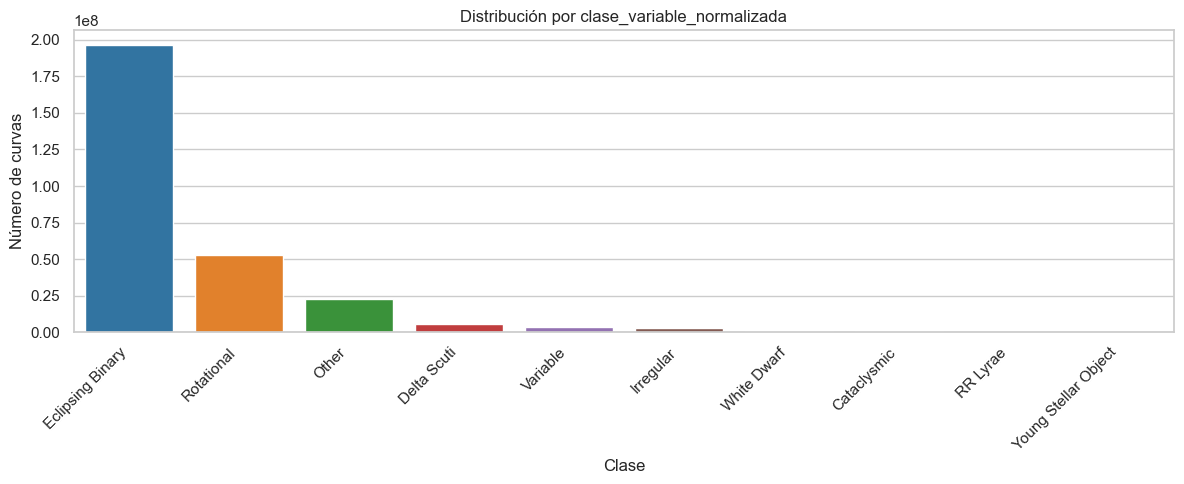


üõ∞Ô∏è Recuento por mision:
Tess      120747997
TESS       76699840
Kepler     71735011
K2         17895159


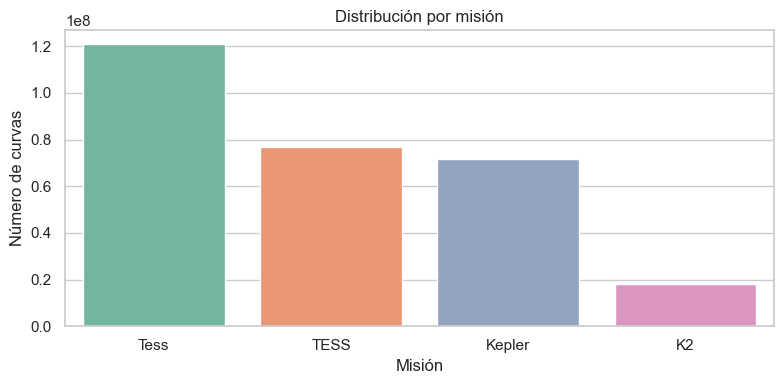


üìÅ Recuento por dataset fuente:
dataset_eb_tess_labeled_fixed.parquet                                      120747997
dataset_eb_kepler_labeled_fixed.parquet                                     71735011
dataset_vsx_tess_labeled_fixed.parquet                                      41143597
dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet     35556243
dataset_k2varcat_labeled_fixed.parquet                                      17895159


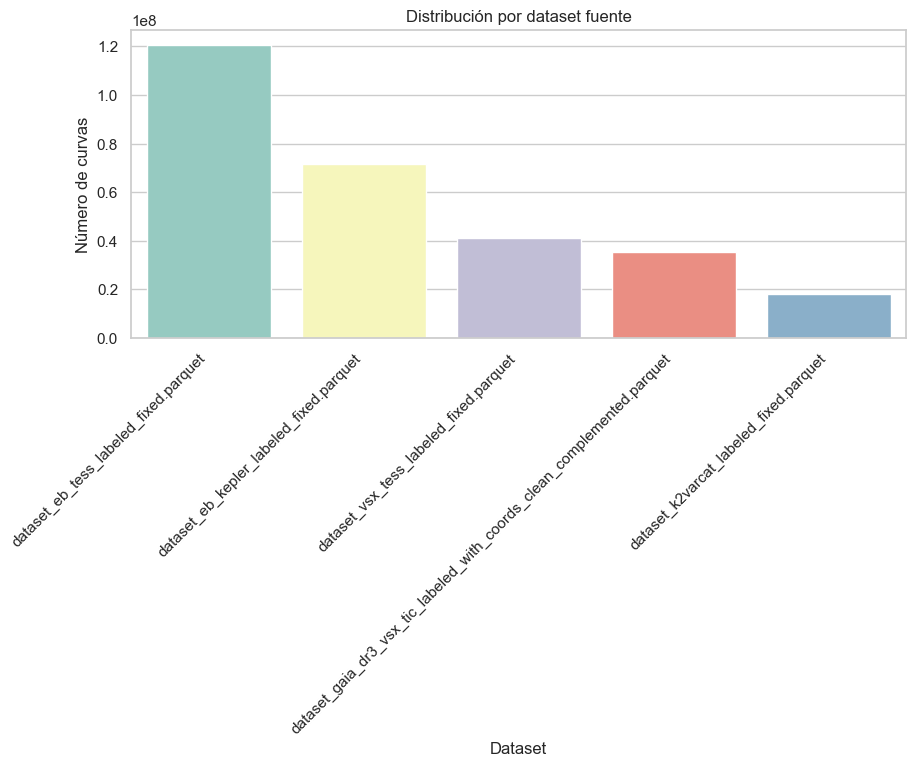

In [2]:
#%pip install seaborn
%run src/fase1/script_7_validate_final_dataset.py

In [3]:
import sys
import os

# A√±adir el directorio src al path
script_dir = os.path.abspath("src")
if script_dir not in sys.path:
    sys.path.append(script_dir)

from src.fase2.script_1_transformer_preprocessing_optimizado_2 import main as transformer_preprocessing_optimizado2

# Ejecutar una prueba con todos los objetos y SEQ_LENGTH=25000
train_loader, val_loader = transformer_preprocessing_optimizado2(
    seq_length=25000,
    batch_size=64,
    num_workers=8,
    device="cpu",
    limit_objects=None,
    max_per_class=None
)

üìÇ Cargando datos en lotes con PyArrow...


Agrupando curvas por objeto: 1127351batch [42:05, 446.35batch/s]


üöÄ Procesando 15080 curvas en paralelo usando 8 CPUs...
üìä Recuento por clase codificada:
 4 (Other): 4417
 2 (Eclipsing Binary): 6317
 6 (Rotational): 2117
 1 (Delta Scuti): 197
 3 (Irregular): 105
 7 (Variable): 113
 5 (RR Lyrae): 32
 8 (White Dwarf): 7
 9 (Young Stellar Object): 16
 0 (Cataclysmic): 9

üìâ Resumen de curvas descartadas:
üî∏ All nan                       : 0
üî∏ Low std                       : 0
üî∏ Short curve                   : 0
üî∏ Nan or inf after norm         : 0
üî∏ Ok                            : 0
‚úÖ Datos preparados como secuencias normalizadas y m√°scaras.


### **Revisi√≥n del diccionario `NORMALIZATION_DICT`**

La idea es quitar peso a la clase "**OTHER**" que esta influyendo demasiado en el entrenamiento del modelo. 

#### ‚úÖ Clases bien mapeadas en el dict actual:

* `EB`, `EA`, `EW`, `DSCT`, `BY`, `RRAB`, `RRC`, `RRD`, `ACV`, `CV`, `UG`, `WD`, `YSO`, etc.

#### ‚ö†Ô∏è Clases importantes **no mapeadas pero frecuentes**:

Se podr√≠an a√±adir como clases v√°lidas o al menos no perderlas en `"Unknown"`:

| Clase          | Sugerencia             |                         |                           |
| -------------- | ---------------------- | ----------------------- | ------------------------- |
| `ZZA`          | White Dwarf            |                         |                           |
| `DSCT:`        | Delta Scuti            |                         |                           |
| `UGZ`          | Cataclysmic            |                         |                           |
| `V1093HER`     | White Dwarf (opcional) |                         |                           |
| `BCEP+SPB`     | Maybe RR Lyrae?        |                         |                           |
| `EA+BY+UV`     | No clara ‚Üí Unknown     |                         |                           |
| `ROAM`, `ROAP` | Rotational             |                         |                           |
| \`RRC          | EC\`                   | RR Lyrae (si parseas \` | \`)                       |
| \`DSCT         | GDOR                   | SXPHE\`                 | Delta Scuti (conservador) |

‚úÖ Vamos a generar un nuevo mapa o diccionario de clases unificado: `normalization_dict.py`:

* Unifica criterios de clasificaci√≥n
* Separa correctamente `"Unknown"` y evita inflar `"Other"`
* Incluye clases frecuentes que no estaban mapeadas (`ZZA`, `V1093HER`, `DSCT:`, `ROAP`, `UGZ`‚Ä¶).
* Evita que residuos vayan a ‚ÄúOther‚Äù sin control.
* Las etiquetas ambiguas o sin mapear ahora se asignan expl√≠citamente a `"Unknown"`.

Y adaptamos los scripts que us√°bamos para normalizar todos los .parquet generados hasta ahora:

2. ‚úîÔ∏è `script_6_unify_all_missions.py` 
    * Usa `normalize_label()` desde el m√≥dulo
    * Filtra curvas v√°lidas y descarta etiquetas desconocidas
3. ‚úîÔ∏è `script_6c_normalize_gaiadr3.py` 
    * Aplica el mismo criterio y normalizaci√≥n para Gaia DR3 complementado

Con esto podemos regenerar ambos datasets (`all_missions_labeled.parquet` y `dataset_gaia_complemented_normalized.parquet`) de forma limpia y coherente antes de validar y relanzar todo el pipeline.

1. **Normalizacion de los primeros datasets**: 
    - `dataset_eb_kepler_labeled_fixed.parquet`
    - `dataset_eb_tess_labeled_fixed.parquet`
    - `dataset_k2varcat_labeled_fixed.parquet`
    - `dataset_vsx_tess_labeled_fixed.parquet`

Crea resumen `clase_variable_normalizada_summary.csv`

In [1]:
%run src/fase1/script_6_unify_all_missions.py

üîé Detectando tipos reales por columna...
üß© Inferiendo tipos compatibles por columna
‚úÖ Esquema global construido con 44 columnas

üìÇ Procesando: dataset_eb_kepler_labeled_fixed.parquet
üìÇ Procesando: dataset_eb_tess_labeled_fixed.parquet
üìÇ Procesando: dataset_k2varcat_labeled_fixed.parquet
üìÇ Procesando: dataset_vsx_tess_labeled_fixed.parquet
‚úÖ Dataset final guardado como: data\processed\all_missions_labeled.parquet
üìÑ Resumen de clases exportado: processed\summary\clase_variable_normalizada_summary.csv


2. **Normalizacion del posterior de Gaia DR3**: 
    - `dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet`

Crea resumen: `clase_variable_normalizada_summary_gaia.csv`

#### ‚úÖ `script_6_unify_all_missions.py` ‚Äî Resultado correcto

* üìÅ Se consolidaron **44 columnas** en el esquema global.
* üìä Se procesaron correctamente los 4 datasets principales.
* üìÑ Se guard√≥ el fichero unificado `all_missions_labeled.parquet`.
* üßÆ El resumen `clase_variable_normalizada_summary.csv` muestra:

| Clase                | N¬∫ curvas |
| -------------------- | --------- |
| Eclipsing Binary     | 194,090   |
| Rotational           | 26,611    |
| Delta Scuti          | 2,714     |
| Irregular            | 1,386     |
| Variable             | 929       |
| White Dwarf          | 828       |
| RR Lyrae             | 334       |
| Cataclysmic          | 324       |
| Young Stellar Object | 138       |


In [1]:
import torch
import gc
import os

# Limpiar memoria de PyTorch si hay algo cargado en GPU (por si acaso)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Forzar liberaci√≥n de memoria Python general
gc.collect()

# Configurar PyTorch para minimizar fragmentaci√≥n futura
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

%run src/fase1/script_6c_normalize_gaiadr3.py

üì• Leyendo esquema desde all_missions_labeled.parquet
üîÑ Procesando Gaia y normalizando clases...


Procesando Gaia: 17802batch [32:39,  9.08batch/s]


‚úÖ Dataset guardado como: data\processed\dataset_gaia_complemented_normalized.parquet
üìä Total filas escritas: 29,794,442
üìÑ Resumen exportado: processed\summary\clase_variable_normalizada_summary_gaia.csv


3. **Validaci√≥n final de los nuevos datasets**:

Note: you may need to restart the kernel to use updated packages.
üìÇ Validando los siguientes archivos:
- data/processed/all_missions_labeled.parquet
- data/processed/dataset_gaia_complemented_normalized.parquet

üß© Esquema detectado:
- tiempo: double
- magnitud: double
- error: double
- quality: double
- timecorr: double
- centroid_col: double
- centroid_row: double
- cadenceno: double
- sap_flux: double
- sap_flux_err: double
- sap_bkg: double
- sap_bkg_err: double
- pdcsap_flux: double
- pdcsap_flux_err: double
- sap_quality: double
- psf_centr1: double
- psf_centr1_err: double
- psf_centr2: double
- psf_centr2_err: double
- mom_centr1: double
- mom_centr1_err: double
- mom_centr2: double
- mom_centr2_err: double
- pos_corr1: double
- pos_corr2: double
- id_objeto: string
- id_mision: string
- mision: string
- fecha_inicio: double
- fecha_fin: double
- clase_variable: string
- clase_variable_normalizada: string
- source_dataset: string
- flux: double
- flux_err: double
- fcor: d

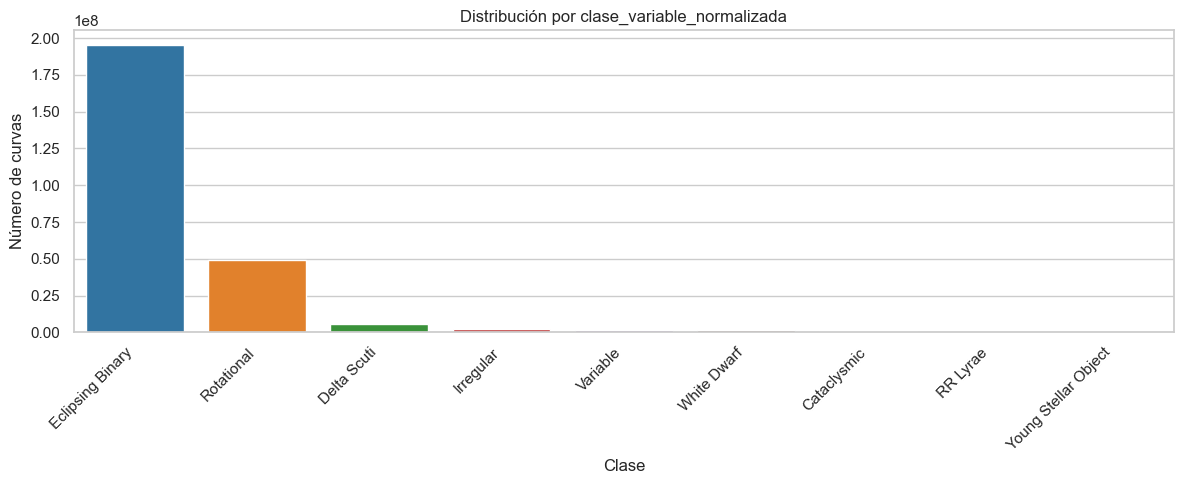


üõ∞Ô∏è Recuento por mision:
Tess      120747997
Kepler     71735011
TESS       64436539
K2           232556


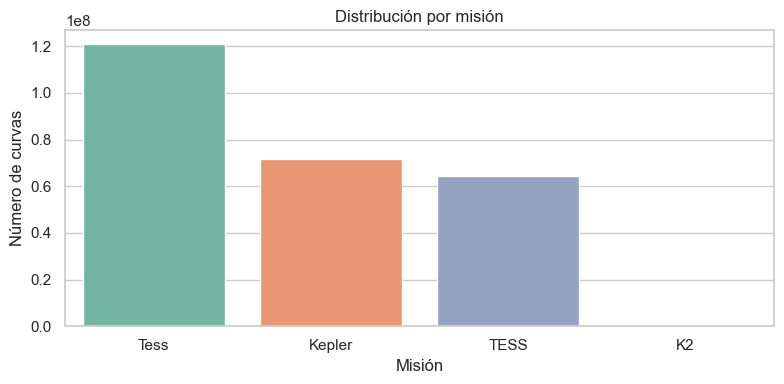


üìÅ Recuento por dataset fuente:
dataset_eb_tess_labeled_fixed.parquet                                      120747997
dataset_eb_kepler_labeled_fixed.parquet                                     71735011
dataset_vsx_tess_labeled_fixed.parquet                                      34642097
dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet     29794442
dataset_k2varcat_labeled_fixed.parquet                                        232556


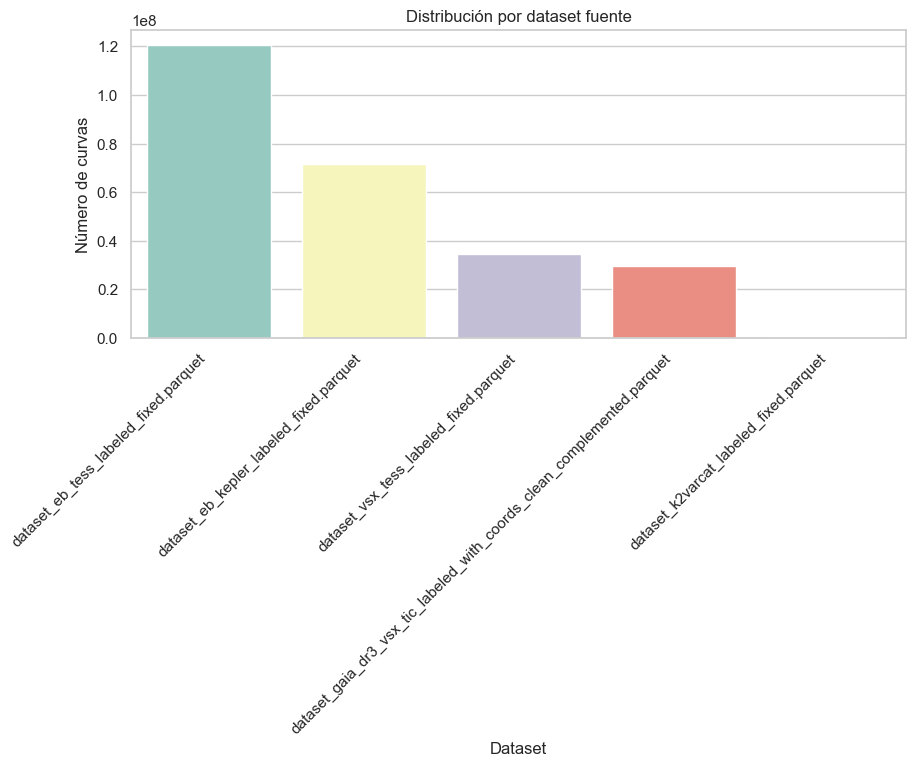

In [1]:
#%pip install seaborn
%run src/fase1/script_7_validate_final_dataset.py

El `script_7_validate_final_dataset.py` confirma lo siguiente:

üì¶ Dataset total consolidado:

* **257.152.103 observaciones**
* **44 columnas est√°ndar**
* Sin valores nulos en campos cr√≠ticos (`tiempo`, `magnitud`, `clase_variable_normalizada`, `id_objeto`)

üìä Distribuci√≥n por clase (`clase_variable_normalizada`)

| Clase                | N¬∫ observaciones |
| -------------------- | ---------------- |
| Eclipsing Binary     | 195.482.030      |
| Rotational           | 49.338.424       |
| Delta Scuti          | 5.434.112        |
| Irregular            | 2.340.876        |
| Variable             | 1.669.448        |
| White Dwarf          | 1.571.998        |
| Cataclysmic          | 601.691          |
| RR Lyrae             | 470.647          |
| Young Stellar Object | 242.877          |

‚úîÔ∏è Las 9 clases finales est√°n bien representadas y no hay residuos como ‚ÄúOther‚Äù o ‚ÄúUnknown‚Äù.

üõ∞ Distribuci√≥n por misi√≥n

| Misi√≥n | Observaciones |
| ------ | ------------- |
| Tess   | 120.747.997   |
| Kepler | 71.735.011    |
| TESS   | 64.436.539    |
| K2     | 232.556       |

‚úîÔ∏è El duplicado entre `Tess` y `TESS` podr√≠a deberse a etiquetas distintas de origen, pero en pr√°ctica es el mismo instrumento (puedes unificarlos en el preprocesado si quieres).

üóÇ Dataset por fuente

| Dataset fuente                                                            | N¬∫ observaciones |
| ------------------------------------------------------------------------- | ---------------- |
| `dataset_eb_tess_labeled_fixed.parquet`                                   | 120.747.997      |
| `dataset_eb_kepler_labeled_fixed.parquet`                                 | 71.735.011       |
| `dataset_vsx_tess_labeled_fixed.parquet`                                  | 34.642.097       |
| `dataset_gaia_dr3_vsx_tic_labeled_with_coords_clean_complemented.parquet` | 29.794.442       |
| `dataset_k2varcat_labeled_fixed.parquet`                                  | 232.556          |

‚úîÔ∏è El aporte de Gaia y VSX ha sido decisivo para reforzar clases minoritarias.

üß† Conclusi√≥n

‚úÖ Dataset consolidado y validado **listo para un nuevo preprocesamiento y entrenamiento**. 

4. **Nuevo preprocesado para generar los datasets de entrenamiento y validaci√≥n**:

`SEQ_LENGTH=25000`

`max_per_class=None`

Luego pasaremos a SageMaker para hacer un nuevo entrenamiento optimizado con encoder congelado (`script_2_transformer_training_optimizado2.py`), y el posterior fine-tuning (`fine_tuning_optimizado2`)

In [1]:
import sys
import os
import torch

# A√±adir el directorio src al path
script_dir = os.path.abspath("src")
if script_dir not in sys.path:
    sys.path.append(script_dir)

from src.fase2.script_1_transformer_preprocessing_optimizado_2 import main as transformer_preprocessing_optimizado2

# Ejecutar una prueba con todos los objetos y SEQ_LENGTH=25000
train_loader, val_loader = transformer_preprocessing_optimizado2(
    seq_length=25000,
    batch_size=64,
    num_workers=8,
    device="cpu",
    limit_objects=None,
    max_per_class=None
)

# Guardar datasets serializados para no perderlos al reiniciar el kernel y poder subirlos a SageMaker
torch.save(train_loader.dataset, "data/train/train_dataset.pt")
torch.save(val_loader.dataset, "data/train/val_dataset.pt")

üìÇ Cargando datos en lotes con PyArrow...


Agrupando curvas por objeto: 1010201batch [28:39, 587.50batch/s]


üöÄ Procesando 9729 curvas en paralelo usando 8 CPUs...
üìä Recuento por clase codificada:
 1 (Delta Scuti): 198
 2 (Eclipsing Binary): 6274
 5 (Rotational): 1925
 3 (Irregular): 71
 6 (Variable): 81
 7 (White Dwarf): 10
 8 (Young Stellar Object): 21
 4 (RR Lyrae): 28
 0 (Cataclysmic): 5

üìâ Resumen de curvas descartadas:
üî∏ All nan                       : 0
üî∏ Low std                       : 0
üî∏ Short curve                   : 0
üî∏ Nan or inf after norm         : 0
üî∏ Ok                            : 0
‚úÖ Datos preparados como secuencias normalizadas y m√°scaras.


Propuesta final optimizada para esta **nueva ronda de entrenamiento y fine-tuning** con el nuevo mapeo de clases, basada en:

* Mejores resultados anteriores (`val_acc ‚âà 0.63`, `val_loss ‚âà 0.57`)
* Observaciones sobre overfitting en clases mayoritarias
* La nueva base de datos limpia y ¬øbalanceada?

#### ‚úÖ Entrenamiento (`script_2_transformer_training_optimizado2.py`)

| Par√°metro         | Valor propuesto              | Justificaci√≥n                              |
| ----------------- | ---------------------------- | ------------------------------------------ |
| `freeze_encoder`  | ‚úÖ `True` (congelado)         | Fase base de transferencia                 |
| `epochs`          | `50`                         | M√°ximo razonable con early stopping        |
| `patience`        | `6`                          | Para evitar cortar antes de estabilizaci√≥n |
| `lr`              | `3e-5`                       | Funcion√≥ bien en √∫ltimas pruebas           |
| `optimizer`       | `AdamW`                      | Robustez frente a sobreajuste              |
| `dropout`         | `0.3`                        | Ya integrado en el modelo base             |
| `loss`            | `FocalLoss(gamma=2.0)`       | Enfoca el aprendizaje en clases dif√≠ciles  |
| `batch_size`      | `16`                         | Confirmado como m√°ximo sostenible en GPU   |
| `label_smoothing` | ‚ùå `No` en entrenamiento base | Solo en fine-tuning                        |

üìù Modelo guardado en `outputs/mejor_modelo_optimizado.pt`

#### ‚úÖ Fine-Tuning (`fine_tuning_optimizado2.py`)

| Par√°metro        | Valor propuesto                      | Justificaci√≥n                            |
| ---------------- | ------------------------------------ | ---------------------------------------- |
| `freeze_encoder` | ‚ùå `False` (todo el modelo)           | Ajuste fino completo                     |
| `epochs`         | `30`                                 | Menos que entrenamiento, pero suficiente |
| `patience`       | `4`                                  | Detectar pronto si deja de mejorar       |
| `lr_encoder`     | `2e-6`                               | Aprendizaje lento sobre capas profundas  |
| `lr_classifier`  | `1e-5`                               | Aprendizaje m√°s r√°pido sobre capa final  |
| `loss`           | `CrossEntropy + label_smoothing=0.1` | Suaviza ajuste fino                      |
| `batch_size`     | `8`                                  | Confirmado como √≥ptimo para evitar OOM   |

üìù Modelo guardado en `outputs/mejor_modelo_finetuned_optimizado2.pt`

#### üü® Alternativas (a probar despu√©s)

* Si tras fine-tuning no mejora `val_acc`, podemos probar:

  * Entrenamiento completo sin congelar desde el principio (m√°s arriesgado)
  * `mixup` o `augmentaci√≥n sint√©tica` (requiere implementaci√≥n)
  * Reajuste de clases (`Other`, `Variable`) ‚Üí decisi√≥n ya tomada de mantenerlas separadas
